# **Capstone Project: Providing Data-Driven Suggestions for HR**

## Table of Contents: <a class="anchor" id="toc"></a>

### Introduction and EDA

* [Introduction](#introduction)
* [Initial EDA and Data Cleaning](#initial-eda)
* [EDA](#eda)
* [EDA Summary](#edasummary)

### Predictive Model Construction and Validation

* [Logistic Regression Model 1 (No Interaction Terms)](#lr1)
* [Logistic Regression Model 2 (Interaction Terms)](#lr2)
* [Logistic Regression Model 3 (Interaction Terms)](#lr3)
* [Decision Tree (F1 optimized)](#dt_f1)
* [Decision Tree (Recall optimized)](#dt_recall)
* [Random Forest (F1 optimized)](#rf_f1)
* [Random Forest (Recall optimized)](#rf_recall)
* [XGBoost (F1 optimized)](#xgb_f1)
* [XGBoost (Recall optimized)](#xgb_recall)

### Model Selection and Evaluation

* [Model Selection and Evaluation](#model-selection)

### Recommendations, Next Steps

* [Recommendations, Next Steps](#recommendations)

# **PACE stages**


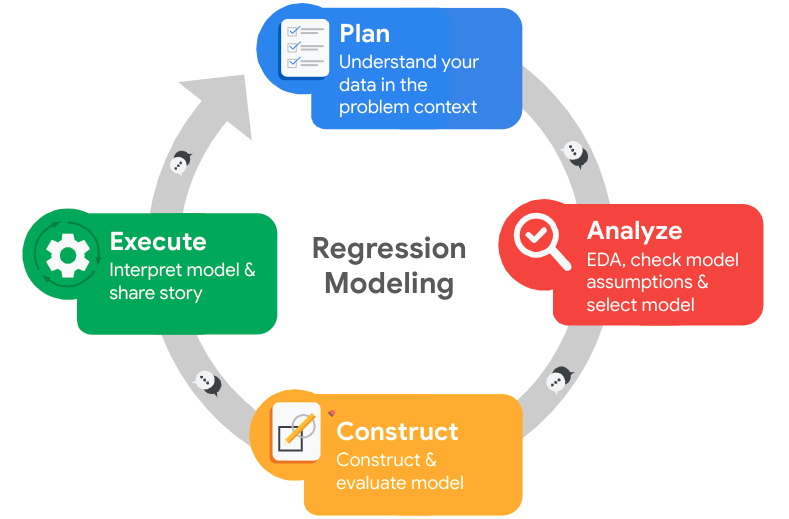

## **Pace: Plan**

### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They have the following question: what’s likely to make the employee leave the company?

My goals in this project are to analyze the data collected by the HR department and to build a model(s) that predicts whether or not an employee will leave the company.

If I can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### Familiarization with the HR dataset

The dataset contains 15,000 rows and 10 columns for the variables listed below. 

**Note:** For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

Stakeholders include the HR department, the Salifort Motors executive team, and Salifort Motors employees in general.

The goals of this project are to build a model that will predict whether an employee will leave the company, identify the factors most important in determining this, and to uncover any insights from the data that might help the company better retain its employees.

It appears the data has been properly anonymized and I have not identified any ethical issues to escalate/resolve at this time.

## Step 1. Imports

*   Import packages
*   Load dataset



### Import packages

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import plot_tree

import pickle
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from scipy.special import logit, expit
from sklearn.feature_selection import RFE 
from sklearn.svm import SVR 
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, plot_roc_curve,\
auc
import statsmodels.api as sm
!pip install hyperopt
!pip install statsmodels --upgrade
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from scipy import stats
from statsmodels.discrete.discrete_model import Logit
from statsmodels.stats.proportion import proportions_ztest, test_proportions_2indep
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
from IPython.display import display

     |████████████████████████████████| 1.6 MB 35.3 MB/s            
     |████████████████████████████████| 200 kB 122.3 MB/s            
     |████████████████████████████████| 840 kB 117.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=32ff508f811b5830fb1e4f17cec0940ed0f6ca68ab3b593a5e56a6dd0f2d9674
  Stored in directory: /home/jovyan/.cache/pip/wheels/fa/cd/1f/c6b7b50b564983bf3011e8fc75d06047ddc50c07f6e3660b00
Successfully built future
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.9 MB 30.4 MB/s            
     |████████████████████████████████| 53 kB 9.6 MB/s             
     |████████████████████████████████| 233 kB 113.0 MB/s            
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  

ImportError: cannot import name 'test_proportions_2indep' from 'statsmodels.stats.proportion' (/opt/conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py)

### Load dataset

In [2]:
# RUN THIS CELL TO IMPORT YOUR DATA. 

# Load dataset into a dataframe
### YOUR CODE HERE ###
df0 = pd.read_csv("HR_capstone_dataset.csv")


# Display first few rows of the dataframe
df0.head()


satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

## Step 2. Data Exploration (Initial EDA and data cleaning) <a class="anchor" id="initial-eda"></a>

[Go Back to Table of Contents](#toc)
- Understand the variables
- Clean the dataset (missing data, redundant data, outliers)



### Gather basic information about the data

In [254]:
# Gather basic information about the data
df0.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   satis_lvl            14999 non-null  float64
 1   last_eval            14999 non-null  float64
 2   num_projects         14999 non-null  int64  
 3   avg_monthly_hrs      14999 non-null  int64  
 4   tenure               14999 non-null  int64  
 5   work_accident        14999 non-null  int64  
 6   left                 14999 non-null  int64  
 7   promotion_last_5yrs  14999 non-null  int64  
 8   dept                 14999 non-null  object 
 9   salary               14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [7]:
# Gather descriptive statistics about the data
df0.describe(include = 'all')


satisfaction_level  last_evaluation  number_project  \
count         14999.000000     14999.000000    14999.000000   
unique                 NaN              NaN             NaN   
top                    NaN              NaN             NaN   
freq                   NaN              NaN             NaN   
mean              0.612834         0.716102        3.803054   
std               0.248631         0.171169        1.232592   
min               0.090000         0.360000        2.000000   
25%               0.440000         0.560000        3.000000   
50%               0.640000         0.720000        4.000000   
75%               0.820000         0.870000        5.000000   
max               1.000000         1.000000        7.000000   

        average_montly_hours  time_spend_company  Work_accident          left  \
count           14999.000000        14999.000000   14999.000000  14999.000000   
unique                   NaN                 NaN            NaN           NaN   
top                      NaN                 NaN            NaN           NaN   
freq                     NaN                 NaN            NaN           NaN   
mean              201.050337            3.498233       0.144610      0.238083   
std                49.943099            1.460136       0.351719      0.425924   
min                96.000000            2.000000       0.000000      0.000000   
25%               156.000000            3.000000       0.000000      0.000000   
50%               200.000000            3.000000       0.000000      0.000000   
75%               245.000000            4.000000       0.000000      0.000000   
max               310.000000           10.000000       1.000000      1.000000   

        promotion_last_5years Department salary  
count            14999.000000      14999  14999  
unique                    NaN         10      3  
top                       NaN      sales    low  
freq                      NaN       4140   7316  
mean                 0.021268        NaN    NaN  
std                  0.144281        NaN    NaN  
min                  0.000000        NaN    NaN  
25%                  0.000000        NaN    NaN  
50%                  0.000000        NaN    NaN  
75%                  0.000000        NaN    NaN  
max                  1.000000        NaN    NaN

### Rename columns

Rename columns as part of data cleaning. Standardize the column names so that they are all in `snake_case`, correct column names that are misspelled, and make column names more concise.

In [3]:
# Display all column names

df0.columns


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

## Notes on Dataset/Variables Improvement

It would be prudent to get more detail from HR on how sampling was conducted to judge whether this dataset is likely to be truly representative of the population (the entire company). If this dataset is not representative, making inferences with a predictive model based on it would be inaccurate.

Actual salary amounts instead of categories would likely make 'salary' a better predictor variable for the outcome variable 'left'. I would not have any ethical concerns about this as long as the data remains anonymized and is made available for use only upon employee consent. Also, job titles aren't included in the dataset. This was a variable that the executive team specifically called out to use in analysis. Additionally, including more than just the last evaluation for each employee could be insightful - perhaps the last two to three evaluations. More generally, it's unclear over what timeframe some of these variables cover - it would be useful to know how various variables progressed over time, such as for satisfaction level, evaluations, number of projects, average monthly hours, when work accidents occurred, what departments employees worked in over time, and salary.

Additionally, it would be useful to know, in addition to the number of projects, the level of project complexity/scope - these would likely go together as a useful interaction variable to include in predictive modeling.

Also, if Salifort Motors conducted additional periodic Organizational Health Surveys (OHS), there could be a wealth of valuable information from those to include in this dataset to better predict whether an employee will leave vs. stay. Examples of additional useful information might include job titles, whether employees feel safe and valued at work, whether they trust their managers, how they view their team environment, whether they feel their pay level is fair, whether they feel that their job is secure, whether they feel there is ample opportunity for career growth in the company, whether they feel fulfilled with the work they do in their job, how employees would define what the company culture is, etc.

Lastly, the satisfaction level variable could be a source of data leakage when used to train the predictive models since it may not be a variable that will be available in the future when the chosen model is deployed. If it will be available, through periodic company-wide Organizational Health Surveys or otherwise, then data leakage will not be a concern. However, if it will not be available moving forward, then the projected effectiveness of the chosen model might be somewhat inflated.

Including the above information in the dataset would greatly improve the company's ability to gain insights into what contributes to employee satisfaction/dissatisfaction and whether an employee is likely to leave vs. stay.

In [3]:
# Rename columns as needed

df0 = df0.rename(columns={'satisfaction_level':'satis_lvl','last_evaluation':'last_eval','number_project':'num_projects',
                          'average_montly_hours':'avg_monthly_hrs','time_spend_company':'tenure',
                         'Work_accident':'work_accident','promotion_last_5years':'promotion_last_5yrs',
                         'Department':'dept'})


# Display all column names after the update

df0.columns

Index(['satis_lvl', 'last_eval', 'num_projects', 'avg_monthly_hrs', 'tenure',
       'work_accident', 'left', 'promotion_last_5yrs', 'dept', 'salary'],
      dtype='object')

### Check missing values

Check for any missing values in the data.

In [10]:
df0.isna().sum()


satis_lvl              0
last_eval              0
num_projects           0
avg_monthly_hrs        0
tenure                 0
work_accident          0
left                   0
promotion_last_5yrs    0
dept                   0
salary                 0
dtype: int64

### Check duplicates

Check for any duplicate entries in the data.

In [7]:
# Check for duplicates

print("\033[1m# Duplicates in Dataset:\033[0m",df0.duplicated().sum())

print('\033[1mDuplicates % of Dataset:\033[0m',"%.2f"%(3008/14998 * 100),'%')


# Duplicates in Dataset: 3008
Duplicates % of Dataset: 20.06 %


### Duplicates Concern

Why are there so many duplicates in this dataset? Duplicates make up over 20% of all records. Were employees allowed to take the survey more than once? Even so, why would an employee fill out the survey more than once just to include all the same entries? Should engage HR on this.

### Recommendation

<span style='background :yellow' >**Data Duplicates.** 

<span style='background :yellow' >HR should find the source(s) of the duplicates in this dataset and figure out a way to eliminate or at least decrease them in future data gathering efforts. A few duplicates is not a real issue but when duplicates make up a large portion of the data (in this case over 20%), they inflate survey response rates and can cause data gathering efforts to stop prematurely when the data gathering team thinks they have enough unique responses, but in fact do not due to the duplicate reponses. If the duplicate responses in this dataset were instead unique responses, that would have meant much more data to use for analysis and training/testing predictive models.

In [12]:
# Inspect some rows containing duplicates as needed

df0[df0.duplicated() == True]


satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  \
396         0.46       0.57             2              139       3   
866         0.41       0.46             2              128       3   
1317        0.37       0.51             2              127       3   
1368        0.41       0.52             2              132       3   
1461        0.42       0.53             2              142       3   
...          ...        ...           ...              ...     ...   
14994       0.40       0.57             2              151       3   
14995       0.37       0.48             2              160       3   
14996       0.37       0.53             2              143       3   
14997       0.11       0.96             6              280       4   
14998       0.37       0.52             2              158       3   

       work_accident  left  promotion_last_5yrs        dept  salary  
396                0     1                    0       sales     low  
866                0     1                    0  accounting     low  
1317               0     1                    0       sales  medium  
1368               0     1                    0       RandD     low  
1461               0     1                    0       sales     low  
...              ...   ...                  ...         ...     ...  
14994              0     1                    0     support     low  
14995              0     1                    0     support     low  
14996              0     1                    0     support     low  
14997              0     1                    0     support     low  
14998              0     1                    0     support     low  

[3008 rows x 10 columns]

In [4]:
# Drop duplicates and save resulting dataframe in a new variable

df1 = df0.drop_duplicates()


# Display first few rows of new dataframe

display(df1.head())
print('\n')
print('\033[1m# Duplicates in Dataset:\033[0m',df1.duplicated().sum())
print('\n')
print(df1.info())


satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
1       0.80       0.86             5              262       6              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   

   left  promotion_last_5yrs   dept  salary  
0     1                    0  sales     low  
1     1                    0  sales  medium  
2     1                    0  sales  medium  
3     1                    0  sales     low  
4     1                    0  sales     low



# Duplicates in Dataset: 0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   satis_lvl            11991 non-null  float64
 1   last_eval            11991 non-null  float64
 2   num_projects         11991 non-null  int64  
 3   avg_monthly_hrs      11991 non-null  int64  
 4   tenure               11991 non-null  int64  
 5   work_accident        11991 non-null  int64  
 6   left                 11991 non-null  int64  
 7   promotion_last_5yrs  11991 non-null  int64  
 8   dept                 11991 non-null  object 
 9   salary               11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB
None


### Check outliers

Check for outliers in the data.

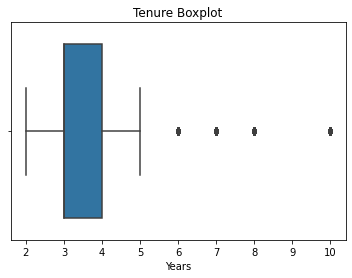

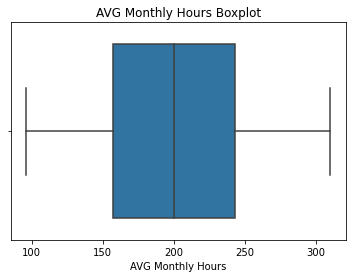

In [14]:
# Create a boxplot to visualize distribution of `tenure` and 'avg monthly hrs' and detect any outliers

g = sns.boxplot(x=df1['tenure']);
g.set_title('Tenure Boxplot');
g.set_xlabel('Years');
plt.show()

g = sns.boxplot(x=df1['avg_monthly_hrs']);
g.set_title('AVG Monthly Hours Boxplot');
g.set_xlabel('AVG Monthly Hours');
plt.show()

### Observations

It looks like 'tenure' has some outliers on the high end of its range. This could be problematic when training certain predictive models. Will explore this further.

It looks like AVG Monthly Hours doesn't have any outliers.

In [5]:
# Determine the number of rows containing outliers

percentile25 = df1['tenure'].quantile(0.25)
percentile75 = df1['tenure'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print('\033[1mTenure Upper Limit:\033[0m',upper_limit)
print('\033[1mTenure Lower Limit:\033[0m',lower_limit)

tenure_outliers = df1[df1['tenure'] > upper_limit]

display(df1[df1['tenure'] < lower_limit])
display(df1[df1['tenure'] > upper_limit])

print('\033[1m# Outliers Below Lower Limit:\033[0m',df1[df1['tenure'] < lower_limit].shape[0])
print('\n')
print('\033[1m# Outliers Above Upper Limit:\033[0m',df1[df1['tenure'] > upper_limit].shape[0])
print('\n')
print('\033[1m% of Data that are Outliers:\033[0m',round((824/11991)*100,3),'%')

Tenure Upper Limit: 5.5
Tenure Lower Limit: 1.5


Empty DataFrame
Columns: [satis_lvl, last_eval, num_projects, avg_monthly_hrs, tenure, work_accident, left, promotion_last_5yrs, dept, salary]
Index: []

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  \
1           0.80       0.86             5              262       6   
17          0.78       0.99             4              255       6   
34          0.84       0.87             4              246       6   
47          0.57       0.70             3              273       6   
67          0.90       0.98             4              264       6   
...          ...        ...           ...              ...     ...   
11994       0.22       0.94             3              193      10   
11995       0.90       0.55             3              259      10   
11996       0.74       0.95             5              266      10   
11997       0.85       0.54             3              185      10   
11998       0.33       0.65             3              172      10   

       work_accident  left  promotion_last_5yrs         dept  salary  
1                  0     1                    0        sales  medium  
17                 0     1                    0        sales     low  
34                 0     1                    0           hr     low  
47                 0     1                    0      support     low  
67                 0     1                    0  product_mng  medium  
...              ...   ...                  ...          ...     ...  
11994              0     0                    1   management    high  
11995              1     0                    1   management    high  
11996              0     0                    1   management    high  
11997              0     0                    1   management    high  
11998              0     0                    1    marketing    high  

[824 rows x 10 columns]

# Outliers Below Lower Limit: 0


# Outliers Above Upper Limit: 824


% of Data that are Outliers: 6.872 %


### Observations

There are 824 outliers in the 'tenure' variable, all of which are beyond the upper limit defined by 1.5 multipled by the variable's IQR. This makes up about 7% of all records.

Certain types of models are more sensitive to outliers than others. These outliers will be removed from the dataset when constructing/training/testing the Logistic Regression and XGBoost models since they are both sensitive to outliers. The outliers shouldn't negatively affect the Decision Tree or Random Forest models.

# pAce: Analyze Stage
- Perform EDA (analyze relationships between variables)



## Step 2. Data Exploration (Continue EDA) <a class="anchor" id="eda"></a>

[Go Back to Table of Contents](#toc)

Begin by understanding how many employees left and what percentage of all employees this figure represents.

In [16]:
# Get numbers of employees who left vs. stayed

print('\n')
print('\033[1m# of Employees Who Left (1) vs. Stayed (0)\033[0m')
print(df1['left'].value_counts())
print('\n')

# Get percentages of employees who left vs. stayed

print('\033[1m% of Employees Who Left (1) vs. Stayed (0)\033[0m')
print(df1['left'].value_counts(normalize=True))
print('\n')

total_emp = df1['left'].value_counts().sum()
print("\033[1mTotal # Employees:\033[0m",total_emp)



# of Employees Who Left (1) vs. Stayed (0)
0    10000
1     1991
Name: left, dtype: int64


% of Employees Who Left (1) vs. Stayed (0)
0    0.833959
1    0.166041
Name: left, dtype: float64


Total # Employees: 11991


### Observations

The classes in the dataset are imbalanced: about 83% stayed (0) and 17% left (1). I would consider upsampling the left class (1) or downsampling the stayed class (0) if the imbalance was >= 90%/10%. This would provide more observations of the left class (1) in relation to the stayed class (0) so that a predictive model would have more of the minority class to learn from to make more accurate predictions for that class.

If I were to rebalance the dataset, 11,991 observations might be enough to perform downsampling without degrading performance of the predictive model but I would probably experiment by conducting both downsampling and upsampling separately as well as fitting the model using the true original dataset to see which method causes the model to perform better on validation data.

A risk to performing class rebalancing would be that it changes the underlying probabilities in the source data and the predicted probabilities from the resulting model wouldn't be as reliable for downstream use in future models or decisions to be made.

**Since the class imbalance is not too severe in this dataset, I will not conduct any class rebalancing.**

### Data Visualizations

Create plots to visualize relationships between variables in the data.

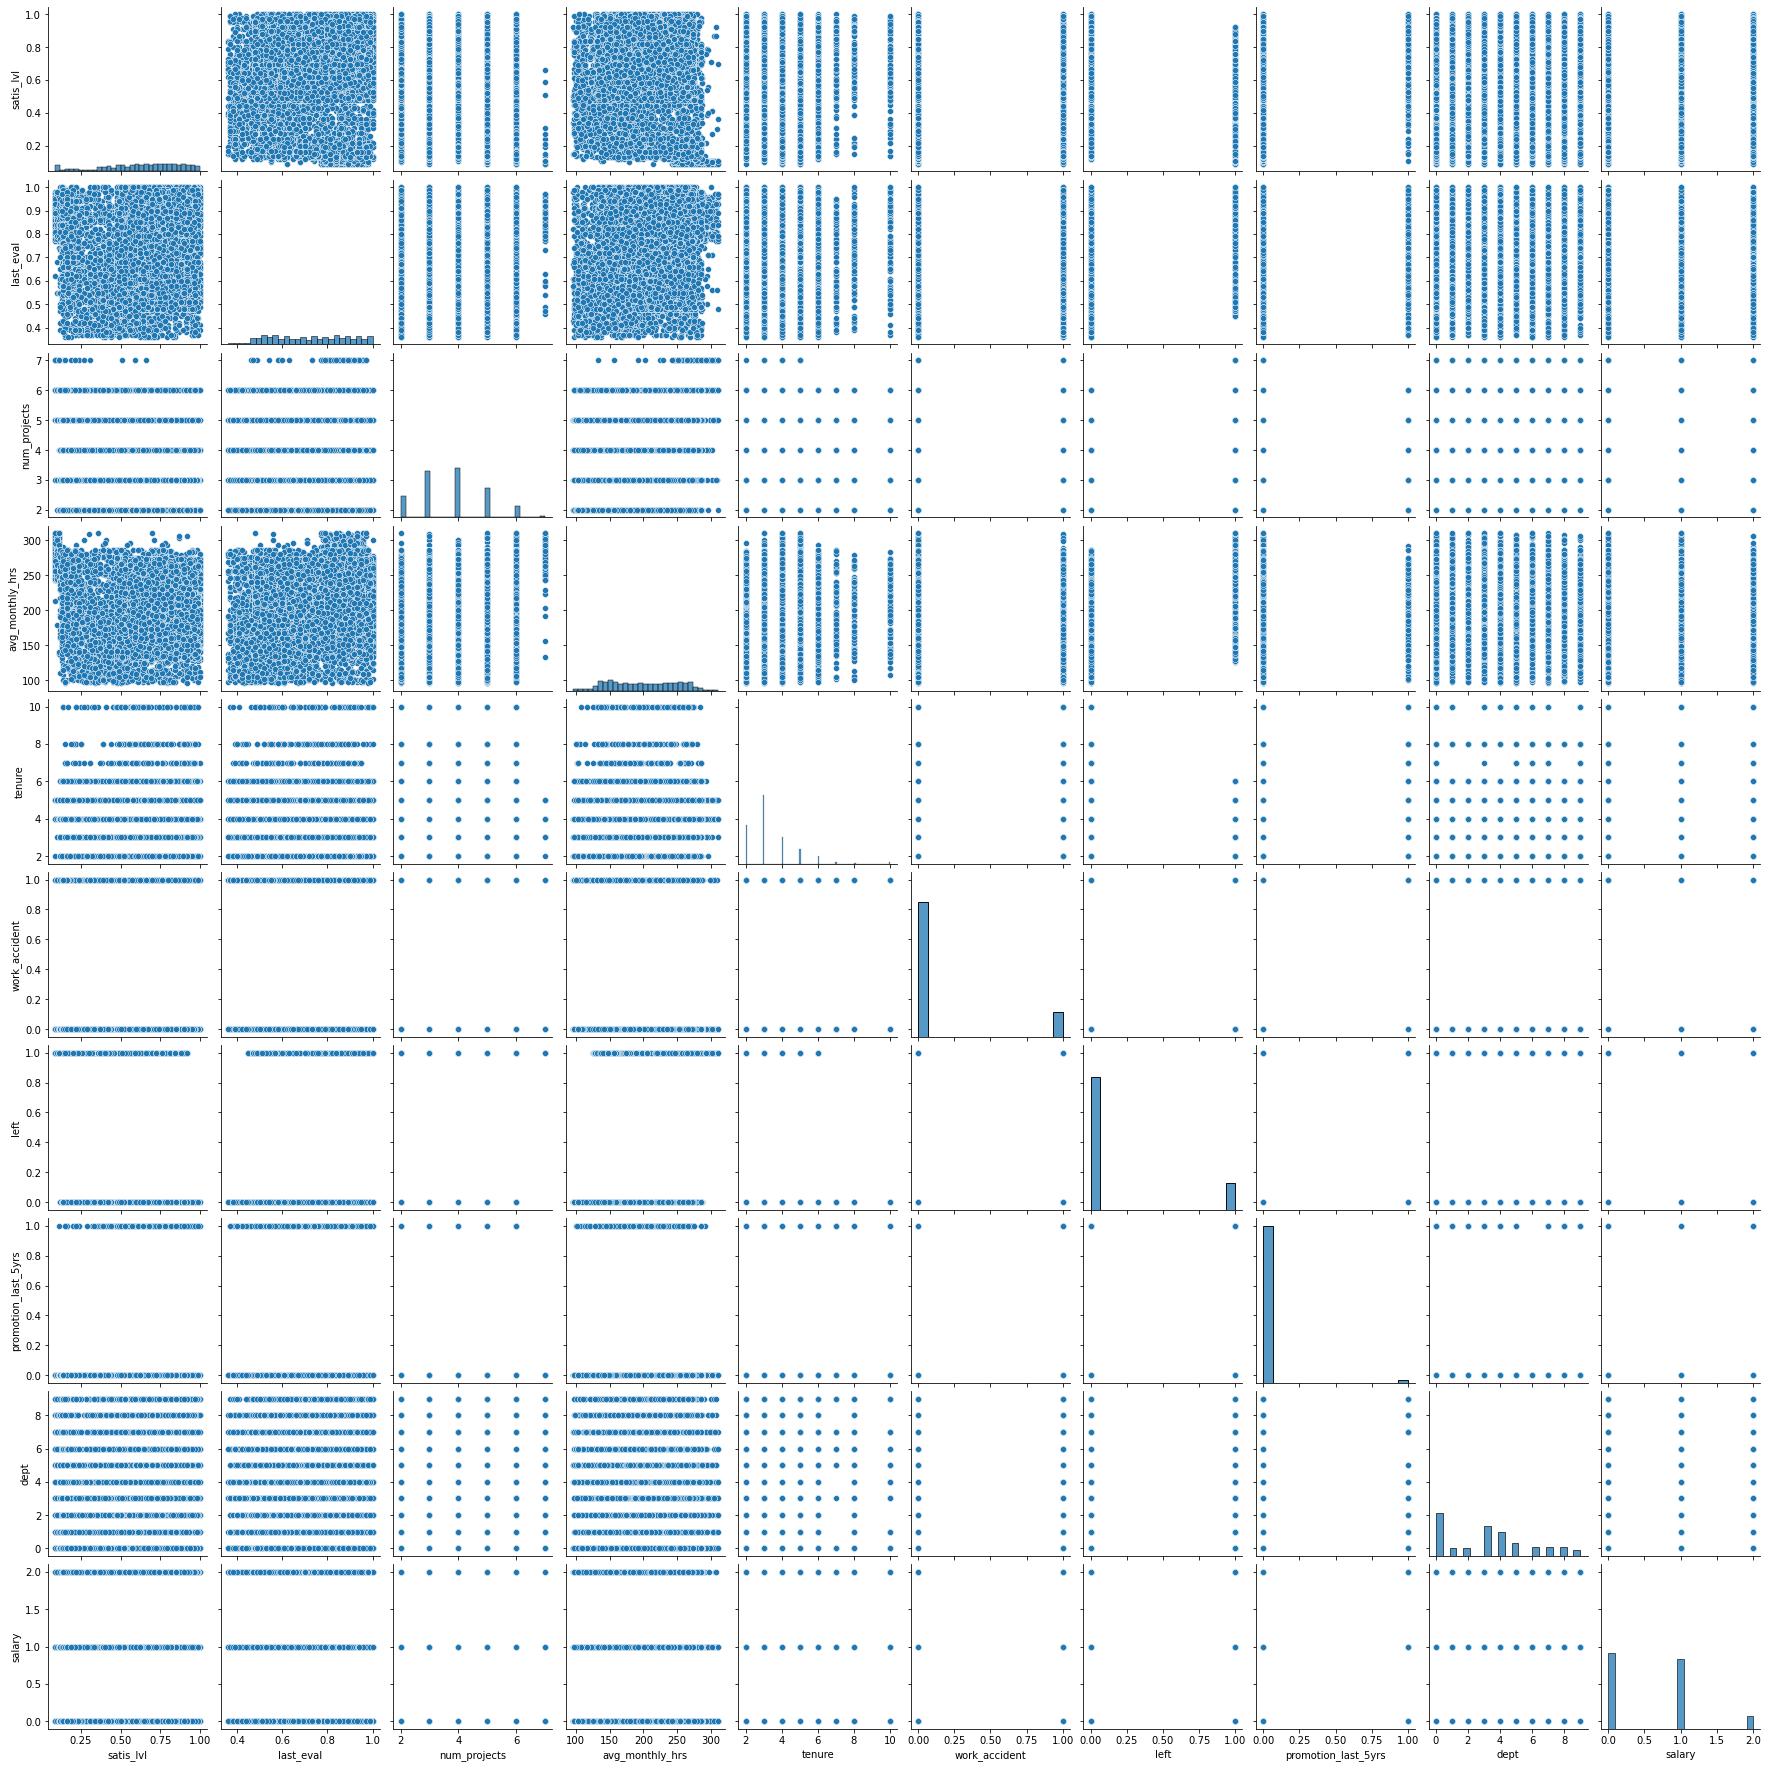

In [224]:
# Create a plot as needed

dept_dict = {'sales': 0, 'accounting': 1, 'hr': 2, 'technical': 3, 'support': 4, 'IT': 5, 'product_mng': 6,
            'marketing': 7, 'RandD': 8, 'management': 9}

salary_dict = {'low': 0, 'medium': 1, 'high': 2}

df1_dept_sal_mapped = df1.copy()
df1_dept_sal_mapped['dept'] = df1_dept_sal_mapped['dept'].map(dept_dict)
df1_dept_sal_mapped['salary'] = df1_dept_sal_mapped['salary'].map(salary_dict)

sns.pairplot(df1_dept_sal_mapped);

There seems to be some meaningful relationships amongst variables - will explore these in more depth below.

In [223]:
# Output correlation matrix of df1 to better understand how variables within the dataset are correlated; used to 
# inform further EDA.

display(df1_dept_sal_mapped.corr())

satis_lvl  last_eval  num_projects  avg_monthly_hrs  \
satis_lvl             1.000000   0.095186     -0.133246        -0.006252   
last_eval             0.095186   1.000000      0.270256         0.264678   
num_projects         -0.133246   0.270256      1.000000         0.331516   
avg_monthly_hrs      -0.006252   0.264678      0.331516         1.000000   
tenure               -0.152915   0.096829      0.188837         0.102875   
work_accident         0.039940  -0.005695     -0.005612        -0.012860   
left                 -0.350558   0.013520      0.030928         0.070409   
promotion_last_5yrs   0.019789  -0.007206     -0.000544        -0.004964   
dept                  0.005734   0.013710      0.008645         0.001717   
salary                0.029241  -0.015775     -0.000502        -0.000551   

                       tenure  work_accident      left  promotion_last_5yrs  \
satis_lvl           -0.152915       0.039940 -0.350558             0.019789   
last_eval            0.096829      -0.005695  0.013520            -0.007206   
num_projects         0.188837      -0.005612  0.030928            -0.000544   
avg_monthly_hrs      0.102875      -0.012860  0.070409            -0.004964   
tenure               1.000000       0.000003  0.173295             0.056828   
work_accident        0.000003       1.000000 -0.125436             0.029852   
left                 0.173295      -0.125436  1.000000            -0.044657   
promotion_last_5yrs  0.056828       0.029852 -0.044657             1.000000   
dept                 0.029427       0.012381 -0.028614             0.046125   
salary               0.038164      -0.000058 -0.118882             0.087851   

                         dept    salary  
satis_lvl            0.005734  0.029241  
last_eval            0.013710 -0.015775  
num_projects         0.008645 -0.000502  
avg_monthly_hrs      0.001717 -0.000551  
tenure               0.029427  0.038164  
work_accident        0.012381 -0.000058  
left                -0.028614 -0.118882  
promotion_last_5yrs  0.046125  0.087851  
dept                 1.000000  0.049751  
salary               0.049751  1.000000

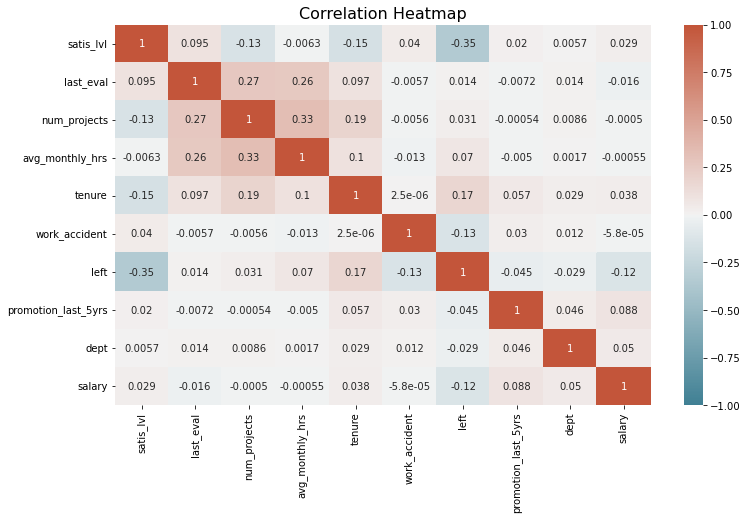

In [15]:
# Plot correlation heatmap of df1

plt.figure(figsize=(12,7))
ax = sns.heatmap(df1_dept_sal_mapped.corr(), vmin=-1, vmax=1, annot=True, cmap = sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

### Observations/Insights

The strongest correlations are between 'satis_lvl' and 'left' (-0.35), 'num_projects' and 'avg_monthly_hrs' (0.33), 'last_eval' and 'num_projects' (0.27), and 'avg_monthly_hrs' and 'last_eval' (0.26).

The single variables that have the strongest correlation with 'left' are 'satis_lvl' (-0.35), 'tenure' (0.17), 'work_accident' (-0.13), and 'salary' (-0.12).

These relationships and more will be explored through EDA of the dataset to uncover any useful insights/better understand the nature of these relationships.

There are likely interaction variables that can be created that have greater correlations with 'left'. This will be explored both through EDA and when constructing the logistic regression model.

In [6]:
# Compare Left vs. Stayed Summary Statistics

df1_left = df1[df1['left'] == 1]
df1_stayed = df1[df1['left'] == 0]

# Convert Column Data Types for Categorical Variables

df1_left['left'] = df1_left['left'].astype('category')
df1_left['work_accident'] = df1_left['work_accident'].astype('category')
df1_left['promotion_last_5yrs'] = df1_left['promotion_last_5yrs'].astype('category')
df1_left['salary'] = df1_left['salary'].astype('category')

df1_stayed['salary'] = df1_stayed['salary'].astype('category')
df1_stayed['promotion_last_5yrs'] = df1_stayed['promotion_last_5yrs'].astype('category')
df1_stayed['work_accident'] = df1_stayed['work_accident'].astype('category')
df1_stayed['left'] = df1_stayed['left'].astype('category')

# Display Left vs. Stayed Summary Statistics Tables

print('\n')
print('\033[1mEmployees Who Left Summary Statistics:\033[0m ')
display(df1_left.describe(include='all'))

# 95% Confidence Intervals for Employees Who Left Average point estimates

# 'satis_lvl'

est_SE = 0.265207 / np.sqrt(1991)
CI_left_satis = stats.norm.interval(alpha=0.95, loc=0.440271, scale=est_SE)
CI_left_satis = (round(CI_left_satis[0],3),round(CI_left_satis[1],3))

# 'last_eval'

est_SE = 0.197436 / np.sqrt(1991)
CI_left_eval = stats.norm.interval(alpha=0.95, loc=0.721783, scale=est_SE)
CI_left_eval = (round(CI_left_eval[0],3),round(CI_left_eval[1],3))

# 'num_projects'

est_SE = 1.817139 / np.sqrt(1991)
CI_left_proj = stats.norm.interval(alpha=0.95, loc=3.883476, scale=est_SE)
CI_left_proj = (round(CI_left_proj[0],3),round(CI_left_proj[1],3))

# 'avg_monthly_hrs'

est_SE = 61.295145 / np.sqrt(1991)
CI_left_hrs = stats.norm.interval(alpha=0.95, loc=208.162230, scale=est_SE)
CI_left_hrs = (round(CI_left_hrs[0],3),round(CI_left_hrs[1],3))

# 'tenure'

est_SE = 0.974041 / np.sqrt(1991)
CI_left_tenure = stats.norm.interval(alpha=0.95, loc=3.881467, scale=est_SE)
CI_left_tenure = (round(CI_left_tenure[0],3),round(CI_left_tenure[1],3))

print('\033[1mMean Point Estimate 95% Confidence Intervals:\033[0m')
print('satis_lvl mean:',CI_left_satis)
print('last_eval mean:',CI_left_eval)
print('num_projects mean:',CI_left_proj)
print('avg_monthly_hrs mean:',CI_left_hrs)
print('tenure mean:',CI_left_tenure)
print('-----------------------------------------------------------------------------------------------------------')
print('\n')
print('\033[1mEmployees Who Stayed Summary Statistics:\033[0m ')
display(df1_stayed.describe(include='all'))

# 95% Confidence Intervals for Employees Who Stayed Average point estimates

# 'satis_lvl'

est_SE = 0.217082 / np.sqrt(10000)
CI_stayed_satis = stats.norm.interval(alpha=0.95, loc=0.667365, scale=est_SE)
CI_stayed_satis = (round(CI_stayed_satis[0],3),round(CI_stayed_satis[1],3))

# 'last_eval'

est_SE = 0.161919 / np.sqrt(10000)
CI_stayed_eval = stats.norm.interval(alpha=0.95, loc=0.715667, scale=est_SE)
CI_stayed_eval = (round(CI_stayed_eval[0],3),round(CI_stayed_eval[1],3))

# 'num_projects'

est_SE = 0.981755 / np.sqrt(10000)
CI_stayed_proj = stats.norm.interval(alpha=0.95, loc=3.786800, scale=est_SE)
CI_stayed_proj = (round(CI_stayed_proj[0],3),round(CI_stayed_proj[1],3))

# 'avg_monthly_hrs'

est_SE = 45.665507 / np.sqrt(10000)
CI_stayed_hrs = stats.norm.interval(alpha=0.95, loc=198.942700, scale=est_SE)
CI_stayed_hrs = (round(CI_stayed_hrs[0],3),round(CI_stayed_hrs[1],3))

# 'tenure'

est_SE = 1.367239 / np.sqrt(10000)
CI_stayed_tenure = stats.norm.interval(alpha=0.95, loc=3.262000, scale=est_SE)
CI_stayed_tenure = (round(CI_stayed_tenure[0],3),round(CI_stayed_tenure[1],3))

print('\033[1mMean Point Estimate 95% Confidence Intervals:\033[0m')
print('satis_lvl mean:',CI_stayed_satis)
print('last_eval mean:',CI_stayed_eval)
print('num_projects mean:',CI_stayed_proj)
print('avg_monthly_hrs mean:',CI_stayed_hrs)
print('tenure mean:',CI_stayed_tenure)



Employees Who Left Summary Statistics: 


satis_lvl    last_eval  num_projects  avg_monthly_hrs       tenure  \
count   1991.000000  1991.000000   1991.000000      1991.000000  1991.000000   
unique          NaN          NaN           NaN              NaN          NaN   
top             NaN          NaN           NaN              NaN          NaN   
freq            NaN          NaN           NaN              NaN          NaN   
mean       0.440271     0.721783      3.883476       208.162230     3.881467   
std        0.265207     0.197436      1.817139        61.295145     0.974041   
min        0.090000     0.450000      2.000000       126.000000     2.000000   
25%        0.110000     0.520000      2.000000       146.000000     3.000000   
50%        0.410000     0.790000      4.000000       226.000000     4.000000   
75%        0.730000     0.910000      6.000000       262.500000     5.000000   
max        0.920000     1.000000      7.000000       310.000000     6.000000   

        work_accident    left  promotion_last_5yrs   dept salary  
count          1991.0  1991.0               1991.0   1991   1991  
unique            2.0     1.0                  2.0     10      3  
top               0.0     1.0                  0.0  sales    low  
freq           1886.0  1991.0               1983.0    550   1174  
mean              NaN     NaN                  NaN    NaN    NaN  
std               NaN     NaN                  NaN    NaN    NaN  
min               NaN     NaN                  NaN    NaN    NaN  
25%               NaN     NaN                  NaN    NaN    NaN  
50%               NaN     NaN                  NaN    NaN    NaN  
75%               NaN     NaN                  NaN    NaN    NaN  
max               NaN     NaN                  NaN    NaN    NaN

Mean Point Estimate 95% Confidence Intervals:
satis_lvl mean: (0.429, 0.452)
last_eval mean: (0.713, 0.73)
num_projects mean: (3.804, 3.963)
avg_monthly_hrs mean: (205.47, 210.855)
tenure mean: (3.839, 3.924)
-----------------------------------------------------------------------------------------------------------


Employees Who Stayed Summary Statistics: 


satis_lvl     last_eval  num_projects  avg_monthly_hrs  \
count   10000.000000  10000.000000  10000.000000     10000.000000   
unique           NaN           NaN           NaN              NaN   
top              NaN           NaN           NaN              NaN   
freq             NaN           NaN           NaN              NaN   
mean        0.667365      0.715667      3.786800       198.942700   
std         0.217082      0.161919      0.981755        45.665507   
min         0.120000      0.360000      2.000000        96.000000   
25%         0.540000      0.580000      3.000000       162.000000   
50%         0.690000      0.710000      4.000000       198.000000   
75%         0.840000      0.850000      4.000000       238.000000   
max         1.000000      1.000000      6.000000       287.000000   

              tenure  work_accident     left  promotion_last_5yrs   dept  \
count   10000.000000        10000.0  10000.0              10000.0  10000   
unique           NaN            2.0      1.0                  2.0     10   
top              NaN            0.0      0.0                  0.0  sales   
freq             NaN         8255.0  10000.0               9805.0   2689   
mean        3.262000            NaN      NaN                  NaN    NaN   
std         1.367239            NaN      NaN                  NaN    NaN   
min         2.000000            NaN      NaN                  NaN    NaN   
25%         2.000000            NaN      NaN                  NaN    NaN   
50%         3.000000            NaN      NaN                  NaN    NaN   
75%         4.000000            NaN      NaN                  NaN    NaN   
max        10.000000            NaN      NaN                  NaN    NaN   

       salary  
count   10000  
unique      3  
top       low  
freq     4566  
mean      NaN  
std       NaN  
min       NaN  
25%       NaN  
50%       NaN  
75%       NaN  
max       NaN

Mean Point Estimate 95% Confidence Intervals:
satis_lvl mean: (0.663, 0.672)
last_eval mean: (0.712, 0.719)
num_projects mean: (3.768, 3.806)
avg_monthly_hrs mean: (198.048, 199.838)
tenure mean: (3.235, 3.289)


### Observations/Insights

The mean satisfaction level for employees who left is 0.44 *(95% CI [0.429, 0.452])* vs. 0.67 *(95% CI [0.663, 0.672])* for employees who stayed.

Average monthly hours for employees who left is 208 *(95% CI [205.47, 210.855])* vs. 199 *(95% CI [198.048, 199.838])* for employees who stayed.

A majority of employees have not been promoted in the last 5 years for both employees who left and those who stayed.

A majority of employees have not had a work accident for both employees who left and those who stayed.

The Sales department has more employees than any other department for both employees who left and those who stayed.

More employees have low salary levels vs. medium or high salary levels for both employees who left and those who stayed.

The mean number of projects per employee was about 3.9 *(95% CI [3.804, 3.963])* for those who left the company and 3.8 *(95% CI [3.768, 3.806])* for those who stayed at the company.

The mean last evaluation score for both employees who left and those who stayed was about 0.72 *(95% CI [0.713, 0.73] for those who left and 95% CI [0.712, 0.719] for those who stayed)*.

Based on these summary statistics, employees who left the company had lower overall satisfaction level scores and worked more hours per month on average.

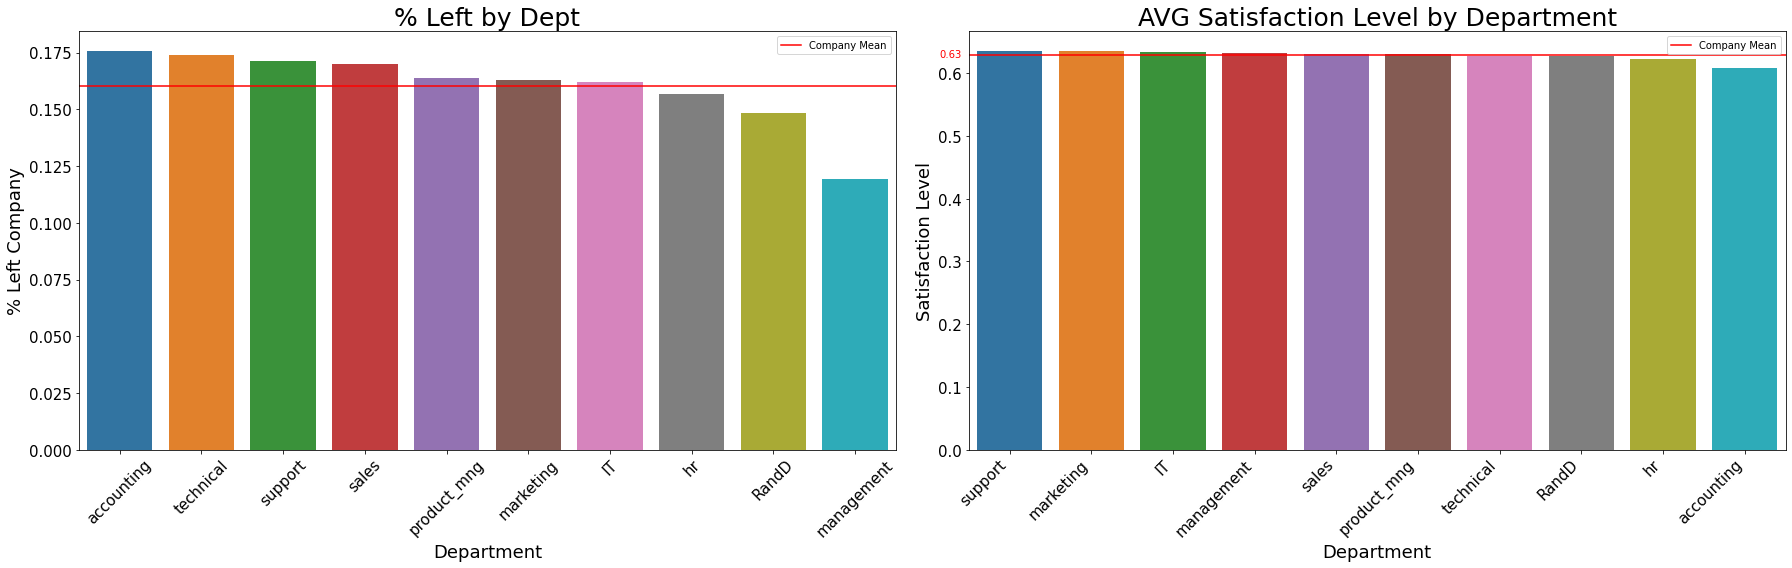

In [7]:
# Department Left vs. Stayed Table

left_dept = df1_left['dept'].value_counts().reset_index()
left_dept.columns = ['dept', 'num_left']
stayed_dept = df1_stayed['dept'].value_counts().reset_index()
stayed_dept.columns = ['dept', 'num_stayed']

left_by_dept = left_dept.merge(stayed_dept['num_stayed'], left_index=True, right_index=True)

left_by_dept['pct_left'] = left_by_dept['num_left'] / (left_by_dept['num_left'] + left_by_dept['num_stayed'])
left_by_dept = left_by_dept.sort_values(by='pct_left',ascending=False).reset_index(drop=True)
left_by_dept['total_emp'] = left_by_dept['num_left'] + left_by_dept['num_stayed']

satis_dept = df1[['satis_lvl','dept']].groupby(['dept'])['satis_lvl'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize = (25,8))

# % Left by Department Bar Plot

fig = sns.barplot(x=left_by_dept['dept'], y=left_by_dept['pct_left'],ax=axes[0])
axes[0].axhline(left_by_dept['pct_left'].mean(),color='r',label='Company Mean')
axes[0].set_title("% Left by Dept",fontsize=25)
axes[0].set_xlabel("Department",fontsize=18)
axes[0].set_ylabel("% Left Company",fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].tick_params(axis='x',labelrotation=45)
axes[0].legend()

df1_no_mgmt = df1[df1['dept'] != 'management']
dept_hrs_sorted = pd.DataFrame(df1.groupby(by='dept').mean()['avg_monthly_hrs']).reset_index()
dept_hrs_sorted = dept_hrs_sorted.sort_values(by=['avg_monthly_hrs'],ascending=False)

# Average Satisfaction Levels by Department

dept_hrs_order = ['accounting','technical','support','sales','product_mng','marketing','IT','hr','RandD','management']
dept_satis_sorted = pd.DataFrame(df1.groupby(by='dept').mean()['satis_lvl']).reset_index()
dept_satis_sorted = dept_satis_sorted.sort_values(by=['satis_lvl'],ascending=False)
dept_satis_hrs = dept_satis_sorted.copy()
dept_satis_hrs['dept'] = pd.Categorical(dept_satis_hrs['dept'],categories=dept_hrs_order)
dept_satis_hrs = dept_satis_hrs.sort_values(by='dept').reset_index(drop=True)
dept_satis_hrs['satis_lvl'] = round(dept_satis_hrs['satis_lvl'],6)
left_by_dept['pct_left'] = round(left_by_dept['pct_left'],6)
left_by_dept = left_by_dept.merge(dept_satis_hrs,how='outer',on='dept')
left_by_dept = left_by_dept.rename(columns={'satis_lvl':'avg_satis_lvl'})

# Add 95% Confidence Intervals to AVG Satisfaction Level point estimates

avg_satis_lvl_CI = pd.DataFrame((df1.groupby(by='dept').std()['satis_lvl']).reset_index())
avg_satis_lvl_CI['dept'] = pd.Categorical(avg_satis_lvl_CI['dept'],categories=dept_hrs_order)
avg_satis_lvl_CI = avg_satis_lvl_CI.sort_values(by='dept').reset_index(drop=True)
avg_satis_lvl_CI = avg_satis_lvl_CI.rename(columns={'satis_lvl':'std_satis_lvl'})
avg_satis_lvl_CI['sqrt_sample_size'] = np.sqrt(left_by_dept['total_emp'])
avg_satis_lvl_CI['est_SE'] = avg_satis_lvl_CI['std_satis_lvl'] / avg_satis_lvl_CI['sqrt_sample_size']

def make_ci_columns(mean_col,est_SE_col):
    CI_list = []
    for x in mean_col: 
        for y in est_SE_col:
            if x == 0 or y == 0:
                CI_list.append(('NaN','NaN'))
            else:
                CI = stats.norm.interval(alpha=0.95, loc=x, scale=y)
        CI_list.append(CI)
    return pd.DataFrame(CI_list,columns=['conf_int_lb','conf_int_ub'],dtype=float)

dept_satis_ci_columns = make_ci_columns(left_by_dept['avg_satis_lvl'],avg_satis_lvl_CI['est_SE'])
left_by_dept = left_by_dept.merge(dept_satis_ci_columns,left_index=True,right_index=True)

# AVG Satisfaction Level by Department Bar Plot

fig = sns.barplot(x=dept_satis_sorted['dept'], y=dept_satis_sorted['satis_lvl'],ax=axes[1])
axes[1].axhline(df1['satis_lvl'].mean(),color='r',label='Company Mean')
axes[1].set_title("AVG Satisfaction Level by Department",fontsize=25)
axes[1].set_xlabel("Department",fontsize=18)
axes[1].set_ylabel("Satisfaction Level",fontsize=18)
trans = transforms.blended_transform_factory(axes[1].get_yticklabels()[0].get_transform(), axes[1].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[1].text(0,0.6296580768909951, "{:.2f}".format(0.6296580768909951), color="red", transform=trans, ha="right", va="center")
axes[1].legend()
axes[1].tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

display(left_by_dept.style.\
        applymap(lambda x: "background-color: red" if (x == 'accounting') | (x == 0.175523) | (x == 0.607939) else None).\
        applymap(lambda x: "font-weight: bold" if (x == 'accounting') | (x == 0.175523) | (x == 0.607939) else None).\
        format("{:.3f}",subset=['pct_left','avg_satis_lvl','conf_int_lb','conf_int_ub']))

### Observations/Insights

Sales, Technical, and Support are the largest departments in the company with 3239, 2244, and 1821 employees respectively. Management has the fewest employees (436).

All departments, with the exception of Accounting, have about the same average satisfaction level and the company's average satisfaction level is about 63% (which is low).

**Management had the lowest percentage of employees who left the company compared to other departments.** 

**Accounting had the lowest average satisfaction level (60.8%) *(95% CI [0.587,0.629])* and the highest percentage of employees leave the company (17.6%) compared to other departments.***

**This finding is not conclusive (see Hypothesis Test results below and overlapping Confidence Intervals in the table above)*

In [82]:
# Hypothesis Test to determine validity of the statement that Accounting had the lowest average satisfaction level 
# (60.8%) and the highest percentage of employees leave the company (17.6%) compared to other departments.

# •	H0: the mean satisfaction level for Accounting is >= the mean for HR (the next lowest mean calculated 
#       satisfaction level)
# •	Ha: the mean satisfaction level for Accounting is < the mean for HR

# Significance Level (all tests): 5%

# Accounting Satisfaction Test

accounting_satis = df1[df1['dept'] == 'accounting']
accounting_satis = accounting_satis[['satis_lvl']]
hr_satis = df1[df1['dept'] == 'hr']
hr_satis = hr_satis[['satis_lvl']]

tstat, pvalue = stats.ttest_ind(a=accounting_satis, b=hr_satis, alternative='less', equal_var=False)

print('\033[1mAccounting Satis Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# Accounting % Left Test

# •	H0: p <= 0.174 (the proportion of Accounting that left the company is equal to 0.174 (the next highest 
#                  calculated proportion))
# •	Ha: p > 0.174 (the proportion of Accounting that left the company is greater than 0.174)

tstat,pvalue = proportions_ztest(count=109, nobs=(109+512), value=0.174, alternative='larger', prop_var=False)

print('\033[1mAccounting % Left Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# Hypothesis Test to determine validity of the statement that Management had the lowest percentage of employees 
# who left the company compared to other departments.

# Management % Left Test

# •	H0: p >= 0.148 (the proportion of Management that left the company is equal to 0.148 (the next lowest 
#                  calculated proportion))
# •	Ha: p < 0.148 (the proportion of Management that left the company is less than 0.148)

tstat,pvalue = proportions_ztest(count=52, nobs=(52+384), value=0.148, alternative='smaller', prop_var=False)

print('\033[1mManagement % Left Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

Accounting Satis Test Result:
T-Statistic: [-1.00704146]  p-value: [0.15705731]


Accounting % Left Test Result:
T-Statistic: 0.09979038703507608  p-value: 0.4602553699948356


Management % Left Test Result:
T-Statistic: -1.8512186007309628  p-value: 0.03206905542371921


### Hypothesis Testing Result

**Accounting Tests.** Both p-values from the tests are greater than the significance level (0.05) so we fail to reject the null hypotheses.

**Null Hypotheses:**
- H0: the mean satisfaction level for Accounting is >= the mean for HR (the next lowest mean calculated satisfaction level)
- H0: the proportion of Accounting that left the company is equal to 0.174 (the next highest calculated proportion)

**Management Test.** The p-value from the test is less than the significance level (0.05) so we reject the null hypothesis that the proportion of Management that left the company is equal to 0.148 (the next lowest calculated proportion) in favor of the alternative hypothesis that the proportion of Management that left the company is less than 0.148.

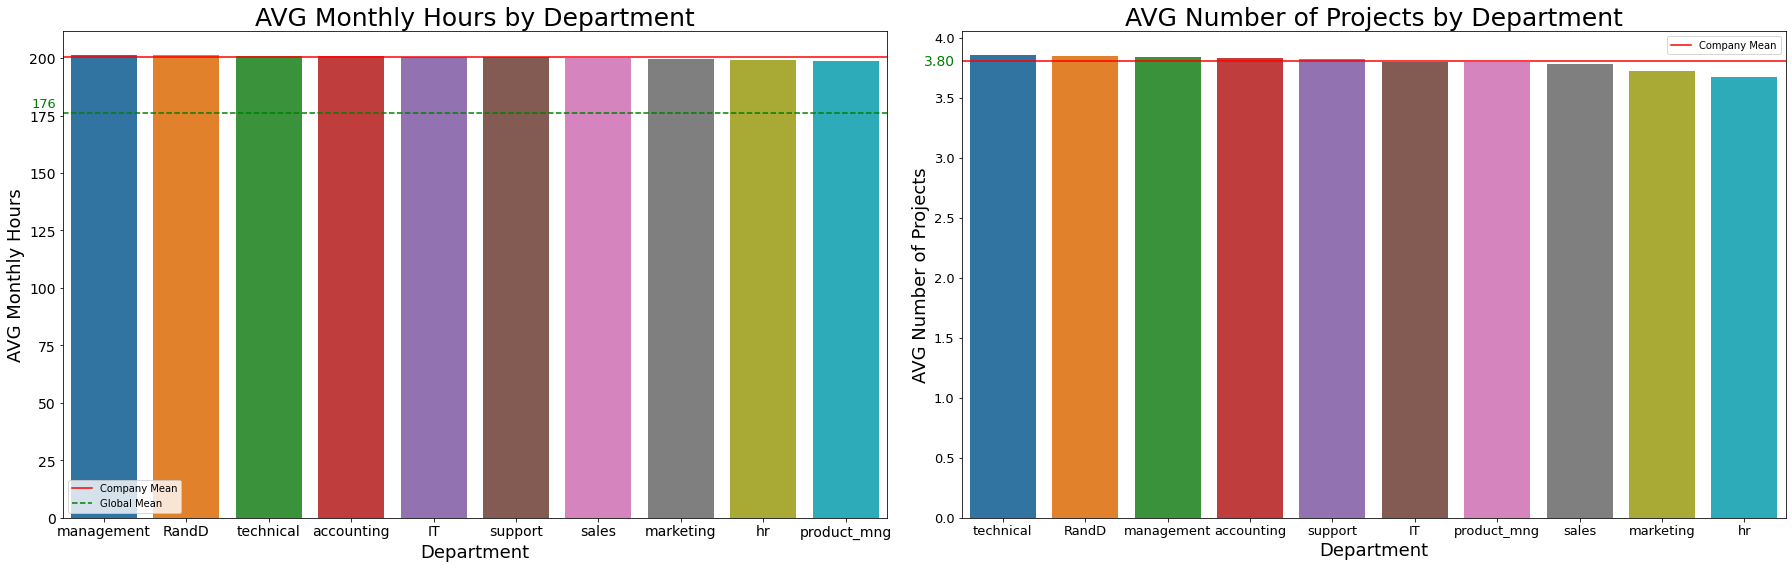

In [8]:
# AVG Monthly Hours by Department Bar Plot

fig, axes = plt.subplots(1, 2, figsize = (25,8))

fig = sns.barplot(x=dept_hrs_sorted['dept'], y=dept_hrs_sorted['avg_monthly_hrs'],ax=axes[0])
axes[0].axhline(df1['avg_monthly_hrs'].mean(),color='r',label='Company Mean')
axes[0].axhline((176),color='g',label='Global Mean',ls='--')
axes[0].set_title("AVG Monthly Hours by Department",fontsize=25)
axes[0].set_xlabel("Department",fontsize=18)
axes[0].set_ylabel("AVG Monthly Hours",fontsize=18)
trans = transforms.blended_transform_factory(axes[0].get_yticklabels()[0].get_transform(), axes[0].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[0].text(0,180, "{:.0f}".format(176), color="green", transform=trans, ha="right", va="center",fontsize=13)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend()

proj_by_dept = df1[['dept','num_projects']].groupby(['dept'])['num_projects'].mean().reset_index()
proj_by_dept = proj_by_dept.sort_values(by=['num_projects'],ascending=False).reset_index(drop=True)
proj_by_dept = proj_by_dept.rename(columns={'num_projects':'avg_num_proj'})

# Add 95% Confidence Intervals to AVG Number of Projects point estimates

avg_dept_proj_CI = pd.DataFrame((df1.groupby(by='dept').std()['num_projects']).reset_index())
avg_dept_proj_CI['dept'] = pd.Categorical(avg_dept_proj_CI['dept'],categories=dept_hrs_order)
avg_dept_proj_CI = avg_dept_proj_CI.sort_values(by='dept').reset_index(drop=True)
avg_dept_proj_CI = avg_dept_proj_CI.rename(columns={'num_projects':'std_num_projects'})
avg_dept_proj_CI['sqrt_sample_size'] = np.sqrt(left_by_dept['total_emp'])
avg_dept_proj_CI['est_SE'] = avg_dept_proj_CI['std_num_projects'] / avg_dept_proj_CI['sqrt_sample_size']
dept_proj_ci_columns = make_ci_columns(proj_by_dept['avg_num_proj'],avg_dept_proj_CI['est_SE'])
proj_by_dept = proj_by_dept.merge(dept_proj_ci_columns,left_index=True,right_index=True)

#display(proj_by_dept)

# AVG Number of Projects by Department Bar Plot

fig = sns.barplot(x=proj_by_dept['dept'], y=proj_by_dept['avg_num_proj'],ax=axes[1])
axes[1].axhline(df1['num_projects'].mean(),color='r',label='Company Mean')
axes[1].set_title("AVG Number of Projects by Department",fontsize=25)
axes[1].set_xlabel("Department",fontsize=18)
axes[1].set_ylabel("AVG Number of Projects",fontsize=18)
trans = transforms.blended_transform_factory(axes[1].get_yticklabels()[0].get_transform(), axes[1].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[1].text(0,3.802852139104328, "{:.2f}".format(3.802852139104328), color="green", transform=trans, ha="right", va="center",fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=13)
axes[1].legend()
plt.tight_layout()
plt.show()

# 95% Confidence Interval for Company AVG Monthly Hours

est_SE = df1['avg_monthly_hrs'].std() / np.sqrt(df1.shape[0])
CI_company_hrs = stats.norm.interval(alpha=0.95, loc=df1['avg_monthly_hrs'].mean(), scale=est_SE)

### Observations/Insights

All departments have about the same average working hours per month and **the company's average hours worked per month (200.5) *(95% CI [199.601359,201.345684])* is about 25 hours higher than the global average of 176 (https://everhour.com/blog/average-working-hours/).**

All departments have about the same average number of projects per employee, with Technical and RandD having the highest (3.86 *(95% CI [3.751974,3.966386])* and 3.85 *(95% CI [3.742938,3.957350])*, respectively) and HR and Marketing having the lowest (3.68 *(95% CI [3.568335,3.782747])* and 3.72 *(95% CI [3.613448,3.827860])*, respectively).

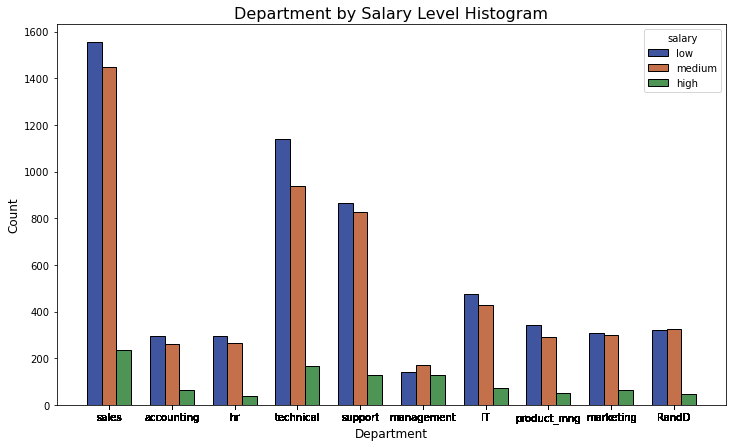

In [9]:
# Department by Salary Level Histogram

plt.figure(figsize=(12,7))
ax = sns.histplot(data=df1, x='dept', 
                  hue='salary',
                  hue_order = ['low','medium','high'],
                  multiple='dodge',
                  discrete=1,
                  shrink=.7,
                  palette='dark')
ax.set_xticks(df1['dept'])
ax.set_xticklabels(df1['dept'])
ax.set_xlabel('Department',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
plt.title('Department by Salary Level Histogram',fontsize=16);
plt.show()

### Observations/Insights

Most departments have similar proportions of low vs. medium vs. high salary levels except for management and RandD. Management has a lower proportion of low salary level and a higher proportion of high salary level. RandD's medium salary level proportion is slightly higher than its low salary level proportion (unlike other depts).

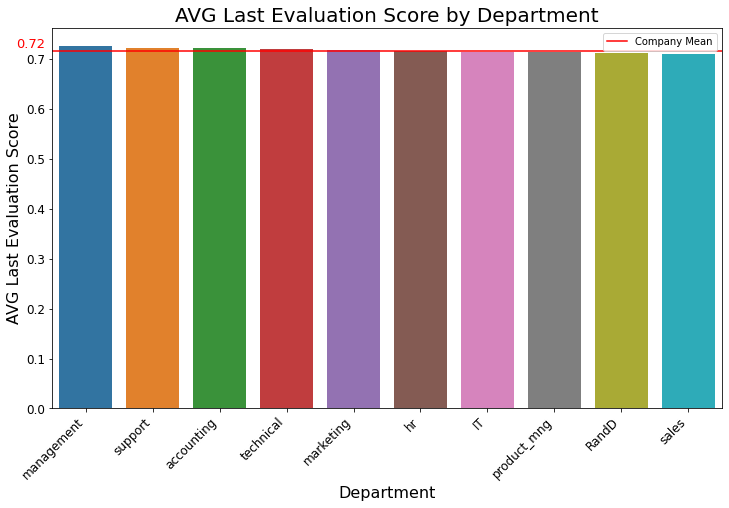

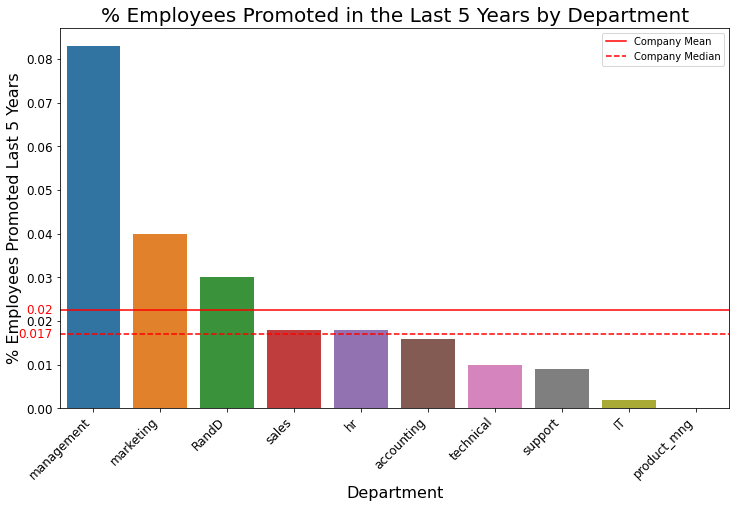

In [10]:
# AVG Last Evaluation Score by Department Table

eval_by_dept = df1[['dept','last_eval']].groupby(['dept'])['last_eval'].mean().reset_index()
eval_by_dept = eval_by_dept.sort_values(by=['last_eval'],ascending=False).reset_index(drop=True)

# AVG Last Evaluation Score by Department Bar Plot

plt.figure(figsize=(12,7))
ax = sns.barplot(x=eval_by_dept['dept'], y=eval_by_dept['last_eval'])
ax.axhline(df1['last_eval'].mean(),color='r',label='Company Mean')
ax.set_title("AVG Last Evaluation Score by Department",fontsize=20)
ax.set_xlabel("Department",fontsize=16)
ax.set_ylabel("AVG Last Evaluation Score",fontsize=16)
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
ax.text(0,0.7166825118839051, "{:.2f}".format(0.7166825118839051), color="red", transform=trans, ha="right", va="bottom",fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45, horizontalalignment='right')
ax.legend()
plt.show()

# Percentage Promoted in the Last 5 Years by Department Table

promoted_by_dept = df1[df1['promotion_last_5yrs'] == 1]
promoted_by_dept = promoted_by_dept.groupby(['dept'])['promotion_last_5yrs'].count().reset_index()
promoted_by_dept = promoted_by_dept.sort_values(by=['promotion_last_5yrs'],ascending=False).reset_index(drop=True)
promoted_by_dept = promoted_by_dept.rename(columns={'promotion_last_5yrs':'promoted_last_5yrs'})
not_promoted_by_dept = df1[df1['promotion_last_5yrs'] == 0]
not_promoted_by_dept = not_promoted_by_dept.groupby(['dept'])['promotion_last_5yrs'].count().reset_index()
dept_order = ['sales','management','marketing','technical','RandD','support','hr','accounting','IT','product_mng']
not_promoted_by_dept['dept'] = pd.Categorical(not_promoted_by_dept['dept'],categories=dept_order)
not_promoted_by_dept = not_promoted_by_dept.sort_values(by='dept').reset_index(drop=True)
not_promoted_by_dept = not_promoted_by_dept.rename(columns={'promotion_last_5yrs':'not_promoted_last_5yrs'})
df1[df1['dept'] == 'product_mng'].shape
not_promoted_by_dept = not_promoted_by_dept.fillna('product_mng')
promoted_by_dept = promoted_by_dept.merge(not_promoted_by_dept,how='outer',on='dept')
promoted_by_dept = promoted_by_dept.fillna(0)
promoted_by_dept['promoted_last_5yrs'] = promoted_by_dept['promoted_last_5yrs'].astype(int)
promoted_by_dept['%_promoted'] = round(promoted_by_dept['promoted_last_5yrs'] / (promoted_by_dept['promoted_last_5yrs'] + promoted_by_dept['not_promoted_last_5yrs']),3)
promoted_by_dept = promoted_by_dept.sort_values(by='%_promoted',ascending=False)

# Percentage Promoted in the Last 5 Years by Department Bar Plot

plt.figure(figsize=(12,7))
ax = sns.barplot(x=promoted_by_dept['dept'], y=promoted_by_dept['%_promoted'])
ax.axhline(promoted_by_dept['%_promoted'].mean(),color='r',label='Company Mean')
ax.axhline(promoted_by_dept['%_promoted'].median(),color='r',label='Company Median',ls='--')
ax.set_title("% Employees Promoted in the Last 5 Years by Department",fontsize=20)
ax.set_xlabel("Department",fontsize=16)
ax.set_ylabel("% Employees Promoted Last 5 Years",fontsize=16)
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
ax.text(0,0.0226, "{:.2f}".format(0.0226), color="red", transform=trans, ha="right", va="center",fontsize=12)
ax.text(0,0.017, "{:.3f}".format(0.017), color="red", transform=trans, ha="right", va="center",fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45, horizontalalignment='right')
ax.legend()
plt.show()

### Observations/Insights

All departments have about the same average last evaluation scores, ranging from Sales with the lowest (0.71) to Management with the highest (~0.73).

**Management had by far the highest percentage of employees promoted in the last 5 years (8.3%) compared to other departments, which range from 0% - 4%.**

**IT and Product Management had the lowest percentages of employees promoted in the last 5 years with 0.2% and 0%, respectively. Product Management has not had any employees promoted in the last 5 years.**

In [80]:
# Hypothesis Test to determine validity of the statement that Management had by far the highest percentage of 
# employees promoted in the last 5 years (8.3%) compared to other departments.

# •	H0: p <= 0.04 (the proportion of management promoted in the last 5 years is equal to 0.04 (the next highest 
#                  calculated proportion))
# •	Ha: p > 0.04 (the proportion of management promoted in the last 5 years is greater than 0.04)

# Significance Level: 5%

tstat,pvalue = proportions_ztest(count=36, nobs=(36+400), value=0.04, alternative='larger', prop_var=False)

print('\033[1mManagement Promotion Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

Management Promotion Test Result:
T-Statistic: 3.229534813422997  p-value: 0.0006199589222638726


### Hypothesis Testing Result

The p-value is less than the significance level of 0.05 so we reject the null hypothesis that the proportion of management promoted in the last 5 years is less than or equal to 0.04 (the next highest calculated proportion) in favor of the alternative hypothesis that the proportion of management promoted in the last 5 years is greater than 0.04.

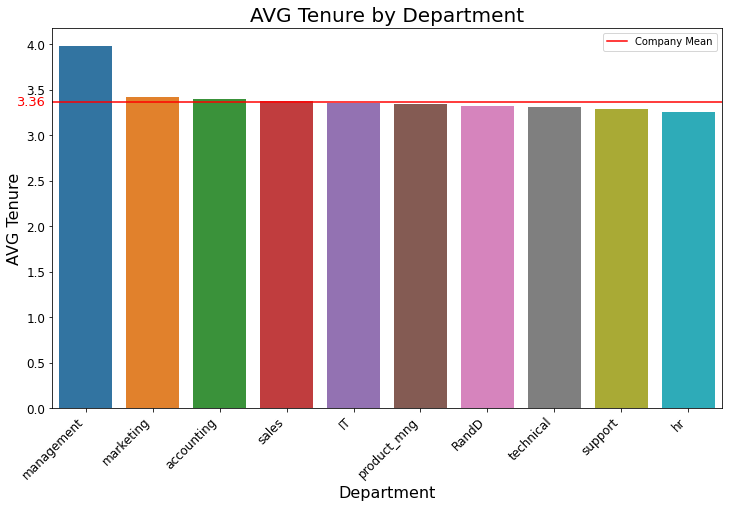

In [11]:
# AVG Tenure by Department Table

tenure_by_dept = df1[['dept','tenure']].groupby(['dept'])['tenure'].mean().reset_index()
tenure_by_dept = tenure_by_dept.sort_values(by=['tenure'],ascending=False).reset_index(drop=True)
tenure_by_dept = tenure_by_dept.rename(columns={'tenure':'avg_tenure'})

# Add 95% Confidence Intervals to AVG Tenure point estimates

avg_dept_tenure_CI = pd.DataFrame((df1.groupby(by='dept').std()['tenure']).reset_index())
avg_dept_tenure_CI['dept'] = pd.Categorical(avg_dept_proj_CI['dept'],categories=dept_hrs_order)
avg_dept_tenure_CI = avg_dept_tenure_CI.sort_values(by='dept').reset_index(drop=True)
avg_dept_tenure_CI = avg_dept_tenure_CI.rename(columns={'tenure':'std_tenure'})
avg_dept_tenure_CI['sqrt_sample_size'] = np.sqrt(left_by_dept['total_emp'])
avg_dept_tenure_CI['est_SE'] = avg_dept_tenure_CI['std_tenure'] / avg_dept_tenure_CI['sqrt_sample_size']
dept_tenure_ci_columns = make_ci_columns(tenure_by_dept['avg_tenure'],avg_dept_tenure_CI['est_SE'])
tenure_by_dept = tenure_by_dept.merge(dept_tenure_ci_columns,left_index=True,right_index=True)

#display(tenure_by_dept)

# AVG Tenure by Department Bar Plot

plt.figure(figsize=(12,7))
ax = sns.barplot(x=tenure_by_dept['dept'], y=tenure_by_dept['avg_tenure'])
ax.axhline(df1['tenure'].mean(),color='r',label='Company Mean')
ax.set_title("AVG Tenure by Department",fontsize=20)
ax.set_xlabel("Department",fontsize=16)
ax.set_ylabel("AVG Tenure",fontsize=16)
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
ax.text(0,3.3648569760653824, "{:.2f}".format(3.3648569760653824), color="red", transform=trans, ha="right", va="center",fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45, horizontalalignment='right')
ax.legend()
plt.show()

### Observations/Insights

Management has the highest average tenure compared to other departments at 3.98 years *(95% CI [3.870109,4.093194])* and HR has the lowest average tenure at 3.26 years *(95% CI [3.144697,3.367782])*.

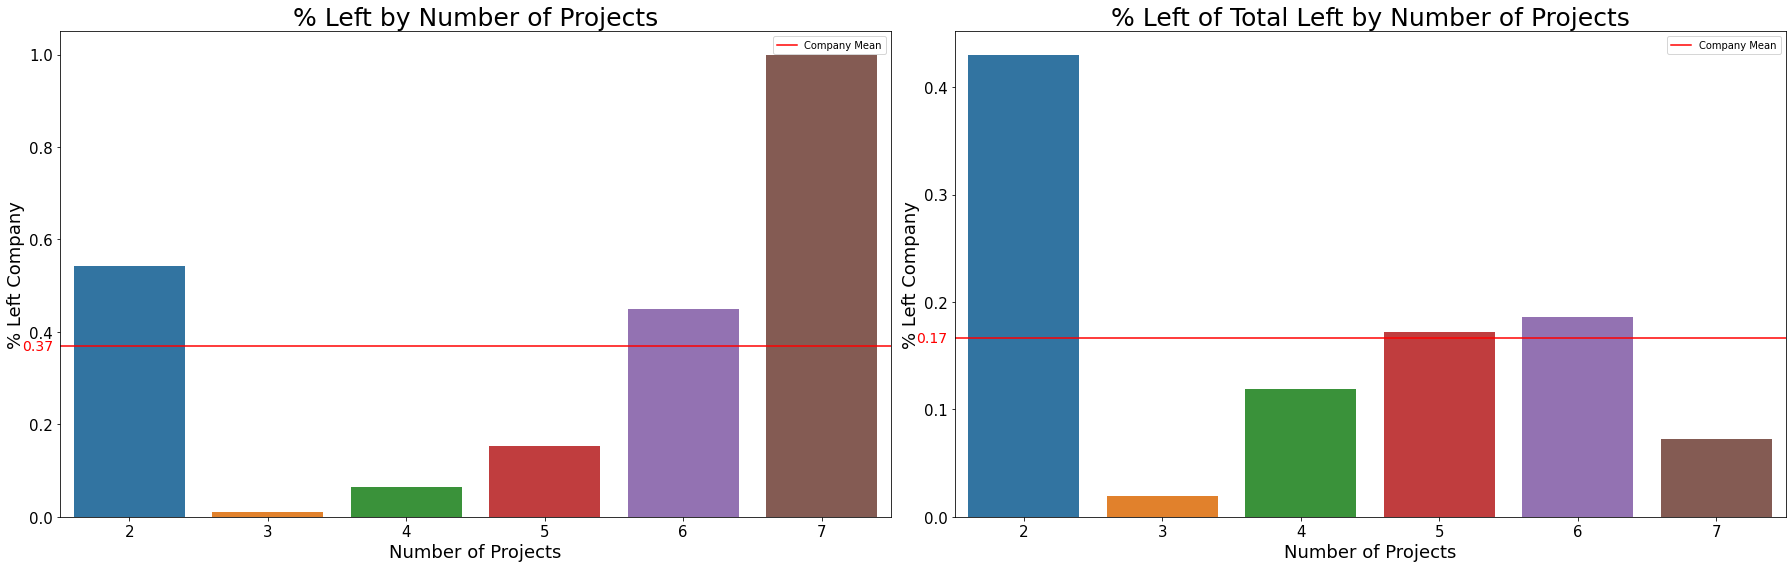

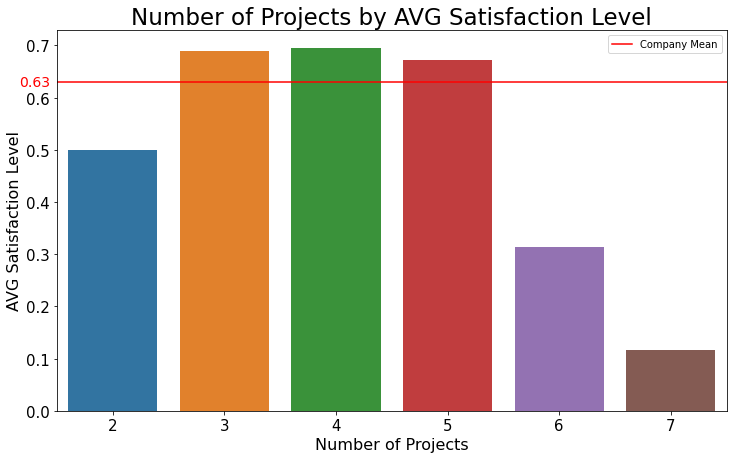

In [12]:
# Number of Projects by Left vs. Stayed Table

left_numprojects = df1_left['num_projects'].value_counts().reset_index()
left_numprojects.columns = ['num_projects', 'num_left']
left_numprojects = left_numprojects.sort_values(by='num_projects',ascending=True).reset_index(drop=True)
stayed_numprojects = df1_stayed['num_projects'].value_counts().reset_index()
stayed_numprojects.columns = ['num_projects', 'num_stayed']
stayed_numprojects = stayed_numprojects.sort_values(by='num_projects',ascending=True).reset_index(drop=True)

left_by_numprojects = left_numprojects.merge(stayed_numprojects['num_stayed'], how='outer',left_index=True,right_index=True)
left_by_numprojects = left_by_numprojects.fillna(0)

total_emp = 11991
proj_7_left = df1[(df1['num_projects'] == 7) & (df1['left'] == 1)]
proj_7_stayed = df1[(df1['num_projects'] == 7) & (df1['left'] == 0)]

left_by_numprojects['%_left'] = left_by_numprojects['num_left'] / (left_by_numprojects['num_left'] + left_by_numprojects['num_stayed'])
left_by_numprojects['total_emp'] = left_by_numprojects['num_left'] + left_by_numprojects['num_stayed']
left_by_numprojects['total_emp_pct'] = left_by_numprojects['total_emp'] / total_emp
left_by_numprojects['pct_left_total_left'] = left_by_numprojects['num_left'] / left_by_numprojects['num_left'].sum()
left_by_numprojects['weighted_pct_left'] = (left_by_numprojects['num_left'] * left_by_numprojects['total_emp_pct']) / left_by_numprojects['num_left'].sum()
left_by_numprojects = left_by_numprojects.sort_values(by=['num_projects'],ascending=True).reset_index(drop=True)
proj_satis = df1[['num_projects','satis_lvl']].groupby(['num_projects'])['satis_lvl'].mean().reset_index()
left_by_numprojects = left_by_numprojects.merge(proj_satis,how='outer',on='num_projects')
left_by_numprojects['satis_lvl'] = round(left_by_numprojects['satis_lvl'],6)
left_by_numprojects = left_by_numprojects.rename(columns={'satis_lvl':'avg_satis_lvl'})

# Add 95% Confidence Intervals to AVG Satisfaction Level point estimates

avg_satis_lvl_CI = pd.DataFrame(df1.groupby(by='num_projects').std()['satis_lvl'].reset_index())
avg_satis_lvl_CI = avg_satis_lvl_CI.rename(columns={'satis_lvl':'std_satis_lvl'})
avg_satis_lvl_CI['sqrt_sample_size'] = np.sqrt(left_by_numprojects['total_emp'])
avg_satis_lvl_CI['est_SE'] = avg_satis_lvl_CI['std_satis_lvl'] / avg_satis_lvl_CI['sqrt_sample_size']
proj_satis_ci_columns = make_ci_columns(left_by_numprojects['avg_satis_lvl'],avg_satis_lvl_CI['est_SE'])
left_by_numprojects = left_by_numprojects.merge(proj_satis_ci_columns,left_index=True,right_index=True)

display(left_by_numprojects.style.\
        applymap(lambda x: "background-color: red" if (x == 0) | (x == 0.499071) | (x == 0.314673) | (x == 0.116690) | (x == 2) | (x == 6) | (x == 7) else None).\
        applymap(lambda x: "font-weight: bold" if (x == 0) | (x == 0.499071) | (x == 0.314673) | (x == 0.116690) | (x == 2) | (x == 6) | (x == 7) else None).\
        format("{:.3f}",subset=['%_left','total_emp_pct','pct_left_total_left','weighted_pct_left','conf_int_lb','conf_int_ub','avg_satis_lvl']).\
        format("{:.0f}",subset=['num_stayed','total_emp']))

fig, axes = plt.subplots(1, 2, figsize = (25,8))

# % Left by Number of Projects Bar Plot

fig = sns.barplot(x=left_by_numprojects['num_projects'], y=left_by_numprojects['%_left'],ax=axes[0])
axes[0].axhline(left_by_numprojects['%_left'].mean(),color='r',label='Company Mean')
trans = transforms.blended_transform_factory(axes[0].get_yticklabels()[0].get_transform(), axes[0].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[0].text(0,0.3699311908140899, "{:.2f}".format(0.3699311908140899), color="red", transform=trans, ha="right", va="center",fontsize=14)
axes[0].set_title("% Left by Number of Projects",fontsize=25)
axes[0].set_xlabel("Number of Projects",fontsize=18)
axes[0].set_ylabel("% Left Company",fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].legend()

# % Left of Total Left by Number of Projects Bar Plot

fig= sns.barplot(x=left_by_numprojects['num_projects'], y=left_by_numprojects['pct_left_total_left'],ax=axes[1])
axes[1].axhline(left_by_numprojects['pct_left_total_left'].mean(),color='r',label='Company Mean')
trans = transforms.blended_transform_factory(axes[1].get_yticklabels()[0].get_transform(), axes[1].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[1].text(0,0.16666666666666666, "{:.2f}".format(0.16666666666666666), color="red", transform=trans, ha="right", va="center",fontsize=14)
axes[1].set_title("% Left of Total Left by Number of Projects",fontsize=25)
axes[1].set_xlabel("Number of Projects",fontsize=18)
axes[1].set_ylabel("% Left Company",fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].legend()
plt.tight_layout()
plt.show()

# AVG Satisfaction Level by Number of Projects Bar Plot

plt.figure(figsize=(12,7))
ax = sns.barplot(x=left_by_numprojects['num_projects'], y=left_by_numprojects['avg_satis_lvl'])
ax.axhline(df1['satis_lvl'].mean(),color='r',label='Company Mean')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
ax.text(0,0.6296580768909951, "{:.2f}".format(0.6296580768909951), color="red", transform=trans, ha="right", va="center",fontsize=14)
ax.set_title("Number of Projects by AVG Satisfaction Level",fontsize=23)
ax.set_xlabel("Number of Projects",fontsize=16)
ax.set_ylabel("AVG Satisfaction Level",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
plt.show()

### Observations/Insights

**All employees who had 7 projects left the company. About 54% of employees who had 2 projects left and about 45% of employees who had 6 projects left. These groups of employees (especially employees with 6 and 7 projects) had the lowest average satisfaction levels in the company, ranging from ~0.12 *(95% CI [0.105,0.129])* to ~0.50 *(95% CI [0.487,0.511])*.**

Employees who had 3-5 projects had the lowest percentages of employees leave the company (as a percentage of other employees who had the same number of projects) as well as had the highest average satisfaction levels in the company, ranging from ~0.67 *(95% CI [0.659,0.683])* to ~0.70 *(95% CI [0.682,0.706])*.

Employees who had 2 projects made up the highest percentage of total employees who left the company at about 43%.

**It's likely that all employees who had 7 projects left the company because they were overloaded with work and that so many employees with 2 projects left because they were underperforming. This needs to be confirmed.**

In [66]:
# Hypothesis Test to determine the validity of the statement that employees who had 6 or 7 projects had the 
# lowest average satisfaction levels in the company.

# •	H0: the mean satisfaction levels for employees with 6 and 7 projects are >= the mean for employees with 2 projects
#       (the next lowest calculated mean satisfaction level)
# •	Ha: the mean satisfaction levels for employees with 6 and 7 projects are < the mean for employees with 2 projects

# Significance Level (all tests): 5%

# 6 Projects Satis Test

six_projects_satis = df1[df1['num_projects'] == 6]
six_projects_satis = six_projects_satis[['satis_lvl']]
two_projects_satis = df1[df1['num_projects'] == 2]
two_projects_satis = two_projects_satis[['satis_lvl']]
      
tstat, pvalue = stats.ttest_ind(a=six_projects_satis, b=two_projects_satis, alternative='less', equal_var=False)

print('\033[1m6 Projects Satis Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# 7 Projects Satis Test

seven_projects_satis = df1[df1['num_projects'] == 7]
seven_projects_satis = seven_projects_satis[['satis_lvl']]
      
tstat, pvalue = stats.ttest_ind(a=seven_projects_satis, b=two_projects_satis, alternative='less', equal_var=False)

print('\033[1m7 Projects Satis Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

6 Projects Satis Test Result:
T-Statistic: [-17.60154764]  p-value: [4.08845449e-62]


7 Projects Satis Test Result:
T-Statistic: [-50.18579597]  p-value: [1.35307911e-153]


### Hypothesis Testing Result

The p-values from both tests are less than the significance level of 0.05 so we reject the null hypothesis that the mean satisfaction levels for employees with 6 and 7 projects are >= the mean for employees with 2 projects (the next lowest calculated mean satisfaction level) in favor of the alternative hypothesis that the mean satisfaction levels for employees with 6 and 7 projects are < the mean for employees with 2 projects.

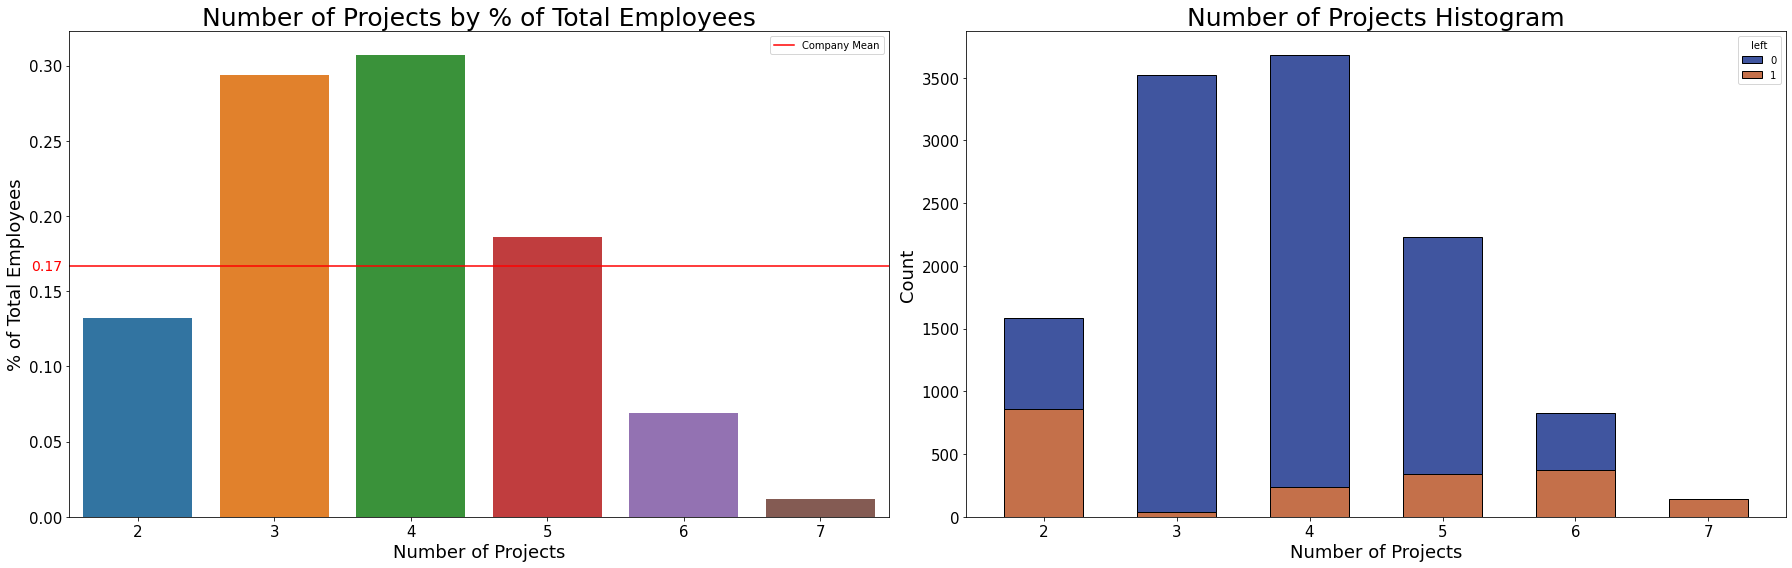

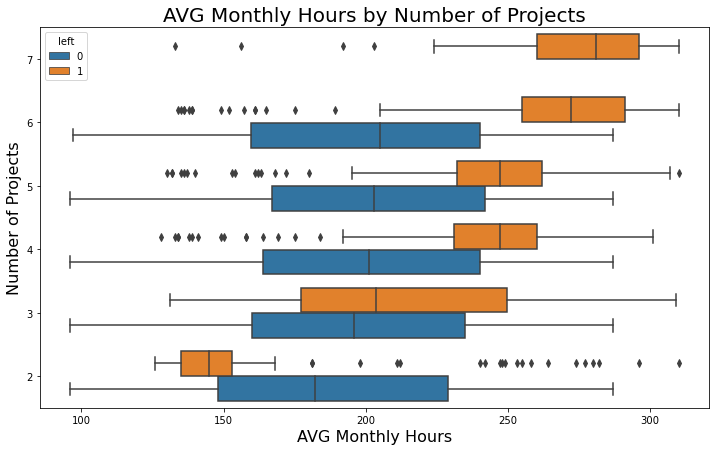

In [13]:
# Number of Projects by % of Total Employees Bar Plot

fig, axes = plt.subplots(1, 2, figsize = (25,8))

fig = sns.barplot(x=left_by_numprojects['num_projects'], y=left_by_numprojects['total_emp_pct'],ax=axes[0])
axes[0].axhline(left_by_numprojects['total_emp_pct'].mean(),color='r',label='Company Mean')
trans = transforms.blended_transform_factory(axes[0].get_yticklabels()[0].get_transform(), axes[0].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[0].text(0,0.16666666666666666, "{:.2f}".format(0.16666666666666666), color="red", transform=trans, ha="right", va="center",fontsize=14)
axes[0].set_title("Number of Projects by % of Total Employees",fontsize=25)
axes[0].set_xlabel("Number of Projects",fontsize=18)
axes[0].set_ylabel("% of Total Employees",fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].legend()

# Number of Projects Histogram

fig = sns.histplot(data=df1, x='num_projects', 
                  hue='left',
                  multiple='stack',
                  discrete=1,
                  shrink=.6,
                  palette='dark',
                  ax=axes[1])
axes[1].set_title('Number of Projects Histogram',fontsize=25);
axes[1].set_xlabel('Number of Projects',fontsize=18);
axes[1].set_ylabel('Count',fontsize=18);
axes[1].tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show();

# Number of Projects by AVG Monthly Hours Boxplot

plt.figure(figsize=(12,7))
ax = sns.boxplot(x=df1['avg_monthly_hrs'],y=df1['num_projects'],hue=df1['left'],orient="h");
plt.title('AVG Monthly Hours by Number of Projects',fontsize=20);
plt.xlabel('AVG Monthly Hours',fontsize=16);
plt.ylabel('Number of Projects',fontsize=16);
ax.invert_yaxis()
plt.show()

### Observations/Insights

A majority of the company's employees had either 3 or 4 projects. Employees who had 3 projects had the lowest percentage of employees who left the company, closely followed by employees who had 4 projects. 3-4 projects might be the ideal number of projects for most employees to maximize employee satisfaction.

**AVG Monthly Hours.** Overall, there is a general trend that employees who left the company spent more hours working with each addition of a new project whereas those employees who stayed at the company overall spent about the same number of hours working with each addition of a new project. It would be worthwhile to find out what the employees who stayed are doing differently to spend less hours with the same number of projects. This could provide insight into who is able to handle more projects skillfully and when to give more or fewer projects to an employee.

Unlike the groups of employees who had 3+ projects, **the employees with 2 projects who left worked significantly fewer hours overall than those employees with 2 projects who stayed. It is possible that a majority of this group of employees who left were underperformers who were fired.**

### Recommendation

<span style='background :yellow' >**Project Workload.** 

<span style='background :yellow' >Managers should strive to assign 3-4 projects to a majority of their employees and should not assign more than 5 projects to an employee unless that employee and his/her manager is sure they can handle it without unduly increasing their work hours.

<span style='background :yellow' >Managers should closely monitor how their employees are handling their project workload on a regular basis. If it becomes apparent that an employee is having to consistently spend significantly more time working with additional project workload, it may be the manager's best interest to cut back that employee's workload and redistribute projects until that employee is able to handle more without increasing their work hours.</span>

### Recommendation

<span style='background :yellow' >**Job Candidate Screening.** 

<span style='background :yellow' >Recruiters and hiring managers would do well to thoroughly screen job candidates before hiring them to weed out potential underperformers. Do the job candidates have strong work ethic and are able to efficiently get results? Do they have the knowledge/skills/experience necessary to be successful in their hired role? Will they be committed to the company's success?

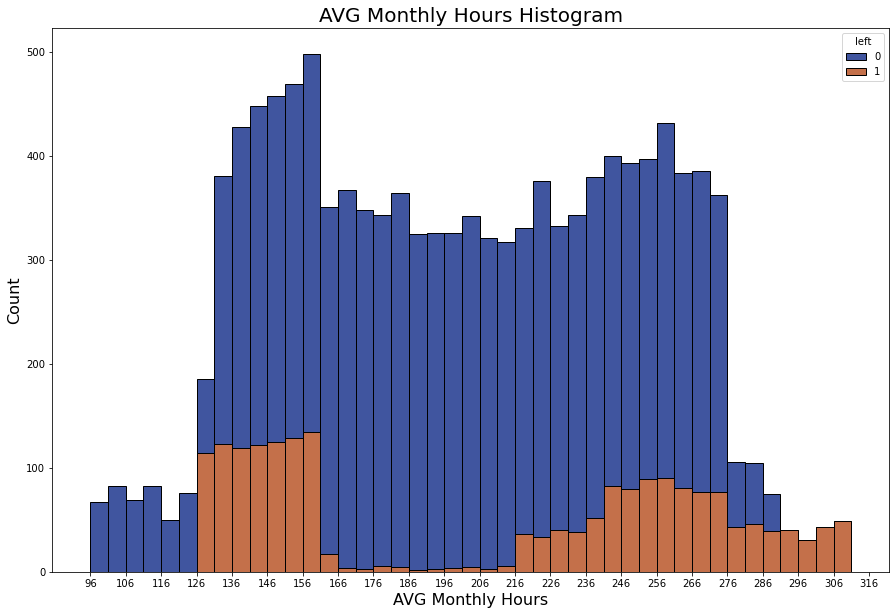

In [14]:
# AVG Monthly Hours by Left vs. Stayed Table (hidden)

left_monthlyhrs = df1_left['avg_monthly_hrs'].value_counts().reset_index()
left_monthlyhrs.columns = ['avg_monthly_hrs', 'num_left']
stayed_monthlyhrs = df1_stayed['avg_monthly_hrs'].value_counts().reset_index()
stayed_monthlyhrs.columns = ['avg_monthly_hrs', 'num_stayed']

left_by_monthlyhrs = left_monthlyhrs.merge(stayed_monthlyhrs, how='outer', on=['avg_monthly_hrs'])
left_by_monthlyhrs = left_by_monthlyhrs.fillna(0)
left_by_monthlyhrs = left_by_monthlyhrs.sort_values(by=['avg_monthly_hrs'], ascending=True).reset_index(drop=True)
left_by_monthlyhrs['total_emp'] = left_by_monthlyhrs['num_left'] + left_by_monthlyhrs['num_stayed']
left_by_monthlyhrs['total_emp_pct'] = left_by_monthlyhrs['total_emp'] / total_emp
left_by_monthlyhrs['pct_left_total_left'] = left_by_monthlyhrs['num_left'] / left_by_monthlyhrs['num_left'].sum()

unique_hrs = set(df1['avg_monthly_hrs'])

# AVG Monthly Hours Histogram

plt.figure(figsize=(15,10))
ax = sns.histplot(x=df1['avg_monthly_hrs'], hue=df1['left'],multiple='stack',palette='dark',
                 binwidth=5)
ax.set_title("AVG Monthly Hours Histogram",fontsize=20)
ax.set_xlabel("AVG Monthly Hours",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
ax.set_xticks(range(96,317,10));
plt.show()

### Observations/Insights

**Most employees who left were either working on the lower end of the range (126-160 hours per month) or on the higher end of the range (216-310 hours per month).** It's possible that the employees who left who were working on the lower end of the range knew they were going to leave soon and purposely worked fewer hours. It's also possible that the employees who left who were working on the higher end of the range left because they were being overworked.

The bulk of the employees who stayed were working between about 130 and 270 hours per month. The highest spike in the distribution of employees who stayed occurs around 145-160 hours, which reduces approximately to the standard 8-hour workday.

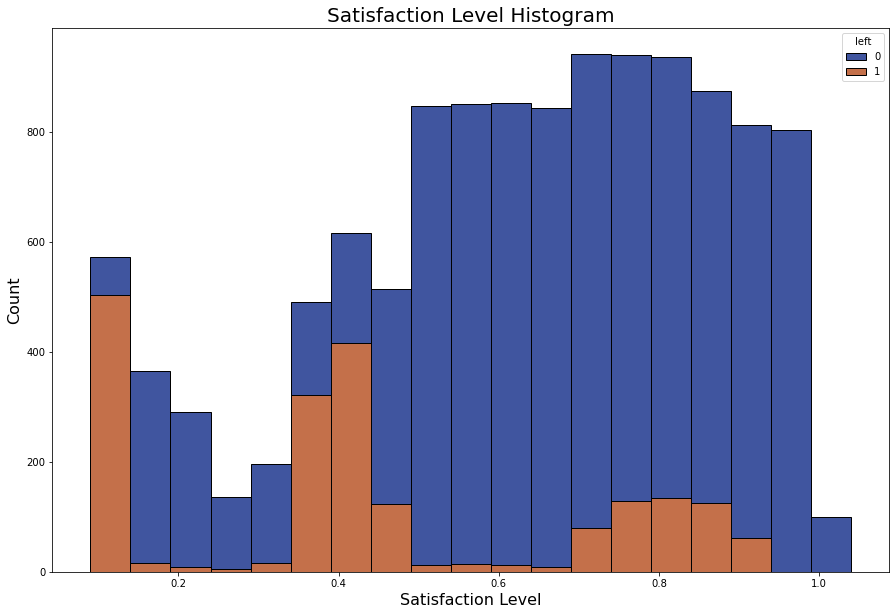

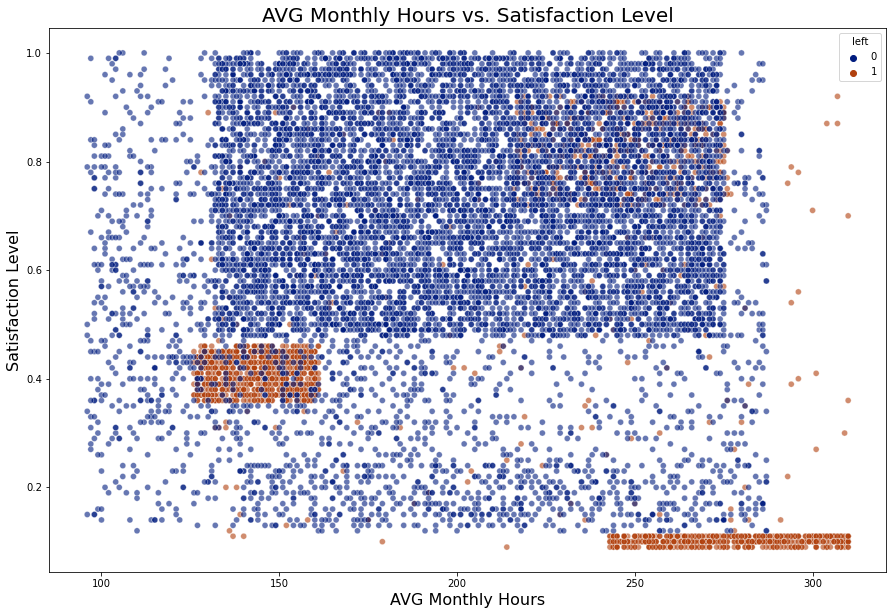

In [15]:
# Satisfaction Level by Left vs. Stayed Table (hidden)

left_satislvl = df1_left['satis_lvl'].value_counts().reset_index()
left_satislvl.columns = ['satis_lvl', 'num_left']
left_satislvl = left_satislvl.sort_values(by=['satis_lvl'], ascending=True).reset_index(drop=True)

stayed_satislvl = df1_stayed['satis_lvl'].value_counts().reset_index()
stayed_satislvl.columns = ['satis_lvl', 'num_stayed']
stayed_satislvl = stayed_satislvl.sort_values(by=['satis_lvl'], ascending=True).reset_index(drop=True)

left_by_satislvl = left_satislvl.merge(stayed_satislvl, how = 'outer', on=['satis_lvl'])
left_by_satislvl = left_by_satislvl.sort_values(by=['satis_lvl'], ascending=True).reset_index(drop=True)
left_by_satislvl['total_emp'] = left_by_satislvl['num_left'] + left_by_satislvl['num_stayed']
left_by_satislvl['total_emp_pct'] = left_by_satislvl['total_emp'] / total_emp
left_by_satislvl['pct_left_total_left'] = left_by_satislvl['num_left'] / left_by_satislvl['num_left'].sum()

# Satisfaction Level Histogram

plt.figure(figsize=(15,10))
ax = sns.histplot(x=df1['satis_lvl'], hue=df1['left'],multiple='stack',palette='dark',
                 binwidth=.05)
ax.set_title("Satisfaction Level Histogram",fontsize=20)
ax.set_xlabel("Satisfaction Level",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
plt.show()

# AVG Monthly Hrs vs. Satisfaction Level Scatterplot

plt.figure(figsize=(15,10))
fig = sns.scatterplot(data=df1, x='avg_monthly_hrs', y='satis_lvl',hue='left',palette = 'dark',alpha=.6)
fig.set_xlabel("AVG Monthly Hours",fontsize=16)
fig.set_ylabel("Satisfaction Level",fontsize=16)
fig.set_title("AVG Monthly Hours vs. Satisfaction Level",fontsize=20)
plt.show()

### Observations/Insights

**Histogram.** The satisfaction levels with greatest number of employees who left the company were around 0.1 and 0.4-0.5 (which are low) and the next greatest number of employees who left the company occured at satisfaction levels between about 0.7 and 0.9. It makes sense that the greatest number of employees who left occurred at low satisfaction levels. It is unclear why the employees at the higher satisfaction levels left. They may have been satisfied in their work at the time but just found opportunities elsewhere that were the next best step for them in their career. This could be clarified from employee exit interviews.

Of the employees who stayed at the company, the bulk of them had satisfaction levels between about 0.5 and 0.95 (the upper end of the range). A good satisfaction level would probably be at least 0.8, but a lot of employees who stayed were between 0.5 and 0.8. A lot of employees who aren't particularly satisfied may stay in their job because they feel they don't have a better opportunity elsewhere, have been with the company for a long time and don't want to introduce change/instability into their life (change is uncomfortable), are hopeful that things will get better, or other reasons.

**AVG Monthly Hours.** The scatterplot above further supports the theory from the AVG Monthly Hours histogram. There appear to be 3 clusters of employees who left. One cluster was working about 130-160 hours per month and is around 0.4 satisfaction level. This group of employees possibly knew they were going to quit soon and were deliberately working fewer hours. This plot adds the dimension of having a low satisfaction level to that group. Next, there is a cluster of employees who left that were working around 240-310 hours per month and is around a 0.1 satisfaction level. Similarly, this plot adds the low satisfaction level to the same group identified in the AVG Monthly Hours histogram above. This group of employees who left had the lowest satisfaction level of all employees in the company. This further supports the theory that they were being overworked. The third cluster of employees who left occurs around 220-270 hours worked per month but the satisfaction level is higher, around 0.7 - 0.9. As mentioned previously, these employees may have been satisfied in their work at the time but may have found opportunities elsewhere that were the next best step for them in their career and/or that paid the same or higher with fewer hours of work required.

Additionally, as mentioned previously, the bulk of employees who stayed at the company had satisfaction levels between about 0.5 and 0.95 and worked between about 130-270 hours per month, on average.

### Recommendation

<span style='background :yellow' >**Employee Hours Worked.**
    
<span style='background :yellow' >Management should create a company culture where employees feel they can work normal 8-hour workdays on a regular basis and not be penalized. In fact, employees who are able to efficiently and effectively get work done within regular hours should be recognized and rewarded.

### Recommendation

<span style='background :yellow' >**Exit Interviews.**
    
<span style='background :yellow' >HR should consolidate data from employee exit interviews to determine reasons why employees left. This data would be helpful in both predicting employees that might leave as well as in determining changes to be made to better retain employees.

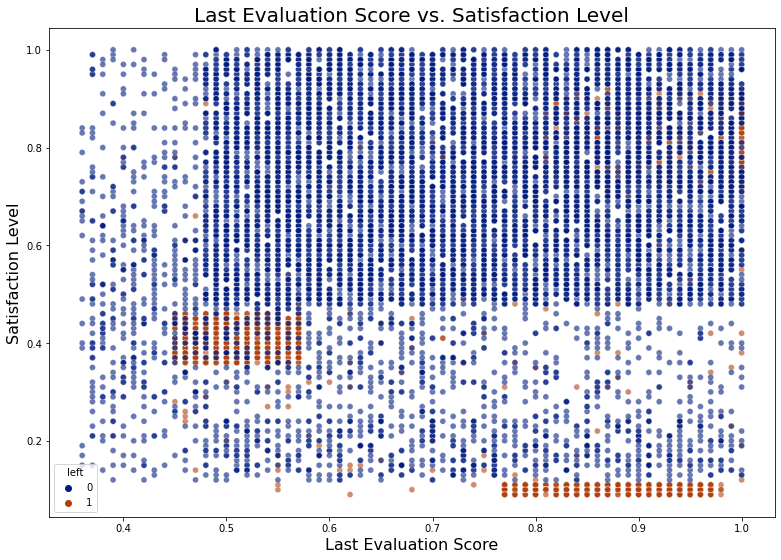

In [16]:
# Last Evaluation Score vs. Satisfaction Level Scatterplot

plt.figure(figsize=(13,9))
fig = sns.scatterplot(data=df1, x='last_eval', y='satis_lvl',hue='left',palette = 'dark',alpha=.6)
fig.set_xlabel("Last Evaluation Score",fontsize=16)
fig.set_ylabel("Satisfaction Level",fontsize=16)
fig.set_title("Last Evaluation Score vs. Satisfaction Level",fontsize=20)
plt.show()

### Observations/Insights

**The distribution of the 3 clusters of employees who left the company in this Last Evaluation Score vs. Satisfaction Level scatterplot is almost identical to the distribution of the 3 clusters of employees who left the company in the above AVG Monthly Hours vs. Satisfaction Level scatterplot.** This leads me to believe there is likely a strong correlation between AVG Monthly Hours and Last Evaluation Score, at least for the employees who left the company. This will be examined further.

There are two groups of employees who left with higher last evaluation scores and a group with lower evaluation scores. One group with higher last evaluation scores ranged from about 0.78 - 0.98 last evaluation scores and around 0.1 satisfaction score. This appears to be that same group of employees with low satisfaction levels and high average monthly hours identified previously. The other group with higher last evaluation scores ranged from about 0.8 - 1.0 last evaluation scores and around 0.7 - 0.9 satisfaction scores. This also appears to be the same group of employees with higher satisfaction levels and high average monthly hours identified previously. The group with lower evaluation scores ranged from about 0.45 - 0.57 evaluation scores and around a 0.5 satisfaction score. This group also may be the same group of employees who had the same satisfaction level and lower average monthly hours worked per month. It's possible that this group of employees knew they would be leaving soon because of their low last evaluation score and so purposely worked fewer hours per month, on average.

Of the employees who stayed at the company, the bulk of them had last evaluation scores ranging from about 0.5 - 1.0 and satisfaction levels ranging from about 0.5 - 1.0.

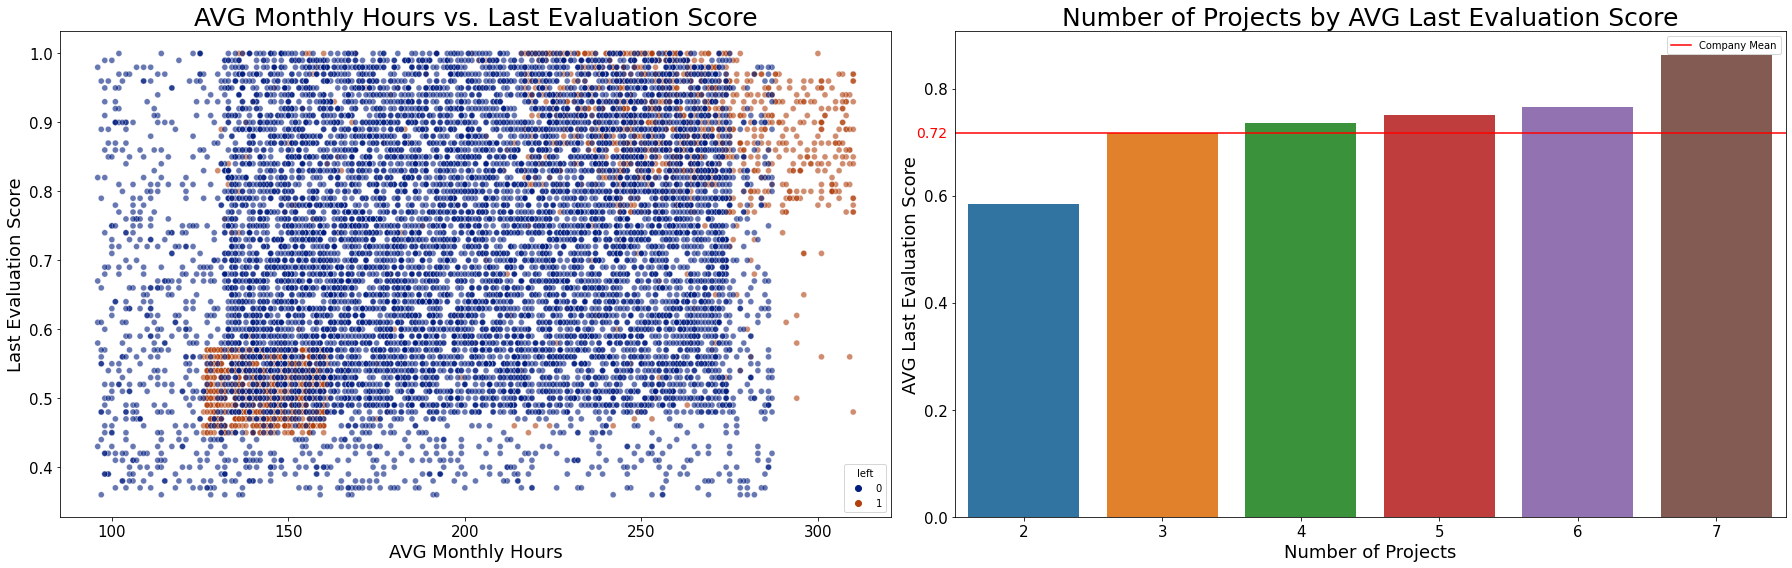

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (25,8))

# AVG Monthly Hrs vs. Last Evaluation Score Scatterplot

fig = sns.scatterplot(data=df1, x='avg_monthly_hrs', y='last_eval',hue='left',palette = 'dark',alpha=.6,ax=axes[0])
axes[0].set_xlabel("AVG Monthly Hours",fontsize=18)
axes[0].set_ylabel("Last Evaluation Score",fontsize=18)
axes[0].set_title("AVG Monthly Hours vs. Last Evaluation Score",fontsize=25)
axes[0].tick_params(axis='both', which='major', labelsize=15)

# AVG Last Evaluation scores by Number of Projects table

proj_by_eval = df1[['num_projects','last_eval']].groupby(['num_projects'])['last_eval'].mean().reset_index()
proj_by_eval = proj_by_eval.rename(columns={'last_eval':'avg_last_eval'})

# Add 95% Confidence Intervals to AVG Last Eval point estimates

avg_proj_eval_CI = pd.DataFrame(df1.groupby(by='num_projects').std()['last_eval'].reset_index())
avg_proj_eval_CI = avg_proj_eval_CI.rename(columns={'last_eval':'std_last_eval'})
avg_proj_eval_CI['sqrt_sample_size'] = np.sqrt(left_by_numprojects['total_emp'])
avg_proj_eval_CI['est_SE'] = avg_proj_eval_CI['std_last_eval'] / avg_proj_eval_CI['sqrt_sample_size']
proj_eval_ci_columns = make_ci_columns(proj_by_eval['avg_last_eval'],avg_proj_eval_CI['est_SE'])
proj_by_eval = proj_by_eval.merge(proj_eval_ci_columns,left_index=True,right_index=True)

#display(proj_by_eval)

# Number of Projects by AVG Last Evaluation Score Bar Plot

fig = sns.barplot(x=proj_by_eval['num_projects'], y=proj_by_eval['avg_last_eval'],ax=axes[1])
axes[1].axhline(df1['last_eval'].mean(),color='r',label='Company Mean')
axes[1].set_title("Number of Projects by AVG Last Evaluation Score",fontsize=25)
axes[1].set_xlabel("Number of Projects",fontsize=18)
axes[1].set_ylabel("AVG Last Evaluation Score",fontsize=18)
trans = transforms.blended_transform_factory(axes[1].get_yticklabels()[0].get_transform(), axes[1].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[1].text(0,0.7166825118839051, "{:.2f}".format(0.7166825118839051), color="red", transform=trans, ha="right", va="center",fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].legend()
plt.tight_layout()
plt.show()

### Observations/Insights

**AVG Monthly Hours.** This scatterplot confirms the relationship between average monthly hours and last evaluation score mentioned above. There are two main groups of employees on this plot who left the company. The first group worked between about 130 - 160 hours on average per month and had last evaluation scores ranging from about 0.45 - 0.58. The second group worked between about 240 - 310 hours on average per month and had last evaluation scores ranging from about 0.78 - 1.0.

Of the employees who stayed at the company, the bulk of them worked between about 130 - 270 hours per month on average and had last evaluation scores ranging from about 0.5 - 1.0.

**AVG Last Evaluation Score.** Average last evaluation scores increase by number of projects. The biggest increases in eval scores are from 2 to 3 projects and from 6 to 7 projects.

**Employees with 7 projects had the highest average last evaluation score (86.4%) *(95% CI [0.847677,0.879358])* and employees with 2 projects had the lowest average last evaluation score (58.5%) *(95% CI [0.568799,0.600480])*.**

### Recommendation

<span style='background :yellow' >**Employee Evaluation Criteria.**
    
<span style='background :yellow' >Building on the last recommendation regarding employee hours worked, management should ensure their employee evaluation criteria is tied to employees getting results vs. working longer hours or on more projects. Management should lead this change in organizational culture so employees know that achieving results is more important. Greater quantity doesn't necessarily equate to greater quality/better results for the company. 
    
<span style='background :yellow' >If an employee is eager to take on more projects and/or work longer hours and is able to achieve the same level of results or better, that can be decided on a case by case basis by the manager - but the employee shouldn't think this is necessary for them to receive a strong evaluation. Management should make this clear.

In [65]:
# Hypothesis Testing to determine validity of the statements that employees who left who had 4-6 years tenure had average
# evaluation scores well above the average evaluation scores for employees who stayed across all tenures.

# •	H0: there is no difference between the mean last evaluation score for employees with 7 projects and the mean score
#       for employees with 6 projects
# •	Ha: there is a difference between the mean last evaluation scores for employees with 7 projects and employees
#       with 6 projects

# Significance Level (all tests): 5%

# Two-sample t-test will be used since I am comparing two sample means to each other.

seven_projects = df1[df1['num_projects'] == 7]
seven_projects = seven_projects[['last_eval']]
six_projects = df1[df1['num_projects'] == 6]
six_projects = six_projects[['last_eval']]

tstat, pvalue = stats.ttest_ind(a=seven_projects, b=six_projects, equal_var=False)

print('\033[1m7 Projects Eval (Mean Difference) Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# •	H0: the mean last evaluation score for employees with 7 projects is >= the mean for employees with 6 projects
# •	Ha: the mean last evaluation score for employees with 7 projects is < the mean for employees with 6 projects

# Significance Level (all tests): 5%
      
tstat, pvalue = stats.ttest_ind(a=seven_projects, b=six_projects, alternative='less', equal_var=False)

print('\033[1m7 Projects Eval (Mean Less Than) Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

7 Projects Eval (Mean Difference) Test Result:
T-Statistic: [9.78498381]  p-value: [5.78598992e-20]


7 Projects Eval (Mean Less Than) Test Result:
T-Statistic: [9.78498381]  p-value: [1.]


### Hypothesis Testing Results

**Mean Difference Test.** The p-value for the mean difference test is 5.78598992e-20, which is lower than the 0.05 significance level so we reject the null hypothesis that the mean last evaluation scores for employees with 6 and 7 projects are equal in favor of the alternative hypothesis that the mean scores between the groups are not equal.

**Mean Less Than Test.** The p-value for the mean less than test is 1, which is greater than the 0.05 significance level so we fail to reject the null hypothesis that the mean last evaluation score for employees with 7 projects is greater than or equal to the mean score for employees with 6 projects.

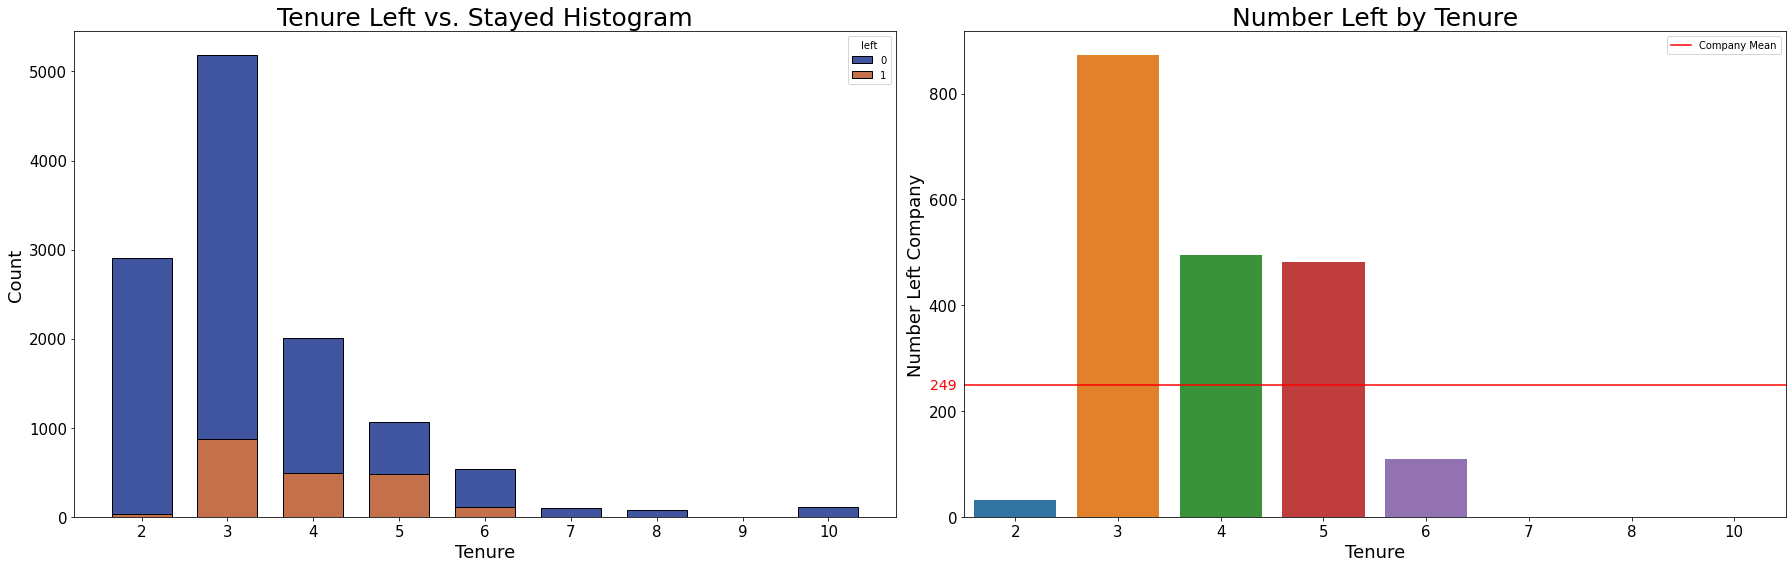

Mean Tenure:  3.36 years (95% CI [3.341047,3.388666])


In [18]:
# Tenure by Left vs. Stayed Table (hidden)

left_tenure = df1_left['tenure'].value_counts().reset_index()
left_tenure.columns = ['tenure', 'num_left']
left_tenure = left_tenure.sort_values(by=['tenure'], ascending=True).reset_index(drop=True)

stayed_tenure = df1_stayed['tenure'].value_counts().reset_index()
stayed_tenure.columns = ['tenure', 'num_stayed']
stayed_tenure = stayed_tenure.sort_values(by=['tenure'], ascending=True).reset_index(drop=True)

left_by_tenure = left_tenure.merge(stayed_tenure, how = 'outer', on=['tenure'])
left_by_tenure = left_by_tenure.fillna(0)
left_by_tenure = left_by_tenure.sort_values(by=['tenure'], ascending=True).reset_index(drop=True)
left_by_tenure['total_emp'] = left_by_tenure['num_left'] + left_by_tenure['num_stayed']
left_by_tenure['total_emp_pct'] = left_by_tenure['total_emp'] / total_emp
left_by_tenure['pct_left_total_left'] = left_by_tenure['num_left'] / left_by_tenure['num_left'].sum()
left_by_tenure.insert(4, "%_left", round(left_by_tenure['num_left'] / left_by_tenure['total_emp'],3))

fig, axes = plt.subplots(1, 2, figsize = (25,8))

# Left vs. Stayed Tenure Histogram

fig = sns.histplot(data=df1, x='tenure', bins=range(2,10,1), 
                  hue='left',
                  multiple='stack',
                  discrete=1,
                  shrink=.7,
                  palette='dark',
                  ax=axes[0])
axes[0].set_xticks(range(2,11,1))
axes[0].set_xticklabels(range(2,11,1))
axes[0].set_title('Tenure Left vs. Stayed Histogram',fontsize=25);
axes[0].set_xlabel("Tenure",fontsize=18)
axes[0].set_ylabel("Count",fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=15)

# Left Tenure Histogram

fig = sns.barplot(x=left_by_tenure['tenure'], y=left_by_tenure['num_left'],ax=axes[1])
axes[1].axhline(left_by_tenure['num_left'].mean(),color='r',label='Company Mean')
trans = transforms.blended_transform_factory(axes[1].get_yticklabels()[0].get_transform(), axes[1].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[1].text(0,248.875, "{:.0f}".format(248.875), color="red", transform=trans, ha="right", va="center",fontsize=14)
axes[1].set_title("Number Left by Tenure",fontsize=25)
axes[1].set_xlabel("Tenure",fontsize=18)
axes[1].set_ylabel("Number Left Company",fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].legend()
plt.tight_layout()
plt.show()

print("\033[1mMean Tenure: ","%.2f" % df1['tenure'].mean(),'years (95% CI [3.341047,3.388666])')
display(left_by_tenure.style.\
    applymap(lambda x: "background-color: red" if (x == 0.454) | (x == 5) else None).\
    applymap(lambda x: "font-weight: bold" if (x == 0.454) | (x == 5) else None).\
    format("{:.3f}",subset=['%_left','total_emp_pct','pct_left_total_left']).\
    format("{:.0f}",subset=['num_left','total_emp']))

# 95% Confidence Interval for Company AVG Tenure

est_SE = df1['tenure'].std() / np.sqrt(df1.shape[0])
CI_company_tenure = stats.norm.interval(alpha=0.95, loc=df1['tenure'].mean(), scale=est_SE)
#print(CI_company_tenure)

### Observations/Insights

**The greatest numbers of employees who left the company had tenures ranging from 3-5 years, with 3 years having the most employees who left.**

The greatest numbers of employees who stayed at the company had tenures ranging 2-4 years, with 3 years also having the most employees who stayed (there were far more employees with 3 years tenure overall than any other single tenure group). **All employees with tenures 7, 8, and 10 stayed at the company (there were no employees with 9 years tenure).**

**Over 45% of employees with 5 years tenure left the company. That's almost double the percentage of the next highest group (24.7% of employees with 4 tenures left).**

The mean tenure of all employees at the company is 3.36 years *(95% CI [3.341047,3.388666])*. The mean tenure at a company for employees in the UK is about 8 years as of 2019 (https://www.statista.com/chart/20571/average-time-spend-with-one-employer-in-selected-oecd-countries/) and 5.2 years in the US for the manufacturing industry specifically (https://www.zippia.com/advice/average-employee-tenure/).

### Recommendation

<span style='background :yellow' >**5-Year Tenure Employee Incentivization.**
    
<span style='background :yellow' >Since 5-year tenure employees have by far the greatest percentage within a tenure year group that left the company, the company should implement special incentives for employees to stay with the company beyond 5 years. These could include higher salary raises at 5 years, additional vacation days, time-based restricted stock, promotion, public recognition of company contribution, or other incentives.

In [30]:
# Hypothesis Test to determine validity of the statistic that 45.4% of 5-year tenure employees left the company

# •	H0: p ≥ 0.454 (the proportion of tenure=5 employees who left the company is greater than or equal to 45.4%)
# •	Ha: p < 0.454 (the proportion of tenure=5 employees who left the company is less than 45.4%)

# Significance Level: 5%

# One-tailed z-test will be used since the alternative hypothesis states that the actual value of the population 
# parameter is less than the value in the null hypothesis (as opposed to 'is not equal to').

tstat, pvalue = proportions_ztest(count=482, nobs=1062, value=0.454, alternative='smaller', prop_var=False)
print('\033[1mTenure 5 Left Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

Tenure 5 Left Test Result:
T-Statistic: -0.009121924174419828  p-value: 0.4963609292358215


### Hypothesis Testing Result

The p-value from this one-tailed z-test is about 0.5, which is greater than the significance level of 0.05 so we fail to reject the null hypothesis that greater than or equal to 45.4% of employees with 5 years tenure left the company.

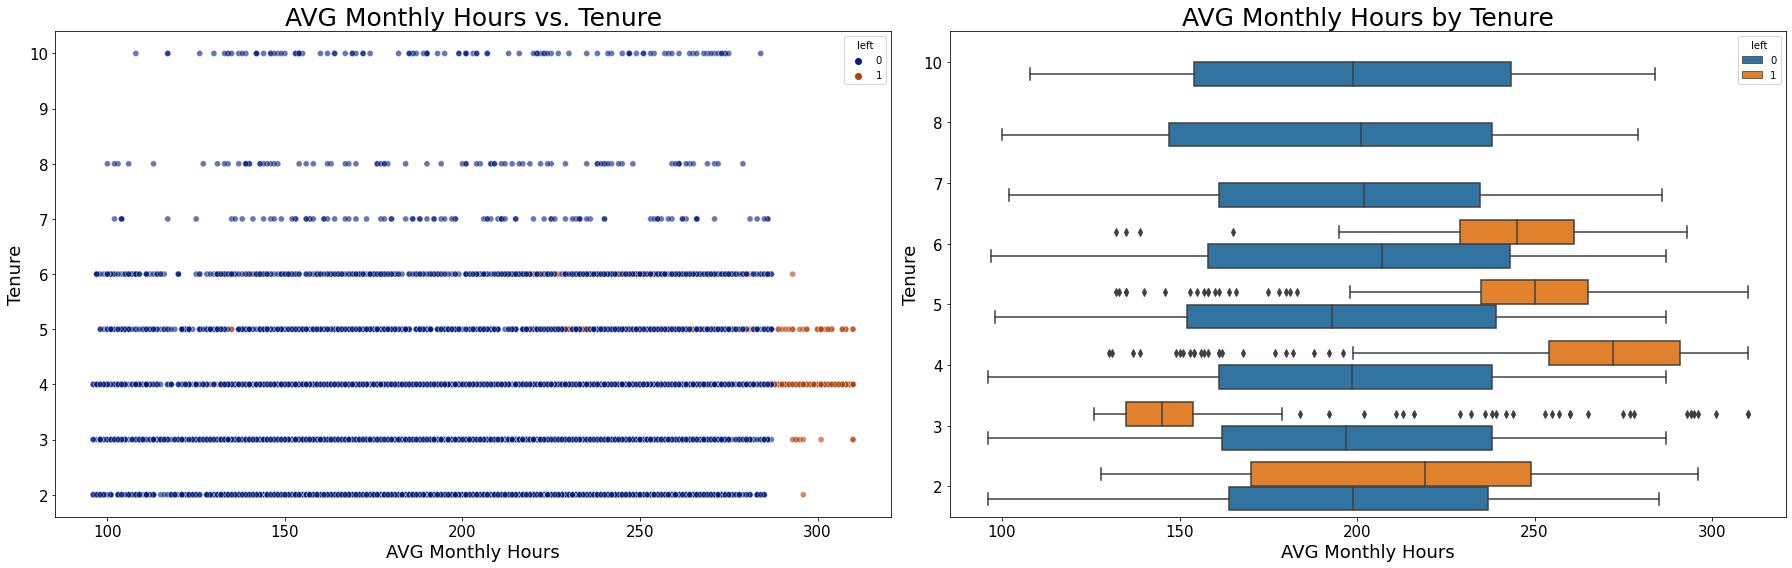

In [19]:
# AVG Monthly Hrs vs. Tenure Plots

fig, axes = plt.subplots(1, 2, figsize = (25,8))

# Scatterplot

fig = sns.scatterplot(data=df1, x='avg_monthly_hrs', y='tenure',hue='left',palette = 'dark',alpha=.6,ax=axes[0])
axes[0].set_xlabel("AVG Monthly Hours",fontsize=18)
axes[0].set_ylabel("Tenure",fontsize=18)
axes[0].set_title("AVG Monthly Hours vs. Tenure",fontsize=25)
axes[0].tick_params(axis='both', which='major', labelsize=15)

# Boxplot

fig = sns.boxplot(x=df1['avg_monthly_hrs'],y=df1['tenure'],hue=df1['left'],orient="h",ax=axes[1]);
axes[1].set_title('AVG Monthly Hours by Tenure',fontsize=25);
axes[1].set_xlabel('AVG Monthly Hours',fontsize=18);
axes[1].set_ylabel('Tenure',fontsize=18);
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].invert_yaxis()
plt.tight_layout()
plt.show()

# Add AVG Number of Projects by Tenure column

proj_by_tenure = pd.DataFrame(df1.groupby(by='tenure')['num_projects'].mean().reset_index())
left_by_tenure = left_by_tenure.merge(proj_by_tenure, how = 'outer', on=['tenure'])
left_by_tenure = left_by_tenure.rename(columns={'num_projects':'avg_num_proj'})
left_by_tenure['avg_num_proj'] = round(left_by_tenure['avg_num_proj'],6)

# Add 95% Confidence Intervals to AVG Number of Projects point estimates

avg_num_proj_CI = pd.DataFrame(df1.groupby(by='tenure').std()['num_projects'].reset_index())
avg_num_proj_CI = avg_num_proj_CI.rename(columns={'num_projects':'std_num_projects'})
avg_num_proj_CI['sqrt_sample_size'] = np.sqrt(left_by_tenure['total_emp'])
avg_num_proj_CI['est_SE'] = avg_num_proj_CI['std_num_projects'] / avg_num_proj_CI['sqrt_sample_size']
left_by_tenure['avg_num_proj'] = left_by_tenure['avg_num_proj'].astype(float)
avg_num_proj_CI['est_SE'] = avg_num_proj_CI['est_SE'].astype(float)
tenure_proj_ci_columns = make_ci_columns(left_by_tenure['avg_num_proj'],avg_num_proj_CI['est_SE'])
left_by_tenure = left_by_tenure.merge(tenure_proj_ci_columns,left_index=True,right_index=True)

display(left_by_tenure.style.\
    applymap(lambda x: "background-color: red" if (x == 4.423441) | (x == 4.464218) | (x == 4.167897) | (x == 0.247) |
             (x == 0.454) | (x == 0.201) | (x == 4)  | (x == 5) | (x == 6) else None).\
    applymap(lambda x: "font-weight: bold" if (x == 4.423441) | (x == 4.464218) | (x == 4.167897) | (x == 0.247) | 
             (x == 0.454) | (x == 0.201) | (x == 4)  | (x == 5) | (x == 6) else None).\
    format("{:.3f}",subset=['%_left','total_emp_pct','pct_left_total_left','avg_num_proj','conf_int_lb','conf_int_ub']).\
    format("{:.0f}",subset=['num_left','total_emp']))

### Observations/Insights

**The greatest numbers of employees who left the company had tenure 3 - 5 years (as mentioned above) and were working about 270+ hours per month, on average.**

The distributions of employees who stayed at the company are fairly centered around 200 average monthly hours across tenure. This is contrasted with the more widely varying distributions of employees who left the company, whose distributions, with the exception of tenure = 3 years, are all centered above 200 average monthly hours -  closer to 250 hours. The distribution of the 3-year tenured employees who left is centered closer to 150 hours with several outliers on the upper end of the range. This exception might be worth investigating further.

**Employees with 4-6 years tenure had the highest number of projects on average and also had the highest percentages of employees at the same tenure who left the company, in the same order (i.e. 5 years had the highest average number of projects and percentage of employees leave, 4 years had the second highest in both, and 6 years had the third highest in both). As mentioned above, employees with 4 and 5 years tenure not only had the highest percentages of employees leave but also had the highest numbers of employees that left the company.**

**This supports the earlier recommendation for managers not to assign more than 3-4 projects to the majority of employees.**

In [70]:
# Hypothesis Test to determine validity of the statement that employees with 4-6 years tenure had the highest 
# number of projects on average 


# •	H0: the mean numbers of projects for employees with 4-6 years tenure are <= the mean for employees with 
#       7 years tenure (the next highest calculated average number of projects)
# •	Ha: the mean numbers of projects for employees with 4-6 years tenure are > the mean for employees with 
#       7 years tenure

# Significance Level (all tests): 5%

# 4 Year Tenure Projects

four_tenure_projects = df1[df1['tenure'] == 4]
four_tenure_projects = four_tenure_projects[['num_projects']]
seven_tenure_projects = df1[df1['tenure'] == 7]
seven_tenure_projects = seven_tenure_projects[['num_projects']]

tstat, pvalue = stats.ttest_ind(a=four_tenure_projects, b=seven_tenure_projects, alternative='greater', equal_var=False)

print('\033[1m4 Tenure Projects Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# 5 Year Tenure Projects

five_tenure_projects = df1[df1['tenure'] == 5]
five_tenure_projects = five_tenure_projects[['num_projects']]

tstat, pvalue = stats.ttest_ind(a=five_tenure_projects, b=seven_tenure_projects, alternative='greater', equal_var=False)

print('\033[1m5 Tenure Projects Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# 6 Year Tenure Projects

six_tenure_projects = df1[df1['tenure'] == 6]
six_tenure_projects = six_tenure_projects[['num_projects']]

tstat, pvalue = stats.ttest_ind(a=six_tenure_projects, b=seven_tenure_projects, alternative='greater', equal_var=False)

print('\033[1m6 Tenure Projects Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# Hypothesis Test to determine validity of the statement that employees with 4-6 years tenure had the highest 
# percentages of employees at the same tenure who left the company


# •	H0: p = 0.168 (the proportions of employees with 4-6 years tenure who left the company is equal to 0.168 
#                 (the next highest calculated proportion))
# •	Ha: p > 0.168 (the proportions of employees with 4-6 years tenure who left the company is greater than 0.168)

# Tenure 4 % Left

tstat,pvalue = proportions_ztest(count=495, nobs=2005, value=0.168, alternative='larger', prop_var=False)

print('\033[1mTenure 4 % Left Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# Tenure 5 % Left

tstat,pvalue = proportions_ztest(count=482, nobs=1062, value=0.168, alternative='larger', prop_var=False)

print('\033[1mTenure 5 % Left Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# Tenure 6 % Left

tstat,pvalue = proportions_ztest(count=109, nobs=542, value=0.168, alternative='larger', prop_var=False)

print('\033[1mTenure 6 % Left Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

4 Tenure Projects Test Result:
T-Statistic: [5.10333846]  p-value: [7.1802066e-07]


5 Tenure Projects Test Result:
T-Statistic: [5.41442428]  p-value: [1.76318673e-07]


6 Tenure Projects Test Result:
T-Statistic: [2.66188121]  p-value: [0.0043526]


Tenure 4 % Left Test Result:
T-Statistic: 8.19148747738243  p-value: 1.290086338818806e-16


Tenure 5 % Left Test Result:
T-Statistic: 18.711285328156332  p-value: 2.0029807686390927e-78


Tenure 6 % Left Test Result:
T-Statistic: 1.9229221704870032  p-value: 0.027244912485605205


### Hypothesis Testing Results

The p-values for all tests were less than 0.05 so we reject the null hypotheses for all tests in favor of the alternative hypotheses.

**Alternative Hypotheses:**
- Ha: the mean numbers of projects for employees with 4-6 years tenure are > the mean for employees with 7 years tenure (the next highest calculated average number of projects)
- Ha: p > 0.168 (the proportions of employees with 4-6 years tenure who left the company is greater than 0.168 (the next highest calculated proportion))

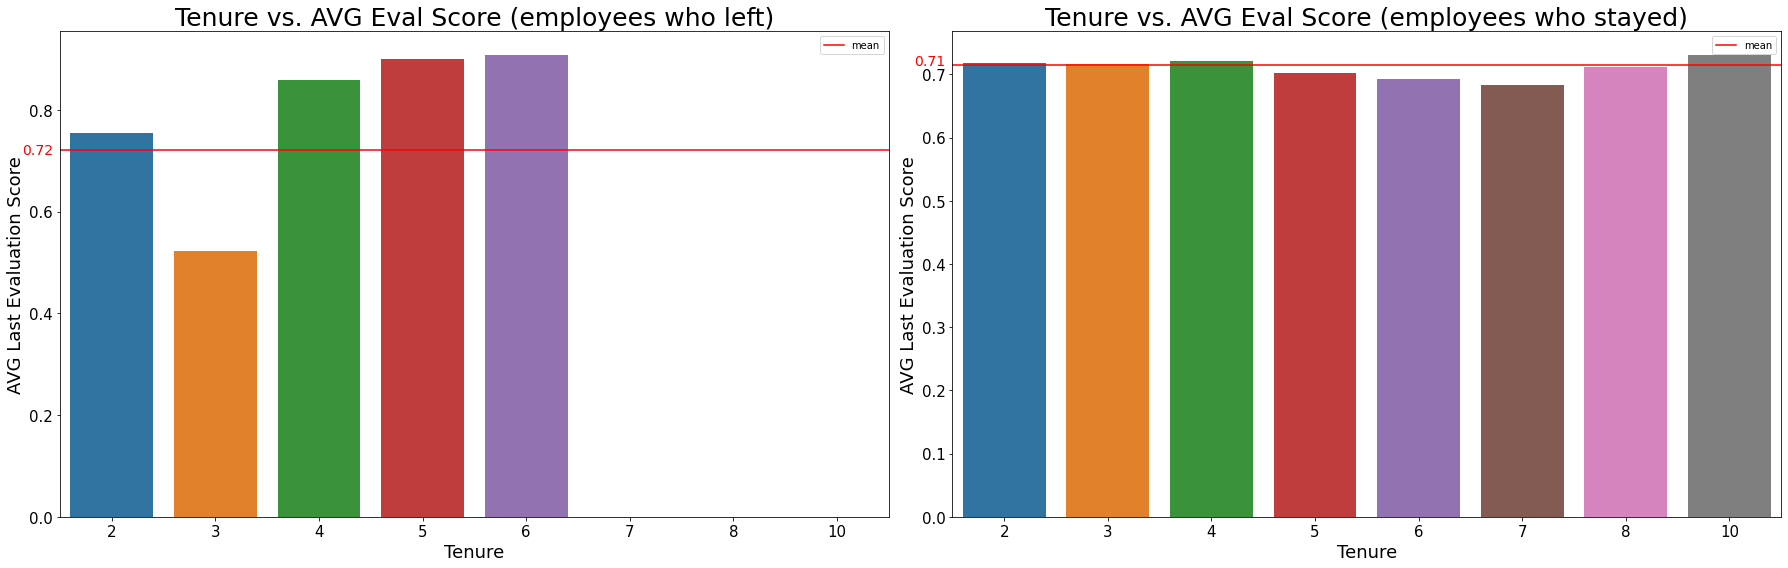

In [20]:
# Tenure vs. Last Evaluation Score Table

left_tenure_eval = pd.DataFrame(df1_left.groupby(['tenure']).mean()['last_eval']).reset_index()
stayed_tenure_eval = pd.DataFrame(df1_stayed.groupby(['tenure']).mean()['last_eval']).reset_index()
overall_tenure_eval = pd.DataFrame(df1.groupby(['tenure']).mean()['last_eval']).reset_index()
left_by_tenure = left_by_tenure.merge(left_tenure_eval, how = 'outer', on=['tenure'])
left_by_tenure = left_by_tenure.merge(stayed_tenure_eval, how = 'outer', on=['tenure'])
left_by_tenure = left_by_tenure.merge(overall_tenure_eval, how = 'outer', on=['tenure'])
left_by_tenure = left_by_tenure.rename(columns={'last_eval_x':'avg_eval_left','last_eval_y':'avg_eval_stayed','last_eval':'avg_eval_overall'})
left_by_tenure = left_by_tenure.fillna(0)
left_by_tenure['avg_eval_left'] = round(left_by_tenure['avg_eval_left'],3)

# Add 95% Confidence Intervals to AVG Eval Left point estimates

avg_tenure_eval_CI = pd.DataFrame(df1.groupby(by='tenure').std()['last_eval'].reset_index())
avg_tenure_eval_CI = avg_tenure_eval_CI.rename(columns={'last_eval':'std_last_eval'})
avg_tenure_eval_CI['sqrt_sample_size'] = np.sqrt(left_by_tenure['total_emp'])
avg_tenure_eval_CI['est_SE'] = avg_tenure_eval_CI['std_last_eval'] / avg_tenure_eval_CI['sqrt_sample_size']
tenure_eval_ci_columns = make_ci_columns(left_by_tenure['avg_eval_left'],avg_tenure_eval_CI['est_SE'])
left_by_tenure = left_by_tenure.merge(tenure_eval_ci_columns,left_index=True,right_index=True)
left_by_tenure.insert(left_by_tenure.columns.get_loc("avg_eval_stayed"),"conf_int_lb_y",left_by_tenure.pop("conf_int_lb_y"))
left_by_tenure.insert(left_by_tenure.columns.get_loc("avg_eval_stayed"),"conf_int_ub_y",left_by_tenure.pop("conf_int_ub_y"))

disp_left_by_tenure = left_by_tenure.drop(columns=['total_emp_pct','pct_left_total_left'])

# Method chain to highlight cells in the left_by_tenure dataframe

display(disp_left_by_tenure.style.\
    applymap(lambda x: "background-color: green" if ((x == 0.858) | (x == 0.900) | (x == 0.909)) else None).\
    applymap(lambda x: "background-color: red" if ((x == 0.522) | (x == 0.754) | (x == 4.423441) | 
            (x == 4.464218) | (x == 4.167897) | (x == 0.247) | (x == 0.454) | (x == 0.201) | (x == 4)  | (x == 5) | (x == 6)) else None).\
    applymap(lambda x: "font-weight: bold" if ((x == 0.858) | (x == 0.900) | (x == 0.909) | ((x == 0.522) | (x == 0.754) | 
            (x == 4.423441) | (x == 4.464218) | (x == 4.167897) | (x == 0.247) | (x == 0.454) | (x == 0.201) | (x == 4)  | (x == 5) | (x == 6))) else None).\
    format("{:.3f}",subset=['avg_num_proj','avg_eval_stayed','avg_eval_overall','%_left','avg_eval_left',
                            'conf_int_lb_x','conf_int_ub_x','conf_int_lb_y','conf_int_ub_y']).\
    format("{:.0f}",subset=['num_left','total_emp']))
print('\n')

fig, axes = plt.subplots(1, 2, figsize = (25,8))

# Tenure vs. AVG Last Evaluation Score of Employees who Left

fig = sns.barplot(data=left_by_tenure, x='tenure', y='avg_eval_left',ax=axes[0])
axes[0].axhline(df1_left['last_eval'].mean(),color='r',label='mean')
trans = transforms.blended_transform_factory(axes[0].get_yticklabels()[0].get_transform(), axes[0].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[0].text(0,0.7217830236062278, "{:.2f}".format(0.7217830236062278), color="red", transform=trans, ha="right", va="center",fontsize=14)
axes[0].set_title('Tenure vs. AVG Eval Score (employees who left)',fontsize=25);
axes[0].set_xlabel("Tenure",fontsize=18)
axes[0].set_ylabel("AVG Last Evaluation Score",fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].legend()

# Tenure vs. AVG Last Evaluation Score of Employees who Stayed

fig = sns.barplot(x=left_by_tenure['tenure'], y=left_by_tenure['avg_eval_stayed'],ax=axes[1])
axes[1].axhline(df1_stayed['last_eval'].mean(),color='r',label='mean')
trans = transforms.blended_transform_factory(axes[1].get_yticklabels()[0].get_transform(), axes[1].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[1].text(0,0.7096035249140771, "{:.2f}".format(0.7096035249140771), color="red", transform=trans, ha="right", va="bottom",fontsize=14)
axes[1].set_title("Tenure vs. AVG Eval Score (employees who stayed)",fontsize=25)
axes[1].set_xlabel("Tenure",fontsize=18)
axes[1].set_ylabel("AVG Last Evaluation Score",fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].legend()
plt.tight_layout()
plt.show()

# 95% Confidence Intervals for Highest and Lowest AVG Eval Stayed

tenure_10 = df1[df1['tenure'] == 10]
est_SE = tenure_10['last_eval'].std() / np.sqrt(107)
CI_tenure_eval = stats.norm.interval(alpha=0.95, loc=tenure_10['last_eval'].mean(), scale=est_SE)
#print(CI_tenure_eval)

tenure_7 = df1[df1['tenure'] == 7]
est_SE = tenure_7['last_eval'].std() / np.sqrt(94)
CI_tenure_eval_7 = stats.norm.interval(alpha=0.95, loc=tenure_7['last_eval'].mean(), scale=est_SE)
#print(CI_tenure_eval_7)

### Observations/Insights

The average last evaluation scores for employees who left vs. stayed is about the same (0.72 vs. 0.71).

For employees who left, the lowest average last evaluation scores were in employees with 2-3 years tenure, with tenure = 3 having the lowest average score of 0.52 *(95% CI [0.492,0.552])*. Employees with tenure = 3 also make up the largest portion of the population compared to other tenure groups, which is why the average for all tenure groups of employees who left is so much lower than the much higher average evaluation scores of tenure groups 2 and 4-6 for employees who left. Employees with 3 years tenure had the greatest number of employees leave the company within a tenure group but the percentage of employees with 3 years tenure who left is lower than the percentages of employees with 4, 5, or 6 years tenure who left the company.

The highest average scores for employees who left were in employees with 4-6 years tenure, with tenure = 6 having the highest average score of 0.91 *(95% CI [0.879,0.939])* (0.2 above the average score of employees who stayed). **Employees who left who had 4-6 years tenure had average evaluation scores well above the average evaluation scores for employees who stayed (across all tenures). Their average scores ranged from 0.86 - 0.91 vs. the highest average score for employees who stayed of 0.73 *(95% CI [0.701578,0.761412])*. It's possible that this group of employees who left were top performers who found better opportunities elsewhere to advance their careers.**

For employees who stayed, average last evaluation scores are more consistent across tenure. Employees who stayed with 7 years tenure had the lowest average score of 0.68 *(95% CI [0.650117,0.715414])* and employees who stayed with 10 years tenure had the highest average score of 0.73 *(95% CI [0.701578,0.761412])*.

### Recommendation

<span style='background :yellow' >**Top Talent Retention.**
    
<span style='background :yellow' >Since the same tenure groups of employees who had the highest percentages of employees leave the company (tenure 4 - 6) also appear to be the top talent tenure groups in the company overall, incentives directed towards these tenure groups should take into account that they consist of top talent. This would justify higher levels of pay, promotion, or other similar incentives mentioned previously.

In [44]:
# Hypothesis Testing to determine validity of the statements that employees who left who had 4-6 years tenure had average
# evaluation scores well above the average evaluation scores for employees who stayed across all tenures.

# •	H0: μ = 0.858 (the mean last evaluation score for employees with 4 yrs tenure who left the company is equal to 
#                  0.858)
# •	Ha: μ < 0.858 (the mean last evaluation score for employees with 4 yrs tenure who left the company is less than 
#                  0.858)

# Significance Level (all tests): 5%

# One-sample t-test will be used since I am comparing one sample mean relative to a particular value in one direction. 

tenure_4_left = df1_left[df1_left['tenure'] == 4]

tstat, pvalue = stats.ttest_1samp(tenure_4_left['last_eval'], 0.858, alternative='less')

print('\033[1mTenure 4 Left Test P-Value:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# •	H0: μ = 0.9 (the mean last evaluation score for employees with 5 yrs tenure who left the company is equal to 
#                0.9)
# •	Ha: μ < 0.9 (the mean last evaluation score for employees with 5 yrs tenure who left the company is less than 
#                0.9)

tenure_5_left = df1_left[df1_left['tenure'] == 5]

tstat, pvalue = stats.ttest_1samp(tenure_5_left['last_eval'], 0.9, alternative='less')

print('\033[1mTenure 5 Left Test P-Value:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# •	H0: μ = 0.909 (the mean last evaluation score for employees with 6 yrs tenure who left the company is equal to 
#                  0.909)
# •	Ha: μ < 0.909 (the mean last evaluation score for employees with 6 yrs tenure who left the company is less than 
#                  0.909)

tenure_6_left = df1_left[df1_left['tenure'] == 6]

tstat, pvalue = stats.ttest_1samp(tenure_6_left['last_eval'], 0.909, alternative='less')

print('\033[1mTenure 6 Left Test P-Value:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

Tenure 4 Left Test P-Value:
T-Statistic: -0.049144562590040665  p-value: 0.48041197666105007


Tenure 5 Left Test P-Value:
T-Statistic: -0.10164678968986232  p-value: 0.4595396984686079


Tenure 6 Left Test P-Value:
T-Statistic: -0.011814847783960749  p-value: 0.49529756607043063


### Hypothesis Testing Results

The p-values for all one-sample t-tests were greater than 0.05 so we fail to reject the null hypotheses for all tests that the mean last evaluation scores for employees with 4-6 years tenure that left the company are equal to the calculated means from the samples.

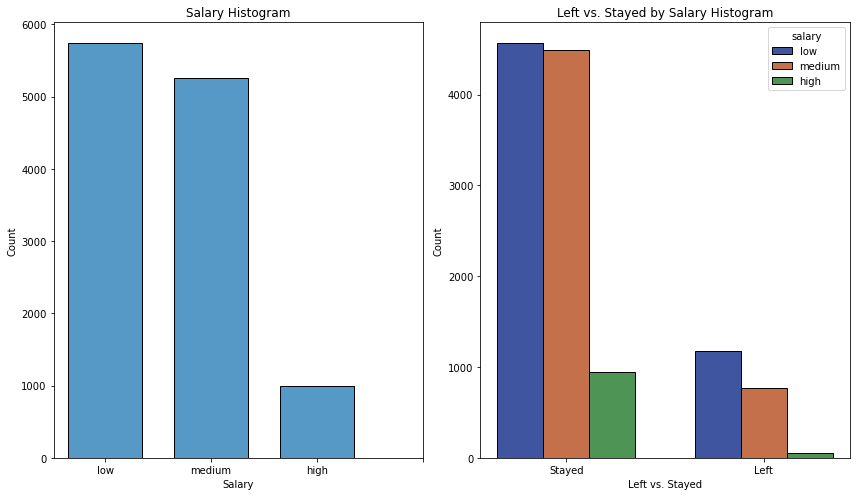

salary  % of left  % of stayed
0     low       0.59         0.46
1  medium       0.39         0.45
2    high       0.02         0.09

In [21]:
# Salary Histograms

fig, axes = plt.subplots(1, 2, figsize = (12,7))

# Salary Histogram

fig = sns.histplot(data=df1, x='salary', 
                  shrink=.7,
                  discrete=1,
                  palette='dark',
                  ax=axes[0])
axes[0].set_xticks(range(0,4,1))
axes[0].set_xticklabels(['low','medium','high'])
axes[0].set_xlabel('Salary')
axes[0].set_title('Salary Histogram');

# Salary Left vs. Stayed Histogram

fig = sns.histplot(data=df1, x='left', bins=range(0,1,1), 
                  hue='salary',
                  hue_order = ['low','medium','high'],
                  multiple='dodge',
                  discrete=1,
                  shrink=.7,
                  palette='dark',
                  ax=axes[1])
axes[1].set_xticks(range(0,2,1))
axes[1].set_xticklabels(['Stayed','Left'])
axes[1].set_xlabel('Left vs. Stayed')
axes[1].set_title('Left vs. Stayed by Salary Histogram');
plt.tight_layout()
plt.show()

# Proportions of Left vs. Stayed by Salary Level Table

left_salary_cts = pd.DataFrame(round(df1[df1['left'] == 1].value_counts('salary',normalize=True),2).reset_index())
left_salary_cts = left_salary_cts.rename(columns={0:'% of left'})

stayed_salary_cts = pd.DataFrame(round(df1[df1['left'] == 0].value_counts('salary',normalize=True),2).reset_index())
stayed_salary_cts = stayed_salary_cts.rename(columns={0:'% of stayed'})

left_stayed_salary_cts = left_salary_cts.merge(stayed_salary_cts, how = 'outer', on=['salary'])
display(left_stayed_salary_cts)

### Observations/Insights

Most employees at the company overall had either low or medium salaries. Employees who left had a higher proportion of low salaries compared to employees who stayed (59% vs. 46% for employees who stayed). Employees who stayed had higher proportions of medium and high salaries compared to employees who left (45% vs. 39% medium salaries for employees who left and 9% vs. 2% high salaries for employees who left).

Based on these observations, it's possible that lower salaries contributed to employees leaving and higher salaries contributed to employees staying.

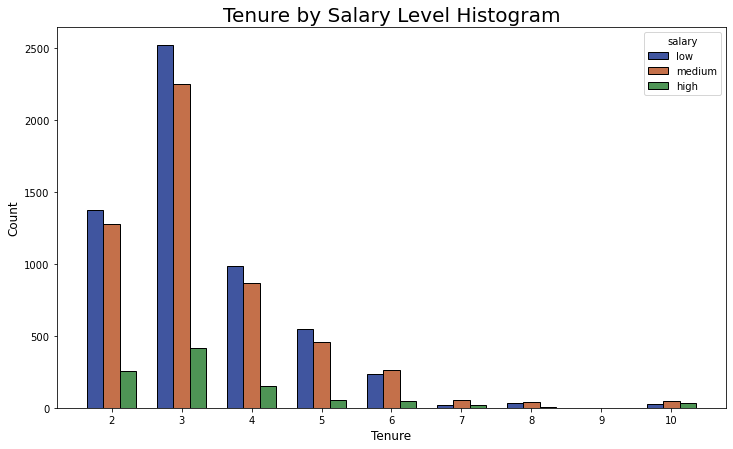

In [22]:
# Tenure by Salary Histogram

plt.figure(figsize=(12,7))
ax = sns.histplot(data=df1, x='tenure', bins=range(2,10,1), 
                  hue='salary',
                  hue_order = ['low','medium','high'],
                  multiple='dodge',
                  discrete=1,
                  shrink=.7,
                  palette='dark')
ax.set_xticks(range(2,11,1))
ax.set_xticklabels(range(2,11,1))
ax.set_xlabel('Tenure',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
plt.title('Tenure by Salary Level Histogram',fontsize=20);
plt.show()

# Salary and Left vs. Stayed by Tenure Table

low_salary_cts = df1[['tenure','salary']][df1['salary'] == 'low'].groupby(['tenure']).count().reset_index()
medium_salary_cts = df1[['tenure','salary']][df1['salary'] == 'medium'].groupby(['tenure']).count().reset_index()
high_salary_cts = df1[['tenure','salary']][df1['salary'] == 'high'].groupby(['tenure']).count().reset_index()
tenure_salary_cts = low_salary_cts.merge(medium_salary_cts, how = 'outer', on=['tenure'])
tenure_salary_cts = tenure_salary_cts.rename(columns={'salary_x':'salary_low','salary_y':'salary_medium'})
tenure_salary_cts = tenure_salary_cts.merge(high_salary_cts, how = 'outer', on=['tenure'])
tenure_salary_cts = tenure_salary_cts.rename(columns={'salary':'salary_high'})
tenure_salary_cts.insert(2, "salary_low_%", round(tenure_salary_cts['salary_low'] / (tenure_salary_cts['salary_low'] + tenure_salary_cts['salary_medium'] + tenure_salary_cts['salary_high']),3))
tenure_salary_cts.insert(4, "salary_med_%", round(tenure_salary_cts['salary_medium'] / (tenure_salary_cts['salary_low'] + tenure_salary_cts['salary_medium'] + tenure_salary_cts['salary_high']),2))
tenure_salary_cts.insert(6, "salary_high_%", round(tenure_salary_cts['salary_high'] / (tenure_salary_cts['salary_low'] + tenure_salary_cts['salary_medium'] + tenure_salary_cts['salary_high']),2))
left_tenure = round(df1_left['tenure'].value_counts().reset_index().sort_values(by='index',ascending=True),0)
left_tenure = left_tenure.rename(columns={'index':'tenure','tenure':'left'})
tenure_salary_cts = tenure_salary_cts.merge(left_tenure, how = 'outer', on=['tenure'])
stayed_tenure = df1_stayed['tenure'].value_counts().reset_index().sort_values(by='index',ascending=True)
stayed_tenure = stayed_tenure.rename(columns={'index':'tenure','tenure':'stayed'})
tenure_salary_cts = tenure_salary_cts.merge(stayed_tenure, how = 'outer', on=['tenure'])
tenure_salary_cts = tenure_salary_cts.fillna(0)
tenure_salary_cts['left'] = tenure_salary_cts['left'].astype(int)
tenure_salary_cts.insert(8, "left_%", round(tenure_salary_cts['left'] / (tenure_salary_cts['left'] + tenure_salary_cts['stayed']),2))
tenure_salary_cts.insert(10, "stayed_%", round(tenure_salary_cts['stayed'] / (tenure_salary_cts['left'] + tenure_salary_cts['stayed']),2))

display(tenure_salary_cts.style.\
    applymap(lambda x: "background-color: red" if ((x == 0.45) | (x == 0.518) | (x == 0.492) | (x == 0.25) | (x == 4)  | (x == 5)) else None).\
    applymap(lambda x: "font-weight: bold" if ((x == 0.45) | (x == 0.518) | (x == 0.492) | (x == 0.25) | (x == 4)  | (x == 5)) else None).\
    format("{:.3f}",subset='salary_low_%').\
    format("{:.2f}",subset=['salary_med_%','salary_high_%','left_%','stayed_%']))

### Observations/Insights

There are more employees with low salaries from tenure 2 - 5 than with medium or high salaries. From tenure 6 - 10, there are more employees with medium salaries than with low or high salaries.

**Employees with high and medium salaries at the upper range of tenure (7, 8, and 10) make up a larger proportion of the employees at those tenures than at the lower range of tenure.**

Employees with tenure = 5 who left the company made up the highest percentage of all employees at the same tenure who had low salaries (~ 52%). This group of employees also made up the highest percentage of all employees who left the company at the same tenure (45%). It's possible that low salaries contributed to the employees with tenure = 5 deciding to leave the company. It's possible they expected higher salaries at that point in their career but they never received commensurate pay raises.

**In addition to working on the most number of projects and having the highest last evaluation scores, employees with tenures 4* and 5 years also had the highest percentages of low salaries compared to all other tenure groups.**

**This finding is not conclusive for tenure 4 employees (see Hypothesis Test results below)*

### Recommendation

<span style='background :yellow' >**Employee Salaries Overhaul.**
    
<span style='background :yellow' >It doesn't make sense that the employees who do the most work and have the highest evaluation scores also have among the lowest salaries in the company. Management/Finance should take a serious look at how salaries are determined for its employees, especially for the top performers in tenures 4-6, and ensure it is commensurate with the value employees bring to the company.

In [101]:
# Hypothesis Test to determine if we can reject the null hypothesis that proportions of low salaries for employees
# with 4 and 5 years tenure are equal to the proportion of low salaries for employees at all other tenures.

# •	H0: p = 0.485 (the proportion of tenure=4 employees who have low salaries is equal to 0.485 (the next highest
#                  calculated proportion))
# •	Ha: p > 0.485 (the proportion of tenure=4 employees who left the company is greater than 0.485)

# Significance Level: 5%

# One-tailed z-test will be used since the alternative hypothesis states that the actual population 
# proportion is greater than the proportion in the null hypothesis (as opposed to 'not equal to').

tstat,pvalue = proportions_ztest(count=986, nobs=(986+869+150), value=0.485, alternative='larger', prop_var=False)

print('\033[1mTenure 4 Z-Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

tstat, pvalue = test_proportions_2indep(count1=986, nobs1=(986+869+150), count2=2519, nobs2=(2519+2252+419), value=0, method=None, compare='diff', alternative='larger', correction=True, return_results=True)

print('\033[1mTenure 4 2Indep-Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# •	H0: p = 0.485 (the proportion of tenure=5 employees who have low salaries is equal to 0.485 (the next highest
#                  calculated proportion))
# •	Ha: p > 0.485 (the proportion of tenure=5 employees who left the company is greater than 0.485)

tstat,pvalue = proportions_ztest(count=550, nobs=(550+455+57), value=0.485, alternative='larger', prop_var=False)

print('\033[1mTenure 5 Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

Tenure 4 Z-Test Result:
T-Statistic: 0.6064171531347395  p-value: 0.27211889044266935


Tenure 4 2Indep-Test Result:
T-Statistic: 0.48835932024440254  p-value: 0.31264767535157983


Tenure 5 Test Result:
T-Statistic: 2.1450850631774583  p-value: 0.015973023234507625


### Hypothesis Testing Results

**Tenure 4 Test.** The p-value for the Tenure 4 test is 0.272/0.313, which is higher than the 0.05 significance level so we fail to reject the null hypothesis that the proportion of low salaries for 4 year tenure employees is equal to the next highest calculated proportion of low salaries (tenure 3 employees - 0.485). The proportion of low salaries that was calculated for 4 year tenure employees is 0.492, which is close to 0.485 to begin with.

I used two separate tests for Tenure 4 since the first test resulted in a non-significant p-value. The second test uses the count of successes and number of observations in the second sample instead of the calculated value of the second sample's proportion. The second test confirmed the first test's non-significant p-value.

**Tenure 5 Test.** The p-value for the Tenure 5 test is 0.016, which is less than the 0.05 significance level so we reject the null hypothesis in favor of the alternative hypothesis that the proportion of low salaries for 5 year tenure employees is greater than the next highest calculated proportion of low salaries (tenure 3 employees - 0.485).

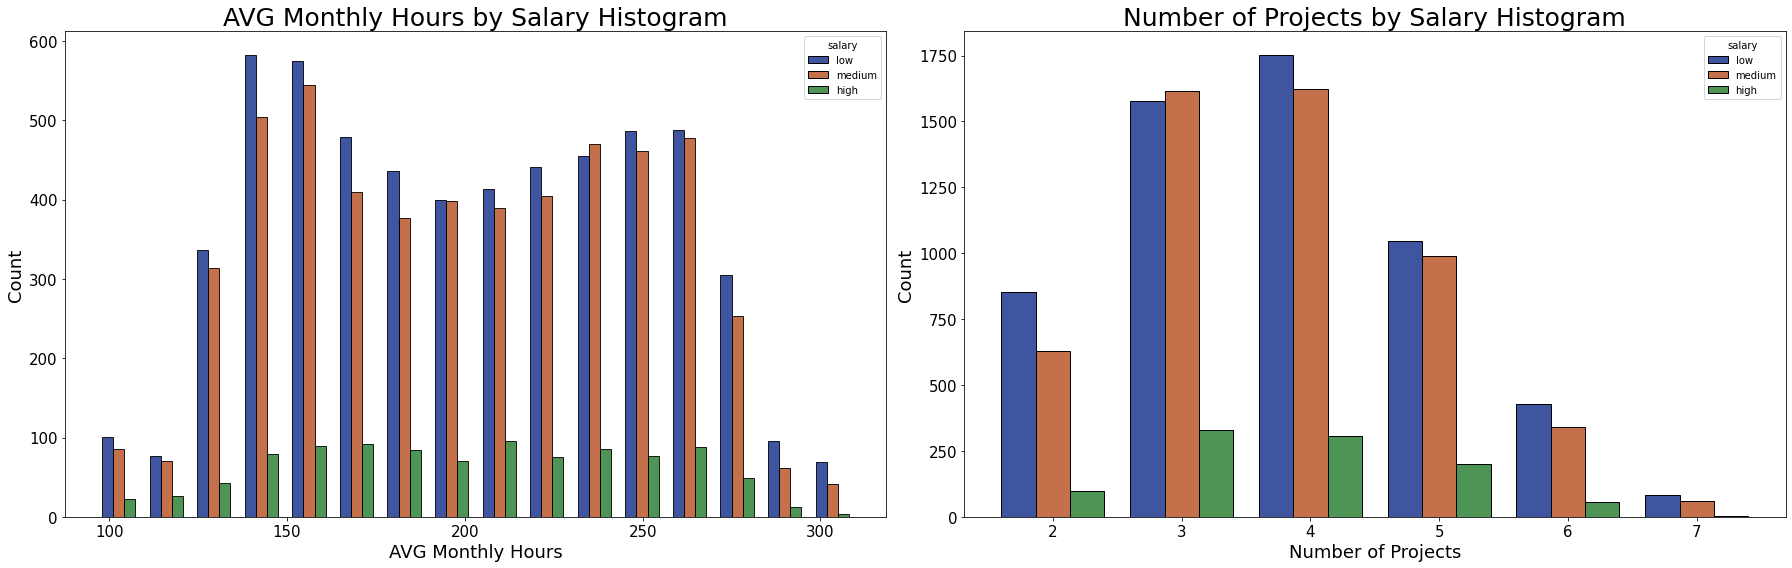

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (25,8))

# AVG Monthly Hours by Salary Histogram

fig = sns.histplot(data=df1, x='avg_monthly_hrs', bins=16, hue='salary', hue_order = ['low','medium','high'],
                  multiple='dodge', shrink=.7, palette='dark',ax=axes[0])
axes[0].set_xticks(range(100,311,50))
axes[0].set_xticklabels(range(100,311,50))
axes[0].set_xlabel('AVG Monthly Hours',fontsize=18)
axes[0].set_ylabel('Count',fontsize=18)
axes[0].set_title('AVG Monthly Hours by Salary Histogram',fontsize=25);
axes[0].tick_params(axis='both', which='major', labelsize=15)

# Number of Projects by Salary Bar Plot

fig = sns.histplot(data=df1, x='num_projects', bins=16, hue='salary', hue_order = ['low','medium','high'], 
                  multiple='dodge', discrete=True, shrink=0.8, palette='dark',ax=axes[1])
axes[1].set_xticks(range(2,8,1))
axes[1].set_xticklabels(range(2,8,1))
axes[1].set_xlabel('Number of Projects',fontsize=18)
axes[1].set_ylabel('Count',fontsize=18)
axes[1].set_title('Number of Projects by Salary Histogram',fontsize=25);
axes[1].tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

# AVG Monthly Hours by Salary Level Table

salary_order = ['low','medium','high']
salary_hrs = df1[['salary','avg_monthly_hrs']].groupby(['salary']).mean('avg_monthly_hrs').reset_index()
salary_hrs['salary'] = pd.Categorical(salary_hrs['salary'],categories=salary_order)
salary_hrs = salary_hrs.sort_values(by='salary')
salary_hrs = left_stayed_salary_cts.merge(salary_hrs, how = 'outer', on=['salary'])

# Add AVG Satisfaction Levels/AVG Number of Projects/AVG Last Eval to AVG Monthly Hours by Salary Level Table

satis_by_salary = pd.DataFrame(df1[['salary','satis_lvl']].groupby(['salary'])['satis_lvl'].mean().reset_index())
satis_by_salary['salary'] = pd.Categorical(satis_by_salary['salary'],categories=salary_order)
satis_by_salary = satis_by_salary.sort_values(by='salary')
salary_hrs = salary_hrs.merge(satis_by_salary,how='outer',on='salary')
salary_proj = pd.DataFrame(df1.groupby(['salary'])['num_projects'].mean().reset_index())
salary_proj['salary'] = pd.Categorical(salary_proj['salary'],categories=salary_order)
salary_proj = salary_proj.sort_values(by='salary')
salary_hrs = salary_hrs.merge(salary_proj,how='outer',on='salary')
salary_eval = pd.DataFrame(df1.groupby(['salary'])['last_eval'].mean().reset_index())
salary_eval['salary'] = pd.Categorical(salary_eval['salary'],categories=salary_order)
salary_eval = salary_eval.sort_values(by='salary')
salary_hrs = salary_hrs.merge(salary_eval,how='outer',on='salary')
salary_hrs = salary_hrs.rename(columns={'satis_lvl':'avg_satis_lvl','num_projects':'avg_num_proj','last_eval':'avg_last_eval'})

# Add 95% Confidence Intervals to AVG Satis Level and AVG Last Eval point estimates

avg_salary_satis_CI = pd.DataFrame(df1.groupby(by='salary').std()['satis_lvl'].reset_index())
avg_salary_satis_CI = avg_salary_satis_CI.rename(columns={'satis_lvl':'std_satis_lvl'})
avg_salary_satis_CI['salary'] = pd.Categorical(avg_salary_satis_CI['salary'],categories=salary_order)
avg_salary_satis_CI = avg_salary_satis_CI.sort_values(by='salary')
total_emp_sal = pd.DataFrame(df1['salary'].value_counts().reset_index())
total_emp_sal = total_emp_sal.rename(columns={'index':'salary','salary':'total_emp'})
avg_salary_satis_CI = avg_salary_satis_CI.merge(total_emp_sal,how='outer',on='salary')
avg_salary_satis_CI['sqrt_sample_size'] = np.sqrt(avg_salary_satis_CI['total_emp'])
avg_salary_satis_CI['est_SE'] = avg_salary_satis_CI['std_satis_lvl'] / avg_salary_satis_CI['sqrt_sample_size']
salary_satis_ci_columns = make_ci_columns(salary_hrs['avg_satis_lvl'],avg_salary_satis_CI['est_SE'])
salary_hrs = salary_hrs.merge(salary_satis_ci_columns,left_index=True,right_index=True)
salary_hrs.insert(salary_hrs.columns.get_loc("avg_num_proj"),"conf_int_lb",salary_hrs.pop("conf_int_lb"))
salary_hrs.insert(salary_hrs.columns.get_loc("avg_num_proj"),"conf_int_ub",salary_hrs.pop("conf_int_ub"))

avg_salary_eval_CI = pd.DataFrame(df1.groupby(by='salary').std()['last_eval'].reset_index())
avg_salary_eval_CI = avg_salary_eval_CI.rename(columns={'last_eval':'std_last_eval'})
avg_salary_eval_CI['salary'] = pd.Categorical(avg_salary_eval_CI['salary'],categories=salary_order)
avg_salary_eval_CI = avg_salary_eval_CI.sort_values(by='salary')
total_emp_sal = pd.DataFrame(df1['salary'].value_counts().reset_index())
total_emp_sal = total_emp_sal.rename(columns={'index':'salary','salary':'total_emp'})
avg_salary_eval_CI = avg_salary_eval_CI.merge(total_emp_sal,how='outer',on='salary')
avg_salary_eval_CI['sqrt_sample_size'] = np.sqrt(avg_salary_eval_CI['total_emp'])
avg_salary_eval_CI['est_SE'] = avg_salary_eval_CI['std_last_eval'] / avg_salary_eval_CI['sqrt_sample_size']
salary_eval_ci_columns = make_ci_columns(salary_hrs['avg_last_eval'],avg_salary_eval_CI['est_SE'])
salary_hrs = salary_hrs.merge(salary_eval_ci_columns,left_index=True,right_index=True)

# Salary by Number of Projects Table

sal_by_proj = pd.DataFrame(df1.groupby(['num_projects'])['salary'].count().reset_index())
low_sal_proj = df1[df1['salary'] == 'low']
low_sal_proj = pd.DataFrame(low_sal_proj[['num_projects','salary']].groupby(['num_projects'])['salary'].count().reset_index())
sal_by_proj = sal_by_proj.rename(columns={'salary':'total_emp'})
low_sal_proj = low_sal_proj.rename(columns={'salary':'salary_low'})
sal_by_proj = sal_by_proj.merge(low_sal_proj,how='outer',on='num_projects')
med_sal_proj = df1[df1['salary'] == 'medium']
med_sal_proj = pd.DataFrame(med_sal_proj[['num_projects','salary']].groupby(['num_projects'])['salary'].count().reset_index())
med_sal_proj = med_sal_proj.rename(columns={'salary':'salary_med'})
sal_by_proj = sal_by_proj.merge(med_sal_proj,how='outer',on='num_projects')
high_sal_proj = df1[df1['salary'] == 'high']
high_sal_proj = pd.DataFrame(high_sal_proj[['num_projects','salary']].groupby(['num_projects'])['salary'].count().reset_index())
high_sal_proj = high_sal_proj.rename(columns={'salary':'salary_high'})
sal_by_proj = sal_by_proj.merge(high_sal_proj,how='outer',on='num_projects')
sal_by_proj.insert(3,'%_low',round((sal_by_proj['salary_low'] / sal_by_proj['total_emp']),3))
sal_by_proj.insert(5,'%_med',round((sal_by_proj['salary_med'] / sal_by_proj['total_emp']),3))
sal_by_proj.insert(7,'%_high',round((sal_by_proj['salary_high'] / sal_by_proj['total_emp']),3))


display(salary_hrs.style.\
        format("{:.3f}",subset=['avg_monthly_hrs','avg_satis_lvl','conf_int_lb_x','conf_int_ub_x','avg_num_proj','avg_last_eval','conf_int_lb_y','conf_int_ub_y']).\
        format("{:.2f}",subset=['% of left','% of stayed']))
display(sal_by_proj.style.\
    applymap(lambda x: "background-color: red" if (x == 7) | (x == 0.566) | (x == 0.014) | (x == 6) | (x == 0.518) | (x == 0.068) else None).\
    applymap(lambda x: "font-weight: bold" if (x == 7) | (x == 0.566) | (x == 0.014) | (x == 6) | (x == 0.518) | (x == 0.068) else None).\
    format("{:.3f}",subset=['%_low','%_med','%_high']))

### Observations/Insights

**Average Monthly Hours.** Employees at all salary levels worked approximately the same number of hours per month on average (~ 200). As mentioned above, this is about 24 - 25 hours higher than the global average of 176 (https://everhour.com/blog/average-working-hours/).

Distributions of average hours worked per month follow approximately the same pattern across salary levels.

**Satisfaction Level.** There are slight increases in average satisfaction level from low to medium to high salary levels.

**Last Evaluation Scores.** Average last evaluation scores for employees at each salary level ranges from 70.7% *(95% CI [0.697,0.717])* - 71.9% *(95% CI [0.709,0.728])*. Average scores decrease slightly from low to medium to high salary levels.

**Number of Projects.** Employees at all salary levels had about the same number of projects on average (3.8). Unlike employees with different numbers of projects, employees with 3 projects had a higher proportion of medium salaries than low salaries.

Employees with 2, 6, and 7 projects had the highest proportions of low salaries compared to the groups of employees with different numbers of projects. 

**Employees with 7 projects had both the highest proportion of low salaries (56.6%)* and the lowest proportion of high salaries (1.4%) compared to other groups. This seems counterintuitive - you would think the employees doing the most work (assuming that a majority of employees with 7 projects were doing comparatively more work) would be getting paid the most, or at least among the most.**

**This finding regarding highest proportion of low salaries is not conclusive (see Hypothesis Test results below)*

In [58]:
# Hypothesis Testing to determine validity of the statements that employees who had 7 projects had the highest 
# proportion of low salaries and the lowest proportion of high salaries compared to other groups.

# •	H0: μ <= 0.54 (the proportion of low salaries for employees who had 7 projects is <= 0.54 (the calculated next 
#                 highest proportion among the groups of employees))
# •	Ha: μ > 0.54 (the proportion of low salaries for employees who had 7 projects is > 0.54)

# Significance Level (all tests): 5%

# One-sample z-test will be used since I am comparing one sample proportion relative to a particular value in one direction. 

tstat,pvalue = proportions_ztest(count=82, nobs=(82+61+2), value=0.54, alternative='larger', prop_var=False)

print('\033[1m7 Projects Low Salaries Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

tstat, pvalue = test_proportions_2indep(count1=82, nobs1=(82+61+2), count2=854, nobs2=(854+630+98), value=0, method=None, compare='diff', alternative='larger', correction=True, return_results=True)

print('\033[1m7 Projects Low Salaries 2Indep-Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# •	H0: μ >= 0.062 (the proportion of high salaries for employees who had 7 projects is >= 0.062 (the calculated 
#                   next highest proportion among the groups of employees))
# •	Ha: μ < 0.062 (the proportion of high salaries for employees who had 7 projects is < 0.062)

tstat,pvalue = proportions_ztest(count=2, nobs=(82+61+2), value=0.062, alternative='smaller', prop_var=False)

print('\033[1m7 Projects High Salaries Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

7 Projects Low Salaries Test Result:
T-Statistic: 0.619881284451936  p-value: 0.26766797416143095


7 Projects Low Salaries 2Indep-Test Result:
T-Statistic: 0.5811154787425149  p-value: 0.28058131356022487


7 Projects High Salaries Test Result:
T-Statistic: -4.977120555198459  p-value: 3.22685646650314e-07


### Hypothesis Testing Results

**Low Salaries Proportion Test.** The p-value for the Low Salaries test is 0.268/0.281, which is higher than the 0.05 significance level so we fail to reject the null hypothesis that the proportion of low salaries for employees with 7 projects is less than or equal to the proportion of low salaries for the next highest proportion of low salaries among the different groups (0.54). The proportion of low salaries that was calculated for employees with 7 projects is 0.566, which is pretty close to 0.54 to begin with.

I used two separate tests for 7 Projects Low Salaries since the first test resulted in a non-significant p-value. The second test uses the count of successes and number of observations in the second sample instead of the calculated value of the second sample's proportion. The second test confirmed the first test's non-significant p-value.

**High Salaries Proportion Test.** The p-value for the High Salaries test is 3.22e-07, which is less than the 0.05 significance level so we reject the null hypothesis in favor of the alternative hypothesis that the proportion of high salaries for employees with 7 projects is less than the proportion of high salaries for the next highest proportion of high salaries among the different groups (0.062).

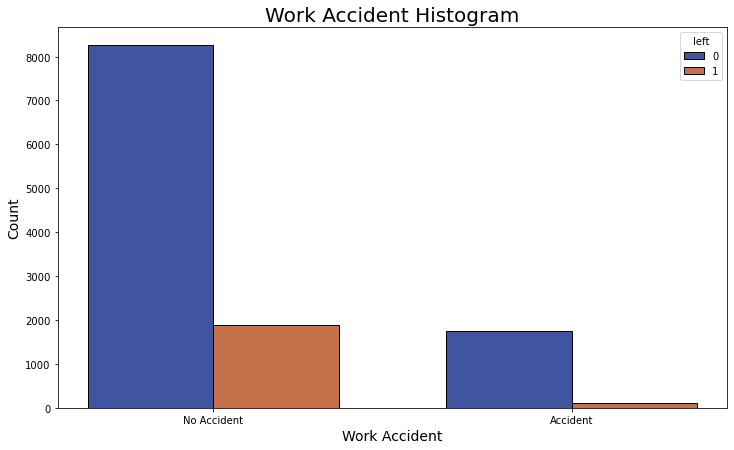

work_accident  left     %
0              0     0  0.81
1              0     1  0.19
2              1     0  0.94
3              1     1  0.06

work_accident  avg_satis_lvl  conf_int_lb_x  conf_int_ub_x  avg_num_proj  \
0              0       0.625546       0.615159       0.635932      3.805640   
1              1       0.652200       0.641813       0.662587      3.787568   

   conf_int_lb_y  conf_int_ub_y  avg_last_eval  conf_int_lb  conf_int_ub  
0       3.757642       3.853639       0.717092     0.709540     0.724644  
1       3.739569       3.835566       0.714438     0.706886     0.721990

In [24]:
# Work Accident Histogram

plt.figure(figsize=(12,7))
ax = sns.histplot(data=df1, x='work_accident', 
                  hue='left',
                  multiple='dodge',
                  discrete=1,
                  shrink=.7,
                  palette='dark')
ax.set_xticklabels(['No Accident','Accident'])
ax.set_xticks([0,1])
plt.title('Work Accident Histogram',fontsize=20);
ax.set_xlabel('Work Accident',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
plt.show()

# Work Accident Left vs. Stayed Table

left_by_accident = pd.DataFrame(round(df1.groupby(by=['work_accident'])['left'].value_counts(normalize=True),2))
left_by_accident = left_by_accident.rename(columns={'left':'%'}).reset_index()
display(left_by_accident)

# Work Accident by AVG Satisfaction Level Table

satis_by_accident = pd.DataFrame(df1[['work_accident','satis_lvl']].groupby(['work_accident'])['satis_lvl'].mean().reset_index())
satis_by_accident = satis_by_accident.rename(columns={'satis_lvl':'avg_satis_lvl'})
satis_by_accident['avg_num_proj'] = df1.groupby(['work_accident'])['num_projects'].mean()
satis_by_accident['avg_last_eval'] = df1.groupby(['work_accident'])['last_eval'].mean()

# Add 95% Confidence Intervals to AVG Satis Level/AVG Number of Projects/AVG Last Eval point estimates

avg_accident_satis_CI = pd.DataFrame(df1.groupby(by='work_accident').std()['satis_lvl'].reset_index())
avg_accident_satis_CI = avg_accident_satis_CI.rename(columns={'satis_lvl':'std_satis_lvl'})
total_emp_accident = pd.DataFrame(df1['work_accident'].value_counts().reset_index())
total_emp_accident = total_emp_accident.rename(columns={'index':'work_accident','work_accident':'total_emp'})
avg_accident_satis_CI = avg_accident_satis_CI.merge(total_emp_accident,how='outer',on='work_accident')
avg_accident_satis_CI['sqrt_sample_size'] = np.sqrt(avg_accident_satis_CI['total_emp'])
avg_accident_satis_CI['est_SE'] = avg_accident_satis_CI['std_satis_lvl'] / avg_accident_satis_CI['sqrt_sample_size']
accident_satis_ci_columns = make_ci_columns(satis_by_accident['avg_satis_lvl'],avg_accident_satis_CI['est_SE'])
satis_by_accident = satis_by_accident.merge(accident_satis_ci_columns,left_index=True,right_index=True)
satis_by_accident.insert(satis_by_accident.columns.get_loc("avg_num_proj"),"conf_int_lb",satis_by_accident.pop("conf_int_lb"))
satis_by_accident.insert(satis_by_accident.columns.get_loc("avg_num_proj"),"conf_int_ub",satis_by_accident.pop("conf_int_ub"))

avg_accident_proj_CI = pd.DataFrame(df1.groupby(by='work_accident').std()['num_projects'].reset_index())
avg_accident_proj_CI = avg_accident_proj_CI.rename(columns={'num_projects':'std_num_projects'})
total_emp_accident = pd.DataFrame(df1['work_accident'].value_counts().reset_index())
total_emp_accident = total_emp_accident.rename(columns={'index':'work_accident','work_accident':'total_emp'})
avg_accident_proj_CI = avg_accident_proj_CI.merge(total_emp_accident,how='outer',on='work_accident')
avg_accident_proj_CI['sqrt_sample_size'] = np.sqrt(avg_accident_proj_CI['total_emp'])
avg_accident_proj_CI['est_SE'] = avg_accident_proj_CI['std_num_projects'] / avg_accident_proj_CI['sqrt_sample_size']
accident_proj_ci_columns = make_ci_columns(satis_by_accident['avg_num_proj'],avg_accident_proj_CI['est_SE'])
satis_by_accident = satis_by_accident.merge(accident_proj_ci_columns,left_index=True,right_index=True)
satis_by_accident.insert(satis_by_accident.columns.get_loc("avg_last_eval"),"conf_int_lb_y",satis_by_accident.pop("conf_int_lb_y"))
satis_by_accident.insert(satis_by_accident.columns.get_loc("avg_last_eval"),"conf_int_ub_y",satis_by_accident.pop("conf_int_ub_y"))

avg_accident_eval_CI = pd.DataFrame(df1.groupby(by='work_accident').std()['last_eval'].reset_index())
avg_accident_eval_CI = avg_accident_eval_CI.rename(columns={'last_eval':'std_last_eval'})
total_emp_accident = pd.DataFrame(df1['work_accident'].value_counts().reset_index())
total_emp_accident = total_emp_accident.rename(columns={'index':'work_accident','work_accident':'total_emp'})
avg_accident_eval_CI = avg_accident_eval_CI.merge(total_emp_accident,how='outer',on='work_accident')
avg_accident_eval_CI['sqrt_sample_size'] = np.sqrt(avg_accident_eval_CI['total_emp'])
avg_accident_eval_CI['est_SE'] = avg_accident_eval_CI['std_last_eval'] / avg_accident_eval_CI['sqrt_sample_size']
accident_eval_ci_columns = make_ci_columns(satis_by_accident['avg_last_eval'],avg_accident_eval_CI['est_SE'])
satis_by_accident = satis_by_accident.merge(accident_eval_ci_columns,left_index=True,right_index=True)

display(satis_by_accident)

### Observations/Insights

**About 15.4% of employees at the company had a work accident (1,850). This is well above the average work accident levels for the UK (1.8%, https://www.hse.gov.uk/statistics/causinj/index.htm) and the US (2.8%, https://www.zippia.com/advice/workplace-injury-statistics/).** This should be addressed with Salifort Motors' EHS and management teams.

For employees who had a work accident, there was a higher percentage of employees who stayed at the company (94%) vs. employees who did not have a work accident (81%). It's possible this is because employees who had a work accident were receiving additional company benefits (i.e. worker's compensation) and so may have been incentivized to stay.

There's less than a 3% difference in average satisfaction levels between employees who had a work accident and employees who have not had a work accident. *(non-overlapping confidence intervals indicates a statistically significant difference)*

Employees who had a work accident had about the same number of projects and last evaluation scores on average as employees who have not had a work accident.

### Recommendation

<span style='background :yellow' >**EHS Program Improvement.**
    
<span style='background :yellow' >Even though a higher percentage of employees who had a work accident stayed at the company than employees who did not have a work accident, a 15.4% accident rate is too high. That's about 6 times higher than the average accident rate in the US and about 9 times higher than the average accident rate in the UK. It is important to provide a safe work environment for employees. The company's EHS team and management should work to find the root causes of these accidents and implement engineered or other best solutions to eliminate or at least mitigate the environmental factors that led to these accidents. Implementing an incentivized proactive program of identifying and correcting hazard observations throughout the company would be a good way to prevent identified hazards from causing safety incidents down the line.

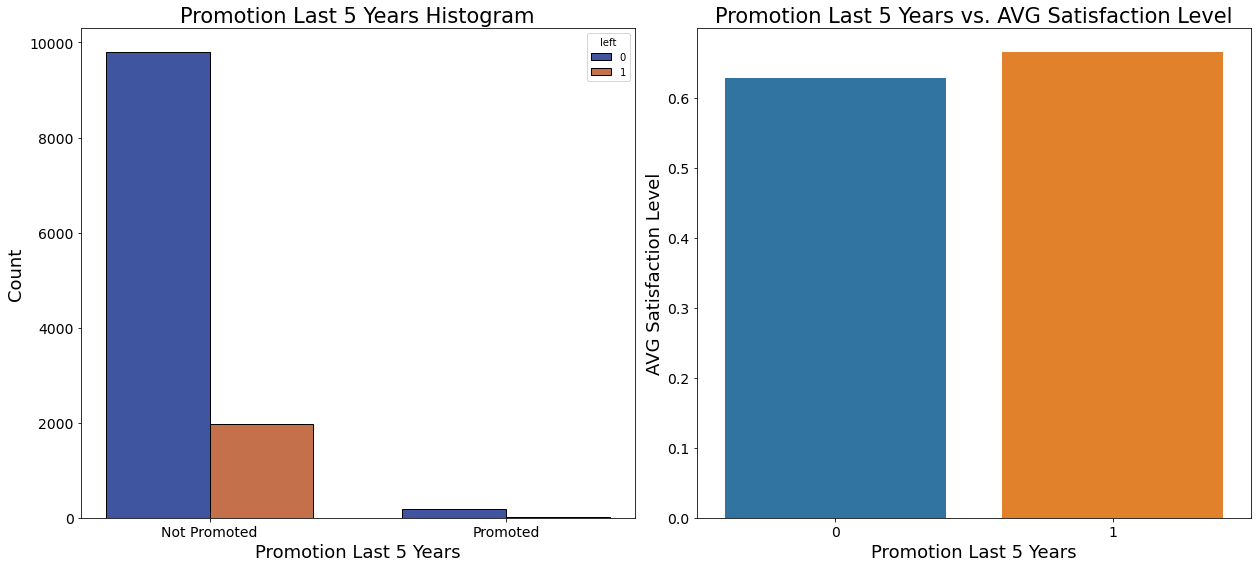

In [25]:
# Promotion Last 5 Years Histogram

fig, axes = plt.subplots(1, 2, figsize = (18,8))

fig = sns.histplot(data=df1, x='promotion_last_5yrs', hue='left', multiple='dodge', discrete=1, shrink=.7, palette='dark', ax=axes[0])
axes[0].set_xticklabels(['Not Promoted','Promoted'])
axes[0].set_xticks([0,1])
axes[0].set_title('Promotion Last 5 Years Histogram',fontsize=21);
axes[0].set_xlabel('Promotion Last 5 Years',fontsize=18)
axes[0].set_ylabel('Count',fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14);

satis_by_promotion = pd.DataFrame(df1[['satis_lvl','promotion_last_5yrs']].groupby(['promotion_last_5yrs'])['satis_lvl'].mean().reset_index())

# Promotion Last 5 Years vs. AVG Satifaction Level Bar Plot

fig = sns.barplot(x=satis_by_promotion['promotion_last_5yrs'], y=satis_by_promotion['satis_lvl'],ax=axes[1])
axes[1].set_title("Promotion Last 5 Years vs. AVG Satisfaction Level",fontsize=21)
axes[1].set_xlabel("Promotion Last 5 Years",fontsize=18)
axes[1].set_ylabel("AVG Satisfaction Level",fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14);
plt.tight_layout()
plt.show()

# Promotion Last 5 Years Left vs. Stayed Table

left_by_promotion = pd.DataFrame(round(df1.groupby(by=['promotion_last_5yrs'])['left'].value_counts(normalize=True),2))
left_by_promotion = left_by_promotion.rename(columns={'left':'%'}).reset_index()
left_num = pd.DataFrame(df1.groupby(by=['promotion_last_5yrs'])['left'].value_counts())
left_num = left_num.rename(columns={'left':'num'}).reset_index()
left_num = left_num.drop(columns='promotion_last_5yrs')
left_by_promotion = left_by_promotion.merge(left_num, how = 'outer', left_index=True, right_index=True)
left_by_promotion = left_by_promotion.rename(columns={'left_x': 'left'})
left_by_promotion = left_by_promotion.drop(columns='left_y')

display(left_by_promotion.style.\
        applymap(lambda x: "background-color: red" if ((x == 195) | (x == 8)) else None).\
        applymap(lambda x: "font-weight: bold" if ((x == 195) | (x == 8)) else None))

# Promotion Last 5 Years vs. Tenure Table

tenure_promotion = df1[['tenure','promotion_last_5yrs']][df1['promotion_last_5yrs'] == 1].groupby(['tenure']).count().reset_index()
tenure_no_promotion = df1[['tenure','promotion_last_5yrs']][df1['promotion_last_5yrs'] == 0].groupby(['tenure']).count().reset_index()
tenure_promotion_cts = tenure_promotion.merge(tenure_no_promotion, how = 'outer', on = 'tenure')
tenure_promotion_cts = tenure_promotion_cts.rename(columns={'promotion_last_5yrs_x':'promoted','promotion_last_5yrs_y':'not_promoted'})
tenure_promotion_cts.insert(2, "%_promoted", round(tenure_promotion_cts['promoted'] / (tenure_promotion_cts['promoted'] + tenure_promotion_cts['not_promoted']),3))

display(tenure_promotion_cts.style.\
    applymap(lambda x: "background-color: red" if (x == 0.011) | (x == 0.010) else None).\
    applymap(lambda x: "font-weight: bold" if (x == 0.011) | (x == 0.010) else None))

# 95% Confidence Intervals for Promotion Last 5 Yrs AVG Satisfaction Levels

promoted_df = df1[df1['promotion_last_5yrs'] == 1]
est_SE = promoted_df['satis_lvl'].std() / np.sqrt(promoted_df.shape[0])
CI_promoted_satis = stats.norm.interval(alpha=0.95, loc=promoted_df['satis_lvl'].mean(), scale=est_SE)
#print(CI_promoted_satis)

not_promoted_df = df1[df1['promotion_last_5yrs'] == 0]
est_SE = not_promoted_df['satis_lvl'].std() / np.sqrt(not_promoted_df.shape[0])
CI_not_promoted_satis = stats.norm.interval(alpha=0.95, loc=not_promoted_df['satis_lvl'].mean(), scale=est_SE)
#print(CI_not_promoted_satis)

### Observations/Insights

**Only 203 employees were promoted in the last 5 years (about 1.7% of all employees).** By contrast, approximately 8.9% of employees in the US are promoted ***annually*** (https://www.adp.com/resources/articles-and-insights/adp-research-institute/research-topics/-/media/62FB03253C3B4B80A2EE73EB8EC29B82.ashx). This means, over 5 years, about 45% of employees in the US will have been promoted. That's a huge gap between Salifort's promotion rate and the US national average. This should be addressed with Salifort's management team and HR.

17% of employees who were not promoted in the last 5 years left the company whereas just 4% of employees who were promoted in the last 5 years left.

**Tenure. Employees with 4 and 5 years tenure had the lowest promotion rates compared to all other tenure groups in the company.**

**Satisfaction Level.** Employees who have been promoted in the last 5 years have a slightly higher satisfaction level on average *(95% CI [0.637194,0.694825])* compared to employees who have not been promoted in the last 5 years *(95% CI [0.624671,0.633392])*. *(non-overlapping confidence intervals indicates a statistically significant difference)*

### Recommendation

<span style='background :yellow' >**Employee Promotions.**
    
<span style='background :yellow' >Not enough employees are being promoted overall. The US average promotion rate of 45% over 5 years is about ***26*** times higher than Salifort's 5 year promotion rate.
    
<span style='background :yellow' >**In addition to working on the most projects, having the highest evaluation scores, and having among the lowest salaries in the company, employees with 4 and 5 years tenure also have the lowest promotion rates in the company.**
    
<span style='background :yellow' >**Promotion is another tool management can use to retain employees, especially top talent employees deserving of it. Management and HR should look at employee promotions across the board and ensure that consistent promotion criteria is used throughout the company and that the employees most deserving of promotion get promoted.** 

In [42]:
# Hypothesis Testing to determine validity of the statement that employees with 4 and 5 years tenure had the lowest 
# promotion rates in the company.

# •	H0: p4 - p2 = -0.002 (the difference in proportions of employees promoted who had 4 years and 2 years tenure is 
#                         equal to -0.002)
# •	Ha: p4 - p2 > -0.002 (the difference in proportions of employees promoted who had 4 years and 2 years tenure is 
#                         > -0.002)

# Significance Level (all tests): 5%

# Test for two independent proportions will be used since I am comparing one sample proportion (promotion rate for 
# 4/5 years tenure employees) to another sample proportion (the next lowest calculated promotion rate among the tenure groups)

tstat, pvalue = test_proportions_2indep(count1=22, nobs1=22+1983, count2=39, nobs2=39+2871, value=-0.002, method=None, compare='diff', alternative='larger', correction=True, return_results=True)

print('\033[1mTenure 4 Test Result:\033[0m')
print('T Statistic:',tstat,' p-value:',pvalue)
print('\n')

# •	H0: p5 - p2 = -0.003 (the difference in proportions of employees promoted who had 5 years and 2 years tenure is 
#                         equal to -0.003)
# •	Ha: p5 - p2 > -0.003 (the difference in proportions of employees promoted who had 5 years and 2 years tenure is 
#                         > -0.003)

tstat, pvalue = test_proportions_2indep(count1=11, nobs1=11+1051, count2=39, nobs2=39+2871, value=-0.003, method=None, compare='diff', alternative='larger', correction=True, return_results=True)

print('\033[1mTenure 5 Test Result:\033[0m')
print('T Statistic:',tstat,' p-value:',pvalue)

Tenure 4 Test Result:
T Statistic: -0.08612791164957581  p-value: 0.5343176321136601


Tenure 5 Test Result:
T Statistic: 0.13931182438549108  p-value: 0.44460187324392497


### Hypothesis Testing Results

The p-values for both tests are greater than the significance level (0.05) so we fail to reject the null hypotheses that the differences in proportions between Tenures 4 and 5 promotion rates and the Tenure 2 promotion rate are equal to the calculations from the sample measures used.

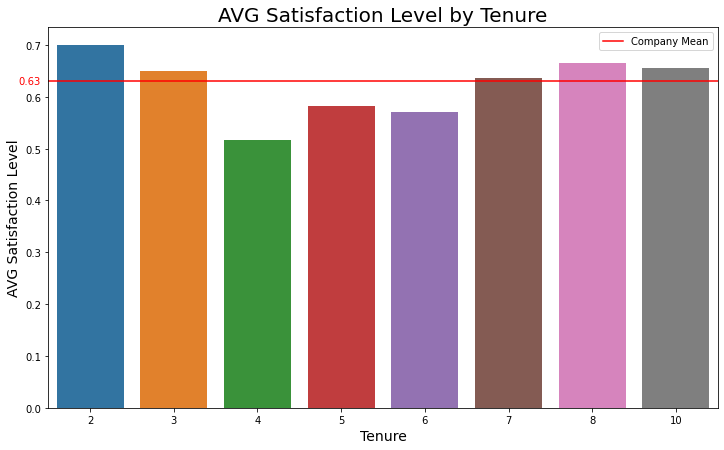

In [26]:
# Tenure by AVG Satisfaction Level Table

tenure_satis = df1[['tenure','satis_lvl']].groupby(['tenure'])['satis_lvl'].mean().reset_index()
tenure_satis['satis_lvl'] = round(tenure_satis['satis_lvl'],6)
tenure_satis = tenure_satis.rename(columns={'satis_lvl':'avg_satis_lvl'})

# Add 95% Confidence Intervals to AVG Satis Level/AVG Number of Projects/AVG Last Eval point estimates

avg_tenure_satis_CI = pd.DataFrame(df1.groupby(by='tenure').std()['satis_lvl'].reset_index())
avg_tenure_satis_CI = avg_tenure_satis_CI.rename(columns={'satis_lvl':'std_satis_lvl'})
total_emp_tenure = pd.DataFrame(df1['tenure'].value_counts().reset_index())
total_emp_tenure = total_emp_tenure.rename(columns={'index':'tenure','tenure':'total_emp'})
avg_tenure_satis_CI = avg_tenure_satis_CI.merge(total_emp_tenure,how='outer',on='tenure')
avg_tenure_satis_CI['sqrt_sample_size'] = np.sqrt(avg_tenure_satis_CI['total_emp'])
avg_tenure_satis_CI['est_SE'] = avg_tenure_satis_CI['std_satis_lvl'] / avg_tenure_satis_CI['sqrt_sample_size']
tenure_satis_ci_columns = make_ci_columns(tenure_satis['avg_satis_lvl'],avg_tenure_satis_CI['est_SE'])
tenure_satis = tenure_satis.merge(tenure_satis_ci_columns,left_index=True,right_index=True)

# Tenure vs. AVG Satisfaction Level Bar Plot

plt.figure(figsize=(12,7))
ax = sns.barplot(x=tenure_satis['tenure'], y=tenure_satis['avg_satis_lvl'])
ax.axhline(df1['satis_lvl'].mean(),color='r',label='Company Mean')
plt.title("AVG Satisfaction Level by Tenure",fontsize=20)
plt.xlabel("Tenure",fontsize=14)
plt.ylabel("AVG Satisfaction Level",fontsize=14)
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
ax.text(0,0.6296580768909951, "{:.2f}".format(0.6296580768909951), color="red", transform=trans, ha="right", va="center")
ax.legend()
plt.show()

display(tenure_satis.style.\
    applymap(lambda x: "background-color: red" if ((x == 0.516090) | (x == 0.583183) | (x == 0.571107) | (x == 4) | (x == 5)  | (x == 6)) else None).\
    applymap(lambda x: "font-weight: bold" if ((x == 0.516090) | (x == 0.583183) | (x == 0.571107) | (x == 4) | (x == 5)  | (x == 6)) else None))

### Observations/Insights

**Based on previous findings, it's no surprise that employees with 4-6 years tenure have the lowest satisfaction levels in the company (ranging from 0.52 *(95% CI [0.474720,0.557460])* - 0.58 *(95% CI [0.541813,0.624553])* on average).**

Employees with 2 years tenure have the highest average satisfaction level of about 0.7 *(95% CI [0.657795,0.740535])*. Employees with 3, 7, 8, and 10 years tenure all have above average satisfaction levels.

In [57]:
# Hypothesis Testing to determine validity of the statement that employees with 4 - 6 years tenure have the lowest 
# satisfaction levels in the company.

# •	H0: the mean satisfaction levels for employees with 4-6 years tenure are = the mean for employees 
#       with 7 years tenure (the next lowest calculated mean last evaluation score)
# •	Ha: the mean satisfaction levels for employees with 4-6 years tenure are < the mean for employees 
#       with 7 years tenure

# Significance Level: 5%

# 4 Years Tenure Test

four_tenure_satis = df1[df1['tenure'] == 4]
four_tenure_satis = four_tenure_satis[['satis_lvl']]
seven_tenure_satis = df1[df1['tenure'] == 7]
seven_tenure_satis = seven_tenure_satis[['satis_lvl']]
      
tstat, pvalue = stats.ttest_ind(a=four_tenure_satis, b=seven_tenure_satis, alternative='less', equal_var=False)

print('\033[1m4 Years Tenure Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# 5 Years Tenure Test

five_tenure_satis = df1[df1['tenure'] == 5]
five_tenure_satis = five_tenure_satis[['satis_lvl']]

tstat, pvalue = stats.ttest_ind(a=five_tenure_satis, b=seven_tenure_satis, alternative='less', equal_var=False)

print('\033[1m5 Years Tenure Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)
print('\n')

# 6 Years Tenure Test

six_tenure_satis = df1[df1['tenure'] == 6]
six_tenure_satis = six_tenure_satis[['satis_lvl']]

tstat, pvalue = stats.ttest_ind(a=six_tenure_satis, b=seven_tenure_satis, alternative='less', equal_var=False)

print('\033[1m6 Years Tenure Test Result:\033[0m')
print('T-Statistic:',tstat,' p-value:',pvalue)

4 Years Tenure Test Result:
T-Statistic: [-4.57675742]  p-value: [6.38200493e-06]


5 Years Tenure Test Result:
T-Statistic: [-1.97135576]  p-value: [0.02552278]


6 Years Tenure Test Result:
T-Statistic: [-2.31753671]  p-value: [0.01096996]


### Hypothesis Testing Results

The p-values for all three tests are less than the significance level (0.05) so we reject the null hypotheses that the mean satisfaction levels for employees with 4-6 years tenure are equal to the mean for employees with 7 years tenure (the next lowest calculated mean satisfaction level) in favor of the alternative hypotheses that the mean satisfaction levels for employees with 4-6 years tenure are less than the mean for employees with 7 years tenure.

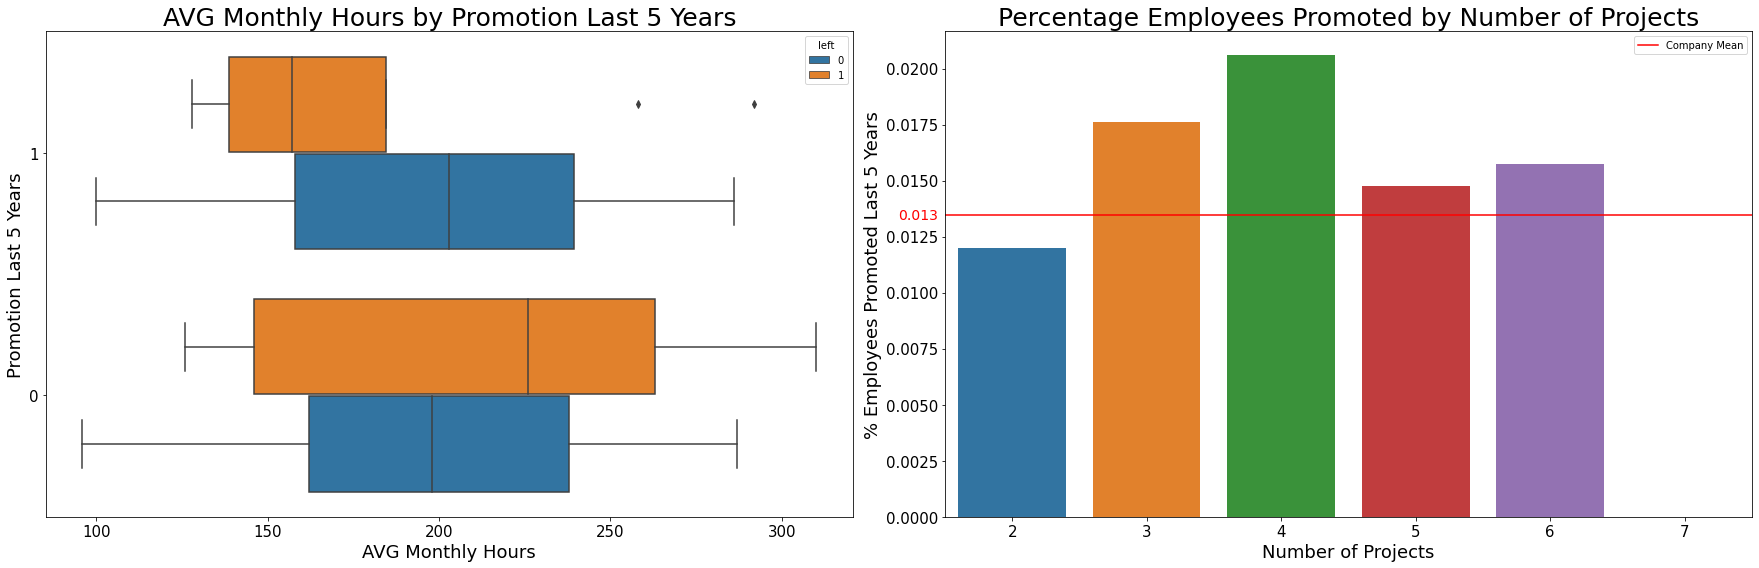

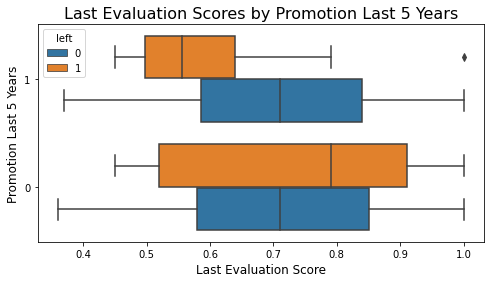

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (25,8))

# AVG Monthly Hrs vs. Promotion Last 5 Yrs Boxplot

fig = sns.boxplot(x=df1['avg_monthly_hrs'],y=df1['promotion_last_5yrs'],hue=df1['left'],orient="h",ax=axes[0]);
axes[0].set_title('AVG Monthly Hours by Promotion Last 5 Years',fontsize=25);
axes[0].set_xlabel('AVG Monthly Hours',fontsize=18);
axes[0].set_ylabel('Promotion Last 5 Years',fontsize=18);
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].invert_yaxis()

# Percentage Employees Promoted by Number of Projects Table

promoted_by_projects = df1[['num_projects','promotion_last_5yrs']].groupby(['promotion_last_5yrs'])['num_projects'].mean().reset_index()
projects_promoted = df1[df1['promotion_last_5yrs'] == 1]
projects_promoted = projects_promoted[['num_projects','promotion_last_5yrs']].groupby(['num_projects'])['promotion_last_5yrs'].count().reset_index()
left_by_numprojects['promoted_last_5yrs'] = [19,62,76,33,13,0]
left_by_numprojects['%_promoted'] = left_by_numprojects['promoted_last_5yrs'] / left_by_numprojects['total_emp']
df1[(df1['promotion_last_5yrs'] == 1) & (df1['num_projects'] == 7)].shape[0]
promoted_by_eval = df1[['last_eval','promotion_last_5yrs','left']].groupby(['promotion_last_5yrs','left'])['last_eval'].mean().reset_index()
promoted_by_eval = promoted_by_eval.rename(columns={'last_eval':'avg_last_eval'})
promoted_med_eval = df1[['last_eval','promotion_last_5yrs','left']].groupby(['promotion_last_5yrs','left'])['last_eval'].median().reset_index()
promoted_med_eval = promoted_med_eval.rename(columns={'last_eval':'med_last_eval'})
promoted_med_eval = promoted_med_eval.drop(columns=['left','promotion_last_5yrs'])
promoted_by_eval = promoted_by_eval.merge(promoted_med_eval,left_index=True,right_index=True)

# Add 95% Confidence Intervals to AVG Last Eval point estimates

avg_promotion_eval_CI = pd.DataFrame(df1.groupby(by='promotion_last_5yrs').std()['last_eval'].reset_index())
avg_promotion_eval_CI = avg_promotion_eval_CI.rename(columns={'last_eval':'std_last_eval'})
total_emp_promotion = pd.DataFrame(df1['promotion_last_5yrs'].value_counts().reset_index())
total_emp_promotion = total_emp_promotion.rename(columns={'index':'promotion_last_5yrs','promotion_last_5yrs':'total_emp'})
avg_promotion_eval_CI = avg_promotion_eval_CI.merge(total_emp_promotion,how='outer',on='promotion_last_5yrs')
avg_promotion_eval_CI['sqrt_sample_size'] = np.sqrt(avg_promotion_eval_CI['total_emp'])
avg_promotion_eval_CI['est_SE'] = avg_promotion_eval_CI['std_last_eval'] / avg_promotion_eval_CI['sqrt_sample_size']
promotion_eval_ci_columns = make_ci_columns(promoted_by_eval['avg_last_eval'],avg_promotion_eval_CI['est_SE'])
promoted_by_eval = promoted_by_eval.merge(promotion_eval_ci_columns,left_index=True,right_index=True)
promoted_by_eval.insert(promoted_by_eval.columns.get_loc("med_last_eval"),"conf_int_lb",promoted_by_eval.pop("conf_int_lb"))
promoted_by_eval.insert(promoted_by_eval.columns.get_loc("med_last_eval"),"conf_int_ub",promoted_by_eval.pop("conf_int_ub"))

# Percentage Employees Promoted by Number of Projects Bar Plot

fig = sns.barplot(x=left_by_numprojects['num_projects'], y=left_by_numprojects['%_promoted'],ax=axes[1])
axes[1].axhline(left_by_numprojects['%_promoted'].mean(),color='r',label='Company Mean')
axes[1].set_title("Percentage Employees Promoted by Number of Projects",fontsize=25)
axes[1].set_xlabel("Number of Projects",fontsize=18)
axes[1].set_ylabel("% Employees Promoted Last 5 Years",fontsize=18)
trans = transforms.blended_transform_factory(axes[1].get_yticklabels()[0].get_transform(), axes[1].transData) # https://stackoverflow.com/questions/42877747/add-a-label-to-y-axis-to-show-the-value-of-y-for-a-horizontal-line-in-matplotlib
axes[1].text(0,0.013460787670599357, "{:.3f}".format(0.013460787670599357), color="red", transform=trans, ha="right", va="center",fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].legend()
plt.tight_layout()
plt.show()

# Last Evaluation Scores vs. Promotion Last 5 Yrs Boxplot

plt.figure(figsize=(8,4))
ax = sns.boxplot(x=df1['last_eval'],y=df1['promotion_last_5yrs'],hue=df1['left'],orient="h");
ax.set_title('Last Evaluation Scores by Promotion Last 5 Years',fontsize=16);
ax.set_xlabel('Last Evaluation Score',fontsize=12);
ax.set_ylabel('Promotion Last 5 Years',fontsize=12);
ax.tick_params(axis='both', which='major', labelsize=10)
ax.invert_yaxis()
plt.show()

display(promoted_by_eval.style.\
    applymap(lambda x: "background-color: red" if x == 0.613750 else None).\
    applymap(lambda x: "font-weight: bold" if x == 0.613750 else None))

### Observations/Insights

**AVG Monthly Hours.** Employees who were promoted in the last 5 years and left the company worked fewer hours per month on average overall than employees who were not promoted in the last 5 years and left the company.

Employees who stayed at the company worked approximately the same number of hours per month on average whether they were promoted in the last 5 years or not.

**Number of Projects.** Employees with 4 projects had the highest percentage of employees who were promoted in the last 5 years (2.06%) compared to employees who had different numbers of projects. 

**No employees who had 7 projects were promoted in the last 5 years.**

**Last Evaluation Scores.** Of employees who left the company, those who were not promoted in the last 5 years had last evaluation scores over 10% higher on average and a median last evaluation score over 20% higher than employees who were promoted.

Employees who were promoted in the last 5 years and left the company had the lowest last evaluation scores on average (about 10% lower than all other employees) compared to employees who were not promoted and left and employees who stayed at the company.

Employees who stayed at the company had about the same last evaluation scores regardless of whether they were promoted in the last 5 years or not.

# EDA Summary <a class="anchor" id="edasummary"></a>

[Go Back to Table of Contents](#toc)

*Findings in this summary are grouped in order by the top 5 important variables in the champion predictive models that will be used to predict whether employees will leave the company.*

### <u>Focus Groups (employees who left)</u>:
- Employees working 240+ average monthly hours (large overlap with sub-bullets)
    - 0.8+ last evaluation score and 0.1 satisfaction score
    - 6 and (especially) 7 projects
    - low salaries
    - no promotions
- Employees with 4 - 6 years tenure

### <span style='background :red' >***COMMON THEME: OVERWORKED AND NOT REWARDED***

----------------------------------------------------
### **<u>Focus Groups (employees who stayed)</u>:**
- Employees working 140 - 160 average monthly hours
- Management
- Employees with 3-4 projects
- Employees with 7, 8, 10 years tenure
- Employees with high salaries

----------------------------------------------------    
## High-Level Summary Statistics

The mean satisfaction level for employees who left is **0.44** *(95% CI [0.429, 0.452])* vs. **0.67** *(95% CI [0.663, 0.672])* for employees who stayed.

A majority of employees have not been promoted in the last 5 years for both employees who left and those who stayed.

A majority of employees have not had a work accident for both employees who left and those who stayed.

The Sales department has more employees than any other department for both employees who left and those who stayed.

More employees have low salary levels vs. medium or high salary levels for both employees who left and those who stayed.

The mean number of projects per employee was about **3.9** *(95% CI [3.804, 3.963])* for those who left the company and **3.8** *(95% CI [3.768, 3.806])* for those who stayed at the company.

The mean last evaluation score for both employees who left and those who stayed was about **0.72** *(95% CI [0.713, 0.73] for those who left and 95% CI [0.712, 0.719] for those who stayed)*.

Based on these summary statistics, employees who left the company had lower overall satisfaction level scores and worked more hours per month on average.

------------------------------------
    
## Satisfaction Level

The mean satisfaction level for employees who left is **0.44** *(95% CI [0.429, 0.452])* vs. **0.67** *(95% CI [0.663, 0.672])* for employees who stayed.

All departments, with the exception of Accounting, have about the same average satisfaction level and the company's overall average satisfaction level is about 63% (which is low).

**Accounting had the lowest average satisfaction level (60.8%) *(95% CI [0.587,0.629])* and the highest percentage of employees leave the company (17.6%) compared to other departments.***

*This finding is not conclusive (see Hypothesis Test results and overlapping Confidence Intervals in the table above)

**All employees who had 7 projects left the company. About 54% of employees who had 2 projects left and about 45% of employees who had 6 projects left. These groups of employees (especially employees with 6 and 7 projects) had the lowest average satisfaction levels in the company, ranging from ~0.12 *(95% CI [0.105,0.129])* to ~0.50 *(95% CI [0.487,0.511])*.**

Employees who had 3-5 projects had the lowest percentages of employees leave the company (as a percentage of other employees who had the same number of projects) as well as had the highest average satisfaction levels in the company, ranging from ~0.67 *(95% CI [0.659,0.683])* to ~0.70 *(95% CI [0.682,0.706])*.

Employees who had 2 projects made up the highest percentage of total employees who left the company compared to other number of projects groups at about 43%.

A majority of the company's employees had either 3 or 4 projects. Employees who had 3 projects had the lowest percentage of employees who left the company, closely followed by employees who had 4 projects. 3-4 projects might be the ideal number of projects for most employees to maximize employee satisfaction.

The satisfaction levels with greatest number of employees who left the company were around 0.1 and 0.4-0.5 (which are low) and the next greatest number of employees who left the company occurred at satisfaction levels between about 0.7 and 0.9. It makes sense that the greatest number of employees who left occurred at low satisfaction levels. It is unclear why the employees at the higher satisfaction levels left. They may have been satisfied in their work at the time but just found opportunities elsewhere that were the next best step for them in their career.

Of the employees who stayed at the company, the bulk of them had satisfaction levels between about 0.5 and 0.95 (the upper end of the range). A good satisfaction level would probably be at least 0.8, but a lot of employees who stayed were between 0.5 and 0.8. Many employees who aren't particularly satisfied may stay in their job because they feel they don't have a better opportunity elsewhere, have been with the company for a long time and don't want to introduce change/instability into their life (change is uncomfortable), are hopeful that things will get better, or some other reason.

The AVG Monthly Hours vs. Satisfaction Level scatterplot further supports the theory from the AVG Monthly Hours histogram. There appear to be 3 clusters of employees who left. One cluster was working about 130-160 hours per month and is around 0.4 satisfaction level. This group of employees possibly knew they were going to quit soon and were deliberately working fewer hours. The plot adds the dimension of having a low satisfaction level to that group. Next, there is a cluster of employees who left that were working around 240-310 hours per month and is around a 0.1 satisfaction level. Similarly, this plot adds the low satisfaction level to the same group identified in the AVG Monthly Hours histogram. This group of employees who left had the lowest satisfaction level of all employees in the company. This further supports the theory that they were being overworked. The third cluster of employees who left occurs around 220-270 hours worked per month but the satisfaction level is higher, around 0.7 - 0.9. As mentioned previously, these employees may have been satisfied in their work at the time but may have found opportunities elsewhere that were the next best step for them in their career and/or that paid the same or higher amount with fewer hours of work required.

Additionally, as mentioned previously, the bulk of employees who stayed at the company had satisfaction levels between about 0.5 and 0.95 and worked between about 130-270 hours per month, on average.

**The distribution of the 3 clusters of employees who left the company in the Last Evaluation Score vs. Satisfaction Level scatterplot is almost identical to the distribution of the 3 clusters of employees who left the company in the AVG Monthly Hours vs. Satisfaction Level scatterplot.** This leads me to believe there is likely a strong correlation between AVG Monthly Hours and Last Evaluation Score, at least for the employees who left the company.

There are two groups of employees who left with higher last evaluation scores and a group with lower evaluation scores. One group with higher last evaluation scores ranged from about 0.78 - 0.98 last evaluation scores and around 0.1 satisfaction score. This appears to be that same group of employees with low satisfaction levels and high average monthly hours identified previously. The other group with higher last evaluation scores ranged from about 0.8 - 1.0 last evaluation scores and around 0.7 - 0.9 satisfaction scores. This appears to be the same group of employees with higher satisfaction levels and high average monthly hours identified previously. The group with lower evaluation scores ranged from about 0.45 - 0.57 evaluation scores and around a 0.5 satisfaction score. This may be the same group of employees who had the same satisfaction level and lower average monthly hours worked per month. It's possible this group of employees knew they would be leaving soon because of their low last evaluation score and purposely worked fewer hours per month, on average.

Of the employees who stayed at the company, the bulk of them had last evaluation scores ranging from about 0.5 - 1.0 and satisfaction levels ranging from about 0.5 - 1.0.

There are slight increases in average satisfaction level from low to medium to high salary levels.

There's less than a 3% difference in average satisfaction levels between employees who had a work accident and employees who have not had a work accident. *(non-overlapping confidence intervals indicates a statistically significant difference)*

Employees who have been promoted in the last 5 years have a slightly higher satisfaction level on average *(95% CI [0.637194,0.694825])* compared to employees who have not been promoted in the last 5 years *(95% CI [0.624671,0.633392])*. *(non-overlapping confidence intervals indicates a statistically significant difference)*

**Based on previous findings, it's no surprise that employees with 4-6 years tenure have the lowest satisfaction levels in the company compared to other tenure groups (ranging from 0.52 *(95% CI [0.474720,0.557460])* - 0.58 *(95% CI [0.541813,0.624553])* on average).**

Employees with 2 years tenure have the highest average satisfaction level of about 0.7 *(95% CI [0.657795,0.740535])*.

-------------------------------------
    
## Average Monthly Hours

Average monthly hours for employees who left is **208** *(95% CI [205.47, 210.855])* vs. **199** *(95% CI [198.048, 199.838])* for employees who stayed.

All departments have about the same average working hours per month and **the company's average hours worked per month (200.5) *(95% CI [199.601359,201.345684])* is about 25 hours higher than the global average of 176 (https://everhour.com/blog/average-working-hours/).**

Overall, there is a general trend that employees who left the company spent more hours working with each addition of a new project whereas those employees who stayed at the company overall spent about the same number of hours working with each addition of a new project. It would be worthwhile to find out what the employees who stayed are doing differently to spend less hours with the same number of projects. This could provide insight into who is able to handle more projects skillfully and when to give more or fewer projects to an employee.

Unlike the groups of employees who had 3+ projects, the employees with 2 projects who left worked significantly fewer hours overall than those employees with 2 projects who stayed. It is possible that a majority of this group of employees who left were underperformers who were let go.

**Most employees who left were either working on the lower end of the range (126-160 hours per month) or on the higher end of the range (216-310 hours per month).** It's possible that the employees who left who were working on the lower end of the range knew they were going to leave soon and purposely worked fewer hours. It's also possible that the employees who left who were working on the higher end of the range left because they were being overworked.

The bulk of the employees who stayed were working between about 130 and 270 hours per month. The highest spike in the distribution of employees who stayed occurs around 145-160 hours, which reduces approximately to the standard 8-hour workday.

When looking at the relationship between average monthly hours and last evaluation scores, there are two main groups of employees who left the company. The first group worked between about 130 - 160 hours on average per month and had last evaluation scores ranging from about 0.45 - 0.58. The second group worked between about 240 - 310 hours on average per month and had last evaluation scores ranging from about 0.78 - 1.0.

Of the employees who stayed at the company, the bulk of them worked between about 130 - 270 hours per month on average and had last evaluation scores ranging from about 0.5 - 1.0.

The distributions of employees who stayed at the company are fairly centered around 200 average monthly hours across tenure. This is contrasted with the more widely varying distributions of employees who left the company, whose distributions, with the exception of tenure = 3 years, are all centered above 200 average monthly hours -  closer to 250 hours. The distribution of the 3-year tenured employees who left is centered closer to 150 hours with several outliers on the upper end of the range. This exception might be worth investigating further.

Employees at all salary levels worked approximately the same number of hours per month on average (~ 200). As mentioned above, this is about 24 - 25 hours higher than the global average of 176 (https://everhour.com/blog/average-working-hours/).

Distributions of average hours worked per month follow approximately the same pattern across salary levels.

Employees who were promoted in the last 5 years and left the company worked fewer hours per month on average overall than employees who were not promoted in the last 5 years and left the company.

Employees who stayed at the company worked approximately the same number of hours per month on average whether they were promoted in the last 5 years or not.

-----------------------------
    
## Tenure

**The greatest numbers of employees who left the company had tenures ranging from 3-5 years, with 3 years having the most employees who left.**

The greatest numbers of employees who stayed at the company had tenures ranging 2-4 years, with 3 years also having the most employees who stayed (there were far more employees with 3 years tenure overall than any other single tenure group). All employees with tenures 7, 8, and 10 stayed at the company (there were no employees with 9 years tenure).

**Over 45% of employees with 5 years tenure left the company. That's almost double the percentage of the next highest group (24.7% of employees with 4 tenures left).**

The mean tenure of all employees at the company is 3.36 years *(95% CI [3.341047,3.388666])*. The mean tenure at a company for employees in the UK is about 8 years as of 2019 (https://www.statista.com/chart/20571/average-time-spend-with-one-employer-in-selected-oecd-countries/) and 5.2 years in the US for the manufacturing industry specifically (https://www.zippia.com/advice/average-employee-tenure/).

**The greatest numbers of employees who left the company had tenure 3 - 5 years (as mentioned above) and were working about 270+ hours per month, on average.**

Management has the highest average tenure compared to other departments at 3.98 years *(95% CI [3.870109,4.093194])* and HR has the lowest average tenure at 3.26 years *(95% CI [3.144697,3.367782])*.

**Employees with 4-6 years tenure had the highest number of projects on average and also had the highest percentages of employees at the same tenure who left the company, in the same order (i.e. 5 years had the highest average number of projects and percentage of employees leave, 4 years had the second highest in both, and 6 years had the third highest in both). As mentioned above, employees with 4 and 5 years tenure not only had the highest percentages of employees leave but also had the highest numbers of employees that left the company.**

**This supports the earlier recommendation for managers not to assign more than 3-4 projects to the majority of employees.**

For employees who left, the lowest average last evaluation scores were in employees with 2-3 years tenure, with tenure = 3 having the lowest average score of 0.52 *(95% CI [0.492,0.552])*. Employees with tenure = 3 also make up the largest portion of the population compared to other tenure groups, which is why the average for all tenure groups of employees who left is so much lower than the much higher average evaluation scores of tenure groups 2 and 4-6 for employees who left. 

The highest average scores for employees who left were in employees with 4-6 years tenure, with tenure = 6 having the highest average score of 0.91 *(95% CI [0.879,0.939])* (0.2 above the average score of employees who stayed). **Employees who left who had 4-6 years tenure had average evaluation scores well above the average evaluation scores for employees who stayed (across all tenures). Their average scores ranged from 0.86 - 0.91 vs. the highest average score for employees who stayed of 0.73 *(95% CI [0.701578,0.761412])*. It's possible that this group of employees who left were top performers who found better opportunities elsewhere to advance their careers.**

For employees who stayed, average last evaluation scores are more consistent across tenure. Employees who stayed with 7 years tenure had the lowest average score of 0.68 *(95% CI [0.650117,0.715414])* and employees who stayed with 10 years tenure had the highest average score of 0.73 *(95% CI [0.701578,0.761412])*.

There are more employees with low salaries from tenure 2 - 5 than with medium or high salaries. From tenure 6 - 10, there are more employees with medium salaries than with low or high salaries.

Employees with high salaries at the upper range of tenure (7, 8, and 10) make up a larger proportion of the employees at those tenures than at the lower range of tenure.

Employees with tenure = 5 who left the company made up the highest percentage of all employees at the same tenure who had low salaries (~ 52%). This group of employees also made up the highest percentage of all employees who left the company at the same tenure (45%). It's possible that low salaries contributed to the employees with tenure = 5 deciding to leave the company. It's possible they expected higher salaries at that point in their career but they never received commensurate pay raises.
  
**In addition to working on the most number of projects and having the highest last evaluation scores, employees with tenures 4* and 5 years also had the highest percentages of low salaries compared to all other tenure groups.**

**This finding is not conclusive for tenure 4 employees (see Hypothesis Test results above)*  

**Employees with 4 and 5 years tenure had the lowest promotion rates compared to all other tenure groups in the company.**

----------------------------------------
    
## Number of Projects (remaining observations)

**Employees with 7 projects had the highest average last evaluation score (86.4%) *(95% CI [0.847677,0.879358])* and employees with 2 projects had the lowest average last evaluation score (58.5%) *(95% CI [0.568799,0.600480])*.**

Average last evaluation scores increase by number of projects. The biggest increases in eval scores are from 2 to 3 projects and from 6 to 7 projects.
    
Employees with 2, 6, and 7 projects had the highest proportions of low salaries compared to the groups of employees with different numbers of projects. 

**Employees with 7 projects had both the highest proportion of low salaries (56.6%)* and the lowest proportion of high salaries (1.4%) compared to other groups. This seems counterintuitive - you would think the employees doing the most work (assuming that a majority of employees with 7 projects were doing comparatively more work) would be getting paid the most, or at least among the most.**
    
**This finding regarding highest proportion of low salaries is not conclusive (see Hypothesis Test results above)*
    
**No employees who had 7 projects were promoted in the last 5 years.**
    
All departments have about the same average number of projects per employee, with Technical and RandD having the highest (3.86 *(95% CI [3.751974,3.966386])* and 3.85 *(95% CI [3.742938,3.957350])*, respectively) and HR and Marketing having the lowest (3.68 *(95% CI [3.568335,3.782747])* and 3.72 *(95% CI [3.613448,3.827860])*, respectively).

Employees at all salary levels had about the same number of projects on average (3.8). Unlike employees with different numbers of projects, employees with 3 projects had a higher proportion of medium salaries than low salaries.

Employees who had a work accident had about the same number of projects and last evaluation scores on average as employees who have not had a work accident.

Employees with 4 projects had the highest percentage of employees who were promoted in the last 5 years (2.06%) compared to employees who had different numbers of projects. 

------------------------------
    
## Last Evaluation Score (remaining observations)

The average last evaluation scores for employees who left vs. stayed is about the same (0.72 vs. 0.71).

Average last evaluation scores for employees at each salary level ranges from 70.7% *(95% CI [0.697,0.717])* - 71.9% *(95% CI [0.709,0.728])*. Average scores decrease slightly from low to medium to high salary levels.

Of employees who left the company, those who were not promoted in the last 5 years had last evaluation scores over 20% higher on average than employees who were promoted.
    
Employees who were promoted in the last 5 years and left the company had the lowest last evaluation scores on average (about 10% lower than all other employees) compared to employees who were not promoted and left and employees who stayed at the company.

Employees who stayed at the company had about the same last evaluation scores regardless of whether they were promoted in the last 5 years or not.

------------------------------
    
## Additional Findings

**<u>Promotion in the Last 5 Years</u>.**

**Only 203 employees were promoted in the last 5 years (about 1.7% of all employees).** By contrast, approximately 8.9% of employees in the US are promoted ***annually*** (https://www.adp.com/resources/articles-and-insights/adp-research-institute/research-topics/-/media/62FB03253C3B4B80A2EE73EB8EC29B82.ashx). This means, over 5 years, about 45% of employees in the US will have been promoted. That's a huge gap between Salifort's promotion rate and the US national average. This should be addressed with Salifort's management team and HR.

17% of employees who were not promoted in the last 5 years left the company whereas just 4% of employees who were promoted in the last 5 years left.
    
**<u>Department</u>.**

**Management had the lowest percentage of employees who left the company compared to other departments.** 

**Management had by far the highest percentage of employees promoted in the last 5 years (8.3%) compared to other departments, which range from 0% - 4%.**

**IT and Product Management had the lowest percentages of employees promoted in the last 5 years with 0.2% and 0%, respectively. Product Management has not had any employees promoted in the last 5 years.**

Sales, Technical, and Support are the largest departments in the company with 3239, 2244, and 1821 employees respectively. Management has the fewest employees (436).

Most departments have similar proportions of low vs. medium vs. high salary levels except for management and RandD. Management has a lower proportion of low salary level and a higher proportion of high salary level. RandD's medium salary level proportion is slightly higher than its low salary level proportion (unlike other depts).

All departments have about the same average last evaluation scores, ranging from Sales with the lowest (0.71) to Management with the highest (~0.73).

**<u>Work Accident</u>.**

**About 15.4% of employees at the company had a work accident (1,850). This is well above the average work accident levels for the UK (1.8%, https://www.hse.gov.uk/statistics/causinj/index.htm) and the US (2.8%, https://www.zippia.com/advice/workplace-injury-statistics/).** This should be addressed with Salifort Motors' EHS and management teams.

For employees who had a work accident, there was a higher percentage of employees who stayed at the company (94%) vs. employees who did not have a work accident (81%). It's possible this is because employees who had a work accident were receiving additional company benefits (i.e. worker's compensation) and so may have been incentivized to stay.

**<u>Salary Levels</u>.**

Most employees at the company overall had either low or medium salaries. Employees who left had a higher proportion of low salaries compared to employees who stayed (59% vs. 46% for employees who stayed). Employees who stayed had higher proportions of medium and high salaries compared to employees who left (45% vs. 39% medium salaries for employees who left and 9% vs. 2% high salaries for employees who left).

Based on these observations, it's possible that lower salaries contributed to employees leaving and higher salaries contributed to employees staying. 

------------------------------
    
# Recommendations

<span style='background :yellow' >**Project Workload.** 

<span style='background :yellow' >Managers should strive to assign 3-4 projects to a majority of their employees and should not assign more than 5 projects to an employee unless that employee and his/her manager is sure they can handle it without unduly increasing their work hours.

<span style='background :yellow' >Managers should closely monitor how their employees are handling their project workload on a regular basis. If it becomes apparent that an employee is having to consistently spend significantly more time working with additional project workload, it may be the manager's best interest to cut back that employee's workload and redistribute projects until that employee is able to handle more without increasing their work hours.</span>

<span style='background :yellow' >**Job Candidate Screening.** 

<span style='background :yellow' >Recruiters and hiring managers would do well to thoroughly screen job candidates before hiring them to weed out potential underperformers. Do the job candidates have strong work ethic and are able to efficiently get results? Do they have the knowledge/skills/experience necessary to be successful in their hired role? Will they be committed to the company's success?

<span style='background :yellow' >**Employee Hours Worked.**
    
<span style='background :yellow' >Management should create a company culture where employees feel they can work normal 8-hour workdays on a regular basis and not be penalized. In fact, employees who are able to efficiently and effectively get work done within regular hours should be recognized and rewarded.

<span style='background :yellow' >**Employee Evaluation Criteria.**
    
<span style='background :yellow' >Building on the last recommendation regarding employee hours worked, management should ensure their employee evaluation criteria is tied to employees getting results vs. working longer hours or on more projects. Management should lead this change in organizational culture so employees know that achieving results is more important. Greater quantity doesn't necessarily equate to greater quality/better results for the company. 
    
<span style='background :yellow' >If an employee is eager to take on more projects and/or work longer hours and is able to achieve the same level of results or better, that can be decided on a case by case basis by the manager - but the employee shouldn't think this is necessary for them to receive a strong evaluation. Management should make this clear.

<span style='background :yellow' >**5-Year Tenure Employee Incentivization.**
    
<span style='background :yellow' >Since 5-year tenure employees have by far the greatest percentage within a tenure year group that left the company, the company should implement special incentives for employees to stay with the company beyond 5 years. These could include higher salary raises at 5 years, additional vacation days, time-based restricted stock, promotion, public recognition of company contribution, or other incentives.

<span style='background :yellow' >**Top Talent Retention.**
    
<span style='background :yellow' >Since the same tenure groups of employees who had the highest percentages of employees leave the company (tenure 4 - 6) also appear to be the top talent tenure groups in the company overall, incentives directed towards these tenure groups should take into account that they consist of top talent. This would justify higher levels of pay, promotion, or other such similar incentives mentioned previously.

<span style='background :yellow' >**Employee Salaries Overhaul.**
    
<span style='background :yellow' >It doesn't make sense that the employees who do the most work and have the highest evaluation scores also have among the lowest salaries in the company. Management/Finance should take a serious look at how salaries are determined for its employees, especially for the top performers in tenures 4-6, and ensure it is commensurate with the value employees bring to the company.

<span style='background :yellow' >**EHS Program Improvement.**
    
<span style='background :yellow' >Even though a higher percentage of employees who had a work accident stayed at the company than employees who did not have a work accident, a 15.4% accident rate is too high. That's about 6 times higher than the average accident rate in the US and about 9 times higher than the average accident rate in the UK. It is important to provide a safe work environment for employees. The company's EHS team and management should work to find the root causes of these accidents and implement engineered or other best solutions to eliminate or at least mitigate the environmental factors that led to these accidents. Implementing an incentivized proactive program of identifying and correcting hazard observations throughout the company would be a good way to prevent identified hazards from causing safety incidents down the line.

<span style='background :yellow' >**Employee Promotions.**
    
<span style='background :yellow' >Not enough employees are being promoted overall. The US average promotion rate of 45% over 5 years is about ***26*** times higher than Salifort's 5 year promotion rate.
    
<span style='background :yellow' >**In addition to working on the most projects, having the highest evaluation scores, and having among the lowest salaries in the company, employees with 4 and 5 years tenure also have the lowest promotion rates in the company.**
    
<span style='background :yellow' >**Promotion is another tool management can use to retain employees, especially top talent employees deserving of it. Management and HR should look at employee promotions across the board and ensure that consistent promotion criteria is used throughout the company and that the employees most deserving of promotion get promoted.**

<span style='background :yellow' >**Exit Interviews.**
    
<span style='background :yellow' >HR should consolidate data from employee exit interviews to determine reasons why employees left. This data would be helpful in both predicting employees that might leave as well as in determining changes to be made to better retain employees.

# paCe: Construct Stage
- Determine which models are most appropriate
- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well the model fits the data


## Model Assumptions

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size





## Step 3. Model Building, Step 4. Results and Evaluation
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

### Identify the type of prediction task.

The task is to predict if an employee will leave the company, which has a binary outcome.

### Identify the types of models most appropriate for this task.

Since my task is to predict a binary outcome variable, I will construct and test logistic regression, decision tree classifier, random forest classifier, and xgboost classifier models. The best of these will be recommended for HR's use moving forward.

### Modeling

## Logistic Regression Model <a class="anchor" id="lr1"></a>

### Model 1 (No Interaction Terms)

[Go Back to Table of Contents](#toc)

In [28]:
# Drop outliers to train logsitic regression model

df_logreg = df1.drop(tenure_outliers.index,axis=0)
df_logreg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11167 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   satis_lvl            11167 non-null  float64
 1   last_eval            11167 non-null  float64
 2   num_projects         11167 non-null  int64  
 3   avg_monthly_hrs      11167 non-null  int64  
 4   tenure               11167 non-null  int64  
 5   work_accident        11167 non-null  int64  
 6   left                 11167 non-null  int64  
 7   promotion_last_5yrs  11167 non-null  int64  
 8   dept                 11167 non-null  object 
 9   salary               11167 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 959.7+ KB


In [29]:
# Encode non-numeric predictor variables

df_logreg['salary'] = df_logreg['salary'].astype('category').cat.set_categories(['low','medium','high'])
print(df_logreg['salary'].dtype)
print(df_logreg['salary'].cat.codes.unique())

df_logreg = pd.get_dummies(df_logreg,drop_first=False)
df_logreg.head()
df_logreg.info()

category
[0 1 2]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11167 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   satis_lvl            11167 non-null  float64
 1   last_eval            11167 non-null  float64
 2   num_projects         11167 non-null  int64  
 3   avg_monthly_hrs      11167 non-null  int64  
 4   tenure               11167 non-null  int64  
 5   work_accident        11167 non-null  int64  
 6   left                 11167 non-null  int64  
 7   promotion_last_5yrs  11167 non-null  int64  
 8   dept_IT              11167 non-null  uint8  
 9   dept_RandD           11167 non-null  uint8  
 10  dept_accounting      11167 non-null  uint8  
 11  dept_hr              11167 non-null  uint8  
 12  dept_management      11167 non-null  uint8  
 13  dept_marketing       11167 non-null  uint8  
 14  dept_product_mng     11167 non-null  uint8  
 15  dept_sales         

In [30]:
# Define X and y for logistic regression

X = df_logreg.drop(columns=['left'])

y = df_logreg['left']

display(X.head())
display(y.head())

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   
5       0.41       0.50             2              153       3              0   

   promotion_last_5yrs  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0                    0        0           0                0        0   
2                    0        0           0                0        0   
3                    0        0           0                0        0   
4                    0        0           0                0        0   
5                    0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   
5                0               0                 0           1   

   dept_support  dept_technical  salary_low  salary_medium  salary_high  
0             0               0           1              0            0  
2             0               0           0              1            0  
3             0               0           1              0            0  
4             0               0           1              0            0  
5             0               0           1              0            0

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [31]:
# Split X and y into testing and training sets

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=42)

In [32]:
# Instantiate the Logistic Regression model

clf_lr = LogisticRegression(solver='liblinear',random_state=42)

In [15]:
# Backwards elimination variable selection

# This cell is run for multiple rounds for variable selection and model training/evaluation after redefining X,
# re-splitting the data, and fitting the model for each round in the cells below. This is to keep the notebook from
# becoming longer than it needs to be.

estimator = clf_lr
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)
X_train_selector = selector.transform(X_train)

selected_feat= X.columns[(selector.get_support())]

coefficients = pd.DataFrame(selector.estimator_.coef_,columns=selected_feat)
print('\n')
print('\033[1mSelected X Variable Coefficients:\033[1m ')
display(coefficients)

# print(selector.estimator_.coef_)
# selector.support_
# selector.ranking_



Selected X Variable Coefficients: 


satis_lvl  num_projects    tenure  work_accident  promotion_last_5yrs  \
0  -4.302507     -0.414924  1.106165       -1.52032            -1.289344   

   dept_RandD  dept_accounting  dept_management  salary_low  salary_high  
0   -0.306591        -0.253722        -0.165204    0.393229    -1.110265

In [33]:
# Redefine X using RFE selected variables

# This cell is run for multiple rounds for variable selection and model training/evaluation after running RFE 
# variable selection in the cell above for each round. This is to keep the notebook from becoming longer than it 
# needs to be.

X = df_logreg[['satis_lvl', 'work_accident']]

In [34]:
# Re-split X and y using the chosen predictor variables for follow-on model fit and prediction

# This cell is run for multiple rounds for variable selection and model training/evaluation. This is to keep the 
# notebook from becoming longer than it needs to be.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=42)

In [35]:
# Train the Logistic Regression model on X and y training sets

# This cell is run for multiple rounds for variable selection and model training/evaluation. This is to keep the 
# notebook from becoming longer than it needs to be.

clf_lr = LogisticRegression(solver='liblinear',random_state=42).fit(X_train,y_train)

In [36]:
# Build table with logistic regression model coefficients, intercept, and expit of coefficients to more clearly
# interpret how the predictor variables affect the outcome variable

# This cell is run for multiple rounds for variable selection and model training/evaluation. This is to keep the 
# notebook from becoming longer than it needs to be.

lr_1_coeff = pd.DataFrame(clf_lr.coef_,columns=X.columns)
lr_1_expit = pd.DataFrame(expit(clf_lr.coef_),columns=X.columns)
lr_1_coeff = pd.concat([lr_1_coeff, lr_1_expit],axis=0)
lr_1_intcpt = pd.DataFrame(clf_lr.intercept_,columns=['intercept'])
lr_1_intcpt_expit = pd.DataFrame(expit(clf_lr.intercept_),columns=['intercept'])
lr_1_intcpt = pd.concat([lr_1_intcpt, lr_1_intcpt_expit],axis=0)
lr_1_coeff = pd.concat([lr_1_coeff, lr_1_intcpt],axis=1,ignore_index=True)
lr_1_coeff = lr_1_coeff.rename(columns={0:"satis_lvl",1:'work_accident',2:'intercept'}).reset_index(drop=False)
lr_1_coeff = lr_1_coeff.rename(columns={'index':'3'})
col_1_lbls = pd.DataFrame(['logit','expit'],columns=[''])
lr_1_coeff = pd.concat([lr_1_coeff, col_1_lbls],axis=1)
lr_1_coeff = lr_1_coeff[[''] + [col for col in lr_1_coeff.columns if col != '']]
lr_1_coeff = lr_1_coeff.drop(['3'],axis=1)

lr_1_coeff = lr_1_coeff.style.set_properties(**{'font-weight':'bold'},subset=[''])

display(lr_1_coeff)

### Model Coefficients Interpretation

A one unit increase in 'satis_lvl' results in a 4.348511 *(95% CI [4.324127,4.372896])* decrease in the log-odds (logit) of the probability that an employee will leave the company. If an employee has a 'work_accident', this results in a 1.308634 *(95% CI [1.272811,1.344458])* decrease in the log-odds (logit) of the probability that an employee will leave the company. 

Taking the expit of the coefficient gives us a more straightforward interpretation of how a change in the predictor variables affects the probability that an employee will leave. A one unit increase in 'satis_lvl' results in a 0.012761 (approx. 1.3%) *(95% CI [0.012458,0.013072])* decrease in the probability that an employee will leave the company. If an employee has a 'work_accident', this results in a 0.212715 (approx. 21.3%) *(95% CI [0.206778,0.218777])* decrease in the probability that an employee will leave the company. 

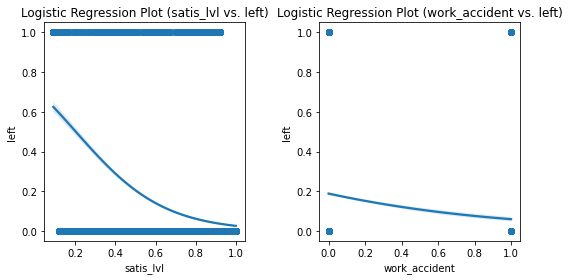

In [9]:
# Logistic regression plots of how Satisfaction Level and Work Accident affects the outcome Left variable across 
# its range of values

#fig, axes = plt.subplots(1, 2, figsize = (8,4))

#sns.regplot(x="satis_lvl", y="left", data=df_logreg, logistic=True, ax=axes[0])
#axes[0].set_title('Logistic Regression Plot (satis_lvl vs. left)')

#sns.regplot(x="work_accident", y="left", data=df_logreg, logistic=True, ax=axes[1])
#axes[1].set_title('Logistic Regression Plot (work_accident vs. left)')
#plt.tight_layout()
#plt.show();

### Observations/Insights

Both predictor variables have a negative correlation with the probability that an employee will leave. Satisfaction level has a greater influence on the model's prediction than work accident. 

As 'satis_lvl' increases, the probability that an employee will leave decreases. The probability that an employee will leave across the range of the predictor variable alone ranges from over 60% down to about 0% as 'satis_lvl' reaches 1.0.

If an employee had a work accident, the probability that an employee will leave is decreased by about 21.3%.

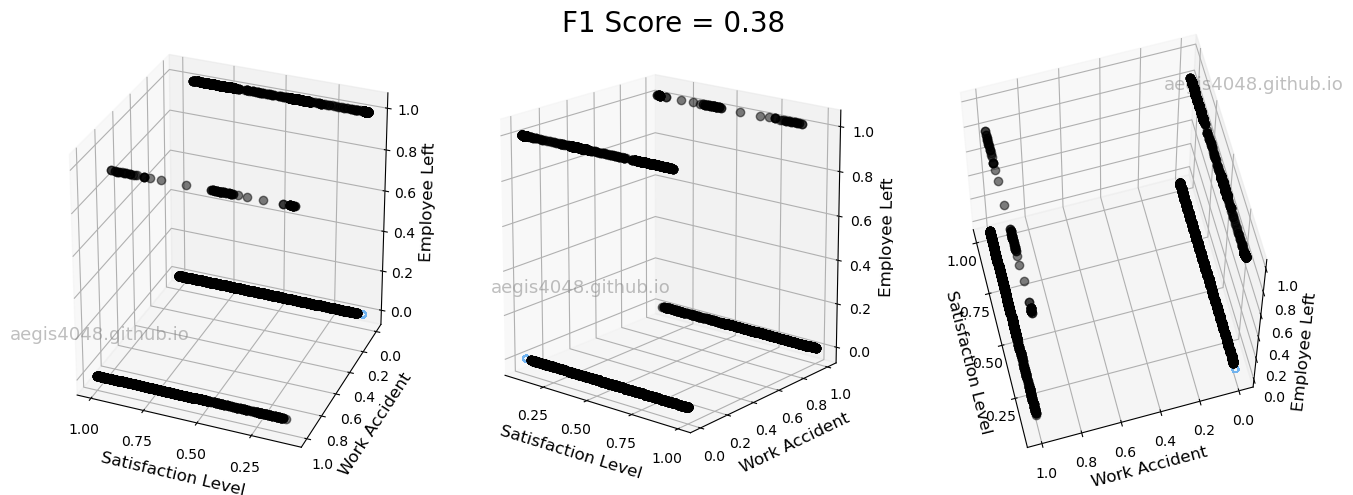

In [58]:
# 3D plots to show relationship of the predictor variables on the outcome variable

# https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python

X = df_logreg[['satis_lvl', 'work_accident']].values.reshape(-1,2)
Y = df_logreg['left']

######################## Prepare model data point for visualization ###############################

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(0.09, 1, 1) # range of satisfaction level values
y_pred = np.linspace(0, 1, 1)  # range of work accident values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

predictions = clf_lr.predict(X_test)

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predictions, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Satisfaction Level', fontsize=12)
    ax.set_ylabel('Work Accident', fontsize=12)
    ax.set_zlabel('Employee Left', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=27, azim=112)
ax2.view_init(elev=16, azim=-51)
ax3.view_init(elev=60, azim=165)

fig.suptitle('F1 Score = %.2f' % f1_score(y_test,predictions), fontsize=20)

fig.tight_layout()

In [33]:
# Use the fitted Logistic Regression model to predict on test set observations

# This cell is run for multiple rounds for variable selection and model training/evaluation. This is to keep the 
# notebook from becoming longer than it needs to be.

y_pred = clf_lr.predict(X_test)

In [54]:
# Dataframe of calculated probabilities used to predict 0 or 1 for each y_test observation, the predictions made,
# the actual outcome, and the row index in the original dataset

# This cell is run for multiple rounds for variable selection and model training/evaluation. This is to keep the 
# notebook from becoming longer than it needs to be.

y_lr1_probs = pd.DataFrame(clf_lr.predict_proba(X_test)[::,-1])
y_lr1_probs = y_lr1_probs.rename(columns={0:'probability_employee_left'})
y_lr1_preds = pd.DataFrame(y_pred)
y_lr1_preds = y_lr1_preds.rename(columns={0:'pred'})
y_lr1_probs = y_lr1_probs.merge(y_lr1_preds,how='outer',left_index=True,right_index=True)
y_actual = pd.DataFrame(y_test).reset_index()
y_actual = y_actual.rename(columns={'left':'actual','index':'employee_row'})
y_lr1_probs = y_lr1_probs.merge(y_actual,how='outer',left_index=True,right_index=True)
y_lr1_probs.insert(y_lr1_probs.columns.get_loc("probability_employee_left"),"employee_row",y_lr1_probs.pop("employee_row"))

display(y_lr1_probs.head(10))

employee_row  probability_employee_left  pred  actual
0         10368                   0.129514     0       0
1          6408                   0.161874     0       0
2          6129                   0.063685     0       0
3           964                   0.119590     0       1
4         11657                   0.098886     0       0
5          9550                   0.102829     0       0
6          7549                   0.545380     1       0
7          4065                   0.066328     0       0
8          9435                   0.214759     0       0
9          3607                   0.139639     0       0

In [190]:
# Get performance metrics for how well the Logistic Regression model predicted the y_test observations

# This cell is run for multiple rounds for variable selection and model training/evaluation. This is to keep the 
# notebook from becoming longer than it needs to be.

lr1_results = pd.DataFrame({'Model': 'Logistic Regression 1 Test',
                          'F1': [f1_score(y_test,y_pred)],
                          'Recall': [recall_score(y_test,y_pred)],
                          'Precision': [precision_score(y_test,y_pred)],
                          'Accuracy': [accuracy_score(y_test,y_pred)],
                          'ROC/AUC': [roc_auc_score(y_test,y_pred)]
                         })
display(lr1_results)

Model        F1    Recall  Precision  Accuracy  \
0  Logistic Regression 1 Test  0.383523  0.286624   0.579399  0.844556   

    ROC/AUC  
0  0.622201

## Logistic Regression Model Performance (no interaction terms)


### ROUND 1

**All X Variables Included**

- Accuracy: 0.820917
- Recall: 0.259023
- Precision: 0.446886
- F1 Score: 0.327957

### ROUND 2

**X Variables Included:** 'satis_lvl', 'num_projects', 'tenure', 'work_accident','promotion_last_5yrs',         'dept_RandD', 'dept_accounting', 'salary_medium','salary_high'

- Accuracy: 0.821633
- Recall: 0.259023
- Precision: 0.450185
- F1 Score: 0.328841

### ROUND 3

**X Variables Included:** 'satis_lvl', 'work_accident', 'promotion_last_5yrs', 'salary_high'

- Accuracy: 0.847063
- Recall: 0.278132
- Precision: 0.600917
- F1 Score: 0.380261

### ROUND 4

<span style="color: green;"> **X Variables Included:** 'satis_lvl', 'work_accident'</span>

- Accuracy: 0.844556
- Recall: 0.286624
- Precision: 0.579399
- F1 Score: 0.383523
- ROC_AUC Score: 0.622201

The model that included just 'satis_lvl' and 'work_accident' as predictor variables had the highest F1 score (0.38), which is low. Recall specifically performed poorly in these models, meaning these models do not do a good job of predicting the employees who left (it predicted many false negatives). **These models can likely be improved by adding interaction terms.** If we can improve Recall, we can improve the overall F1 score as well as long as Precision does not decrease by a greater amount simultaneously.



Logistic Regression 1 Confusion Matrix


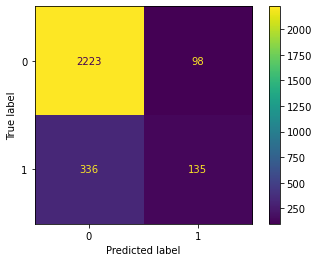

In [216]:
# Plot confusion matrix for the Logistic Regression model to get more granular detail on its performance in predicting
# 0 or 1 for the y_test values

print('\n')
print('\033[1mLogistic Regression 1 Confusion Matrix\033[1m')

cm = confusion_matrix(y_test, y_pred, labels = clf_lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf_lr.classes_)

disp.plot(values_format='');

In [215]:
# Print actual outcomes from the test dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_test.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    2321
1     471


### Observations/Insights

Of the 233 outcomes the model predicted as positive (an employee leaving), 135 of them were correct. This is reflected by the model's ~58% Precision score. 

Of the 471 outcomes that were actually positive (an employee leaving), the model predicted 135 of them correctly. This is reflected by the model's ~29% Recall score. 

Of the 2321 outcomes that were actually negative (an employee staying), the model predicted 2223 of them correctly. This number combined with the 135 true positives the model predicted divided by the total number of predictions made (2792) yields the ~84% overall Accuracy score of the model.

In [34]:
# Get Variance Inflation Factors (VIF) for the predictor variables to estimate level of multicollinearity in the model

lr1_vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

df_lr1_vif = pd.DataFrame(lr1_vif, index=X.columns, columns = ['VIF'])

display(df_lr1_vif)

VIF
satis_lvl      1.168389
work_accident  1.168389

### Observations

The VIF factors for the predictor variables in this model are low (<5) so there is not any concern regarding multicollinearity in the model and the predictor variable coefficients can be interpreted reliably.

### Logistic Regression Model 2 (Add Interaction Terms) <a class="anchor" id="lr2"></a>

[Go Back to Table of Contents](#toc)

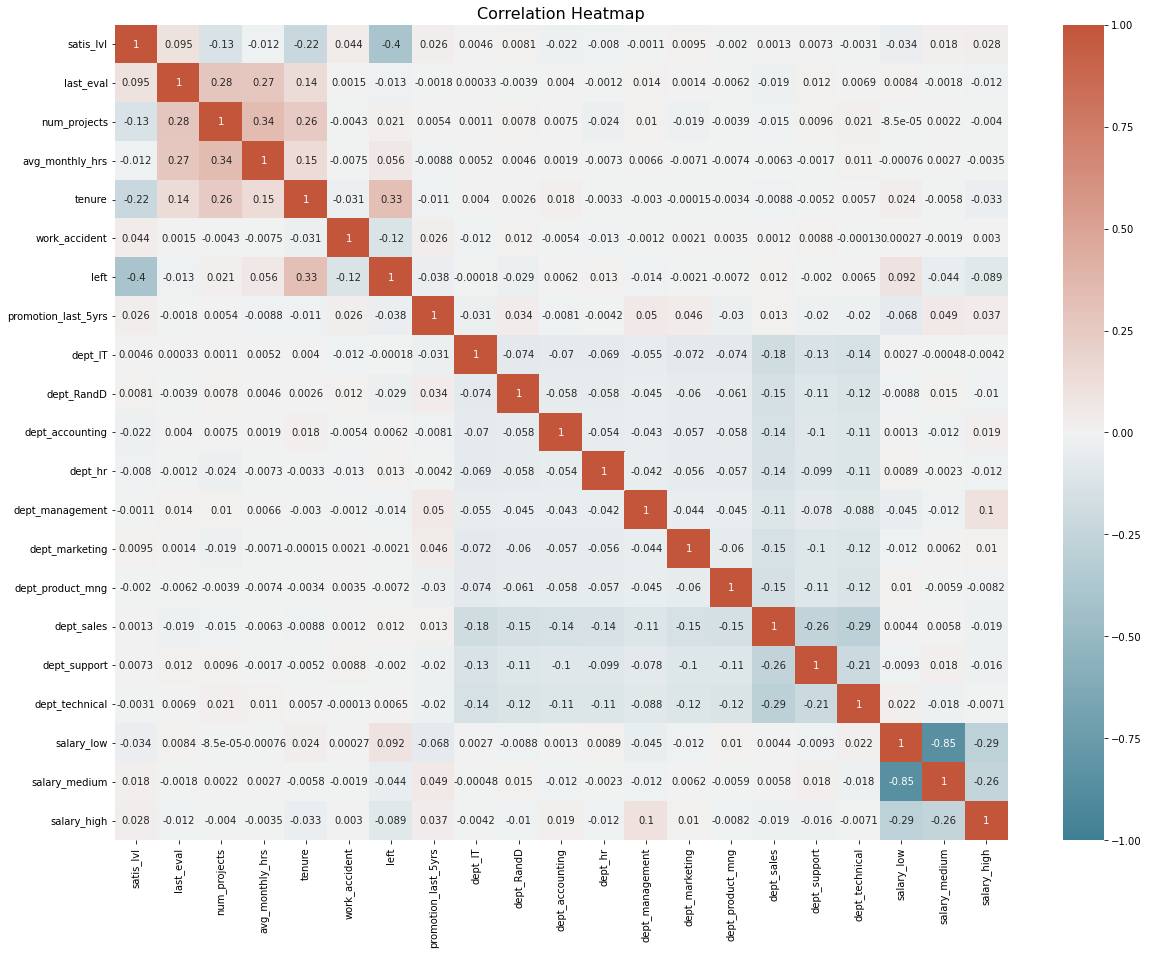

In [226]:
# Plot the correlation heatmap with variables in df_logreg to determine what interaction variables should be 
# created to add to the Logistic Regression model to improve its performance

plt.figure(figsize=(20,15))
ax = sns.heatmap(df_logreg.corr(), vmin=-1, vmax=1, annot=True, cmap = sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

All correlations between variables (except between 'salary_low' and 'salary_medium') are between -0.5 and 0.5 so would not necessarily break the no multicollinearity rule if added together in the logistic regression model.

If the multicollinearity rule was broken, this wouldn't necessarily affect how well the model fits the data and makes predictions, but it would make the coefficients of variables with high multicollinearity difficult to interpret for understanding how those variables relate to the outcome and the other variables in the model.

This could be mitigated by performing necessary EDA to define relationships and/or through use of other well-fit models that are robust to multicollinearity.

In [37]:
# Create new dataframe that includes interaction terms to use for logistic regression

df_logreg_int = df_logreg.copy()

df_logreg_int['proj_hrs_int'] = df_logreg['num_projects']*df_logreg['avg_monthly_hrs']
df_logreg_int['proj_eval_int'] = df_logreg['last_eval']*df_logreg['num_projects']
df_logreg_int['hrs_eval_int'] = df_logreg['last_eval']*df_logreg['avg_monthly_hrs']

df_logreg_int.head()

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   
5       0.41       0.50             2              153       3              0   

   left  promotion_last_5yrs  dept_IT  dept_RandD  ...  dept_product_mng  \
0     1                    0        0           0  ...                 0   
2     1                    0        0           0  ...                 0   
3     1                    0        0           0  ...                 0   
4     1                    0        0           0  ...                 0   
5     1                    0        0           0  ...                 0   

   dept_sales  dept_support  dept_technical  salary_low  salary_medium  \
0           1             0               0           1              0   
2           1             0               0           0              1   
3           1             0               0           1              0   
4           1             0               0           1              0   
5           1             0               0           1              0   

   salary_high  proj_hrs_int  proj_eval_int  hrs_eval_int  
0            0           314           1.06         83.21  
2            0          1904           6.16        239.36  
3            0          1115           4.35        194.01  
4            0           318           1.04         82.68  
5            0           306           1.00         76.50  

[5 rows x 24 columns]

In [38]:
# Re-define X to include the newly added interaction variables

X_lr_int = df_logreg_int.drop(columns=['left'])

y = df_logreg['left']

display(X_lr_int.head())

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   
5       0.41       0.50             2              153       3              0   

   promotion_last_5yrs  dept_IT  dept_RandD  dept_accounting  ...  \
0                    0        0           0                0  ...   
2                    0        0           0                0  ...   
3                    0        0           0                0  ...   
4                    0        0           0                0  ...   
5                    0        0           0                0  ...   

   dept_product_mng  dept_sales  dept_support  dept_technical  salary_low  \
0                 0           1             0               0           1   
2                 0           1             0               0           0   
3                 0           1             0               0           1   
4                 0           1             0               0           1   
5                 0           1             0               0           1   

   salary_medium  salary_high  proj_hrs_int  proj_eval_int  hrs_eval_int  
0              0            0           314           1.06         83.21  
2              1            0          1904           6.16        239.36  
3              0            0          1115           4.35        194.01  
4              0            0           318           1.04         82.68  
5              0            0           306           1.00         76.50  

[5 rows x 23 columns]

In [12]:
# Re-split X and y to account for the newly added interaction variables

X_train, X_test, y_train, y_test = train_test_split(X_lr_int,y, test_size=0.25, stratify=y, random_state=42)

In [203]:
# Instantiate the Logistic Regression model

clf_lr_int = LogisticRegression(solver='liblinear',random_state=42)

# Backwards elimination variable selection

estimator = clf_lr_int
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)
X_train_selector = selector.transform(X_train)

# Returns the model coefficients for the chosen X variables
coefficients = pd.DataFrame(selector.estimator_.coef_)
#print('Coefficients: ',coefficients)
#print('\n')

# Returns the Expit of the model coefficients; used for interpreting how the predictor variables relate to the 
# outcome variable with better clarity
#print('Expit of Coefficients: ',expit(coefficients))
#print('\n')

# Returns the intercept for the model
#print('Intercept: ',selector.estimator_.intercept_)
#print(expit(selector.estimator_.intercept_))
#print('\n')

# Returns which X variables were selected for the model
selected_feat= X_lr_int.columns[(selector.get_support())]
#print("Selected Variables: ",selected_feat)
#print('\n')

# Returns True and False by index for which X variables were chosen for the model
selector.support_

# Ranks each X variable based on how well it aids to predict on the outcome variable

lr_2_rank = pd.DataFrame(selector.ranking_)
lr_2_rank = lr_2_rank.T
lr_2_rank.columns = X_lr_int.columns
col_lbls = pd.DataFrame(['RFE Rank'])
lr_2_rank = pd.concat([lr_2_rank, col_lbls],axis=1).reset_index(drop=True)
lr_2_rank = lr_2_rank[[0] + [col for col in lr_2_rank.columns if col != 0]]
lr_2_rank = lr_2_rank.rename(columns=({0:''}))
lr_2_rank = lr_2_rank.astype(str)
                        
#display(lr_2_rank)

In [229]:
# Build table with logistic regression model coefficients, intercept, and expit of coefficients to more clearly
# interpret how the predictor variables affect the outcome variable

selected_feat_df = pd.DataFrame(selected_feat)

lr_2_coeff = coefficients.rename(columns={0:'satis_lvl',1:'last_eval',2:'num_projects',3:'tenure',
                                               4:'work_accident',5:'promotion_last_5yrs',6:'dept_hr',
                                               7:'salary_medium',8:'salary_high',9:'proj_eval_int',10:'salary_low'})

lr_2_expit = expit(coefficients)
lr_2_expit = lr_2_expit.rename(columns={0:'satis_lvl',1:'last_eval',2:'num_projects',3:'tenure',
                                               4:'work_accident',5:'promotion_last_5yrs',6:'dept_hr',
                                               7:'salary_medium',8:'salary_high',9:'proj_eval_int',10:'salary_low'})


lr_2_coeff = pd.concat([lr_2_coeff, lr_2_expit],axis=0)
lr_2_intcpt = pd.DataFrame(selector.estimator_.intercept_,columns=['intercept'])
lr_2_intcpt_expit = pd.DataFrame(expit(selector.estimator_.intercept_),columns=['intercept'])
lr_2_intcpt = pd.concat([lr_2_intcpt, lr_2_intcpt_expit],axis=0)
lr_2_coeff = pd.concat([lr_2_coeff, lr_2_intcpt],axis=1).reset_index(drop=True)

col_1_lbls = pd.DataFrame(['logit','expit'],columns=[''])
lr_2_coeff = pd.concat([lr_2_coeff, col_1_lbls],axis=1).reset_index(drop=True)
lr_2_coeff = lr_2_coeff[[''] + [col for col in lr_2_coeff.columns if col != '']]

lr_2_expit = lr_2_expit.melt()
lr_2_expit = lr_2_expit.sort_values(by=['value'],ascending=False)

lr_2_coeff = pd.concat([lr_2_coeff, lr_2_rank],axis=0).reset_index(drop=True)
lr_2_coeff.iloc[2,1:11] = lr_2_coeff.iloc[2,1:11].astype(int)
lr_2_coeff = lr_2_coeff.style.set_properties(**{'font-weight':'bold'},subset=[''])

display(lr_2_coeff)

In [16]:
# Display Model 2 Final coefficients and expit(coefficients)

X_lr_int = df_logreg_int[['satis_lvl', 'last_eval', 'num_projects', 'tenure', 'work_accident',
       'promotion_last_5yrs', 'dept_hr', 'salary_low', 'salary_medium',
       'salary_high', 'proj_eval_int']]

X_train, X_test, y_train, y_test = train_test_split(X_lr_int,y, test_size=0.25, stratify=y, random_state=42)

clf_lr_int = LogisticRegression(solver='liblinear',random_state=42).fit(X_train,y_train)

lr_2_coeff = pd.DataFrame(clf_lr_int.coef_,columns=X_lr_int.columns)
lr_2_expit = pd.DataFrame(expit(clf_lr_int.coef_),columns=X_lr_int.columns)
lr_2_coeff = pd.concat([lr_2_coeff, lr_2_expit],axis=0)
lr_2_intcpt = pd.DataFrame(clf_lr_int.intercept_,columns=['intercept'])
lr_2_intcpt_expit = pd.DataFrame(expit(clf_lr_int.intercept_),columns=['intercept'])
lr_2_intcpt = pd.concat([lr_2_intcpt, lr_2_intcpt_expit],axis=0)
lr_2_coeff = pd.concat([lr_2_coeff, lr_2_intcpt],axis=1,ignore_index=True)
lr_2_coeff = lr_2_coeff.rename(columns={0:'satis_lvl',1:'last_eval',2:'num_projects',3:'tenure',
                                               4:'work_accident',5:'promotion_last_5yrs',6:'dept_hr',
                                               7:'salary_low',8:'salary_medium',9:'salary_high',10:'proj_eval_int',11:'intercept'}).reset_index(drop=False)
lr_2_coeff = lr_2_coeff.rename(columns={'index':'3'})
col_1_lbls = pd.DataFrame(['logit','expit'],columns=[''])
lr_2_coeff = pd.concat([lr_2_coeff, col_1_lbls],axis=1)
lr_2_coeff = lr_2_coeff[[''] + [col for col in lr_2_coeff.columns if col != '']]
lr_2_coeff = lr_2_coeff.drop(['3'],axis=1)

lr_2_coeff = lr_2_coeff.style.set_properties(**{'font-weight':'bold'},subset=[''])

display(lr_2_coeff)

### Model Coefficients Interpretation

*Due to high multicollinearity, these predictor variable coefficients cannot be reliably interpreted: 'num_projects', 'last_eval', 'salary_low', 'salary_medium', 'salary_high', and 'proj_eval_int'. (see VIF results below)

A one unit increase (or, if binary, a value of one) in each predictor variable results in its respective coefficient's value increase/decrease in the log-odds (logit) of the probability that an employee will leave the company. 

Taking the expit of the coefficient gives us a more straightforward interpretation of how a change in the predictor variables affects the probability that an employee will leave. A one unit increase (or, if binary, a value of one) in the predictor variable results in the expit of its respective model coefficient's value increase/decrease in the probability that an employee will leave the company.

In [15]:
model = sm.Logit(y_train, X_train)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.218980
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 8375
Model:                          Logit   Df Residuals:                     8364
Method:                           MLE   Df Model:                           10
Date:                Wed, 08 Nov 2023   Pseudo R-squ.:                  0.5171
Time:                        02:12:48   Log-Likelihood:                -1834.0
converged:                       True   LL-Null:                       -3797.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
satis_lvl              -2.8871      0.187    -15.476      0.000      -3.253      -2.521
last_eval             -31.1102      1.016    -30.630      0.000     -33.101     -29.120
num_projects           -6.7472      0.208    -32.391      0.000      -7.155      -6.339
tenure                  1.3355      0.057     23.454      0.000       1.224       1.447
work_accident          -1.3943      0.161     -8.647      0.000      -1.710      -1.078
promotion_last_5yrs    -1.5908      0.593     -2.683      0.007      -2.753      -0.429
dept_hr                 0.2411      0.180      1.336      0.181      -0.113       0.595
salary_low             18.5779      0.631     29.458      0.000      17.342      19.814
salary_medium          18.2626      0.631     28.922      0.000      17.025      19.500
salary_high            17.2111      0.658     26.176      0.000      15.922      18.500
proj_eval_int           8.7459      0.274     31.965      0.000       8.210       9.282
=======================================================================================
"""

### Note

Fitted a logistic regression classifier model with the same variables using statsmodels.Logit to get confidence intervals that could be applied to the model coefficients but the calculated coefficients are not the same as the ones calculated by the sklearn model.

Scaling the variables (standardizing) and then providing them as input to both models may yield more similar results.

In [193]:
# Redefine X using RFE selected variables

X_lr_int = df_logreg_int[['satis_lvl', 'last_eval', 'num_projects', 'tenure', 'work_accident',
       'promotion_last_5yrs', 'dept_hr', 'salary_low', 'salary_medium',
       'salary_high', 'proj_eval_int']]

In [194]:
# Re-split X and y using the chosen predictor variables for follow-on model fit and prediction

X_train, X_test, y_train, y_test = train_test_split(X_lr_int,y, test_size=0.25, stratify=y, random_state=42)

In [195]:
# Train the Logistic Regression model on X and y training sets

clf_lr_int = LogisticRegression(solver='liblinear',random_state=42).fit(X_train,y_train)

In [27]:
# Use the fitted Logistic Regression model to predict on test set observations

y_pred = clf_lr_int.predict(X_test)

In [59]:
# Dataframe of calculated probabilities used to predict 0 or 1 for each y_test observation, the predictions made,
# the actual outcome, and the row index in the original dataset

# This cell is run for multiple rounds for variable selection and model training/evaluation. This is to keep the 
# notebook from becoming longer than it needs to be.

y_lr2_probs = pd.DataFrame(clf_lr_int.predict_proba(X_test)[::,-1])
y_lr2_probs = y_lr2_probs.rename(columns={0:'probability_employee_left'})
y_lr2_preds = pd.DataFrame(y_pred)
y_lr2_preds = y_lr2_preds.rename(columns={0:'pred'})
y_lr2_probs = y_lr2_probs.merge(y_lr2_preds,how='outer',left_index=True,right_index=True)
y_actual = pd.DataFrame(y_test).reset_index()
y_actual = y_actual.rename(columns={'left':'actual','index':'employee_row'})
y_lr2_probs = y_lr2_probs.merge(y_actual,how='outer',left_index=True,right_index=True)
y_lr2_probs.insert(y_lr2_probs.columns.get_loc("probability_employee_left"),"employee_row",y_lr2_probs.pop("employee_row"))

display(y_lr2_probs.head(10))

employee_row  probability_employee_left  pred  actual
0         10368                   0.002920     0       0
1          6408                   0.013267     0       0
2          6129                   0.015615     0       0
3           964                   0.242564     0       1
4         11657                   0.030474     0       0
5          9550                   0.003540     0       0
6          7549                   0.302013     0       0
7          4065                   0.005692     0       0
8          9435                   0.035128     0       0
9          3607                   0.214246     0       0

In [223]:
# Get performance metrics for how well the improved Logistic Regression model predicted the y_test observations

lr2_results = pd.DataFrame({'Model': 'Logistic Regression 2 Test',
                          'F1': [f1_score(y_test,y_pred)],
                          'Recall': [recall_score(y_test,y_pred)],
                          'Precision': [precision_score(y_test,y_pred)],
                          'Accuracy': [accuracy_score(y_test,y_pred)],
                          'ROC/AUC': [roc_auc_score(y_test,y_pred)]
                         })
display(lr2_results)

Model        F1   Recall  Precision  Accuracy  ROC/AUC
0  Logistic Regression 2 Test  0.668172  0.62845   0.713253  0.894699  0.78859



Logistic Regression 2 Confusion Matrix


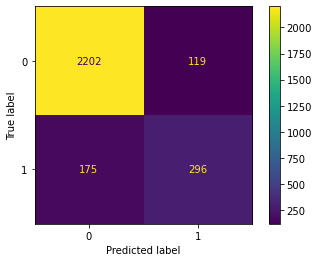

In [224]:
# Plot confusion matrix for the Logistic Regression 2 model to get more granular detail on its performance in predicting
# 0 or 1 for the y_test values

print('\n')
print('\033[1mLogistic Regression 2 Confusion Matrix\033[1m')

cm = confusion_matrix(y_test, y_pred, labels = clf_lr_int.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf_lr_int.classes_)

disp.plot(values_format='');

In [226]:
# Print actual outcomes from the test dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_test.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    2321
1     471


### Observations/Insights

Of the 415 outcomes the model predicted as positive (an employee leaving), 296 of them were correct. This is reflected by the model's ~71% Precision score. 

Of the 471 outcomes that were actually positive (an employee leaving), the model predicted 296 of them correctly. This is reflected by the model's ~63% Recall score. 

Of the 2321 outcomes that were actually negative (an employee staying), the model predicted 2202 of them correctly. This number combined with the 296 true positives the model predicted divided by the total number of predictions made (2792) yields the ~89% overall Accuracy score of the model.

**This Logistic Regression model performed considerably better than the models without interaction terms but I think it can be improved further with a few more appropriately selected interaction terms.**

In [28]:
# Get Variance Inflation Factors (VIF) for the predictor variables to estimate level of multicollinearity in the model

lr2_vif = [variance_inflation_factor(X_lr_int.values, i) for i in range(X_lr_int.shape[1])]

df_lr2_vif = pd.DataFrame(lr2_vif, index=X_lr_int.columns, columns = ['VIF'])

display(df_lr2_vif)

VIF
satis_lvl              1.193273
last_eval             12.424746
num_projects          19.774643
tenure                 1.133047
work_accident          1.005516
promotion_last_5yrs    1.006306
dept_hr                1.001134
salary_low           103.349302
salary_medium         93.484667
salary_high           18.034716
proj_eval_int         39.603019

### Observations

There is severe multicollinearity in this model as evidenced by the high (> 5) VIF factors for several variables. While it has greater predictive power than the first logistic regression model in predicting test set observations, the coefficients of at least the high VIF predictor variables cannot be reliably interpreted.

### Logistic Regression Model 3 (Add More Interaction Terms) <a class="anchor" id="lr3"></a>

[Go Back to Table of Contents](#toc)

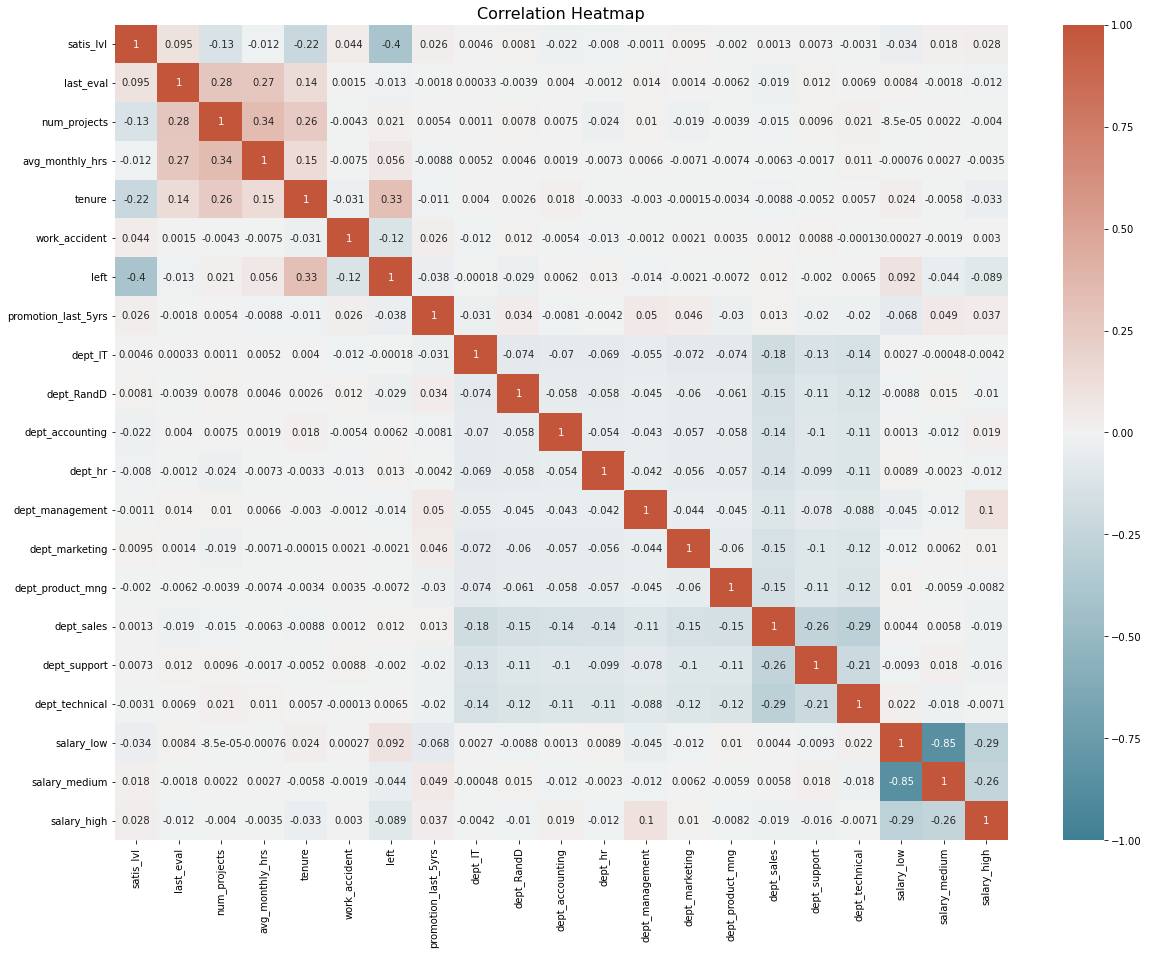

In [227]:
# Re-plot the correlation heatmap with variables in df_logreg to determine what interaction variables should be 
# created to add to the Logistic Regression model to improve its performance

plt.figure(figsize=(20,15))
ax = sns.heatmap(df_logreg.corr(), vmin=-1, vmax=1, annot=True, cmap = sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [39]:
# Create new dataframe that includes additional interaction terms to use for logistic regression

df_logreg_int2 = df_logreg_int.copy()

df_logreg_int2['proj_tenure_int'] = df_logreg['num_projects']*df_logreg['tenure']
df_logreg_int2['satis_tenure_int'] = df_logreg['satis_lvl']*df_logreg['tenure']
df_logreg_int2['satis_proj_int'] = df_logreg['satis_lvl']*df_logreg['num_projects']
df_logreg_int2['hrs_tenure_int'] = df_logreg['avg_monthly_hrs']*df_logreg['tenure']
df_logreg_int2['satis_salary_low'] = df_logreg['satis_lvl']*df_logreg['salary_low']
df_logreg_int2['satis_hrs'] = df_logreg['satis_lvl']*df_logreg['avg_monthly_hrs']
df_logreg_int2['satis_eval'] = df_logreg['satis_lvl']*df_logreg['last_eval']
df_logreg_int2['eval_hrs'] = df_logreg['last_eval']*df_logreg['avg_monthly_hrs']

df_logreg_int2.head()

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   
5       0.41       0.50             2              153       3              0   

   left  promotion_last_5yrs  dept_IT  dept_RandD  ...  proj_eval_int  \
0     1                    0        0           0  ...           1.06   
2     1                    0        0           0  ...           6.16   
3     1                    0        0           0  ...           4.35   
4     1                    0        0           0  ...           1.04   
5     1                    0        0           0  ...           1.00   

   hrs_eval_int  proj_tenure_int  satis_tenure_int  satis_proj_int  \
0         83.21                6              1.14            0.76   
2        239.36               28              0.44            0.77   
3        194.01               25              3.60            3.60   
4         82.68                6              1.11            0.74   
5         76.50                6              1.23            0.82   

   hrs_tenure_int  satis_salary_low  satis_hrs  satis_eval  eval_hrs  
0             471              0.38      59.66      0.2014     83.21  
2            1088              0.00      29.92      0.0968    239.36  
3            1115              0.72     160.56      0.6264    194.01  
4             477              0.37      58.83      0.1924     82.68  
5             459              0.41      62.73      0.2050     76.50  

[5 rows x 32 columns]

In [40]:
# Re-define X to include the newly added interaction variables

X_lr_int2 = df_logreg_int2.drop(columns=['left'])

y = df_logreg['left']

display(X_lr_int2.head())

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   
5       0.41       0.50             2              153       3              0   

   promotion_last_5yrs  dept_IT  dept_RandD  dept_accounting  ...  \
0                    0        0           0                0  ...   
2                    0        0           0                0  ...   
3                    0        0           0                0  ...   
4                    0        0           0                0  ...   
5                    0        0           0                0  ...   

   proj_eval_int  hrs_eval_int  proj_tenure_int  satis_tenure_int  \
0           1.06         83.21                6              1.14   
2           6.16        239.36               28              0.44   
3           4.35        194.01               25              3.60   
4           1.04         82.68                6              1.11   
5           1.00         76.50                6              1.23   

   satis_proj_int  hrs_tenure_int  satis_salary_low  satis_hrs  satis_eval  \
0            0.76             471              0.38      59.66      0.2014   
2            0.77            1088              0.00      29.92      0.0968   
3            3.60            1115              0.72     160.56      0.6264   
4            0.74             477              0.37      58.83      0.1924   
5            0.82             459              0.41      62.73      0.2050   

   eval_hrs  
0     83.21  
2    239.36  
3    194.01  
4     82.68  
5     76.50  

[5 rows x 31 columns]

In [41]:
# Re-split X and y to account for the newly added interaction variables

X_train, X_test, y_train, y_test = train_test_split(X_lr_int2,y, test_size=0.25, stratify=y, random_state=42)

In [219]:
# Instantiate the Logistic Regression model

clf_lr_int2 = LogisticRegression(solver='liblinear',random_state=42)

# Backwards elimination variable selection

estimator = clf_lr_int2
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)
X_train_selector = selector.transform(X_train)

# Returns the model coefficients for the chosen X variables
coefficients = pd.DataFrame(selector.estimator_.coef_)
#print('Coefficients: ',coefficients)
#print('\n')

# Returns the Expit of the model coefficients; used for interpreting how the predictor variables relate to the 
# outcome variable with better clarity
#print('Expit of Coefficients: ',expit(coefficients))
#print('\n')

# Returns the intercept for the model
#print('Intercept: ',selector.estimator_.intercept_)
#print(expit(selector.estimator_.intercept_))
#print('\n')

# Returns which X variables were selected for the model
selected_feat= X_lr_int2.columns[(selector.get_support())]
print("Selected Variables: ",selected_feat)
#print('\n')

# Returns True and False by index for which X variables were chosen for the model
selector.support_

# Ranks each X variable based on how well it aids to predict on the outcome variable

lr_3_rank = pd.DataFrame(selector.ranking_)
lr_3_rank = lr_3_rank.T
lr_3_rank.columns = X_lr_int2.columns
col_lbls = pd.DataFrame(['RFE Rank'])
lr_3_rank = pd.concat([lr_3_rank, col_lbls],axis=1).reset_index(drop=True)
lr_3_rank = lr_3_rank[[0] + [col for col in lr_3_rank.columns if col != 0]]
lr_3_rank = lr_3_rank.rename(columns=({0:''}))
lr_3_rank = lr_3_rank.astype(str)
                        
#display(lr_3_rank)

Selected Variables:  Index(['satis_lvl', 'last_eval', 'num_projects', 'work_accident',
       'promotion_last_5yrs', 'dept_hr', 'dept_sales', 'dept_support',
       'salary_low', 'salary_medium', 'salary_high', 'proj_eval_int',
       'satis_tenure_int', 'satis_proj_int', 'satis_eval'],
      dtype='object')


In [238]:
# Build table with logistic regression model coefficients, intercept, and expit of coefficients to more clearly
# interpret how the predictor variables affect the outcome variable

selected_feat_df = pd.DataFrame(selected_feat)

lr_3_coeff = coefficients.rename(columns={0:'satis_lvl', 1:'last_eval', 2:'num_projects', 3:'dept_hr', 4:'work_accident',
       5:'promotion_last_5yrs', 6:'salary_medium', 7:'salary_high', 8:'proj_eval_int',
       9:'dept_sales', 10:'satis_tenure_int', 11:'satis_proj_int', 12:'salary_low'})

lr_3_expit = expit(coefficients)
lr_3_expit = lr_3_expit.rename(columns={0:'satis_lvl', 1:'last_eval', 2:'num_projects', 3:'dept_hr', 4:'work_accident',
       5:'promotion_last_5yrs', 6:'salary_medium', 7:'salary_high', 8:'proj_eval_int',
       9:'dept_sales', 10:'satis_tenure_int', 11:'satis_proj_int', 12:'salary_low'})


lr_3_coeff = pd.concat([lr_3_coeff, lr_3_expit],axis=0)
lr_3_intcpt = pd.DataFrame(selector.estimator_.intercept_,columns=['intercept'])
lr_3_intcpt_expit = pd.DataFrame(expit(selector.estimator_.intercept_),columns=['intercept'])
lr_3_intcpt = pd.concat([lr_3_intcpt, lr_3_intcpt_expit],axis=0)
lr_3_coeff = pd.concat([lr_3_coeff, lr_3_intcpt],axis=1).reset_index(drop=True)

col_1_lbls = pd.DataFrame(['logit','expit'],columns=[''])
lr_3_coeff = pd.concat([lr_3_coeff, col_1_lbls],axis=1).reset_index(drop=True)
lr_3_coeff = lr_3_coeff[[''] + [col for col in lr_3_coeff.columns if col != '']]

lr_3_expit = lr_3_expit.melt()
lr_3_expit = lr_3_expit.sort_values(by=['value'],ascending=False)

lr_3_coeff = pd.concat([lr_3_coeff, lr_3_rank],axis=0).reset_index(drop=True)
lr_3_coeff.iloc[2,1:11] = lr_3_coeff.iloc[2,1:11].astype(int)
lr_3_coeff = lr_3_coeff.style.set_properties(**{'font-weight':'bold'},subset=[''])

display(lr_3_coeff)

In [42]:
# Display Model 3 Final coefficients and expit(coefficients)

X_lr_int2 = df_logreg_int2[['satis_lvl', 'last_eval', 'num_projects', 'tenure', 'work_accident',
                       'promotion_last_5yrs', 'salary_medium', 'salary_high', 'salary_low', 'proj_eval_int',
                       'proj_tenure_int', 'satis_tenure_int', 'satis_proj_int', 'dept_hr',
                           'satis_hrs', 'satis_eval', 'eval_hrs']]

X_train, X_test, y_train, y_test = train_test_split(X_lr_int2,y, test_size=0.25, stratify=y, random_state=42)

clf_lr_int2 = LogisticRegression(solver='liblinear',random_state=42).fit(X_train,y_train)

lr_3_coeff = pd.DataFrame(clf_lr_int2.coef_,columns=X_lr_int2.columns)
lr_3_expit = pd.DataFrame(expit(clf_lr_int2.coef_),columns=X_lr_int2.columns)
lr_3_coeff = pd.concat([lr_3_coeff, lr_3_expit],axis=0)
lr_3_intcpt = pd.DataFrame(clf_lr_int2.intercept_,columns=['intercept'])
lr_3_intcpt_expit = pd.DataFrame(expit(clf_lr_int2.intercept_),columns=['intercept'])
lr_3_intcpt = pd.concat([lr_3_intcpt, lr_3_intcpt_expit],axis=0)
lr_3_coeff = pd.concat([lr_3_coeff, lr_3_intcpt],axis=1,ignore_index=True)
lr_3_coeff = lr_3_coeff.rename(columns={0:'satis_lvl',1:'last_eval',2:'num_projects',3:'tenure',
                                               4:'work_accident',5:'promotion_last_5yrs',6:'salary_medium',
                                               7:'salary_high',8:'salary_low',9:'proj_eval_int',10:'proj_tenure_int',
                                               11:'satis_tenure_int',12:'satis_proj_int',13:'dept_hr',14:'satis_hrs',
                                               15:'satis_eval',16:'eval_hrs',17:'intercept'}).reset_index(drop=False)
col_1_lbls = pd.DataFrame(['logit','expit'],columns=[''])
lr_3_coeff = pd.concat([lr_3_coeff, col_1_lbls],axis=1)
lr_3_coeff = lr_3_coeff[[''] + [col for col in lr_3_coeff.columns if col != '']]
lr_3_coeff = lr_3_coeff.drop(['index'],axis=1)

lr_3_coeff = lr_3_coeff.style.set_properties(**{'font-weight':'bold'},subset=[''])

display(lr_3_coeff)

### Model Coefficients Interpretation

*Due to high multicollinearity, all predictor variable coefficients except for 'promotion_last_5yrs', 'work_accident', and 'dept_hr'  cannot be reliably interpreted. (see VIF results below)

A one unit increase (or, if binary, a value of one) in each predictor variable results in its respective coefficient's value increase/decrease in the log-odds (logit) of the probability that an employee will leave the company. 

Taking the expit of the coefficient gives us a more straightforward interpretation of how a change in the predictor variables affects the probability that an employee will leave. A one unit increase (or, if binary, a value of one) in the predictor variable results in the expit of its respective model coefficient's value increase/decrease in the probability that an employee will leave the company.

In [43]:
# Redefine X using RFE selected variables

X_lr_int2 = df_logreg_int2[['satis_lvl', 'last_eval', 'num_projects', 'tenure', 'work_accident',
                       'promotion_last_5yrs', 'salary_medium', 'salary_high', 'salary_low', 'proj_eval_int',
                       'proj_tenure_int', 'satis_tenure_int', 'satis_proj_int', 'dept_hr',
                           'satis_hrs', 'satis_eval', 'eval_hrs']]

In [44]:
# Re-split X and y using the chosen predictor variables for follow-on model fit and prediction

X_train, X_test, y_train, y_test = train_test_split(X_lr_int2,y, test_size=0.25, stratify=y, random_state=42)

In [45]:
# Train the Logistic Regression model on X and y training sets

clf_lr_int2 = LogisticRegression(solver='liblinear',random_state=42).fit(X_train,y_train)

In [46]:
# Use the fitted Logistic Regression model to predict on test set observations

y_pred = clf_lr_int2.predict(X_test)

In [112]:
# Dataframe of calculated probabilities used to predict 0 or 1 for each y_test observation, the predictions made,
# the actual outcome, and the row index in the original dataset

# This cell is run for multiple rounds for variable selection and model training/evaluation. This is to keep the 
# notebook from becoming longer than it needs to be.

y_lr3_probs = pd.DataFrame(clf_lr_int2.predict_proba(X_test)[::,-1])
y_lr3_probs = y_lr3_probs.rename(columns={0:'probability_employee_left'})
y_lr3_preds = pd.DataFrame(y_pred)
y_lr3_preds = y_lr3_preds.rename(columns={0:'pred'})
y_lr3_probs = y_lr3_probs.merge(y_lr3_preds,how='outer',left_index=True,right_index=True)
y_actual = pd.DataFrame(y_test).reset_index()
y_actual = y_actual.rename(columns={'left':'actual','index':'employee_row'})
y_lr3_probs = y_lr3_probs.merge(y_actual,how='outer',left_index=True,right_index=True)
y_lr3_probs.insert(y_lr3_probs.columns.get_loc("probability_employee_left"),"employee_row",y_lr3_probs.pop("employee_row"))

display(y_lr3_probs.head(10))

employee_row  probability_employee_left  pred  actual
0         10368                   0.000231     0       0
1          6408                   0.006211     0       0
2          6129                   0.022738     0       0
3           964                   0.263911     0       1
4         11657                   0.018500     0       0
5          9550                   0.000190     0       0
6          7549                   0.355052     0       0
7          4065                   0.000652     0       0
8          9435                   0.004029     0       0
9          3607                   0.194202     0       0

In [47]:
# Get performance metrics for how well the improved Logistic Regression model predicted the y_test observations

lr3_results = pd.DataFrame({'Model': 'Logistic Regression 3 Test',
                          'F1': [f1_score(y_test,y_pred)],
                          'Recall': [recall_score(y_test,y_pred)],
                          'Precision': [precision_score(y_test,y_pred)],
                          'Accuracy': [accuracy_score(y_test,y_pred)],
                          'ROC/AUC': [roc_auc_score(y_test,y_pred)]
                         })
display(lr3_results)

Model        F1    Recall  Precision  Accuracy  \
0  Logistic Regression 3 Test  0.822785  0.828025    0.81761  0.939828   

    ROC/AUC  
0  0.895271

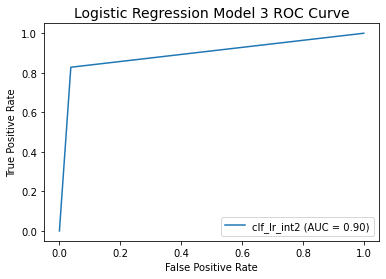

In [155]:
# Plot ROC Curve for the Logistic Regression model

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
lr3rocplot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='clf_lr_int2')
lr3rocplot.plot()
plt.title('Logistic Regression Model 3 ROC Curve',fontsize=14)
plt.show()

### Observations

About 90% of the Logistic Regression model's predictions are correct across all classification thresholds. In the plot, the true positive rate is maximized fairly well across most classification thresholds while the false positive rate is minimized fairly well (the curve is up near the top left corner). This is not bad performance overall but there is some room for improvement.



Logistic Regression 3 Confusion Matrix


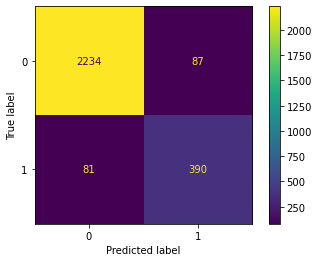

In [156]:
# Plot confusion matrix for the Logistic Regression model to get more granular detail on its performance in predicting
# 0 or 1 for the y_test values

print('\n')
print('\033[1mLogistic Regression 3 Confusion Matrix\033[1m')

cm = confusion_matrix(y_test, y_pred, labels = clf_lr_int2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf_lr_int2.classes_)

disp.plot(values_format='');

In [157]:
# Print actual outcomes from the test dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_test.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    2321
1     471


### Observations/Insights

Of the 477 outcomes the model predicted as positive (an employee leaving), 390 of them were correct. This is reflected by the model's ~82% Precision score. 

Of the 471 outcomes that were actually positive (an employee leaving), the model predicted 390 of them correctly. This is reflected by the model's ~83% Recall score. 

Of the 2321 outcomes that were actually negative (an employee staying), the model predicted 2234 of them correctly. This number combined with the 390 true positives the model predicted divided by the total number of predictions made (2792) yields the ~94% overall Accuracy score of the model.

**While this Logistic Regression model is greatly improved from models 1 and 2, this model scored significantly lower than all other Decision Tree, Random Forest, and XGBoost models.**

In [23]:
# Get Variance Inflation Factors (VIF) for the predictor variables to estimate level of multicollinearity in the model

lr3_vif = [variance_inflation_factor(X_lr_int2.values, i) for i in range(X_lr_int2.shape[1])]

df_lr3_vif = pd.DataFrame(lr3_vif, index=X_lr_int2.columns, columns = ['VIF'])

display(df_lr3_vif)

VIF
satis_lvl             39.796813
last_eval             29.609305
num_projects          41.939597
tenure                27.462619
work_accident          1.007413
promotion_last_5yrs    1.006881
salary_medium        261.399888
salary_high           48.651253
salary_low           291.036741
proj_eval_int         43.036609
proj_tenure_int       46.219715
satis_tenure_int      21.595199
satis_proj_int        21.321975
dept_hr                1.001647
satis_hrs             24.437042
satis_eval            38.482773
eval_hrs              17.741045

### Observations

There is severe multicollinearity in this model as evidenced by the high (> 5) VIF factors for most variables. While it has greater predictive power than the other logistic regression models in predicting test set observations, the coefficients of the predictor variables cannot be reliably interpreted.

## Logistic Regression Models 2 and 3 Performance (including interaction terms)

### ROUND 1

**X Variables Included:** 'satis_lvl', 'last_eval', 'num_projects', 'work_accident','proj_eval_int','salary_low'
    
- Accuracy: 0.899713
- Recall: 0.526539
- Precision: 0.813115
- F1 Score: 0.639175
- ROC_AUC Score: 0.75099  &nbsp;


### ROUND 2

**X Variables Included:** 'satis_lvl', 'last_eval', 'num_projects', 'tenure', 'work_accident', 'promotion_last_5yrs', 'dept_hr', 'salary_low', 'salary_medium', 'salary_high','proj_eval_int'

- Accuracy: 0.894699
- Recall: 0.62845
- Precision: 0.713253
- F1 Score: 0.668172
- ROC_AUC Score: 0.78859  &nbsp;


### ROUND 3

**X Variables Included:** 'satis_lvl', 'last_eval', 'num_projects', 'tenure', 'work_accident',
                       'promotion_last_5yrs', 'salary_medium', 'salary_high', 'salary_low', 'proj_eval_int',
                       'proj_tenure_int', 'satis_tenure_int', 'satis_proj_int', 'dept_hr'

- Accuracy: 0.936605
- Recall: 0.819533
- Precision: 0.807531
- F1 Score: 0.813488 	
- ROC_AUC Score: 0.889947  &nbsp;

### ROUND 4

<span style="color: green;">**X Variables Included:** 'satis_lvl', 'last_eval', 'num_projects', 'tenure', 'work_accident', 'promotion_last_5yrs', 'salary_medium', 'salary_high', 'salary_low', 'proj_eval_int',
                       'proj_tenure_int', 'satis_tenure_int', 'satis_proj_int', 'dept_hr',
                           'satis_hrs', 'satis_eval', 'eval_hrs'</span>

- Accuracy: 0.939828
- Recall: 0.828025
- Precision: 0.81761
- F1 Score: 0.822785 	
- ROC_AUC Score: 0.895271  &nbsp;

F1 score is highset in the fourth model above. While Recall was siginificantly improved in the second model
above, Precision significantly suffered going from Round 1 model to Round 2 model. Overall, Accuracy slightly decreased in the second model. The Round 2 model's ROC_AUC score is higher than Round 1 model's, meaning it performs better than the Round 1 model overall across all classification thresholds. Round 3 Model outperforms both other models in all scores except Precision, which is slightly lower than Round 1 model's. **Model from Round 4 outperforms all models in all scores** and all of these models performed considerably better than the models that did not include interaction variables.

In [21]:
# Get variable names and expit of logistic regression coefficients in dataframe to use in feature importance plot

features = pd.DataFrame(X_lr_int2.columns)
features = features
features

best_model_coeff = pd.DataFrame(clf_lr_int2.coef_)
expit_coeff = expit(best_model_coeff).T

features = features.merge(expit_coeff, how='outer',right_index=True,left_index=True)
features = features.rename(columns={'0_x':'features','0_y':'expit_prob'})
features = features.sort_values(by='expit_prob',ascending=False).reset_index(drop=True)

display(features)

features  expit_prob
0            salary_low    0.990550
1         salary_medium    0.987109
2      satis_tenure_int    0.969605
3           salary_high    0.960229
4         proj_eval_int    0.950895
5       proj_tenure_int    0.645001
6               dept_hr    0.554346
7              eval_hrs    0.504240
8             satis_hrs    0.495398
9   promotion_last_5yrs    0.262996
10       satis_proj_int    0.258940
11        work_accident    0.227043
12           satis_eval    0.060332
13               tenure    0.055245
14         num_projects    0.010964
15            satis_lvl    0.001334
16            last_eval    0.000012

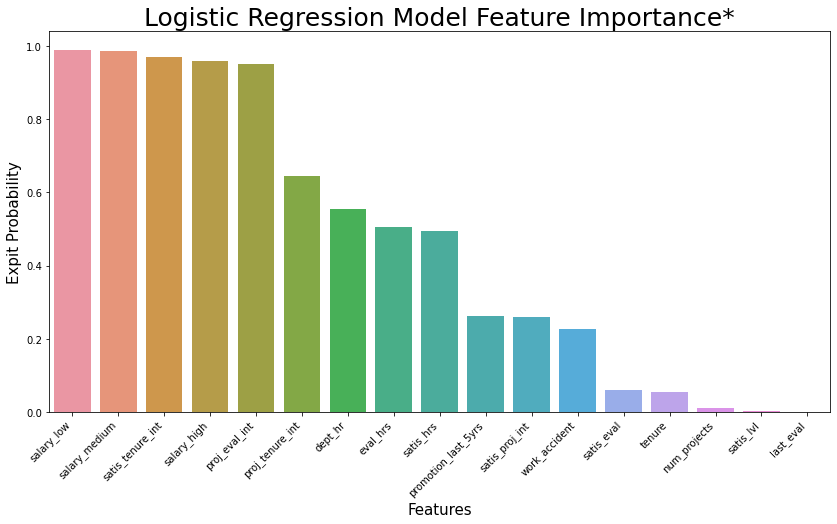

In [22]:
# Plot feature importance for the improved Logistic Regression model; this plot shows the impact each predictor 
# variable has on the model for predicting the outcome variable

plt.figure(figsize=(14,7))
ax = sns.barplot(x=features['features'],y=features['expit_prob'])
plt.title("Logistic Regression Model Feature Importance*",fontsize=25)
plt.xlabel("Features",fontsize = 15)
plt.ylabel("Expit Probability",fontsize = 15)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

# We interpret Expit probability values as for every one unit increase in the predictor variable, the probability that an employee
# will leave increases by the probability percentage calculated from the predictor variable's model coefficient.

### Observations/Insights

It's interesting to note that 'avg_monthly_hrs' wasn't even chosen through RFE variable selection to be included in any of the logistic regression models while it is one of the most important predictive features in each of the machine learning models. Manually adding it to the model actually slightly decreased the ROC/AUC score.

The top 5 most important features for the logistic regression model are 'salary_low', 'salary_medium', the satisfaction level * tenure interaction term, 'salary_high', and the number of projects * last evaluation interaction term.

* As mentioned above, there is severe multicollinearity in this model as evidenced by the high (> 5) VIF factors for most variables. While it has greater predictive power than the other logistic regression models in predicting test set observations, the coefficients of the predictor variables cannot be reliably interpreted. Therefore, we should be careful to not draw conclusions about predictor variable relationships from this feature importance plot.

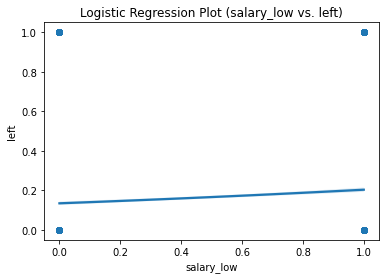

In [174]:
# Logistic regression plot of how Salary_Low affects the outcome Left variable 
# across its range of values

#sns.regplot(x="salary_low", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (salary_low vs. left)')
#plt.show()

### Observations/Insights

There is a slight positive correlation between the 'salary_low' variable and the probability that an employee will leave. If an employee has a low salary level, the probability that an employee will leave is slightly increased by about 5%.

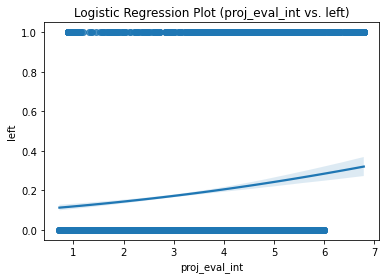

In [91]:
# Logistic regression plot of how the Num Projects/Last_Eval interaction term affects the outcome Left variable 
# across its range of values

#sns.regplot(x="proj_eval_int", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (proj_eval_int vs. left)')
#plt.show()

### Observations/Insights

There is a positive correlation between the 'proj_eval_int' variable and the probability that an employee will leave. As 'proj_eval_int' increases, the probability that an employee will leave increases. The probability that an employee will leave across the range of the predictor variable alone ranges from about 10% - 30%. 

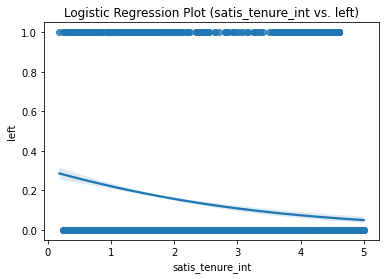

In [89]:
# Logistic regression plot of how the Satis_Lvl/Tenure interaction term affects the outcome Left variable 
# across its range of values

#sns.regplot(x="satis_tenure_int", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (satis_tenure_int vs. left)')
#plt.show()

### Observations/Insights

There is a negative correlation between the 'satis_tenure_int' variable and the probability that an employee will leave. As 'satis_tenure_int' increases, the probability that an employee will leave decreases. The probability that an employee will leave across the range of the predictor variable alone ranges from about 30% down to about 0%.

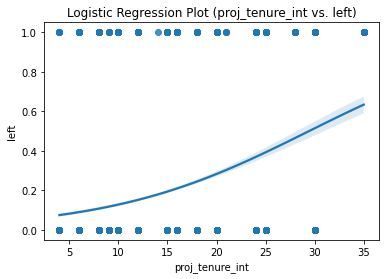

In [90]:
# Logistic regression plot of how the Num_Projects/Tenure interaction term affects the outcome Left variable 
# across its range of values

#sns.regplot(x="proj_tenure_int", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (proj_tenure_int vs. left)')
#plt.show()

### Observations/Insights

There is a positive correlation between the 'proj_tenure_int' variable and the probability that an employee will leave. As 'proj_tenure_int' increases, the probability that an employee will leave increases. The probability that an employee will leave across the range of the predictor variable alone ranges from less than 10% up to over 60%.

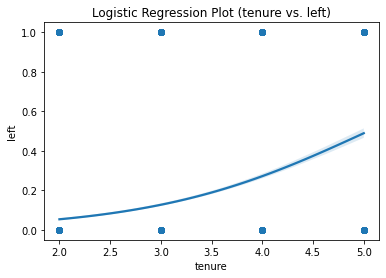

In [13]:
# Logistic regression plot of how Tenure affects the outcome Left variable across its range of values

#sns.regplot(x="tenure", y="left", data=df_logreg_int, logistic=True)
#plt.title('Logistic Regression Plot (tenure vs. left)')
#plt.show()

### Observations/Insights

There is a positive correlation between the 'tenure' variable and the probability that an employee will leave. As 'tenure' increases, the probability that an employee will leave increases. The probability that an employee will leave across the range of the predictor variable alone ranges from about 5% up to about 50%.

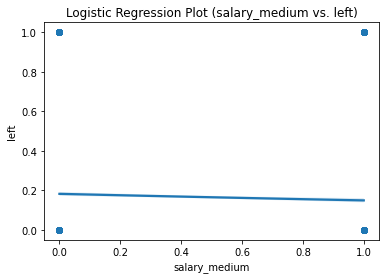

In [113]:
# Logistic regression plot of how Salary_Medium affects the outcome Left variable across its range of values

#sns.regplot(x="salary_medium", y="left", data=df_logreg_int, logistic=True)
#plt.title('Logistic Regression Plot (salary_medium vs. left)')
#plt.show()

### Observations/Insights

There is a slight negative correlation between the 'salary_medium' variable and the probability that an employee will leave. If an employee has a medium salary level, the probability that an employee will leave is slightly decreased by about 5%.

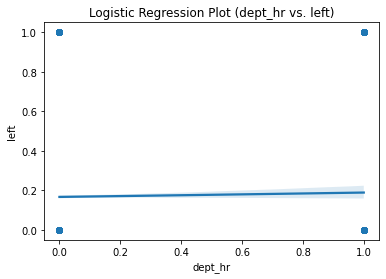

In [175]:
# Logistic regression plot of how Dept_HR affects the outcome Left variable 
# across its range of values

#sns.regplot(x="dept_hr", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (dept_hr vs. left)')
#plt.show()

### Observations/Insights

There is a slight positive correlation between the 'dept_hr' variable and the probability that an employee will leave. If an employee is in the HR department, the probability that an employee will leave is slightly increased by about 5%.

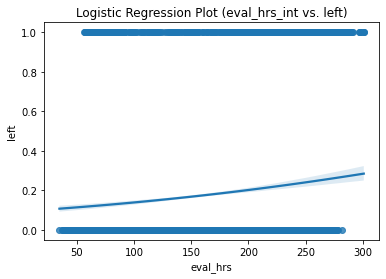

In [18]:
# Logistic regression plot of how Eval_Hrs_Int affects the outcome Left variable 
# across its range of values

#sns.regplot(x="eval_hrs", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (eval_hrs_int vs. left)')
#plt.show()

### Observations/Insights

There is a positive correlation between the 'eval_hrs' interaction variable and the probability that an employee will leave. As 'eval_hr' increases, the probability that an employee will leave increases. The probability that an employee will leave across the range of the predictor variable alone ranges from about 10% up to about 30%.

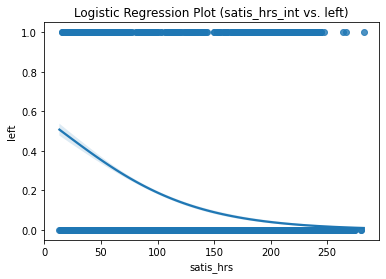

In [19]:
# Logistic regression plot of how Satis_Hrs_Int affects the outcome Left variable 
# across its range of values

#sns.regplot(x="satis_hrs", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (satis_hrs_int vs. left)')
#plt.show()

### Observations/Insights

There is a negative correlation between the 'satis_hrs' interaction variable and the probability that an employee will leave. As 'satis_hrs_int' increases, the probability that an employee will leave decreases. The probability that an employee will leave across the range of the predictor variable alone ranges from about 55% down to 0% past value 250 of 'satis_hrs'.

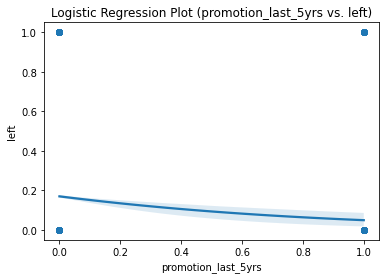

In [114]:
# Logistic regression plot of how Promotion_Last_5yrs affects the outcome Left variable across its range of values

#sns.regplot(x="promotion_last_5yrs", y="left", data=df_logreg_int, logistic=True)
#plt.title('Logistic Regression Plot (promotion_last_5yrs vs. left)')
#plt.show()

### Observations/Insights

There is a negative correlation between the 'promotion_last_5yrs' variable and the probability that an employee will leave. If an employee has been promoted in the last 5 years, the probability that an employee will leave is decreased by a little less than 20%.

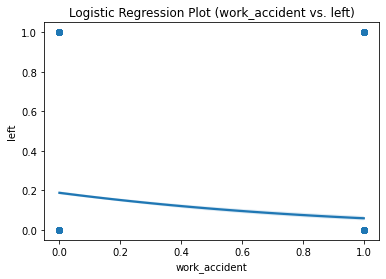

In [92]:
# Logistic regression plot of how Work_Accident affects the outcome Left variable across its range of values

#sns.regplot(x="work_accident", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (work_accident vs. left)')
#plt.show()

### Observations/Insights

There is a negative correlation between the 'work_accident' variable and the probability that an employee will leave. If an employee had a work accident, the probability that an employee will leave is decreased by about 15%.

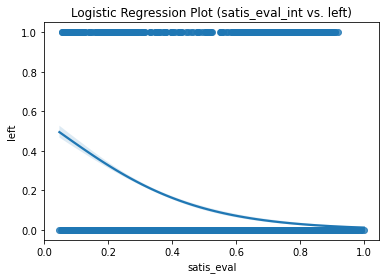

In [20]:
# Logistic regression plot of how Sati_Eval_Int affects the outcome Left variable 
# across its range of values

#sns.regplot(x="satis_eval", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (satis_eval_int vs. left)')
#plt.show()

### Observations/Insights

There is a negative correlation between the 'satis_eval_int' interaction variable and the probability that an employee will leave. As 'satis_eval_int' increases, the probability that an employee will leave decreases. The probability that an employee will leave across the range of the predictor variable alone ranges from about 50% down to 0% as 'satis_eval_int' approaches 1.0.

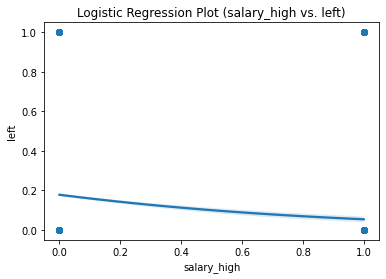

In [115]:
# Logistic regression plot of how Salary_High affects the outcome Left variable across its range of values

#sns.regplot(x="salary_high", y="left", data=df_logreg_int, logistic=True)
#plt.title('Logistic Regression Plot (salary_high vs. left)')
#plt.show()

### Observations/Insights

There is a negative correlation between the 'salary_high' variable and the probability that an employee will leave. If an employee has a high salary, the probability that an employee will leave is decreased by a little less than 20%.

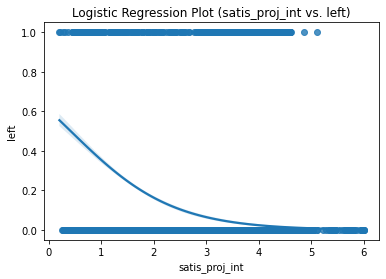

In [93]:
# Logistic regression plot of how Satis_Proj_Int affects the outcome Left variable across its range of values

#sns.regplot(x="satis_proj_int", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (satis_proj_int vs. left)')
#plt.show()

### Observations/Insights

There is a negative correlation between the 'satis_proj_int' variable and the probability that an employee will leave. As 'satis_proj_int' increases, the probability that an employee will leave decreases. The probability that an employee will leave across the range of the predictor variable alone ranges from about 60% down to 0% between values 5 and 6 of 'satis_proj_int'.

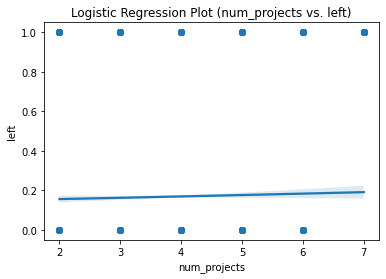

In [117]:
# Logistic regression plot of how Num_Projects affects the outcome Left variable across its range of values

#sns.regplot(x="num_projects", y="left", data=df_logreg_int, logistic=True)
#plt.title('Logistic Regression Plot (num_projects vs. left)')
#plt.show()

### Observations/Insights

There is a slight positive correlation between the 'num_projects' variable and the probability that an employee will leave. As 'num_projects' increases, the probability that an employee will leave slightly increases. The probability that an employee will leave across the range of the predictor variable alone ranges from about 15% up to about 20%.

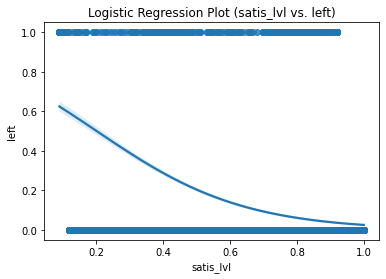

In [94]:
# Logistic regression plot of how Satis_Lvl affects the outcome Left variable across its range of values

#sns.regplot(x="satis_lvl", y="left", data=df_logreg_int2, logistic=True)
#plt.title('Logistic Regression Plot (satis_lvl vs. left)')
#plt.show()

### Observations/Insights

There is a negative correlation between the 'satis_lvl' variable and the probability that an employee will leave. As 'satis_lvl' increases, the probability that an employee will leave decreases. The probability that an employee will leave across the range of the predictor variable alone ranges from over 60% down to about 0% as 'satis_lvl' reaches 1.0.

Each of these logistic regression plots show the individual and interaction variables' level of influence on the outcome of whether or not an employee will leave with 95% confidence bands across the range of values in the predictor variables.

## Decision Tree Model (optimize for F1 score) <a class="anchor" id="dt_f1"></a>

[Go Back to Table of Contents](#toc)

In [48]:
# Create separate dataframe to use for constructing Decision Tree model

df_dt = df_logreg.copy()
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11167 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   satis_lvl            11167 non-null  float64
 1   last_eval            11167 non-null  float64
 2   num_projects         11167 non-null  int64  
 3   avg_monthly_hrs      11167 non-null  int64  
 4   tenure               11167 non-null  int64  
 5   work_accident        11167 non-null  int64  
 6   left                 11167 non-null  int64  
 7   promotion_last_5yrs  11167 non-null  int64  
 8   dept_IT              11167 non-null  uint8  
 9   dept_RandD           11167 non-null  uint8  
 10  dept_accounting      11167 non-null  uint8  
 11  dept_hr              11167 non-null  uint8  
 12  dept_management      11167 non-null  uint8  
 13  dept_marketing       11167 non-null  uint8  
 14  dept_product_mng     11167 non-null  uint8  
 15  dept_sales           11167 non-null 

In [49]:
# Define X and y variables for Decision Tree model

X_dt = df_dt.drop(columns=['left'])

y_dt = df_dt['left']

display(X_dt.head())
display(y_dt.head())

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   
5       0.41       0.50             2              153       3              0   

   promotion_last_5yrs  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0                    0        0           0                0        0   
2                    0        0           0                0        0   
3                    0        0           0                0        0   
4                    0        0           0                0        0   
5                    0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   
5                0               0                 0           1   

   dept_support  dept_technical  salary_low  salary_medium  salary_high  
0             0               0           1              0            0  
2             0               0           0              1            0  
3             0               0           1              0            0  
4             0               0           1              0            0  
5             0               0           1              0            0

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [50]:
# Split X and y into testing and training sets

X_train, X_test, y_train, y_test = train_test_split(X_dt,y_dt, test_size=0.25, stratify=y_dt, random_state=42)

In [51]:
# Instantiate the Decision Tree model

dec_tree = DecisionTreeClassifier(random_state=42)

In [52]:
# Define ranges of cross-validation hyperparameters to use in GridSearch to choose the best model

cv_params = {'max_depth':[6],
             'min_samples_leaf': [1],
             'min_samples_split': [10]
             }

# Define scoring metrics to calculate for the model

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}


# Create the GridSearch object to perform GridSearch while fitting the model

dt_cv = GridSearchCV(dec_tree, cv_params, scoring=scoring, cv=5, refit='f1')

In [53]:
# Perform GridSearch and fit the model

dt_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6], 'min_samples_leaf': [1],
            

In [166]:
# F1 score for the fitted model

print("F1 Score Best Decision Tree Model:",dt_cv.best_score_)

F1 Score Best Decision Tree Model: 0.9482863921271416


In [15]:
# Return full list of hyperparameters for the fitted model

print(dt_cv.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [16]:
# Identify the best combination of hyperparameters defined by the GridSearch

dt_cv.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10}

In [17]:
# Full Grid Search CV Results for reference

dt_cv_full_results = pd.DataFrame(dt_cv.cv_results_)
dt_cv_full_results = dt_cv_full_results.sort_values(by='rank_test_f1',ascending=True)
#display(dt_cv_full_results)

In [54]:
# Define function that creates a performance metrics table based on F1 score optimization given a fitted model to 
# use to compare performance across all constructed models

def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    roc_auc = best_estimator_results.mean_test_roc_auc
    
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy],
                          'ROC/AUC': [roc_auc]
                         }
                        )

    return table

In [55]:
# Get performance metrics for how well the Decision Tree model predicted the y_test observations

dt_cv_results = make_results('Decision Tree CV', dt_cv)
dt_cv_results

Model        F1    Recall  Precision  Accuracy   ROC/AUC
0  Decision Tree CV  0.948286  0.917064   0.981918  0.983164  0.967758

## Decision Tree Model Hyperparameter Tuning Progression (optimizing for F1 score)

### 1st ROUND

**F1 Score DT CV:  0.946220**

Grid search best model hyperparameter results:
   - max_depth: ***8***
   - min_samples_leaf: ***2***
   - min_samples_split: ***6***
     
    
### 2nd ROUND

**F1 Score DT CV:  0.947279**

Grid search best model hyperparameter results:
   - max_depth: ***7***
   - min_samples_leaf: ***2***
   - min_samples_split: ***6***

            
### 3rd ROUND

**F1 Score DT CV:  0.947483** 
    
Grid search best model hyperparameter results:
   - max_depth: ***7***
   - min_samples_leaf: ***2***
   - min_samples_split: ***9***

        
### <span style="color: green;">4th (FINAL) ROUND</span>

### <span style="color: green;">**F1 Score DT CV:  0.948286**</span>

Grid search best model hyperparameter results:
   - max_depth: ***6***
   - min_samples_leaf: ***1***
   - min_samples_split: ***10***

In [22]:
# Define function to calculate confusion matrix values and plot confusion matrix representing the averages of the
# values taken from each round of f1 refit cross-validation for the best model

def make_cv_confusion_matrix(cv_object,y_train):
    
    '''Takes a fitted cv grid search object (i.e. dt_cv) and total number of outcome (y-variable) data points in the
    training dataset (i.e. y_train.shape[0]) and outputs a confusion matrix that represents averaged values from 
    all rounds of cross-validation'''
    
    # Create variable for total number of training set observations
    total_train_obs = y_train.shape[0]
    
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(cv_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]
    
    # Isolate mean recall, precision, and accuracy scores from the best model's cross-validation
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    # Calculate values for the confusion matrix
    true_positives = ((precision * recall) * (total_train_obs - (accuracy * total_train_obs))) / (recall - (2 * recall * precision) + precision)
    false_positives = round((true_positives - (precision * true_positives)) / precision, 0)
    false_negatives = round((true_positives - (recall * true_positives)) / recall, 0)
    true_negatives = round((accuracy * total_train_obs) - true_positives, 0)
    true_positives = round(true_positives, 0)
    predictions_list = [true_negatives,false_positives,false_negatives,true_positives]
    predictions_matrix = np.array(predictions_list).reshape(2,2)
    
    # Plot confusion matrix
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(predictions_matrix, vmin=0, vmax=total_train_obs, annot=True, 
                     cmap = sns.color_palette("mako", as_cmap=True), fmt='g')
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    return plt.show()

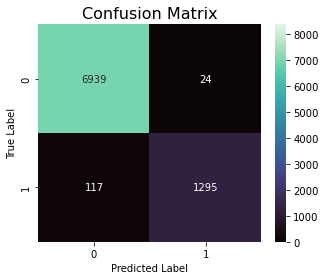

In [23]:
# Plot validation confusion matrix for the fitted Decision Tree

make_cv_confusion_matrix(dt_cv,y_train)

In [157]:
# Print actual outcomes from the train dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_train.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    6964
1    1411


### Observations/Insights

Of the 1319 outcomes the model predicted as positive (an employee leaving), 1295 of them were correct. This is reflected by the model's ~98% Precision score. 

Of the 1411 outcomes that were actually positive (an employee leaving), the model predicted 1295 of them correctly. This is reflected by the model's ~92% Recall score. 

Of the 6964 outcomes that were actually negative (an employee staying), the model predicted 6939 of them correctly. This number combined with the 1295 true positives the model predicted divided by the total number of predictions made (8375) yields the ~98% overall Accuracy score of the model.

**This model performed significantly better than the logistic regression models and had the second highest F1 and Accuracy scores compared to all other models.**

In [168]:
# Identify most important X-variables (features) in the Decision Tree model and put in a table

dt_importances = pd.DataFrame(dt_cv.best_estimator_.feature_importances_)

dt_importances = dt_importances.rename(columns={0:"mean_dec_impurity"})
dt_importances.insert(0, "features", X_dt.columns)
dt_importances = dt_importances.sort_values(by='mean_dec_impurity',ascending=False).reset_index(drop=True)
dt_importances = dt_importances.iloc[:6,:]
display(dt_importances)

features  mean_dec_impurity
0        satis_lvl           0.539962
1           tenure           0.160818
2        last_eval           0.133775
3     num_projects           0.115909
4  avg_monthly_hrs           0.049462
5   dept_technical           0.000074

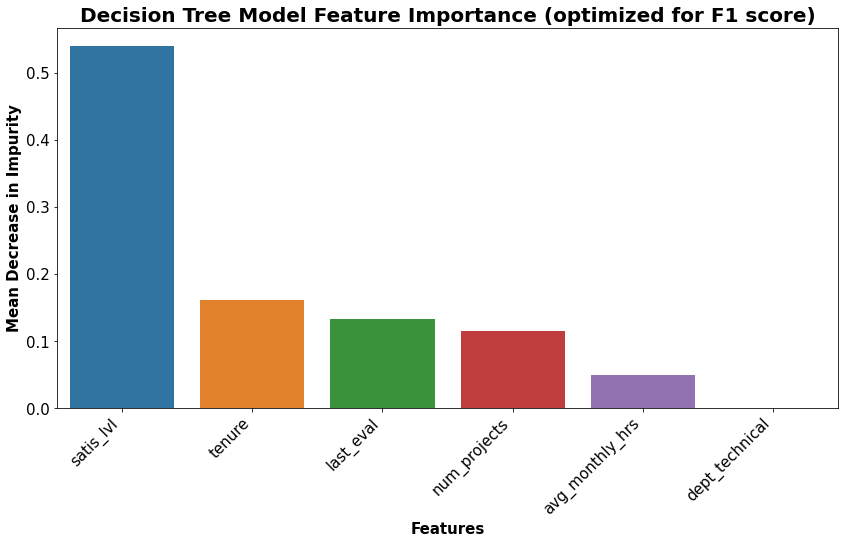

In [169]:
# Plot feature importance for the Decision Tree model; this plot shows the impact each predictor 
# variable has on the model for predicting the outcome variable

plt.figure(figsize=(14,7))
ax = sns.barplot(x=dt_importances['features'],y=dt_importances['mean_dec_impurity'])
plt.title("Decision Tree Model Feature Importance (optimized for F1 score)",fontsize=20,fontweight='bold')
plt.xlabel("Features",fontsize = 15,fontweight='bold')
plt.ylabel("Mean Decrease in Impurity",fontsize = 15,fontweight='bold')
plt.xticks(rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### Observations/Insights

It's interesting to note that the predictor variables important in this model are completely different than the ones important in the logistic regression model.

The top 5 most important features for the decision tree model optimized for F1 score are 'satis_lvl', 'last_eval', 'num_projects', 'tenure', and 'avg_monthly_hrs'.

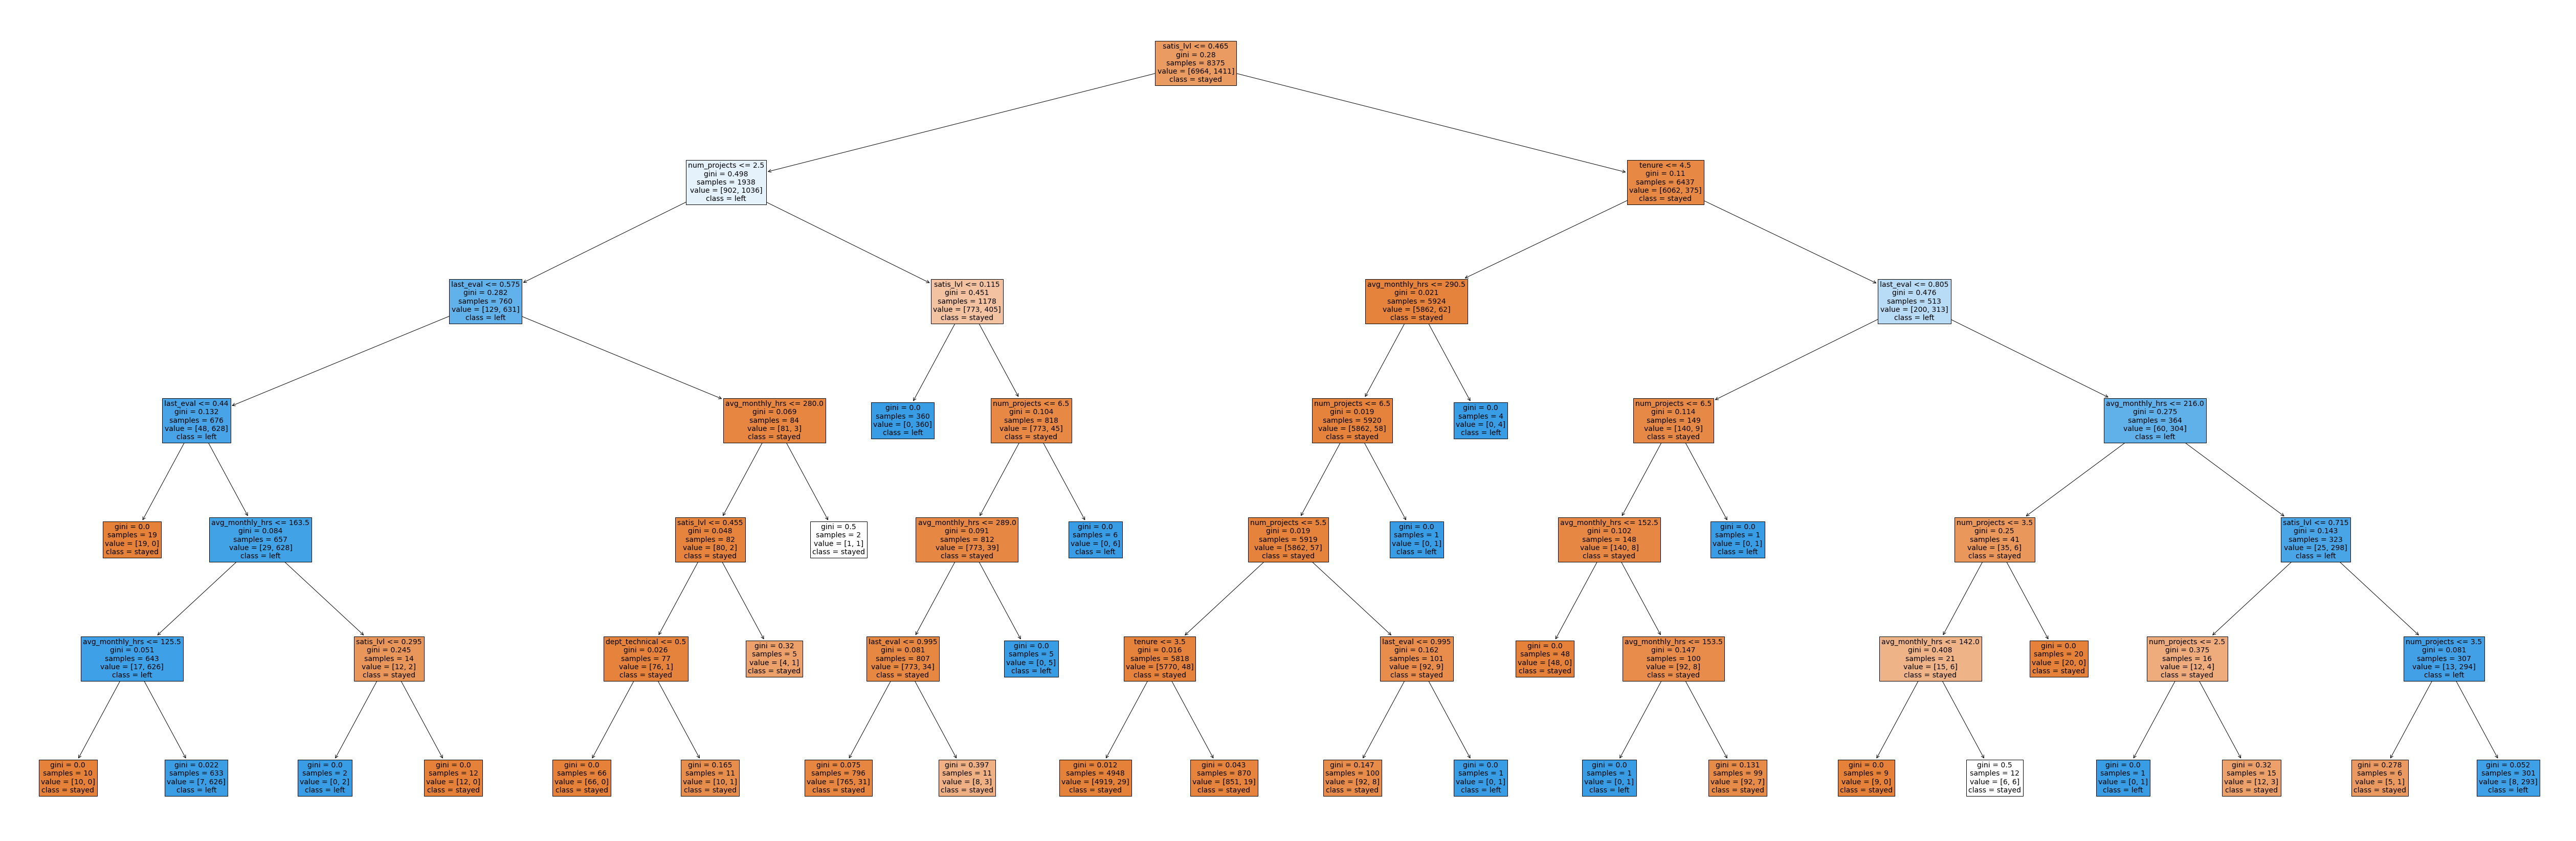

In [297]:
# Plot the Decision Tree

plt.figure(figsize=(90,30))
plot_tree(dt_cv.best_estimator_, max_depth=8, fontsize=14, feature_names=X_dt.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

Double-click on the tree image to zoom in and inspect the splits.

## Decision Tree Model (optimize for Recall score) <a class="anchor" id="dt_recall"></a>

[Go Back to Table of Contents](#toc)

In [56]:
# Define ranges of cross-validation hyperparameters to use in GridSearch to choose the best model

cv_params = {'max_depth':[5],
             'min_samples_leaf': [1],
             'min_samples_split': [2]
             }


# Define scoring metrics to calculate for the model

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}


# Create the GridSearch object to perform GridSearch while fitting the model

dt_recall_cv = GridSearchCV(dec_tree, cv_params, scoring=scoring, cv=5, refit='recall')

In [57]:
# Perform GridSearch and fit the model

dt_recall_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5], 'min_samples_leaf': [1],
            

In [175]:
# Recall score for the fitted model

print("Recall Score Best Decision Tree Model:",dt_recall_cv.best_score_)

Recall Score Best Decision Tree Model: 0.9170638799087788


In [293]:
# Return full list of hyperparameters for the fitted model

print(dt_recall_cv.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [295]:
# Identify the best combination of hyperparameters defined by the GridSearch

dt_recall_cv.best_params_

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [296]:
# Full Grid Search CV Results for reference

dt_recall_cv_full_results = pd.DataFrame(dt_recall_cv.cv_results_)
dt_recall_cv_full_results = dt_recall_cv_full_results.sort_values(by='rank_test_recall',ascending=True)
#display(dt_recall_cv_full_results)

In [58]:
# Define function that creates a performance metrics table based on Recall score optimization given a fitted model 
# to use to compare performance across all constructed models

def make_best_recall_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean Recall score across all validation folds.
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_recall'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    roc_auc = best_estimator_results.mean_test_roc_auc
    
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy],
                          'ROC/AUC': [roc_auc]
                         }
                        )

    return table

In [59]:
# Get performance metrics for how well the Decision Tree model predicted the y_test observations

dt_recall_cv_results = make_best_recall_results('Decision Tree Recall CV', dt_recall_cv)
dt_recall_cv_results

Model        F1    Recall  Precision  Accuracy   ROC/AUC
0  Decision Tree Recall CV  0.940699  0.917064   0.965706  0.980537  0.970439

## Decision Tree Best Model Hyperparameters (optimizing for Recall)  
    
**Recall Score DT CV:  0.917064**

Grid search best model hyperparameter results:
   - max_depth: ***5***
   - min_samples_leaf: ***1***
   - min_samples_split: ***2***
   
This model differed from the F1 optimized model on two hyperparameters: max_depth (5 vs. 6) and min_samples_split (2 vs. 10). Recall is not noticeably improved from the F1 optimized model and other scores besides the ROC/AUC score suffer.

In [35]:
# Define function to calculate confusion matrix values and plot confusion matrix representing the averages of the
# values taken from each round of recall refit cross-validation for the best model

def make_recall_cv_confusion_matrix(cv_object,y_train):
    
    '''Takes a fitted cv grid search object (i.e. dt_cv) and total number of outcome (y-variable) data points in the
    training dataset (i.e. y_train.shape[0]) and outputs a confusion matrix that represents averaged values from 
    all rounds of cross-validation'''
    
    # Create variable for total number of training set observations
    total_train_obs = y_train.shape[0]
    
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(cv_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_recall'].idxmax(), :]
    
    # Isolate mean recall, precision, and accuracy scores from the best model's cross-validation
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    # Calculate values for the confusion matrix
    true_positives = ((precision * recall) * (total_train_obs - (accuracy * total_train_obs))) / (recall - (2 * recall * precision) + precision)
    false_positives = round((true_positives - (precision * true_positives)) / precision, 0)
    false_negatives = round((true_positives - (recall * true_positives)) / recall, 0)
    true_negatives = round((accuracy * total_train_obs) - true_positives, 0)
    true_positives = round(true_positives, 0)
    predictions_list = [true_negatives,false_positives,false_negatives,true_positives]
    predictions_matrix = np.array(predictions_list).reshape(2,2)
    
    # Plot confusion matrix
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(predictions_matrix, vmin=0, vmax=total_train_obs, annot=True, 
                     cmap = sns.color_palette("mako", as_cmap=True), fmt='g')
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    return plt.show()

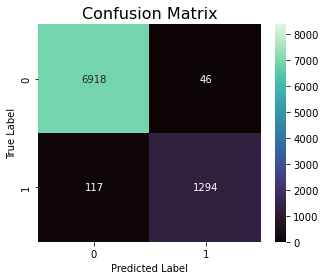

In [36]:
# Plot validation confusion matrix for the fitted Decision Tree

make_recall_cv_confusion_matrix(dt_recall_cv,y_train)

In [160]:
# Print actual outcomes from the train dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_train.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    6964
1    1411


### Observations/Insights

Of the 1340 outcomes the model predicted as positive (an employee leaving), 1294 of them were correct. This is reflected by the model's ~97% Precision score. 

Of the 1411 outcomes that were actually positive (an employee leaving), the model predicted 1294 of them correctly. This is reflected by the model's ~92% Recall score. 

Of the 6964 outcomes that were actually negative (an employee staying), the model predicted 6918 of them correctly. This number combined with the 1294 true positives the model predicted divided by the total number of predictions made (8375) yields the ~98% overall Accuracy score of the model.

**This model performed significantly better than the logistic regression models and its Recall score is slightly higher than the Decision Tree model optimized for F1 score but slightly lower than the Recall scores for the Random Forest and XGBoost Recall optimized models.**

In [172]:
# Identify most important X-variables (features) in the Decision Tree model and put in a table

dt_recall_importances = pd.DataFrame(dt_recall_cv.best_estimator_.feature_importances_)

dt_recall_importances = dt_recall_importances.rename(columns={0:"mean_dec_impurity"})
dt_recall_importances.insert(0, "features", X_dt.columns)
dt_recall_importances = dt_recall_importances.sort_values(by='mean_dec_impurity',ascending=False).reset_index(drop=True)
dt_recall_importances = dt_recall_importances.iloc[:5,:]
display(dt_recall_importances)

features  mean_dec_impurity
0        satis_lvl           0.548735
1           tenure           0.163598
2        last_eval           0.134860
3     num_projects           0.113776
4  avg_monthly_hrs           0.039032

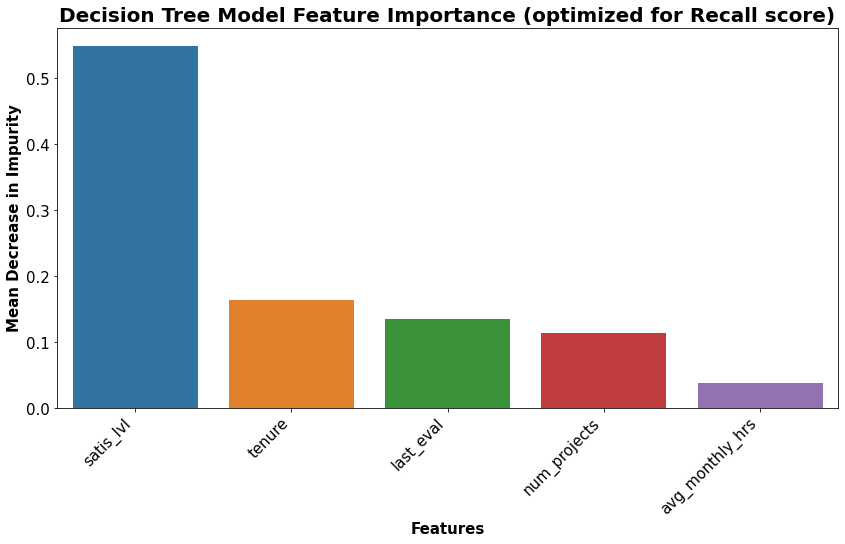

In [173]:
# Plot feature importance for the Decision Tree model; this plot shows the impact each predictor 
# variable has on the model for predicting the outcome variable

plt.figure(figsize=(14,7))
ax = sns.barplot(x=dt_recall_importances['features'],y=dt_recall_importances['mean_dec_impurity'])
plt.title("Decision Tree Model Feature Importance (optimized for Recall score)",fontsize=20,fontweight='bold')
plt.xlabel("Features",fontsize = 15,fontweight='bold')
plt.ylabel("Mean Decrease in Impurity",fontsize = 15,fontweight='bold')
plt.xticks(rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### Observations/Insights

It's interesting to note that the predictor variables important in this model are completely different than the ones important in the logistic regression model.

The top 5 most important features for the decision tree model optimized for Recall score are the same as the top 5 most important features for the decision tree model optimized for F1 score but in a slightly different order: 'satis_lvl', 'tenure', 'last_eval', 'num_projects', and 'avg_monthly_hrs'.

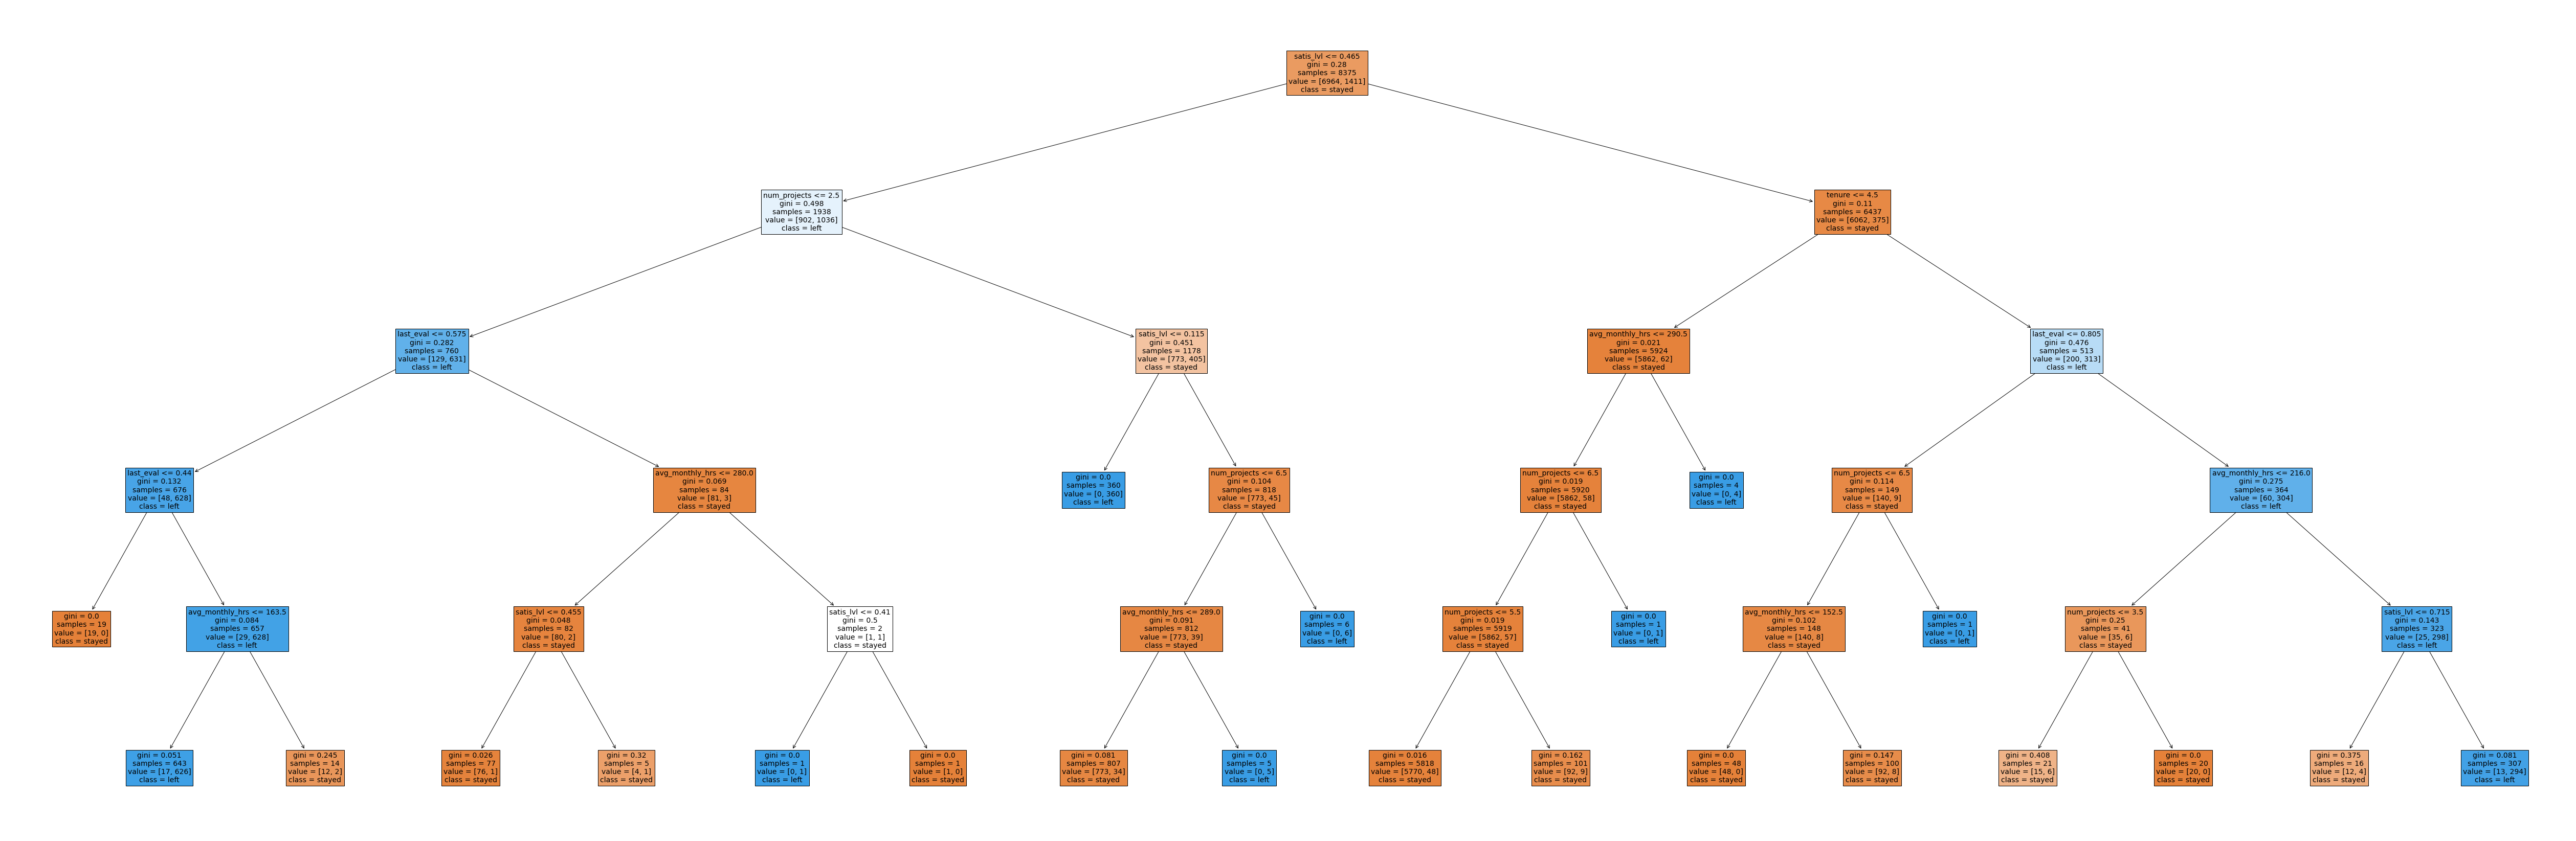

In [53]:
# Plot the Decision Tree

plt.figure(figsize=(90,30))
plot_tree(dt_recall_cv.best_estimator_, max_depth=5, fontsize=14, feature_names=X_dt.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

## Random Forest Model (optimize for F1 score) <a class="anchor" id="rf_f1"></a>

[Go Back to Table of Contents](#toc)

In [60]:
# Create separate dataframe to use for constructing Random Forest model

df_rf = df_logreg.copy()
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11167 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   satis_lvl            11167 non-null  float64
 1   last_eval            11167 non-null  float64
 2   num_projects         11167 non-null  int64  
 3   avg_monthly_hrs      11167 non-null  int64  
 4   tenure               11167 non-null  int64  
 5   work_accident        11167 non-null  int64  
 6   left                 11167 non-null  int64  
 7   promotion_last_5yrs  11167 non-null  int64  
 8   dept_IT              11167 non-null  uint8  
 9   dept_RandD           11167 non-null  uint8  
 10  dept_accounting      11167 non-null  uint8  
 11  dept_hr              11167 non-null  uint8  
 12  dept_management      11167 non-null  uint8  
 13  dept_marketing       11167 non-null  uint8  
 14  dept_product_mng     11167 non-null  uint8  
 15  dept_sales           11167 non-null 

In [61]:
# Define X and y variables for Random Forest model

X_rf = df_rf.drop(columns=['left'])

y_rf = df_rf['left']

display(X_rf.head())
display(y_rf.head())

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   
5       0.41       0.50             2              153       3              0   

   promotion_last_5yrs  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0                    0        0           0                0        0   
2                    0        0           0                0        0   
3                    0        0           0                0        0   
4                    0        0           0                0        0   
5                    0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   
5                0               0                 0           1   

   dept_support  dept_technical  salary_low  salary_medium  salary_high  
0             0               0           1              0            0  
2             0               0           0              1            0  
3             0               0           1              0            0  
4             0               0           1              0            0  
5             0               0           1              0            0

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [62]:
# Split X and y into testing and training sets

X_train, X_test, y_train, y_test = train_test_split(X_rf,y_rf, test_size=0.25, stratify=y_rf, random_state=42)

In [63]:
# Instantiate the Random Forest model

rf = RandomForestClassifier(random_state=42)

In [64]:
# Define ranges of cross-validation hyperparameters to use in GridSearch to choose the best model

cv_params = {'max_depth': [8], 
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'max_features': [1.0],
             'n_estimators': [400],
             'max_samples': [0.9]
             }  

# Define scoring metrics to calculate for the model

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}


# Create the GridSearch object to perform GridSearch while fitting the model

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [65]:
# Perform GridSearch and fit the model; output elapsed time for this task

#%%time
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [109]:
# Define function to write a pickle to save the fitted model so that fitting does not need to be performed again 
# if the kernel is interrupted/restarted

def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [110]:
# Define function to read the pickle that was written so that the fitted model can be accessed upon kernel restart

def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [112]:
# Define file path for the pickle

path = '/home/jovyan/work/'

In [82]:
# Write pickle

#write_pickle(path, rf_cv, 'rf_cv')

In [417]:
# Read pickle

rf_cv = read_pickle(path, 'rf_cv')

In [43]:
# F1 score for the fitted model

print("F1 Score Best RF Model:",rf_cv.best_score_)

F1 Score Best RF Model: 0.952819536513096


In [44]:
# Return full list of hyperparameters for the fitted model

print(rf_cv.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=1.0,
                       max_leaf_nodes=None, max_samples=0.9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [189]:
# Identify the best combination of hyperparameters defined by the GridSearch

rf_cv.best_params_

{'max_depth': 8,
 'max_features': 1.0,
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [46]:
# Full Grid Search CV Results for reference

rf_cv_full_results = pd.DataFrame(rf_cv.cv_results_)
rf_cv_full_results = rf_cv_full_results.sort_values(by='rank_test_f1',ascending=True)
#display(rf_cv_full_results)

In [66]:
# Define function that creates a performance metrics table given a fitted model to use to compare performance across
# all constructed models

def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    roc_auc = best_estimator_results.mean_test_roc_auc
    
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy],
                          'ROC/AUC': [roc_auc]
                         }
                        )

    return table

In [67]:
# Get performance metrics for how well the Random Forest model predicted the y_test observations

rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results

Model       F1    Recall  Precision  Accuracy   ROC/AUC
0  Random Forest CV  0.95282  0.917066   0.991579  0.984716  0.977217

## Random Forest Model Hyperparameter Tuning Progression (optimizing for F1 score)

### 1st ROUND

**F1 Score RF CV:  0.951276**

Grid search best model hyperparameter results:
   - max_depth: ***None***
   - max_features: ***1.0***
   - min_samples_leaf: ***1***
   - min_samples_split: ***3***
   - n_estimators: ***300***
   - max_samples: ***0.7***
     
    
### 2nd ROUND

**F1 Score RF CV:  0.951658**

Grid search best model hyperparameter results:
   - max_depth: ***None***
   - max_features: ***1.0***
   - min_samples_leaf: ***1***
   - min_samples_split: ***4***
   - n_estimators: ***300***
   - max_samples: ***0.8***

            
### 3rd ROUND

**F1 Score RF CV:  0.952439** 
    
Grid search best model hyperparameter results:
   - max_depth: ***8***
   - max_features: ***1.0***
   - min_samples_leaf: ***1***
   - min_samples_split: ***3***
   - n_estimators: ***400***
   - max_samples: ***1.0***

        
### <span style="color: green;">4th (FINAL) ROUND</span>

### <span style="color: green;">**F1 Score RF CV:  0.952819**</span>

Grid search best model hyperparameter results:
   - max_depth: ***8***
   - max_features: ***1.0***
   - min_samples_leaf: ***1***
   - min_samples_split: ***4***
   - n_estimators: ***400***
   - max_samples: ***0.9***

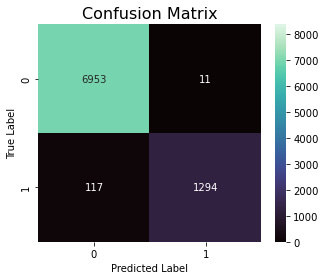

In [49]:
# Plot validation confusion matrix for the fitted Random Forest

make_cv_confusion_matrix(rf_cv,y_train)

In [173]:
# Print actual outcomes from the train dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_train.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    6964
1    1411


### Observations/Insights

Of the 1305 outcomes the model predicted as positive (an employee leaving), 1294 of them were correct. This is reflected by the model's ~99% Precision score. 

Of the 1411 outcomes that were actually positive (an employee leaving), the model predicted 1294 of them correctly. This is reflected by the model's ~92% Recall score. 

Of the 6964 outcomes that were actually negative (an employee staying), the model predicted 6953 of them correctly. This number combined with the 1294 true positives the model predicted divided by the total number of predictions made (8375) yields the ~98% overall Accuracy score of the model.

**This model has the highest F1 and Accuracy scores compared to all other models.**

In [131]:
# Identify most important X-variables (features) in the Random Forest model and put in a table

rf_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_)

rf_importances = rf_importances.rename(columns={0:"mean_dec_impurity"})
rf_importances.insert(0, "features", X_rf.columns)
rf_importances = rf_importances.sort_values(by='mean_dec_impurity',ascending=False).reset_index(drop=True)
rf_importances = rf_importances.iloc[:5,:]
display(rf_importances)

features  mean_dec_impurity
0        satis_lvl           0.508851
1           tenure           0.157265
2     num_projects           0.138034
3        last_eval           0.128044
4  avg_monthly_hrs           0.058348

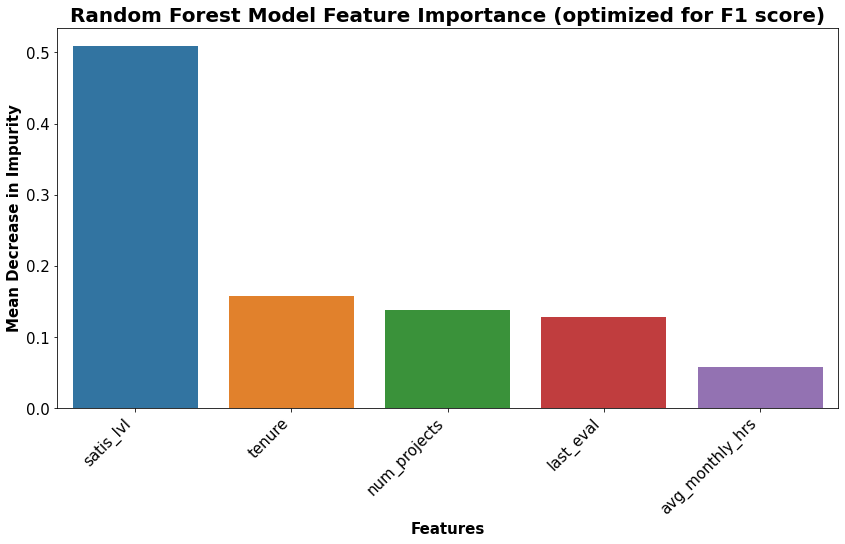

In [137]:
# Plot feature importance for the Random Forest model; this plot shows the impact each predictor 
# variable has on the model for predicting the outcome variable

plt.figure(figsize=(14,7))
ax = sns.barplot(x=rf_importances['features'],y=rf_importances['mean_dec_impurity'])
plt.title("Random Forest Model Feature Importance (optimized for F1 score)",fontsize=20,fontweight='bold')
plt.xlabel("Features",fontsize = 15,fontweight='bold')
plt.ylabel("Mean Decrease in Impurity",fontsize = 15,fontweight='bold')
plt.xticks(rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### Observations/Insights

It's interesting to note that the predictor variables important in this model are completely different than the ones important in the logistic regression model.

The top 5 most important features for the random forest model optimized for F1 score are the same as the features important in the decision tree models, but in a slightly different order: 'satis_lvl', 'tenure', 'num_projects', 'last_eval', and 'avg_monthly_hrs'.

## Random Forest Model (optimize for Recall score) <a class="anchor" id="rf_recall"></a>

[Go Back to Table of Contents](#toc)

In [68]:
# Define ranges of cross-validation hyperparameters to use in GridSearch to choose the best model

cv_params = {'max_depth': [5], 
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'max_features': [1.0],
             'n_estimators': [200],
             'max_samples': [0.9]
             } 

# Define scoring metrics to calculate for the model

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}


# Create the GridSearch object to perform GridSearch while fitting the model

rf_recall_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [69]:
# Perform GridSearch and fit the model; output elapsed time for this task

#%%time
rf_recall_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [113]:
# Write pickle

#write_pickle(path, rf_recall_cv, 'rf_recall_cv')

In [ ]:
# Read pickle

rf_recall_cv = read_pickle(path, 'rf_recall_cv')

In [52]:
# Recall score for the fitted model

print("Recall Score Best RF Model:",rf_recall_cv.best_score_)

Recall Score Best RF Model: 0.9184823196250909


In [53]:
# Return full list of hyperparameters for the fitted model

print(rf_recall_cv.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=1.0,
                       max_leaf_nodes=None, max_samples=0.9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [54]:
# Identify the best combination of hyperparameters defined by the GridSearch

rf_recall_cv.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [55]:
# Full Grid Search CV Results for reference

rf_recall_cv_full_results = pd.DataFrame(rf_recall_cv.cv_results_)
rf_recall_cv_full_results = rf_recall_cv_full_results.sort_values(by='rank_test_recall',ascending=True)
#display(rf_recall_cv_full_results)

In [70]:
# Get performance metrics for how well the Random Forest model predicted the y_test observations

rf_recall_cv_results = make_best_recall_results('Random Forest Recall CV', rf_recall_cv)
rf_recall_cv_results

Model        F1    Recall  Precision  Accuracy   ROC/AUC
0  Random Forest Recall CV  0.941807  0.918482   0.966505  0.980896  0.978817

## Random Forest Best Model Hyperparameters (optimizing for Recall)

### **1st ROUND**

**Recall Score RF CV:  0.917773**

Grid search best model hyperparameter results:
   - max_depth: ***6***
   - max_features: ***1.0***
   - min_samples_leaf: ***1***
   - min_samples_split: ***2***
   - n_estimators: ***300***
   - max_samples: ***0.9***
   
   
### <span style="color: green;">**2nd ROUND**

### <span style="color: green;">**Recall Score RF CV:  0.918482**

Grid search best model hyperparameter results:
   - max_depth: ***5***
   - max_features: ***1.0***
   - min_samples_leaf: ***1***
   - min_samples_split: ***2***
   - n_estimators: ***200***
   - max_samples: ***0.9***
   
This model differed from the F1 optimized model on two hyperparameters: max_depth (5 vs. 8) and n_estimators (200 vs. 400). Recall is slightly improved in this model over the F1 model (0.918482 vs. 0.917066 for the F1 optimized model), however Precision suffered by a greater amount, causing F1 and Accuracy scores to drop. The ROC AUC score is slightly higher for this model (0.978817 vs. 0.977217 for the F1 optimized model).

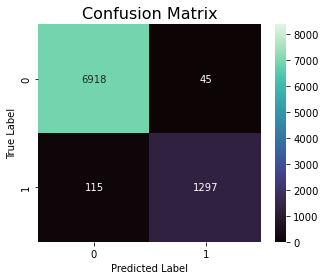

In [57]:
# Plot validation confusion matrix for the fitted Random Forest

make_recall_cv_confusion_matrix(rf_recall_cv,y_train)

In [183]:
# Print actual outcomes from the train dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_train.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    6964
1    1411


### Observations/Insights

Of the 1342 outcomes the model predicted as positive (an employee leaving), 1297 of them were correct. This is reflected by the model's ~97% Precision score. 

Of the 1411 outcomes that were actually positive (an employee leaving), the model predicted 1297 of them correctly. This is reflected by the model's ~92% Recall score. 

Of the 6964 outcomes that were actually negative (an employee staying), the model predicted 6918 of them correctly. This number combined with the 1297 true positives the model predicted divided by the total number of predictions made (8375) yields the ~98% overall Accuracy score of the model.

**This model performed significantly better than the logistic regression models, slightly better than the Decision Tree models, and slightly better on the Recall score than the F1 score optimized Random Forest model. This model ranks second in Recall behind the XGBoost Recall optimized model.**

In [160]:
# Identify most important X-variables (features) in the Random Forest model and put in a table

rf_recall_importances = pd.DataFrame(rf_recall_cv.best_estimator_.feature_importances_)

rf_recall_importances = rf_recall_importances.rename(columns={0:"mean_dec_impurity"})
rf_recall_importances.insert(0, "features", X_rf.columns)
rf_recall_importances = rf_recall_importances.sort_values(by='mean_dec_impurity',ascending=False).reset_index(drop=True)
rf_recall_importances = rf_recall_importances.iloc[:5,:]
display(rf_recall_importances)

features  mean_dec_impurity
0        satis_lvl           0.523723
1           tenure           0.163649
2     num_projects           0.138443
3        last_eval           0.125643
4  avg_monthly_hrs           0.046947

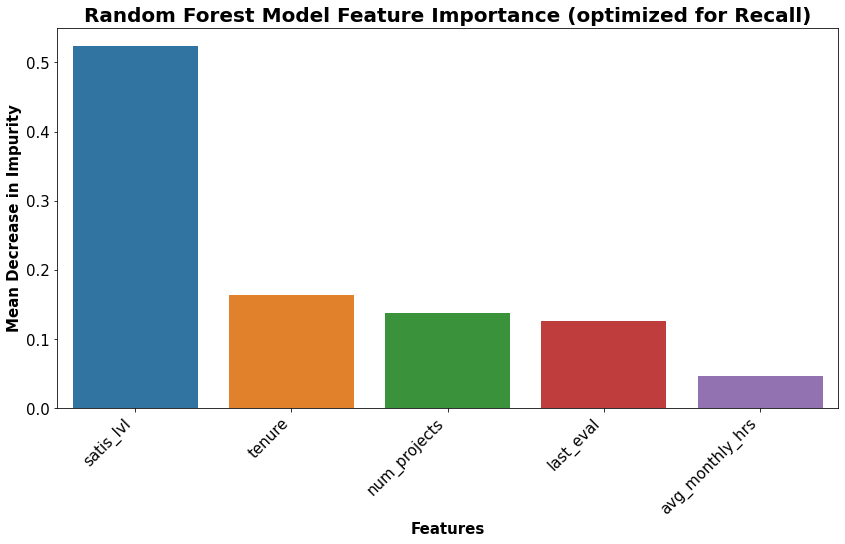

In [161]:
# Plot feature importance for the Random Forest model; this plot shows the impact each predictor 
# variable has on the model for predicting the outcome variable

plt.figure(figsize=(14,7))
ax = sns.barplot(x=rf_recall_importances['features'],y=rf_recall_importances['mean_dec_impurity'])
plt.title("Random Forest Model Feature Importance (optimized for Recall)",fontsize=20,fontweight='bold')
plt.xlabel("Features",fontsize = 15,fontweight='bold')
plt.ylabel("Mean Decrease in Impurity",fontsize = 15,fontweight='bold')
plt.xticks(rotation=45, horizontalalignment='right')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### Observations/Insights

It's interesting to note that the predictor variables important in this model are completely different than the ones important in the logistic regression model.

The top 5 most important features for the random forest model optimized for Recall score are the same as the features important in the random forest model optimized for F1 score and are in the same order by importance: 'satis_lvl', 'tenure', 'num_projects', 'last_eval', and 'avg_monthly_hrs'.

## XGBoost Model (optimize for F1 score) <a class="anchor" id="xgb_f1"></a>

[Go Back to Table of Contents](#toc)

In [71]:
# Define X and y variables to build the XGBoost model

X = df_logreg.drop(columns=['left'])

y = df_logreg['left']

display(X.head())
display(y.head())

satis_lvl  last_eval  num_projects  avg_monthly_hrs  tenure  work_accident  \
0       0.38       0.53             2              157       3              0   
2       0.11       0.88             7              272       4              0   
3       0.72       0.87             5              223       5              0   
4       0.37       0.52             2              159       3              0   
5       0.41       0.50             2              153       3              0   

   promotion_last_5yrs  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0                    0        0           0                0        0   
2                    0        0           0                0        0   
3                    0        0           0                0        0   
4                    0        0           0                0        0   
5                    0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   
5                0               0                 0           1   

   dept_support  dept_technical  salary_low  salary_medium  salary_high  
0             0               0           1              0            0  
2             0               0           0              1            0  
3             0               0           1              0            0  
4             0               0           1              0            0  
5             0               0           1              0            0

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [72]:
# Split X and y into testing and training sets

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=42)

In [73]:
# Instantiate the XGBoost model

xgb = XGBClassifier(objective='binary:logistic', random_state=42) 

In [74]:
# Define ranges of cross-validation hyperparameters to use in GridSearch to choose the best model

cv_params = {'max_depth': [6], 
             'min_child_weight': [0.4],
             'learning_rate': [0.1],
             'n_estimators': [100],
             'colsample_bytree': [0.4]
             }    

# Define scoring metrics to calculate for the model

scoring = {'accuracy', 'precision', 'recall', 'f1','roc_auc'}


# Create the GridSearch object to perform GridSearch while fitting the model

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [75]:
# Perform GridSearch and fit the model; output elapsed time for this task

#%%time
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     objective='binary:logistic',
                                     predictor=None, random_state=42,
                                     reg_alpha=None, ...),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree':

In [181]:
# Write pickle

# write_pickle(path, xgb_cv, 'xgb_cv')

In [413]:
# Read pickle

# xgb_cv = read_pickle(path, 'xgb_cv')

In [306]:
# Return full list of hyperparameters for the fitted model

xgb_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=0.4,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [307]:
# Identify the best combination of hyperparameters defined by the GridSearch

xgb_cv.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 0.4,
 'n_estimators': 100}

In [308]:
# Full Grid Search CV Results for reference

xgb_cv_full_results = pd.DataFrame(xgb_cv.cv_results_)
xgb_cv_full_results = xgb_cv_full_results.sort_values(by='rank_test_f1',ascending=True)
#display(xgb_cv_full_results)

In [76]:
# Get performance metrics for how well the XGBoost model predicted the y_train observations

xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

Model       F1    Recall  Precision  Accuracy   ROC/AUC
0  XGBoost CV  0.94376  0.911393    0.97881  0.981731  0.983629

## XGBoost Model Hyperparameter Tuning Progression (optimizing for F1 score)

### 1st ROUND

**F1 score XGB CV:  0.942836**
 
Hyperparameters used in grid search: 
   - max_depth: [4,5,6]
   - min_child_weight: [1,2,3]
   - learning_rate: [0.1, 0.2, 0.3]
   - n_estimators: [100,200,300]
   - colsample_bytree: [0.7,1.0] 

Grid search best model hyperparameter results:
   - colsample_bytree: ***0.7***
   - learning_rate: ***0.1***
   - max_depth: ***6***
   - min_child_weight: ***1***
   - n_estimators: ***100***
    
    
### 2nd ROUND

**F1 score XGB CV:  0.94376**

Hyperparameters used in grid search:
   - max_depth: [6,7] 
   - min_child_weight: [0.3,0.4,0.5]
   - learning_rate: [0.1,0.08,0.09]
   - n_estimators: [100,150,200,75]
   - colsample_bytree: [0.5,0.4,0.3]  
    
Grid search best model hyperparameter results:
   - colsample_bytree: ***0.4***
   - learning_rate: ***0.1***
   - max_depth: ***6***
   - min_child_weight: ***0.4***
   - n_estimators: ***100***
   

### <span style="color: green;">3rd (FINAL) ROUND</span>

<span style="color: green;">**F1 score XGB CV:  0.943908**</span>

Hyperparameters used in grid search: 
   - max_depth: [6,7]
   - min_child_weight: [1,0.5]
   - learning_rate: [0.1,0.05]
   - n_estimators: [100,200,300]
   - colsample_bytree: [0.5,0.6] 


Grid search best model hyperparameter results:
   - colsample_bytree: ***0.5***
   - learning_rate: ***0.1***
   - max_depth: ***6***
   - min_child_weight: ***0.5***
   - n_estimators: ***100***

            


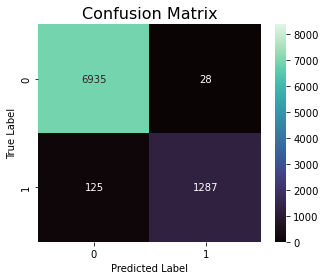

In [67]:
# Plot validation confusion matrix for the fitted XGBoost model

make_cv_confusion_matrix(xgb_cv,y_train)

In [203]:
# Print actual outcomes from the train dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_train.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    6964
1    1411


### Observations/Insights

Of the 1315 outcomes the model predicted as positive (an employee leaving), 1287 of them were correct. This is reflected by the model's ~98% Precision score. 

Of the 1411 outcomes that were actually positive (an employee leaving), the model predicted 1287 of them correctly. This is reflected by the model's ~91% Recall score. 

Of the 6964 outcomes that were actually negative (an employee staying), the model predicted 6935 of them correctly. This number combined with the 1287 true positives the model predicted divided by the total number of predictions made (8375) yields the ~98% overall Accuracy score of the model.

**This model performed significantly better than the logistic regression models and its ROC/AUC score was highest amongst the F1 optimized models but its F1 score was slightly lower than both the Decision Tree and Random Forest models.**

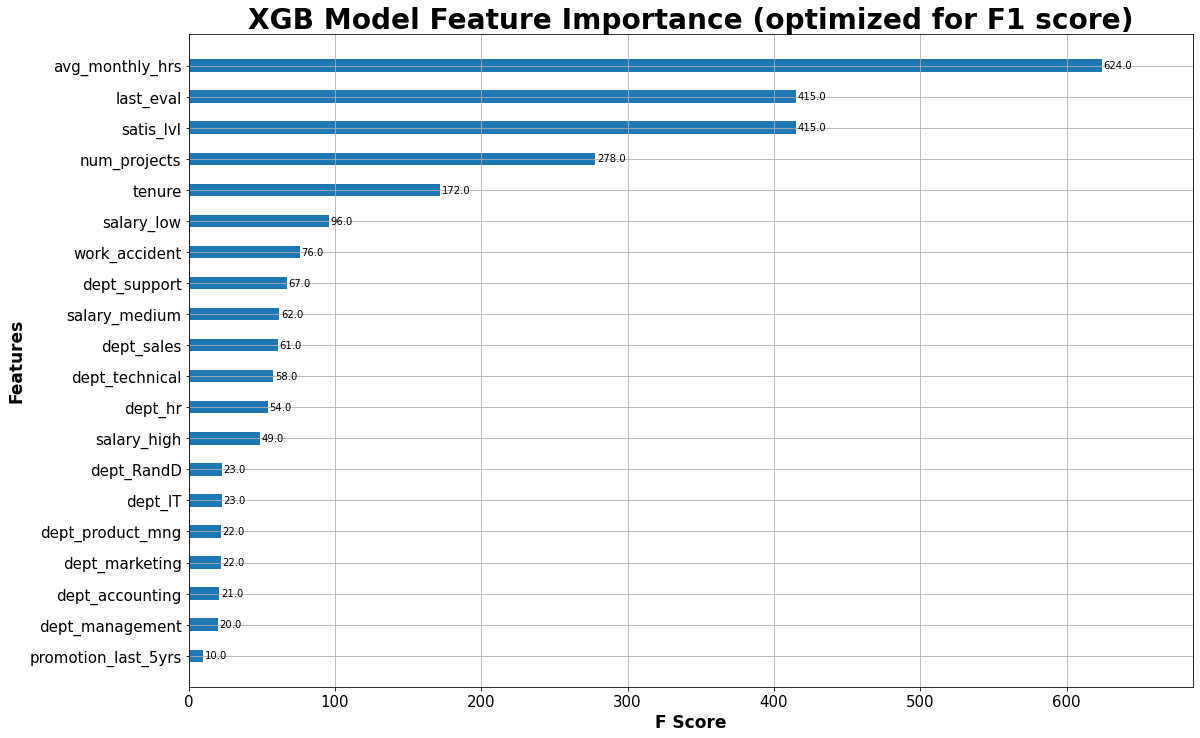

In [153]:
# Plot feature importance for the XGBoost model; this plot shows the impact each predictor 
# variable has on the model for predicting the outcome variable

ax = plot_importance(xgb_cv.best_estimator_,height = 0.4)
fig = ax.figure
fig.set_size_inches(18, 12)
plt.title('XGB Model Feature Importance (optimized for F1 score)',fontsize = 28,fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('F Score',fontsize=17,fontweight='bold')
plt.ylabel('Features',fontsize=17,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=15)

### Observations/Insights

It's interesting to note that the predictor variables important in this model are completely different than the ones important in the logistic regression model.

The top 5 most important features for the XGBoost model optimized for F1 score are the same as the features important in the decision tree and random forest models, but in a slightly different order: 'avg_monthly_hrs', 'last_eval', 'satis_lvl', 'num_projects', and 'tenure'.

In [ ]:
# Bayesian Hyperparameter Optimization using Hyperopt (to be used in future hyperparameter tuning)

space={'max_depth': hp.quniform("max_depth", 2, 18,1),  # https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.01,1.0),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 75, 500, 1),
       'learning_rate': hp.quniform('learning_rate',0.01,0.3,0.01),
       'seed': 0
    }

def objective(space):
    clf=XGBClassifier(
                    n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),learning_rate=space['learning_rate'],
                    objective='binary:logistic', random_state=42)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    f1 = f1_score(y_test, pred>0.5)
    precision = precision_score(y_test, pred>0.5)
    recall = recall_score(y_test, pred>0.5)
    roc_auc = roc_auc_score(y_test, pred>0.5)
    print("Accuracy SCORE:", accuracy)
    print("F1 SCORE:", f1)
    print("Precision SCORE:", precision)
    print("Recall SCORE:", recall)
    print("ROC/AUC SCORE:", roc_auc)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)


print("The best hyperparameters are : ","\n")
print(best_hyperparams)

Accuracy SCORE:                                        
0.8313037249283668                                     
F1 SCORE:                                              
0.0                                                    
Precision SCORE:                                       
0.0                                                    
Recall SCORE:                                          
0.0                                                    
ROC/AUC SCORE:                                         
0.5                                                    
Accuracy SCORE:                                                      
0.9487822349570201                                                   
F1 SCORE:                                                            
0.824969400244798                                                    
Precision SCORE:                                                     
0.9739884393063584                                                   
Recall SCORE:       

In [176]:
# Instantiate the XGBoost HP model and fit it with the training dataset

xgb_hp = XGBClassifier(
                n_estimators = 415, max_depth = 7, gamma = 5.637616895382045,
                reg_alpha = 113.0,min_child_weight=2.0,colsample_bytree=0.9439989584373515,
                learning_rate=0.26,reg_lambda=0.09024490118583148,
                objective='binary:logistic', random_state=42)

xgb_hp.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9439989584373515, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=5.637616895382045, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.26, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=2.0,
              missing=nan, monotone_constraints='()', n_estimators=415,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=113.0, ...)

In [179]:
# Get performance metrics for how well the XGBoost HP model predicted the y_train observations

pred = xgb_hp.predict(X_train)
accuracy = accuracy_score(y_train, pred>0.5)
f1 = f1_score(y_train, pred>0.5)
precision = precision_score(y_train, pred>0.5)
recall = recall_score(y_train, pred>0.5)
roc_auc = roc_auc_score(y_train, pred>0.5)
print("Accuracy SCORE:", accuracy)
print("F1 SCORE:", f1)
print("Precision SCORE:", precision)
print("Recall SCORE:", recall)
print("ROC/AUC SCORE:", roc_auc)

Accuracy SCORE: 0.9711044776119403
F1 SCORE: 0.9118075801749271
Precision SCORE: 0.9384846211552889
Recall SCORE: 0.8866052445074415
ROC/AUC SCORE: 0.9374152012313198


## XGBoost Model (optimize for Recall score) <a class="anchor" id="xgb_recall"></a>

[Go Back to Table of Contents](#toc)

In [77]:
# Define ranges of cross-validation hyperparameters to use in GridSearch to choose the best model

cv_params = {'max_depth': [2], 
             'min_child_weight': [0.4],
             'learning_rate': [0.1],
             'n_estimators': [400],
             'colsample_bytree': ['0.5']
             }    

# Define scoring metrics to calculate for the model

scoring = {'accuracy', 'precision', 'recall', 'f1','roc_auc'}


# Create the GridSearch object to perform GridSearch while fitting the model

xgb_recall_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [78]:
# Perform GridSearch and fit the model; output elapsed time for this task

#%%time
xgb_recall_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     objective='binary:logistic',
                                     predictor=None, random_state=42,
                                     reg_alpha=None, ...),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree':

In [ ]:
# Write pickle

write_pickle(path, xgb_recall_cv, 'xgb_recall_cv')

In [ ]:
# Read pickle

# xgb_cv = read_pickle(path, 'xgb_recall_cv')

In [70]:
# Return full list of hyperparameters for the fitted model

xgb_recall_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree='0.5',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=0.4,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [71]:
# Recall score for the fitted model

print("Recall Score Best XGB Model:",xgb_recall_cv.best_score_)

Recall Score Best XGB Model: 0.925572012129414


In [72]:
# Identify the best combination of hyperparameters defined by the GridSearch

xgb_recall_cv.best_params_

{'colsample_bytree': '0.5',
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 0.4,
 'n_estimators': 400}

In [73]:
# Full Grid Search CV Results for reference

xgb_recall_cv_full_results = pd.DataFrame(xgb_recall_cv.cv_results_)
xgb_recall_cv_full_results = xgb_recall_cv_full_results.sort_values(by='rank_test_recall',ascending=True)
#display(xgb_recall_cv_full_results)

In [79]:
# Get performance metrics for how well the XGBoost model predicted the y_train observations

xgb_recall_cv_results = make_best_recall_results('XGBoost Recall CV', xgb_recall_cv)
xgb_recall_cv_results

Model        F1    Recall  Precision  Accuracy   ROC/AUC
0  XGBoost Recall CV  0.942945  0.925572   0.961091  0.981134  0.983776

## XGBoost Model Hyperparameter Tuning Progression (optimizing for Recall)

### 1st ROUND

**Recall score XGB Recall CV:  0.919191**
 
Hyperparameters used in grid search: 
   - max_depth: [4,6,None]
   - min_child_weight: [0.3,0.8]
   - learning_rate: [0.05,0.1, 0.3]
   - n_estimators: [100,300]
   - colsample_bytree: [0.4,0.6,1.0] 

Grid search best model hyperparameter results:
   - colsample_bytree: ***0.4***
   - learning_rate: ***0.1***
   - max_depth: ***4***
   - min_child_weight: ***0.3***
   - n_estimators: ***300***
   
   
### 2nd ROUND

**Recall score XGB Recall CV:  0.921319**
 
Hyperparameters used in grid search: 
   - max_depth: [3,4,6,None]
   - min_child_weight: [0.2,0.3,0.5]
   - learning_rate: [0.08,0.1, 0.2]
   - n_estimators: [100,300,500]
   - colsample_bytree: [0.3,0.4,0.5] 

Grid search best model hyperparameter results:
   - colsample_bytree: ***0.4***
   - learning_rate: ***0.2***
   - max_depth: ***3***
   - min_child_weight: ***0.2***
   - n_estimators: ***500***
   
   
### 3rd ROUND

**Recall score XGB Recall CV:  0.924151**
 
Hyperparameters used in grid search: 
   - max_depth: [2,3,4,6]
   - min_child_weight: [0.3,0.2,0.1]
   - learning_rate: [0.1,0.3,0.2]
   - n_estimators: [300,500,600]
   - colsample_bytree: [0.3,0.4,0.5] 

Grid search best model hyperparameter results:
   - colsample_bytree: ***0.5***
   - learning_rate: ***0.1***
   - max_depth: ***2***
   - min_child_weight: ***0.3***
   - n_estimators: ***300***
   
   
### <span style="color: green;">4th (FINAL) ROUND

<span style="color: green;">**Recall score XGB Recall CV:  0.925572**
 
Hyperparameters used in grid search: 
   - max_depth: [2,3,4,5]
   - min_child_weight: [0.3,0.2,0.4]
   - learning_rate: [0.1,0.09,0.2]
   - n_estimators: [300,400,500]
   - colsample_bytree: [0.5,0.4,0.6] 

Grid search best model hyperparameter results:
   - colsample_bytree: ***0.5***
   - learning_rate: ***0.1***
   - max_depth: ***2***
   - min_child_weight: ***0.4***
   - n_estimators: ***400***

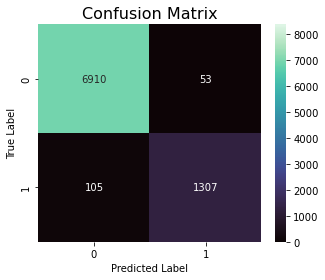

In [75]:
# Plot validation confusion matrix for the fitted Random Forest

make_recall_cv_confusion_matrix(xgb_recall_cv,y_train)

In [143]:
# Print actual outcomes from the train dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_train.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    6964
1    1411


### Observations/Insights

Of the 1360 outcomes the model predicted as positive (an employee leaving), 1307 of them were correct. This is reflected by the model's ~96% Precision score. 

Of the 1411 outcomes that were actually positive (an employee leaving), the model predicted 1307 of them correctly. This is reflected by the model's ~93% Recall score. 

Of the 6964 outcomes that were actually negative (an employee staying), the model predicted 6910 of them correctly. This number combined with the 1307 true positives the model predicted divided by the total number of predictions made (8375) yields the ~98% overall Accuracy score of the model.

**This model performed significantly better than the logistic regression models and has the best Recall and ROC/AUC scores of all the models.**

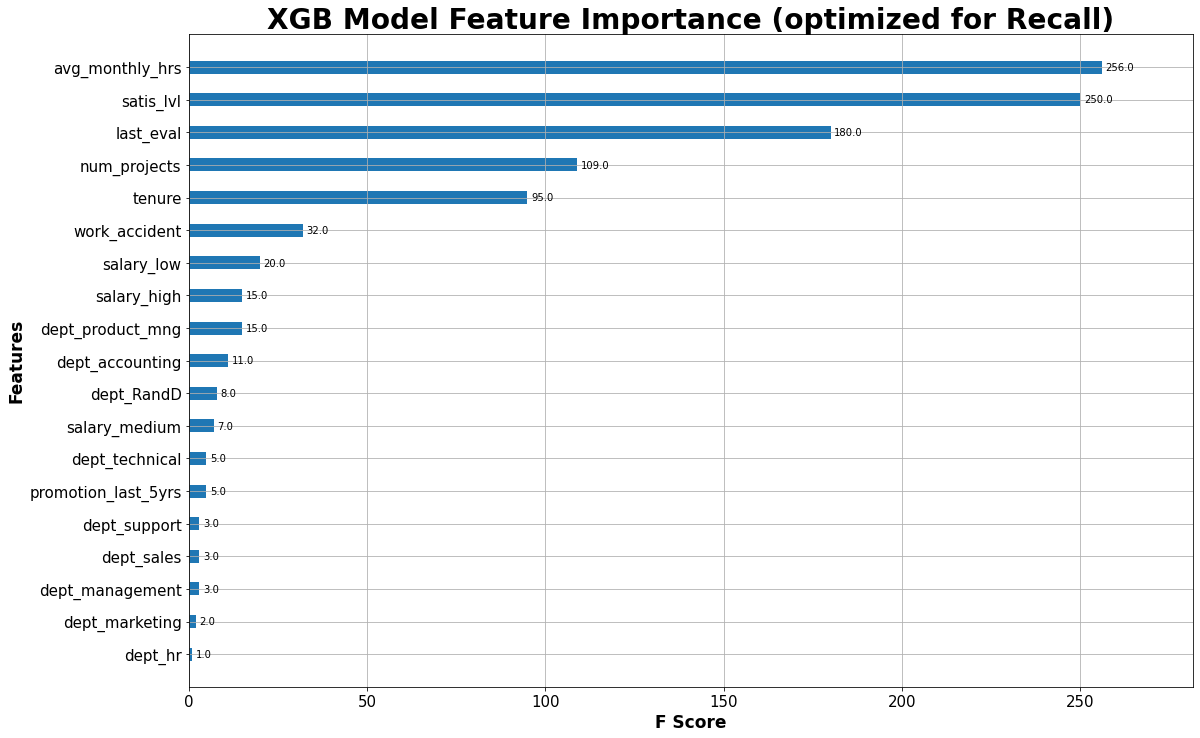

In [147]:
# Plot feature importance for the XGBoost Recall optimized model; this plot shows the impact each predictor 
# variable has on the model for predicting the outcome variable

ax = plot_importance(xgb_recall_cv.best_estimator_,height = 0.4)
fig = ax.figure
fig.set_size_inches(18, 12)
plt.title('XGB Model Feature Importance (optimized for Recall)',fontsize = 28,fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('F Score',fontsize=17,fontweight='bold')
plt.ylabel('Features',fontsize=17,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=15)

### Observations/Insights

It's interesting to note that the predictor variables important in this model are completely different than the ones important in the logistic regression model.

The top 5 most important features for the XGBoost model optimized for Recall are the same as the features important in the decision tree and random forest models, but in a slightly different order: 'avg_monthly_hrs', 'satis_lvl', 'last_eval', 'num_projects', and 'tenure'. While 'avg_monthly_hrs' is still the top predictor for this model, it's F score is less than half what it is for the F1 optimized XGBoost model. While 'satis_lvl' and 'last_eval' are equally important for the F1 optimized XGBoost model, 'satis_lvl' is more important than 'last_eval' in this model.

# Model Selection <a class="anchor" id="model-selection"></a>

[Go Back to Table of Contents](#toc)

In [80]:
# Combine performance metrics for XGBoost, Random Forest, Decision Tree, and Logistic Regression models into 
# F1 and Recall optimization tables

results = pd.concat([xgb_cv_results, dt_cv_results, rf_cv_results, 
                     lr3_results]).sort_values(by=['F1'], ascending=False).reset_index(drop=True)

results['F1'] = round(results['F1'],6)
print('\n')
print('\033[1mF1 Optimization Validation Results')
display(results.style.\
        applymap(lambda x: None if x != 0.952820 else "background-color: green").\
        applymap(lambda x: "font-weight: bold" if x == 0.952820 else None))
print('\n')

recall_results = pd.concat([xgb_recall_cv_results, dt_recall_cv_results, rf_recall_cv_results, 
                            lr3_results]).sort_values(by=['Recall'], ascending=False).reset_index(drop=True)
print('\033[1mRecall Optimization Validation Results')
recall_results['Recall'] = round(recall_results['Recall'],6)
display(recall_results.style.\
        applymap(lambda x: None if x != 0.925572 else "background-color: green").\
        applymap(lambda x: "font-weight: bold" if x == 0.925572 else None))



F1 Optimization Validation Results




Recall Optimization Validation Results


### Recommendation

The Random Forest model has the best F1 score (0.953) of all the models. This means it's performance on both Precision and Recall overall is better than the other models. It's ability to detect the true positives (employees that left the company) and minimize the false positives (predicting employees left the company when they actually stayed) ranks best among all models.

<span style='background :yellow' >**I recommend that HR use the XGBoost Recall optimized model moving forward to predict whether an employee will leave.** 

It might report more false positives (predicting that an employee will leave when they actually may not leave) than the Random Forest or Decision Tree models but it will likely correctly identify more employees who would actually leave than the other models. It is more important to identify all the employees who may actually leave than it is to minimize false positives (incorrectly identifying employees who would stay as leaving) to maximize retention.
    
<span style='background :yellow' >**I recommend that HR use the Random Forest F1 optimized model when they want a more accurate overall view of employees predicted to both leave and stay.** 
    
This model is the best at minimizing both false positives (predicting an employee will leave when they would actually stay) and false negatives (predicting an employee would stay when they would actually leave) at the same time. While it's Recall score isn't as high as the XGBoost Recall model, it's F1 score and overall Accuracy score is higher than the other models.

# Model Testing and Evaluation

## Random Forest F1 Optimized Model

In [81]:
# Get performance metrics for how well the chosen Random Forest F1 optimized model predicts the y_test observations

rf_cv_preds = rf_cv.predict(X_test)

rf_final_results = pd.DataFrame({'Model': 'Random Forest F1 Optimized Final Model',
                          'F1': [f1_score(y_test, rf_cv_preds)],
                          'Recall': [recall_score(y_test, rf_cv_preds)],
                          'Precision': [precision_score(y_test, rf_cv_preds)],
                          'Accuracy': [accuracy_score(y_test, rf_cv_preds)],
                          'ROC/AUC': [roc_auc_score(y_test, rf_cv_preds)]
                         })
rf_final_results['F1'] = round(rf_final_results['F1'],6)
rf_final_results_combined = pd.concat([rf_final_results, rf_cv_results]).sort_values(by=['F1'], ascending=False).reset_index(drop=True)
display(rf_final_results_combined.style.\
        applymap(lambda x: "background-color: green" if x == 0.963934 else None).\
        applymap(lambda x: "font-weight: bold" if x == 0.963934 else None))

### Observations/Insights

The Random Forest F1 optimized model actually performed better in testing for all scores except ROC/AUC than it did in cross-validation. This is a good sign moving forward.

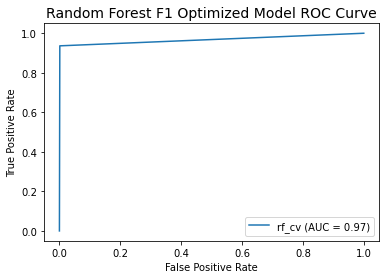

In [237]:
# Plot ROC Curve for the Random Forest F1 optimized model

fpr, tpr, thresholds = roc_curve(y_test, rf_cv_preds)
roc_auc = auc(fpr, tpr)
lr3rocplot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='rf_cv')
lr3rocplot.plot()
plt.title('Random Forest F1 Optimized Model ROC Curve',fontsize=14)
plt.show()

### Observations

About 97% of the Random Forest F1 optimized model's predictions are correct across all classification thresholds. In the plot, the true positive rate is maximized across most classification thresholds while the false positive rate is minimized (the curve is hugging the top left corner).

In [82]:
# Dataframe of calculated probabilities used to predict 0 or 1 for each y_test observation, the predictions made,
# the actual outcome, and the row index in the original dataset

y_rfcv_probs = pd.DataFrame(rf_cv.predict_proba(X_test)[::,-1])
y_rfcv_probs = y_rfcv_probs.rename(columns={0:'probability_employee_left'})
y_rfcv_preds = pd.DataFrame(rf_cv_preds)
y_rfcv_preds = y_rfcv_preds.rename(columns={0:'pred'})
y_rfcv_probs = y_rfcv_probs.merge(y_rfcv_preds,how='outer',left_index=True,right_index=True)
y_actual = pd.DataFrame(y_test).reset_index()
y_actual = y_actual.rename(columns={'left':'actual','index':'employee_row'})
y_rfcv_probs = y_rfcv_probs.merge(y_actual,how='outer',left_index=True,right_index=True)
y_rfcv_probs.insert(y_rfcv_probs.columns.get_loc("probability_employee_left"),"employee_row",y_rfcv_probs.pop("employee_row"))

display(y_rfcv_probs.head(10))

employee_row  probability_employee_left  pred  actual
0         10368                   0.003848     0       0
1          6408                   0.004121     0       0
2          6129                   0.012324     0       0
3           964                   0.995773     1       1
4         11657                   0.003632     0       0
5          9550                   0.004885     0       0
6          7549                   0.033149     0       0
7          4065                   0.003924     0       0
8          9435                   0.006115     0       0
9          3607                   0.007559     0       0

This table matches the employee record from the dataset with the probability that employee would leave (and the resulting prediction and actual outcome) as calculated by the model. This can be used to conduct more pointed investigation on specific employee records if desired.



    Random Forest Confusion Matrix


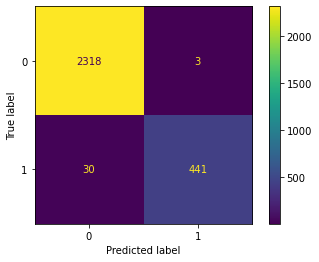

In [262]:
# Plot confusion matrix for the chosen Random Forest F1 optimized model  model to get more granular detail on its 
# performance in predicting 0 or 1 for the y_test values

print('\n')
print('    ' + '\033[1mRandom Forest Confusion Matrix\033[1m')

cm_rf = confusion_matrix(y_test, rf_cv_preds, labels=rf_cv.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                             display_labels=rf_cv.classes_)
disp_rf.plot(values_format='');

In [263]:
# Print actual outcomes from the test dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_test.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    2321
1     471


### Observations/Insights

Of the 444 outcomes the model predicted as positive (an employee leaving), 441 of them were correct. This is reflected by the model's ~99% Precision score. 

Of the 471 outcomes that were actually positive (an employee leaving), the model predicted 441 of them correctly. This is reflected by the model's ~93.6% Recall score. 

Of the 2321 outcomes that were actually negative (an employee staying), the model predicted 2318 of them correctly. This number combined with the 441 true positives the model predicted divided by the total number of predictions made (2792) yields the ~99% overall Accuracy score of the model.

## XGBoost Recall Optimized Model

In [83]:
# Get performance metrics for how well the final XGBoost Recall optimized model predicted the y_test observations

xgb_recall_cv_preds = xgb_recall_cv.predict(X_test)

xgb_final_results = pd.DataFrame({'Model': 'XGBoost Recall Optimized Final Model',
                          'F1': [f1_score(y_test, xgb_recall_cv_preds)],
                          'Recall': [recall_score(y_test, xgb_recall_cv_preds)],
                          'Precision': [precision_score(y_test, xgb_recall_cv_preds)],
                          'Accuracy': [accuracy_score(y_test, xgb_recall_cv_preds)],
                          'ROC/AUC': [roc_auc_score(y_test, xgb_recall_cv_preds)]
                         })
xgb_final_results['Recall'] = round(xgb_final_results['Recall'],6)
xgb_final_results_combined = pd.concat([xgb_final_results, xgb_recall_cv_results]).sort_values(by=['Recall'], ascending=False).reset_index(drop=True)
display(xgb_final_results_combined.style.\
        applymap(lambda x: "background-color: green" if x == 0.942675 else None).\
        applymap(lambda x: "font-weight: bold" if x == 0.942675 else None))

### Observations/Insights

The XGBoost Recall optimized model actually performed better in testing for all scores than it did in cross-validation. This is a good sign moving forward.

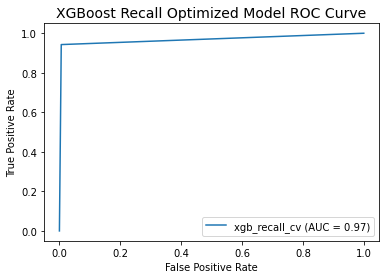

In [252]:
# Plot ROC Curve for the XGBoost Recall optimized model

fpr, tpr, thresholds = roc_curve(y_test, xgb_recall_cv_preds)
roc_auc = auc(fpr, tpr)
lr3rocplot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='xgb_recall_cv')
lr3rocplot.plot()
plt.title('XGBoost Recall Optimized Model ROC Curve',fontsize=14)
plt.show()

### Observations

About 97% of the XGBoost Recall optimized model's predictions are correct across all classification thresholds. In the plot, the true positive rate is maximized across most classification thresholds while the false positive rate is minimized (the curve is hugging the top left corner).

In [70]:
# Dataframe of calculated probabilities used to predict 0 or 1 for each y_test observation, the predictions made,
# the actual outcome, and the row index in the original dataset

y_xgbrecall_probs = pd.DataFrame(xgb_recall_cv.predict_proba(X_test)[::,-1])
y_xgbrecall_probs = y_xgbrecall_probs.rename(columns={0:'probability_employee_left'})
y_xgbrecall_preds = pd.DataFrame(xgb_recall_cv_preds)
y_xgbrecall_preds = y_xgbrecall_preds.rename(columns={0:'pred'})
y_xgbrecall_probs = y_xgbrecall_probs.merge(y_xgbrecall_preds,how='outer',left_index=True,right_index=True)
y_actual = pd.DataFrame(y_test).reset_index()
y_actual = y_actual.rename(columns={'left':'actual','index':'employee_row'})
y_xgbrecall_probs = y_xgbrecall_probs.merge(y_actual,how='outer',left_index=True,right_index=True)
y_xgbrecall_probs.insert(y_xgbrecall_probs.columns.get_loc("probability_employee_left"),"employee_row",y_xgbrecall_probs.pop("employee_row"))

display(y_xgbrecall_probs.head(10))

employee_row  probability_employee_left  pred  actual
0         10368                   0.003758     0       0
1          6408                   0.001238     0       0
2          6129                   0.020884     0       0
3           964                   0.877692     1       1
4         11657                   0.006488     0       0
5          9550                   0.013286     0       0
6          7549                   0.022517     0       0
7          4065                   0.027228     0       0
8          9435                   0.004720     0       0
9          3607                   0.003845     0       0

This table matches the employee record from the dataset with the probability that employee would leave (and the resulting prediction and actual outcome) as calculated by the model. This can be used to conduct more pointed investigation on specific employee records if desired.



     XGBoost Confusion Matrix


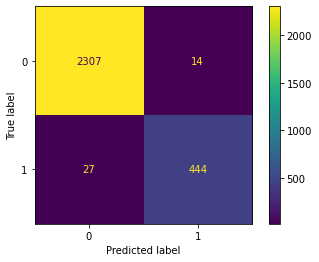

In [268]:
# Plot confusion matrix for the XGBoost model to get more granular detail on its performance in predicting
# 0 or 1 for the y_test values

print('\n')
print('     ' + '\033[1mXGBoost Confusion Matrix\033[1m')

cm_xgb = confusion_matrix(y_test, xgb_recall_cv_preds, labels=xgb_recall_cv.classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                             display_labels=xgb_recall_cv.classes_)
disp_xgb.plot(values_format='');

In [269]:
# Print actual outcomes from the test dataset

print("\033[1mActual Outcomes (left vs. stayed)\033[0m")
print(y_test.value_counts().to_string())

Actual Outcomes (left vs. stayed)
0    2321
1     471


### Observations/Insights

Of the 458 outcomes the model predicted as positive (an employee leaving), 444 of them were correct. This is reflected by the model's ~97% Precision score. 

Of the 471 outcomes that were actually positive (an employee leaving), the model predicted 444 of them correctly. This is reflected by the model's ~94.3% Recall score. 

Of the 2321 outcomes that were actually negative (an employee staying), the model predicted 2307 of them correctly. This number combined with the 444 true positives the model predicted divided by the total number of predictions made (2792) yields the ~99% overall Accuracy score of the model.

## Champion Models Combined Test Results

In [84]:
# Consolidate performance metrics for how well the final XGBoost Recall optimized model and Random Forest F1 
# optimized model predicted the y_test observations

xgb_recall_cv_preds = xgb_recall_cv.predict(X_test)

xgb_final_results = pd.DataFrame({'Model': 'XGBoost Recall Optimized Final Model',
                          'F1': [f1_score(y_test, xgb_recall_cv_preds)],
                          'Recall': [recall_score(y_test, xgb_recall_cv_preds)],
                          'Precision': [precision_score(y_test, xgb_recall_cv_preds)],
                          'Accuracy': [accuracy_score(y_test, xgb_recall_cv_preds)],
                          'ROC/AUC': [roc_auc_score(y_test, xgb_recall_cv_preds)]
                         })
final_model_results = pd.concat([xgb_final_results, rf_final_results]).reset_index(drop=True)
final_model_results['F1'] = round(final_model_results['F1'],6)
final_model_results['Recall'] = round(final_model_results['Recall'],6)
display(final_model_results.style.\
        applymap(lambda x: "background-color: green" if (x == 0.963934) | (x == 0.942675) else None).\
        applymap(lambda x: "font-weight: bold" if (x == 0.963934) | (x == 0.942675) else None))

### Observations/Insights

Each final model performed better in the area it was designed to optimize compared to the other model. The XGBoost model performed higher in Recall and the Random Forest model had a higher F1 score. 

**Once these models are trained on the full dataset, they will be ready to deploy and start making predictions.**

## Recommendation

<span style='background :yellow' >**To reiterate:**

<span style='background :yellow' >**I recommend that HR use the XGBoost Recall optimized model to predict whether an employee will leave.** 
    
<span style='background :yellow' >**I recommend that HR use the Random Forest F1 optimized model when they want a more accurate overall view of employees predicted to both leave and stay.** 

# pacE: Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders



## Recall evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






## Step 4. Results and Evaluation <a class="anchor" id="recommendations"></a>

[Go Back to Table of Contents](#toc)

## Summary of Model Results

### Recommended Models for Prediction

The Random Forest model has the best F1 score (0.953) of all the models. This means it's performance on both Precision and Recall overall is better than the other models. It's ability to detect the true positives (employees that left the company) and minimize the false positives (predicting employees left the company when they actually stayed) ranks best among all models.

<span style='background :yellow' >**I recommend that HR use the XGBoost Recall optimized model moving forward to predict whether an employee will leave.** 

It might report more false positives (predicting that an employee will leave when they actually may not leave) than the Random Forest or Decision Tree models but it will likely correctly identify more employees who would actually leave than the other models. It is more important to identify all the employees who may actually leave than it is to minimize false positives (incorrectly identifying employees who would stay as leaving) to maximize retention.
    
<span style='background :yellow' >**I recommend that HR use the Random Forest F1 optimized model when they want a more accurate overall view of employees predicted to both leave and stay.** 
    
This model is the best at minimizing both false positives (predicting an employee will leave when they would actually stay) and false negatives (predicting an employee would stay when they would actually leave) at the same time. While it's Recall score isn't as high as the XGBoost Recall model, it's F1 score and overall Accuracy score is higher than the other models.
    
### Important Variables in the Models
    
Both the champion models and all other models except for the logistic regression models had the same top variables that contributed the most to the predictive power of the models. Their combined ranked order from the champion models is as follows: 
    
    1. 'satis_lvl' 
    2. 'avg_monthly_hrs' 
    3. 'tenure', 'num_projects', and 'last_eval'
    
In general, as 'satis_lvl' increases, the probability that an employee will leave decreases. As 'avg_monthly_hrs', 'tenure' (especially from years 4-6), and 'num_projects' (beyond 4 projects) increase, the probability that an employee will leave increases. 'last-eval' has a less clear direct relationship with the outcome variable. All of these variables are not only important because of their direct relationship with the outcome variable, but even more so because of how their relationships with other variables in the model influence the model's predictions.
    
### Testing
    
The Random Forest F1 optimized model actually performed better in testing for all scores except ROC/AUC than it did in cross-validation. This is a good sign moving forward.
    
The XGBoost Recall optimized model actually performed better in testing for all scores than it did in cross-validation. This is a good sign moving forward.
    
Each final model performed better in the area it was designed to optimize compared to the other model. The XGBoost model performed higher in Recall and the Random Forest model had a higher F1 score. 
    
Each model can likely be improved further through additional hyperparameter tuning. As the models see more data in the future, this data can be added to further train the models and fine-tune hyperparameters for increased performance.

**Once these models are trained on the full dataset, they will be ready to deploy and start making predictions.**

# Recommendations, Next Steps

*Overall, a common theme amongst employees who left the company and had low satisfaction levels was that they were overworked and not rewarded. The majority of the following recommendations address this.*

### Dataset/Variables Improvement

It would be prudent to get more detail from HR on how sampling was conducted to judge whether this dataset is likely to be truly representative of the population (the entire company). If this dataset is not representative, making inferences with a predictive model based on it would be inaccurate.

Actual salary amounts instead of categories would likely make 'salary' a better predictor variable for the outcome variable 'left'. I would not have any ethical concerns about this as long as the data remains anonymized and is made available for use only upon employee consent. Also, job titles aren't included in the dataset. This was a variable that the executive team specifically called out to use in analysis. Additionally, including more than just the last evaluation for each employee could be insightful - perhaps the last two to three evaluations. More generally, it's unclear over what timeframe some of these variables cover - it would be useful to know how various variables progressed over time, such as for satisfaction level, evaluations, number of projects, average monthly hours, when work accidents occurred, what departments employees worked in over time, and salary.

Additionally, it would be useful to know, in addition to the number of projects, the level of project complexity/scope - these would likely go together as a useful interaction variable to include in predictive modeling.

Also, if Salifort Motors conducted additional periodic Organizational Health Surveys (OHS), there could be a wealth of valuable information from those to include in this dataset to better predict whether an employee will leave vs. stay. Examples of additional useful information might include job titles, whether employees feel safe and valued at work, whether they trust their managers, how they view their team environment, whether they feel their pay level is fair, whether they feel that their job is secure, whether they feel there is ample opportunity for career growth in the company, whether they feel fulfilled with the work they do in their job, how employees would define what the company culture is, etc.
    
HR should consolidate data from employee exit interviews to determine reasons why employees left. This data would be helpful in both predicting employees that might leave as well as in determining changes to be made to better retain employees.

Lastly, the satisfaction level variable could be a source of data leakage when used to train the predictive models since it may not be a variable that will be available in the future when the chosen model is deployed. If it will be available, through periodic company-wide Organizational Health Surveys or otherwise, then data leakage will not be a concern. However, if it will not be available moving forward, then the projected effectiveness of the chosen model might be somewhat inflated.

Including the above information in the dataset would greatly improve the company's ability to gain insights into what contributes to employee satisfaction/dissatisfaction and whether an employee is likely to leave vs. stay.

<span style='background :yellow' >**Data Duplicates.** 

<span style='background :yellow' >HR should find the source(s) of the duplicates found in this dataset and figure out a way to eliminate or at least decrease them in future data gathering efforts. A few duplicates is not a real issue but when duplicates make up a large portion of the data (in this case over 20%), they inflate survey response rates and can cause data gathering efforts to stop prematurely when the data gathering team thinks they have enough unique responses, but in fact do not due to the duplicate reponses. If the duplicate responses in this dataset were instead unique responses, that would have meant that much more data to use for analysis and training/testing predictive models.

### <span style='background :yellow' >**Project Workload.** 

<span style='background :yellow' >Managers should strive to assign 3-4 projects to a majority of their employees and should not assign more than 5 projects to an employee unless that employee and his/her manager is sure they can handle it without unduly increasing their work hours.

<span style='background :yellow' >Managers should closely monitor how their employees are handling their project workload on a regular basis. If it becomes apparent that an employee is having to consistently spend significantly more time working with additional project workload, it may be the manager's best interest to cut back that employee's workload and redistribute projects until that employee is able to handle more without increasing their work hours.</span>
    
### <span style='background :yellow' >**Job Candidate Screening.** 

<span style='background :yellow' >Recruiters and hiring managers would do well to thoroughly screen job candidates before hiring them to weed out potential underperformers. Do the job candidates have strong work ethic and are able to efficiently get results? Do they have the knowledge/skills/experience necessary to be successful in their hired role? Will they be committed to the company's success?
    
### <span style='background :yellow' >**Employee Hours Worked.**
    
<span style='background :yellow' >Management should create a company culture where employees feel they can work normal 8-hour workdays on a regular basis and not be penalized. In fact, employees who are able to efficiently and effectively get work done within regular hours should be recognized and rewarded.
    
### <span style='background :yellow' >**Employee Evaluation Criteria.**
    
<span style='background :yellow' >Building on the last recommendation regarding employee hours worked, management should ensure their employee evaluation criteria is tied to employees getting results vs. working longer hours or on more projects. Management should lead this change in organizational culture so employees know that achieving results is more important. Greater quantity doesn't necessarily equate to greater quality/better results for the company.
    
<span style='background :yellow' >If an employee is eager to take on more projects and/or work longer hours and is able to achieve the same level of results or better, that can be decided on a case by case basis by the manager - but the employee shouldn't think this is necessary for them to receive a strong evaluation. Management should make this clear.
    
### <span style='background :yellow' >**5-Year Tenure Employee Incentivization.**
    
<span style='background :yellow' >Since 5-year tenure employees have by far the greatest percentage within a tenure year group that left the company, the company should implement special incentives for employees to stay with the company beyond 5 years. These could include higher salary raises at 5 years, additional vacation days, time-based restricted stock, promotion, public recognition of company contribution, or other incentives.
    
### <span style='background :yellow' >**Top Talent Retention.**
    
<span style='background :yellow' >Since the same tenure groups of employees who had the highest percentages of employees leave the company also appear to be the top talent tenure groups in the company overall, incentives directed towards these tenure groups should take into account that they consist of top talent. This would justify higher levels of pay, promotion, or other such similar incentives mentioned previously.
    
### <span style='background :yellow' >**Employee Salaries Overhaul.**
    
<span style='background :yellow' >It doesn't make sense that the employees who do the most work and have the highest evaluation scores also have among the lowest salaries in the company. Management/Finance should take a serious look at how salaries are determined for its employees, especially for the top performers in tenures 4-6, and ensure it is commensurate with the value employees bring to the company.
    
### <span style='background :yellow' >**Employee Promotions.**
    
<span style='background :yellow' >Not enough employees are being promoted overall. The US average promotion rate of 45% over 5 years is about ***26*** times higher than Salifort's 5 year promotion rate.
    
<span style='background :yellow' >**In addition to working on the most projects, having the highest evaluation scores, and having among the lowest salaries in the company, employees with 4 and 5 years tenure also have the lowest promotion rates in the company.**
    
<span style='background :yellow' >**Promotion is another tool management can use to retain employees, especially top talent employees deserving of it. Management and HR should look at employee promotions across the board and ensure that consistent promotion criteria is used throughout the company and that the employees most deserving of promotion get promoted.** 
    
### <span style='background :yellow' >**EHS Program Improvement.**
    
<span style='background :yellow' >Even though a higher percentage of employees who had a work accident stayed at the company than employees who did not have a work accident, a 15.4% accident rate is too high. That's about 6 times higher than the average accident rate in the US and about 9 times higher than the average accident rate in the UK. It is important to provide a safe work environment for employees. The company's EHS team and management should work to find the root causes of these accidents and implement engineered or other best solutions to eliminate or at least mitigate the environmental factors that led to these accidents. Implementing an incentivized proactive program of identifying and correcting hazard observations throughout the company would be a good way to prevent identified hazards from causing safety incidents down the line.
    
## Next Steps
    
For next steps, I recommend the following: 
    
- hold a company-wide Town Hall to present the results of this study and the way forward to address focus areas for improvement
    
- train champion models on the full dataset and deploy for use
    
- gather additional data as outlined above for continued analysis and more refined insights
    
- perform K-means clustering analysis on this dataset to potentially uncover additional insights